# XTalk With Lorenzetti
    1) Simulated Truth Supervised model
    2) Specialist physics knowledge supervised model

In [1]:
# Lorenzetti Showers Collaboration 2020 - 2023 - https://doi.org/10.1016/j.cpc.2023.108671
# %load_ext autoreload
# %autoreload 2

import sys
sys.path.insert(0,'/home/mhufnage/lorenzetti/Applications') #lorenzetti utils path

## Insert here the path to xtalkDatasetAnalysis git package
sys.path.insert(1, '/home/mhufnage/ATLAS_QT_XTALK/xtalkDatasetAnalysis/')

uprootLibrary = 'np'#'np' #'ak'

import json
import os
import time
import shelve

import numpy as np
from glob import glob
import math
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.colors as mcolors
import matplotlib
# matplotlib.use('Agg') #CHANGES THE MATPLOTLIB BACKEND FOR LOOP PLOTS
matplotlib.use('module://ipykernel.pylab.backend_inline')  # show plots

import scipy.stats as scipy
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from collections import OrderedDict
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

import mplhep as hep

plt.style.use([hep.style.ATLAS])

import uproot

# Custom lib
from helper_lib.calibrationFilesHelper import *
from helper_lib.auxiliaryFunctions import confInterval, getBins
from helper_lib.functionsHelper import stdVecToArray, stdVecToPythonArray
import ML_lib.MLP as MLP
from ML_lib.ML_custom_auxiliar import KFoldSampler
from ML_lib.Autoencoder import *
from ML_lib.XTalkDatasetClass import XTalkDataset_LZT_FromROOT,XTalkDataset_LZT,XTalkStreamingDataLoader_LZT, XTalkStreamingDataLoader_LZT_FoldSplit, XTalkStreamingDataLoader_LZT_FoldSplit_Faster
from lorenzetti_reader import *

# %load_ext autoreload
# %autoreload 2

import ROOT
from ROOT import TFile, gROOT, TChain, TTree



import awkward as ak
from array import array




# from calibrationFilesHelper import *
# from Autoencoder import *
# from XTalkDatasetClass import XTalkDataset_LZT, Subset
# from auxiliaryFunctions import confInterval, getBins

# --------- Lorenzetti plot style -------
def lorenzettiText(pos='out',subText=' Internal'):
    lorenzetti_title={'fontsize': 21, 'fontfamily': 'sans-serif', 'fontweight':'bold','fontstyle':'italic'}
    lorenzetti_subtitle={'fontsize': 14, 'fontfamily': 'sans-serif', 'fontweight':'normal','fontstyle':'italic'}

    if pos=='out':
        plt.figtext(x=.18   ,y=.945,s='  Lorenzetti',fontdict=lorenzetti_title)
        plt.figtext(x=.318  ,y=.945,s=subText,fontdict=lorenzetti_subtitle)
    if pos=='in':
        plt.figtext(x=.18   ,y=.875,s='  Lorenzetti',fontdict=lorenzetti_title)
        plt.figtext(x=.318  ,y=.875,s=subText,fontdict=lorenzetti_subtitle)


# --------- Lorenzetti sampling and detector enumeration ---------
class Detector():
  LAR     = 0
  TILE    = 1
  TTEM    = 2
  TTHEC   = 3
  FCALEM  = 5
  FCALHAD = 6

class CaloSampling():
    PSB       = 0
    PSE       = 1
    EMB1      = 2
    EMB2      = 3
    EMB3      = 4
    TileCal1  = 5
    TileCal2  = 6
    TileCal3  = 7
    TileExt1  = 8
    TileExt2  = 9
    TileExt3  = 10
    EMEC1     = 11
    EMEC2     = 12
    EMEC3     = 13
    HEC1      = 14
    HEC2      = 15
    HEC3      = 16


Welcome to JupyROOT 6.24/08


## 1.1 - PhD Qualify: Truth Supervised Model S->S (NPZ Dataset)
- Input: set of 3x3 cells samples **with** crosstalk effect.
- Target: set of same 3x3 cells, with their samples **without** crosstalk.

In [7]:
## Path to experiment output

pathLoss      = '/data/atlas/mhufnage/xtalk/ml_training/supervised_lzt/data_structure_comparison/direct_NPZ/'
DS_Lim        = 2
DS_test       = 6
DS_PathAlias  = '/data/atlas/mhufnage/lzt_single_e/elec_singleCell_10kEvts_centroid_e50_DS{}/AOD_Cap4.2_Ind2.3/user.mhufnage.lzt.e50.xtalk.DS{}.win3.nopileup.WithCells_EM2.event.npz'

# Dataset
data            = []
for DS_index in range(1, DS_Lim):
    data.append (np.load(DS_PathAlias.format(DS_index,DS_index), allow_pickle=True)['dataset'])
data = np.concatenate(data).ravel()

optimAlg                = 'adam'
typeNormalization       = {'electronEnergy': 50.0,
                           'mevToGev': 1/1000,
                           'gevToMev': 1000,
                           'none': 1}#'minMax'

lr                      = 1e-3
weightDecay_adam        = 1e-5

optimConfig             = {
    'adam':{
        'learningRate'  : lr,
        'weightDecay'   : weightDecay_adam,
    },
}

print(optimConfig[optimAlg])

range_neuInput          = [45,20,20]
range_neuText           = MLP.neuListToFileText(range_neuInput)

experiment_alias        = '''
learning the samples of a 3x3 window from topocluster at EMB2 layer. 
The loss for training is the input-output map. 
The cell organization in the window is eta-oriented.
# phi [ 3 | 6 | 9 ]
#     [ 2 | 5 | 8 ]  , eta-orientation cluster indexing. where 5 is the index of the hottest cell
#     [ 1 | 4 | 7 ]
#             eta
'''
totalEvents             = len(data)

nEpochs                 = 30
lossComputation         = 'p'
patience                = 15
min_delta_loss          = 0

k                       = 3 # number of folds in kFold split
nBatch                  = 16 # batch size in clusters
nIter                   = 1
nClusters               = 1000 # for training, validation and test

nSamples                = 5 # standard for LAr
nCellsWinEta            = 3 # dataset selection
nCellsWinPhi            = 3
scalerInput             = torch.tensor((typeNormalization['mevToGev'])) # without normalization, set to 1
scalerOutput            = torch.tensor(typeNormalization['gevToMev'])

train_ratio             = 0.90 # proportion of data to apply the kFold
test_ratio              = 0.10 # proportion of data to apply test on trained model

if not(os.path.isdir(pathLoss)):
    os.mkdir(pathLoss)

#
# Dataset split
#
total_ene = []
total_tau = []

train_config_dict   = {
    'experiment_alias'  : experiment_alias,
    'patience'          : patience,
    'min_delta_loss'    : min_delta_loss,
    'max_epochs'        : nEpochs,
    'kFolds'            : k,
    'batch_size'        : nBatch,
    'max_init'          : nIter,
    'total_clusters'    : totalEvents,
    'train_ratio'       : train_ratio,
    'test_ratio'        : test_ratio,
    'cell_win_eta'      : nCellsWinEta,
    'cell_win_phi'      : nCellsWinPhi,
    'scaler_input'      : scalerInput,
    'scaler_output'     : scalerOutput,
    'neurons_list'      : range_neuInput,
    'neurons_text'      : range_neuText,
    'lossComputation'   : lossComputation,
    'optimConfig'       : optimConfig,
}

# if optimAlg=='adam':
np.savez(pathLoss+'config_train_nn{}_{}_neu{}.npz'.format(lossComputation, optimAlg, range_neuText), config=train_config_dict)

X_train, X_test = train_test_split( data[0:nClusters] , test_size=test_ratio)

datasetTest     =   XTalkDataset_LZT(X_test, nEvents=-1, mode='supervised')

kfold = KFold(n_splits=k, shuffle=True, random_state=1)

for nFold, (train_fold_idx, valid_fold_idx) in enumerate(kfold.split(X_train)):

    datasetTrain  = XTalkDataset_LZT(X_train[train_fold_idx], nEvents=-1, mode='supervised')
    datasetValid  = XTalkDataset_LZT(X_train[valid_fold_idx], nEvents=-1, mode='supervised')
    
    train_fold    = DataLoader( datasetTrain, batch_size=nBatch, shuffle=False)
    val_fold      = DataLoader( datasetValid, batch_size=nBatch, shuffle=False)
    
    for it in range(0,nIter):
        print('\t\tFold {}/{}... iter {}/{}'.format(nFold+1,k, it+1, nIter))
        
        train_logging_dict  = {
            'loss'              : [],
            'val_loss'          : [],
            'tau_loss'          : [],
            'val_tau_loss'      : [],
            'ene_loss'          : [],
            'val_ene_loss'      : [],
            'total_loss'        : [],
            'total_val_loss'    : [],

            'best_epoch'    : -1,
        }
        
        #
        # Model initialization
        #
        model = MLP.MLP_FF(range_neuInput, mlpType='sampleInSampleOut')
        
        if optimAlg=='adam':
            optimizer = torch.optim.Adam(model.parameters(), 
                                        lr=optimConfig[optimAlg]['learningRate'], 
                                        weight_decay=optimConfig[optimAlg]['weightDecay'])
        
        early_stopper  = MLP.EarlyStopper(patience=patience, min_delta=min_delta_loss)
        
        for epoch in range(nEpochs):
            #
            # Training
            #
                        
            for data_input, target, batch_idx in train_fold:
                
                # pass input through the model and generate the output
                # print(np.shape(data_input), target, batch_idx)
                output      = model(data_input*scalerInput) #normalized (not yet exactly) input
                
                # print(output.is_leaf)
                
                #
                # Loss calculation
                #
                
                # get input and output energy and time
                # ene_input, tau_input    = datasetTrain.calibrate(batch_idx, data_input) # unormlized input
                ene_target, tau_target    = datasetTrain.calibrate(batch_idx, target) # unormlized target
                ene_output, tau_output    = datasetTrain.calibrate(batch_idx, output*scalerOutput) # denormalized output
                # sigmaTau_out            = torch.std(tau_output)
                # sigmaTau_in             = torch.std(tau_input)
                
                # total window loss
                # loss            = model.criterion(output, data_input*scalerInput) # loss with normalized data input and output
                loss            = model.criterion(output, target*scalerInput) # loss with normalized data target and model output
                loss_tau        = model.criterion(tau_output , tau_target) # time remains in ns
                loss_ene        = model.criterion(ene_output*typeNormalization['mevToGev'] , ene_target*typeNormalization['mevToGev']) # scale energy from MeV to GeV
                
                #
                # Backpropagation (optimize weights)
                #
                # model.optimizer.zero_grad()
                optimizer.zero_grad()
                total_loss      = loss + loss_ene + loss_tau
                pulse_tau_loss  = loss + loss_tau
                
                if lossComputation=='pet':
                    total_loss.backward()                    
                elif lossComputation=='p':
                    loss.backward()
                elif lossComputation=='t':
                    loss_tau.backward()
                elif lossComputation=='pt':
                    pulse_tau_loss.backward()                    
                else:
                    raise AttributeError("loss computation was not set to any implemented options.")
                # loss_tau.backward()
                # model.optimizer.step()
                optimizer.step()
            
            #
            # Validation
            #
            for data_input, target, batch_idx in val_fold:
                # pass input through the model and generate the output
                output  = model(data_input*scalerInput)

                #
                # Loss calculation
                #

                # get input and output energy and time
                # val_ene_input, val_tau_input    = datasetTrain.calibrate(batch_idx, data_input)# unormlized input
                val_ene_target, val_tau_target  = datasetTrain.calibrate(batch_idx, target)# unormlized target
                val_ene_output, val_tau_output  = datasetTrain.calibrate(batch_idx, output*scalerOutput)# denormalized output

                val_loss            = model.criterion(output, target*scalerInput) #normalized target
                val_loss_tau        = model.criterion(val_tau_output , val_tau_target)
                val_loss_ene        = model.criterion(val_ene_output*typeNormalization['mevToGev'] , val_ene_target*typeNormalization['mevToGev'])
                
                total_val_loss = val_loss + val_loss_ene + val_loss_tau
                val_pulse_tau_loss = val_loss + val_loss_tau

            #
            # End of the current Epoch
            #
            if (epoch%1)==0:                
                print('\t\t\tEpoch {}/{}...loss={:.5f}, val_loss={:.5f} | tau_loss={:.5f} | ene_loss={:.5f} | total_loss={:.5f}, total_val_loss={:.5f} '.format(epoch,nEpochs,loss.detach().numpy(), val_loss, loss_tau, loss_ene, total_loss, total_val_loss))
    
            train_logging_dict['loss'].append(loss.detach().numpy())
            train_logging_dict['ene_loss'].append(loss_ene.detach().numpy())
            train_logging_dict['tau_loss'].append(loss_tau.detach().numpy())
            train_logging_dict['val_loss'].append(val_loss.detach().numpy())
            train_logging_dict['val_ene_loss'].append(val_loss_ene.detach().numpy())
            train_logging_dict['val_tau_loss'].append(val_loss_tau.detach().numpy())
            train_logging_dict['total_loss'].append(total_loss.detach().numpy())
            train_logging_dict['total_val_loss'].append(total_val_loss.detach().numpy())
            
            #
            # Early Stop criteria
            #
            bestModelPath   = pathLoss+'bestModel_nn{}_fold{}_iter{}_neu{}.pth'.format(lossComputation,nFold, it, range_neuText)
            
            if lossComputation=='pet':
                bStop           = early_stopper.early_stop(total_val_loss, epoch, model, optimizer, bestModelPath)
            elif lossComputation=='p':
                bStop           = early_stopper.early_stop(val_loss, epoch, model, optimizer, bestModelPath)
            elif lossComputation=='t':
                bStop           = early_stopper.early_stop(val_loss_tau, epoch, model, optimizer, bestModelPath)
            elif lossComputation=='pt':
                bStop           = early_stopper.early_stop(val_pulse_tau_loss, epoch, model, optimizer, bestModelPath)
            else:
                raise AttributeError("select a loss computation method.")
            
            if bStop:
                train_logging_dict['best_epoch'] = early_stopper.bestEpoch
                
                if lossComputation=='pet':
                    print('--- EarlyStopper=True. val_loss={}... bestModel_loss={}, bestEpoch={}'.format(total_val_loss, early_stopper.min_validation_loss, early_stopper.bestEpoch))
                    MLP.checkpoint(early_stopper.tmpModel, optimizer, bestModelPath, epoch, total_val_loss) # save the model
                    break
                if lossComputation=='p':
                    print('--- EarlyStopper=True. val_loss={}... bestModel_loss={}, bestEpoch={}'.format(val_loss, early_stopper.min_validation_loss, early_stopper.bestEpoch))
                    MLP.checkpoint(early_stopper.tmpModel, optimizer, bestModelPath, epoch, val_loss) # save the model
                    break
                if lossComputation=='t':
                    print('--- EarlyStopper=True. val_loss={}... bestModel_loss={}, bestEpoch={}'.format(val_loss_tau, early_stopper.min_validation_loss, early_stopper.bestEpoch))
                    MLP.checkpoint(early_stopper.tmpModel, optimizer, bestModelPath, epoch, val_loss_tau) # save the model
                    break
                if lossComputation=='pt':
                    print('--- EarlyStopper=True. val_loss={}... bestModel_loss={}, bestEpoch={}'.format(val_pulse_tau_loss, early_stopper.min_validation_loss, early_stopper.bestEpoch))
                    MLP.checkpoint(early_stopper.tmpModel, optimizer, bestModelPath, epoch, val_pulse_tau_loss) # save the model
                    break
                else:
                    raise AttributeError("select a loss computation method.")
            else:
                train_logging_dict['best_epoch'] = epoch
            
        #
        # End of training at current fold-iter
        #
        MLP.checkpoint(model, optimizer, bestModelPath, epoch, val_loss) # save model in case Early_Stop didn't happen
        np.savez(pathLoss+'loss_nn{}_fold{}_iter{}_neu{}_batch{}.npz'.format(lossComputation,nFold, it, range_neuText, nBatch) ,loss=train_logging_dict)




{'learningRate': 0.001, 'weightDecay': 1e-05}


FileNotFoundError: [Errno 2] No such file or directory: '/data/atlas/mhufnage/xtalk/ml_training/supervised_lzt/data_structure_comparison/direct_NPZ/'

## 1.2 - PhD Qualify: Truth Supervised Model S->S (ROOT StreamingDataset)
- Input: set of 3x3 cells samples **with** crosstalk effect.
- Target: set of same 3x3 cells, with their samples **without** crosstalk.

In [ ]:
## Path to experiment output

pathLoss      = '/data/atlas/mhufnage/xtalk/ml_training/supervised_lzt/data_structure_comparison/sub_ROOT/'

conditions = {
    'nEvents':         9000, # <--- it is the total events to feed KFold_split into (train+valid)+(test).
    'SigmaCut':        1,
    'etaCut':          1.4,
    'caloSampling':    'EM2',#CaloSampling.EMB2,
    'etaSize':         3,
    'phiSize':         3,
    'nSamples':        5,
    'dumpCells':       True,
    'bDumpWindowOnly': True,
    'bNoEneCut':       True,
    'XTalk_ind':       2.3,
    'XTalk_cap':       4.2,
    'XTalkLevel':      'L = 1.1%, C = 0.0%',
    
    # Not implemented yet!
    'etBin':           [[15 , 20] ,[20, 30]  ,[30, 40]  ,[40, 50],[50,100],[100,10000000]],
    'etaBin':          [[0.00, 0.80], [0.80, 1.37], [1.37,1.54],[1.54,2.50],[2.50,3.2]],
    'bPhaseSpaceDiv':  False,
}
# Dataset
data = TChain('ML_tree')
for ds_index in range(1,2):
    print(ds_index, conditions['XTalk_cap'], conditions['XTalk_ind'], conditions['etaSize'], conditions['phiSize'])
    theFile = '/data/atlas/mhufnage/lzt_single_e/elec_singleCell_10kEvts_centroid_e50_DS{}/AOD_Cap{:.1f}_Ind{:.1f}/user.mhufnage.lzt.e50.xtalk.DS1.win{}{}.nopileup.WithCells_{}.root'.format(ds_index, conditions['XTalk_cap'], conditions['XTalk_ind'], conditions['etaSize'], conditions['phiSize'], conditions['caloSampling'])
    data.Add(theFile+'/ML_tree')

optimAlg                = 'adam'
typeNormalization       = {'electronEnergy': 50.0,
                           'mevToGev': 1/1000,
                           'gevToMev': 1000,
                           'none': 1}#'minMax'

lr                      = 1e-3
weightDecay_adam        = 1e-5

optimConfig             = {
    'adam':{
        'learningRate'  : lr,
        'weightDecay'   : weightDecay_adam,
    },
}

print(optimConfig[optimAlg])

range_neuInput          = [45,20,20]
range_neuText           = MLP.neuListToFileText(range_neuInput)

experiment_alias        = '''
learning the samples of a 3x3 window from topocluster at EMB2 layer. 
The loss for training is the input-output map. 
The cell organization in the window is eta-oriented.
# phi [ 3 | 6 | 9 ]
#     [ 2 | 5 | 8 ]  , eta-orientation cluster indexing. where 5 is the index of the hottest cell
#     [ 1 | 4 | 7 ]
#             eta
'''
totalEvents             = data.GetEntries()#len(data)

nEpochs                 = 30
lossComputation         = 'p'
patience                = 15
min_delta_loss          = 0

k                       = 3 # number of folds in kFold split
nBatch                  = 16 # batch size in clusters
buffer_batches          = 4  # number of batches to being loaded into TTree dataset reading buffer (buffer_batches * nBatch)
nIter                   = 1
nClusters               = conditions['nEvents'] # for training and validation

nSamples                = 5 # standard for LAr
nCellsWinEta            = 3 # dataset selection
nCellsWinPhi            = 3
scalerInput             = torch.tensor((typeNormalization['mevToGev'])) # without normalization, set to 1
scalerOutput            = torch.tensor(typeNormalization['gevToMev'])

train_ratio             = 0.90 # proportion of data to apply the kFold
test_ratio              = 0.10 # proportion of data to apply test on trained model

if not(os.path.isdir(pathLoss)):
    os.mkdir(pathLoss)

#
# Dataset split
#
total_ene = []
total_tau = []

train_config_dict   = {
    'experiment_alias'  : experiment_alias,
    'conditions'        : conditions,
    'patience'          : patience,
    'min_delta_loss'    : min_delta_loss,
    'max_epochs'        : nEpochs,
    'kFolds'            : k,
    'batch_size'        : nBatch,
    'buffer_batches'    : buffer_batches,
    'max_init'          : nIter,
    'total_clusters'    : totalEvents,
    'train_ratio'       : train_ratio,
    'test_ratio'        : test_ratio,
    'cell_win_eta'      : nCellsWinEta,
    'cell_win_phi'      : nCellsWinPhi,
    'scaler_input'      : scalerInput,
    'scaler_output'     : scalerOutput,
    'neurons_list'      : range_neuInput,
    'neurons_text'      : range_neuText,
    'lossComputation'   : lossComputation,
    'optimConfig'       : optimConfig,
}

# if optimAlg=='adam':
np.savez(pathLoss+'config_train_nn{}_{}_neu{}.npz'.format(lossComputation, optimAlg, range_neuText), config=train_config_dict)

X_train, X_test = train_test_split( np.arange(0, nClusters) , test_size=test_ratio)

datasetTest = XTalkStreamingDataLoader_LZT_FoldSplit_Faster(data, conditions, X_test, nBatch, buffer_batches, mode='supervised')

kfold = KFold(n_splits=k, shuffle=True, random_state=1)

for nFold, (train_fold_idx, valid_fold_idx) in enumerate(kfold.split(X_train)):

    # datasetTrain  = XTalkDataset_LZT(X_train[train_fold_idx], nEvents=-1, mode='supervised')
    # datasetValid  = XTalkDataset_LZT(X_train[valid_fold_idx], nEvents=-1, mode='supervised')
    # train_fold    = DataLoader( datasetTrain, batch_size=nBatch, shuffle=False)
    # val_fold      = DataLoader( datasetValid, batch_size=nBatch, shuffle=False)
    
    train_fold = XTalkStreamingDataLoader_LZT_FoldSplit_Faster(data, conditions, X_train[train_fold_idx], nBatch, buffer_batches, mode='supervised')
    val_fold   = XTalkStreamingDataLoader_LZT_FoldSplit_Faster(data, conditions, X_train[valid_fold_idx], nBatch, buffer_batches, mode='supervised')
    
    for it in range(0,nIter):
        print('\t\tFold {}/{}... iter {}/{}'.format(nFold+1,k, it+1, nIter))
        
        train_logging_dict  = {
            'loss'              : [],
            'val_loss'          : [],
            'tau_loss'          : [],
            'val_tau_loss'      : [],
            'ene_loss'          : [],
            'val_ene_loss'      : [],
            'total_loss'        : [],
            'total_val_loss'    : [],

            'best_epoch'    : -1,
        }
        
        #
        # Model initialization
        #
        model = MLP.MLP_FF(range_neuInput, mlpType='sampleInSampleOut')
        
        if optimAlg=='adam':
            optimizer = torch.optim.Adam(model.parameters(), 
                                        lr=optimConfig[optimAlg]['learningRate'], 
                                        weight_decay=optimConfig[optimAlg]['weightDecay'])
        
        early_stopper  = MLP.EarlyStopper(patience=patience, min_delta=min_delta_loss)
        
        for epoch in range(nEpochs):
            #
            # Training
            #
                        
            for data_input, target, batch_idx in train_fold:
                # print(np.shape(data_input), np.shape(target), batch_idx)
                
                # pass input through the model and generate the output
                output      = model(data_input*scalerInput) #normalized (not yet exactly) input
                
                #
                # Loss calculation
                #
                
                # get input and output energy and time
                # ene_input, tau_input    = datasetTrain.calibrate(batch_idx, data_input) # unormlized input
                # ene_target, tau_target    = datasetTrain.calibrate(batch_idx, target) # unormlized target
                # ene_output, tau_output    = datasetTrain.calibrate(batch_idx, output*scalerOutput) # denormalized output
                ene_target, tau_target    = train_fold.calibrate(batch_idx, target) # unormlized target
                ene_output, tau_output    = train_fold.calibrate(batch_idx, output*scalerOutput) # denormalized output
                # sigmaTau_out            = torch.std(tau_output)
                # sigmaTau_in             = torch.std(tau_input)
                
                # total window loss
                # loss            = model.criterion(output, data_input*scalerInput) # loss with normalized data input and output
                loss            = model.criterion(output, target*scalerInput) # loss with normalized data target and model output
                loss_tau        = model.criterion(tau_output , tau_target) # time remains in ns
                loss_ene        = model.criterion(ene_output*typeNormalization['mevToGev'] , ene_target*typeNormalization['mevToGev']) # scale energy from MeV to GeV
                
                #
                # Backpropagation (optimize weights)
                #
                # model.optimizer.zero_grad()
                optimizer.zero_grad()
                total_loss      = loss + loss_ene + loss_tau
                pulse_tau_loss  = loss + loss_tau
                
                if lossComputation=='pet':
                    total_loss.backward()                    
                elif lossComputation=='p':
                    loss.backward()
                elif lossComputation=='t':
                    loss_tau.backward()
                elif lossComputation=='pt':
                    pulse_tau_loss.backward()                    
                else:
                    raise AttributeError("loss computation was not set to any implemented options.")
                # loss_tau.backward()
                # model.optimizer.step()
                optimizer.step()
            
            #
            # Validation
            #
            for data_input, target, batch_idx in val_fold:
                # pass input through the model and generate the output
                output  = model(data_input*scalerInput)

                #
                # Loss calculation
                #

                # get input and output energy and time
                # val_ene_input, val_tau_input    = datasetTrain.calibrate(batch_idx, data_input)# unormlized input
                # val_ene_target, val_tau_target  = datasetTrain.calibrate(batch_idx, target)# unormlized target
                # val_ene_output, val_tau_output  = datasetTrain.calibrate(batch_idx, output*scalerOutput)# denormalized output
                val_ene_target, val_tau_target  = val_fold.calibrate(batch_idx, target)# unormlized target
                val_ene_output, val_tau_output  = val_fold.calibrate(batch_idx, output*scalerOutput)# denormalized output

                val_loss            = model.criterion(output, target*scalerInput) #normalized target
                val_loss_tau        = model.criterion(val_tau_output , val_tau_target)
                val_loss_ene        = model.criterion(val_ene_output*typeNormalization['mevToGev'] , val_ene_target*typeNormalization['mevToGev'])
                
                total_val_loss = val_loss + val_loss_ene + val_loss_tau
                val_pulse_tau_loss = val_loss + val_loss_tau

            #
            # End of the current Epoch
            #
            if (epoch%1)==0:                
                print('\t\t\tEpoch {}/{}...loss={:.5f}, val_loss={:.5f} | tau_loss={:.5f} | ene_loss={:.5f} | total_loss={:.5f}, total_val_loss={:.5f} '.format(epoch,nEpochs,loss.detach().numpy(), val_loss, loss_tau, loss_ene, total_loss, total_val_loss))
    
            train_logging_dict['loss'].append(loss.detach().numpy())
            train_logging_dict['ene_loss'].append(loss_ene.detach().numpy())
            train_logging_dict['tau_loss'].append(loss_tau.detach().numpy())
            train_logging_dict['val_loss'].append(val_loss.detach().numpy())
            train_logging_dict['val_ene_loss'].append(val_loss_ene.detach().numpy())
            train_logging_dict['val_tau_loss'].append(val_loss_tau.detach().numpy())
            train_logging_dict['total_loss'].append(total_loss.detach().numpy())
            train_logging_dict['total_val_loss'].append(total_val_loss.detach().numpy())
            
            #
            # Early Stop criteria
            #
            bestModelPath   = pathLoss+'bestModel_nn{}_fold{}_iter{}_neu{}.pth'.format(lossComputation,nFold, it, range_neuText)
            
            if lossComputation=='pet':
                bStop           = early_stopper.early_stop(total_val_loss, epoch, model, optimizer, bestModelPath)
            elif lossComputation=='p':
                bStop           = early_stopper.early_stop(val_loss, epoch, model, optimizer, bestModelPath)
            elif lossComputation=='t':
                bStop           = early_stopper.early_stop(val_loss_tau, epoch, model, optimizer, bestModelPath)
            elif lossComputation=='pt':
                bStop           = early_stopper.early_stop(val_pulse_tau_loss, epoch, model, optimizer, bestModelPath)
            else:
                raise AttributeError("select a loss computation method.")
            
            if bStop:
                train_logging_dict['best_epoch'] = early_stopper.bestEpoch
                
                if lossComputation=='pet':
                    print('--- EarlyStopper=True. val_loss={}... bestModel_loss={}, bestEpoch={}'.format(total_val_loss, early_stopper.min_validation_loss, early_stopper.bestEpoch))
                    MLP.checkpoint(early_stopper.tmpModel, optimizer, bestModelPath, epoch, total_val_loss) # save the model
                    break
                if lossComputation=='p':
                    print('--- EarlyStopper=True. val_loss={}... bestModel_loss={}, bestEpoch={}'.format(val_loss, early_stopper.min_validation_loss, early_stopper.bestEpoch))
                    MLP.checkpoint(early_stopper.tmpModel, optimizer, bestModelPath, epoch, val_loss) # save the model
                    break
                if lossComputation=='t':
                    print('--- EarlyStopper=True. val_loss={}... bestModel_loss={}, bestEpoch={}'.format(val_loss_tau, early_stopper.min_validation_loss, early_stopper.bestEpoch))
                    MLP.checkpoint(early_stopper.tmpModel, optimizer, bestModelPath, epoch, val_loss_tau) # save the model
                    break
                if lossComputation=='pt':
                    print('--- EarlyStopper=True. val_loss={}... bestModel_loss={}, bestEpoch={}'.format(val_pulse_tau_loss, early_stopper.min_validation_loss, early_stopper.bestEpoch))
                    MLP.checkpoint(early_stopper.tmpModel, optimizer, bestModelPath, epoch, val_pulse_tau_loss) # save the model
                    break
                else:
                    raise AttributeError("select a loss computation method.")
            else:
                train_logging_dict['best_epoch'] = epoch
            
        #
        # End of training at current fold-iter
        #
        MLP.checkpoint(model, optimizer, bestModelPath, epoch, val_loss) # save model in case Early_Stop didn't happen
        np.savez(pathLoss+'loss_nn{}_fold{}_iter{}_neu{}_batch{}.npz'.format(lossComputation,nFold, it, range_neuText, nBatch) ,loss=train_logging_dict)




NameError: name 'TChain' is not defined

## 1.3 - PhD Qualify: Truth Supervised Model S->S (ROOT Dataset)
- Input: set of 3x3 cells samples **with** crosstalk effect.
- Target: set of same 3x3 cells, with their samples **without** crosstalk.

**chosen to be the best dataset modelling**

In [ ]:
## Path to experiment output

pathLoss      = '/data/atlas/mhufnage/xtalk/ml_training/supervised_lzt/data_structure_comparison/sub_ROOT/'

conditions = {
    'nEvents':         30000, # <--- it is the total events to feed KFold_split into (train+valid)+(test).
    'SigmaCut':        1,
    'etaCut':          1.4,
    'caloSampling':    'EM2',#CaloSampling.EMB2,
    'etaSize':         3,
    'phiSize':         3,
    'nSamples':        5,
    'dumpCells':       True,
    'bDumpWindowOnly': True,
    'bNoEneCut':       True,
    'XTalk_ind':       2.3,
    'XTalk_cap':       4.2,
    'XTalkLevel':      'L = 1.1%, C = 0.0%',
    
    # Not implemented yet!
    'etBin':           [[15 , 20] ,[20, 30]  ,[30, 40]  ,[40, 50],[50,100],[100,10000000]],
    'etaBin':          [[0.00, 0.80], [0.80, 1.37], [1.37,1.54],[1.54,2.50],[2.50,3.2]],
    'bPhaseSpaceDiv':  False,
}

# Dataset
data = TChain('ML_tree')
for ds_index in range(1,30):
    # print(ds_index, conditions['XTalk_cap'], conditions['XTalk_ind'], conditions['etaSize'], conditions['phiSize'])
    theFile = '/data/atlas/mhufnage/lzt_single_e/elec_singleCell_10kEvts_centroid_e50_DS{}/AOD_Cap{:.1f}_Ind{:.1f}/user.mhufnage.lzt.e50.xtalk.DS{}.win{}{}.nopileup.WithCells_{}.root'.format(ds_index, conditions['XTalk_cap'], conditions['XTalk_ind'], ds_index, conditions['etaSize'], conditions['phiSize'], conditions['caloSampling'])
    data.Add(theFile+'/ML_tree')

#
# Configuration
#

optimAlg                = 'adam'
typeNormalization       = {'electronEnergy': 50.0,
                           'mevToGev': 1/1000,
                           'gevToMev': 1000,
                           'none': 1}#'minMax'

lr                      = 1e-3
weightDecay_adam        = 1e-5

optimConfig             = {
    'adam':{
        'learningRate'  : lr,
        'weightDecay'   : weightDecay_adam,
    },
}

print(optimConfig[optimAlg])

range_neuInput          = [45,20,20]
range_neuText           = MLP.neuListToFileText(range_neuInput)

experiment_alias        = '''
learning the samples of a 3x3 window from topocluster at EMB2 layer. 
The loss for training is the input-output map. 
The cell organization in the window is eta-oriented.
# phi [ 2 | 5 | 8 ]
#     [ 1 | 4 | 7 ]  , eta-orientation cluster indexing. where '4' is the index of the hottest cell
#     [ 0 | 3 | 6 ]
#             eta
#  tensor([  470.8986,   1306.2520,   489.7199,  
#           1598.9808,  25091.2773,  2026.9700,
#            546.6865,   1155.8396,   480.1055], dtype=torch.float64)
# So, the indexes at the output tensor represents the position of the cell in the eta-phi cluster above.

'''
totalEvents             = data.GetEntries()#len(data)

bLoadFullCellData       = False
nEpochs                 = 15
lossComputation         = 'p'
patience                = 15
min_delta_loss          = 0

k                       = 3 # number of folds in kFold split
nBatch                  = 256 # batch size in clusters
nIter                   = 1
nClusters               = conditions['nEvents'] # for training and validation
# buffer_batches          = 4  # number of batches to being loaded into TTree dataset reading buffer (buffer_batches * nBatch)

nSamples                = 5 # standard for LAr
nCellsWinEta            = 3 # dataset selection
nCellsWinPhi            = 3
scalerInput             = torch.tensor((typeNormalization['mevToGev'])) # without normalization, set to 1
scalerOutput            = torch.tensor(typeNormalization['gevToMev'])

train_ratio             = 1.#0.90 # proportion of data to apply the kFold
test_ratio              = 0.#0.10 # proportion of data to apply test on trained model

eventsArray             = torch.as_tensor(np.arange(0, nClusters)) # contiguous indexesfor KFold split

if not(os.path.isdir(pathLoss)):
    os.mkdir(pathLoss)

train_config_dict   = {
    'experiment_alias'      : experiment_alias,
    'conditions'            : conditions,
    'patience'              : patience,
    'min_delta_loss'        : min_delta_loss,
    'max_epochs'            : nEpochs,
    'kFolds'                : k,
    'batch_size'            : nBatch,
    'max_init'              : nIter,
    'total_events_dataset'  : totalEvents,
    'total_clusters'        : nClusters,
    'train_ratio'           : train_ratio,
    'test_ratio'            : test_ratio,
    'cell_win_eta'          : nCellsWinEta,
    'cell_win_phi'          : nCellsWinPhi,
    'scaler_input'          : scalerInput,
    'scaler_output'         : scalerOutput,
    'neurons_list'          : range_neuInput,
    'neurons_text'          : range_neuText,
    'lossComputation'       : lossComputation,
    'optimConfig'           : optimConfig,
    # 'buffer_batches'    : buffer_batches,
}
np.savez(pathLoss+'config_train_nn{}_{}_neu{}.npz'.format(lossComputation, optimAlg, range_neuText), config=train_config_dict)


#
# Dataset split
#

# X_train, X_test = train_test_split( np.arange(0, nClusters) , test_size=test_ratio)
# datasetTest = XTalkDataLoader_LZT_FromROOT(data, conditions, mode='supervised', load_full_data=bLoadFullCellData)

kfold = KFold(n_splits=k, shuffle=True, random_state=1)

datasetTrain = XTalkDataset_LZT_FromROOT(data, conditions, mode='supervised', load_full_data=bLoadFullCellData)

for nFold, (train_fold_idx, valid_fold_idx) in enumerate(kfold.split(eventsArray)):

    # datasetTrain  = XTalkDataset_LZT(X_train[train_fold_idx], nEvents=-1, mode='supervised')
    # datasetValid  = XTalkDataset_LZT(X_train[valid_fold_idx], nEvents=-1, mode='supervised')
    # train_fold    = DataLoader( datasetTrain, batch_size=nBatch, shuffle=False)
    # val_fold      = DataLoader( datasetValid, batch_size=nBatch, shuffle=False)    
    # datasetTrain = XTalkDataLoader_LZT_FromROOT(data, conditions, X_train[train_fold_idx], nBatch, buffer_batches, mode='supervised')
    #    = XTalkDataLoader_LZT_FromROOT(data, conditions, X_train[valid_fold_idx], nBatch, buffer_batches, mode='supervised')
    
    train_fold_sampler  = KFoldSampler(train_fold_idx)
    val_fold_sampler    = KFoldSampler(valid_fold_idx)
    
    train_fold    = DataLoader( datasetTrain, batch_size=nBatch, shuffle=False, sampler=train_fold_sampler)
    val_fold      = DataLoader( datasetTrain, batch_size=nBatch, shuffle=False, sampler=val_fold_sampler)
    
    for it in range(0,nIter):
        print('\t\tFold {}/{}... iter {}/{}'.format(nFold+1,k, it+1, nIter))
        
        train_logging_dict  = {
            'loss'              : [],
            'val_loss'          : [],
            'tau_loss'          : [],
            'val_tau_loss'      : [],
            'ene_loss'          : [],
            'val_ene_loss'      : [],
            'total_loss'        : [],
            'total_val_loss'    : [],

            'best_epoch'    : -1,
        }
        
        #
        # Model initialization
        #
        model = MLP.MLP_FF(range_neuInput, mlpType='sampleInSampleOut')
        
        if optimAlg=='adam':
            optimizer = torch.optim.Adam(model.parameters(), 
                                        lr=optimConfig[optimAlg]['learningRate'], 
                                        weight_decay=optimConfig[optimAlg]['weightDecay'])
        
        early_stopper  = MLP.EarlyStopper(patience=patience, min_delta=min_delta_loss)
        
        for epoch in range(nEpochs):
            #
            # Training
            #
                        
            for data_input, target, batch_idx in train_fold:
                # continue
                # print(np.shape(data_input), np.shape(target), batch_idx)
                
                # pass input through the model and generate the output
                output      = model(data_input*scalerInput) #normalized (not yet exactly) input
                
                #
                # Loss calculation
                #
                
                # get input and output energy and time
                # ene_input, tau_input    = datasetTrain.calibrate(batch_idx, data_input) # unormlized input
                # ene_target, tau_target    = datasetTrain.calibrate(batch_idx, target) # unormlized target
                # ene_output, tau_output    = datasetTrain.calibrate(batch_idx, output*scalerOutput) # denormalized output
                ene_target, tau_target    = datasetTrain.calibrate(batch_idx, target) # unormlized target
                ene_output, tau_output    = datasetTrain.calibrate(batch_idx, output*scalerOutput) # denormalized output
                # sigmaTau_out            = torch.std(tau_output)
                # sigmaTau_in             = torch.std(tau_input)
                
                # total window loss
                # loss            = model.criterion(output, data_input*scalerInput) # loss with normalized data input and output
                loss            = model.criterion(output, target*scalerInput) # loss with normalized data target and model output
                loss_tau        = model.criterion(tau_output , tau_target) # time remains in ns
                loss_ene        = model.criterion(ene_output*typeNormalization['mevToGev'] , ene_target*typeNormalization['mevToGev']) # scale energy from MeV to GeV
                
                #
                # Backpropagation (optimize weights)
                #
                # model.optimizer.zero_grad()
                optimizer.zero_grad()
                total_loss      = loss + loss_ene + loss_tau
                pulse_tau_loss  = loss + loss_tau
                
                if lossComputation=='pet':
                    total_loss.backward()                    
                elif lossComputation=='p':
                    loss.backward()
                elif lossComputation=='t':
                    loss_tau.backward()
                elif lossComputation=='pt':
                    pulse_tau_loss.backward()                    
                else:
                    raise AttributeError("loss computation was not set to any implemented options.")
                # loss_tau.backward()
                # model.optimizer.step()
                optimizer.step()
            
            #
            # Validation
            #
            for data_input, target, batch_idx in val_fold:
                # continue
                # pass input through the model and generate the output
                output  = model(data_input*scalerInput)

                #
                # Loss calculation
                #

                # get input and output energy and time
                # val_ene_input, val_tau_input    = datasetTrain.calibrate(batch_idx, data_input)# unormlized input
                # val_ene_target, val_tau_target  = datasetTrain.calibrate(batch_idx, target)# unormlized target
                # val_ene_output, val_tau_output  = datasetTrain.calibrate(batch_idx, output*scalerOutput)# denormalized output
                val_ene_target, val_tau_target  = datasetTrain.calibrate(batch_idx, target)# unormlized target
                val_ene_output, val_tau_output  = datasetTrain.calibrate(batch_idx, output*scalerOutput)# denormalized output

                val_loss            = model.criterion(output, target*scalerInput) #normalized target
                val_loss_tau        = model.criterion(val_tau_output , val_tau_target)
                val_loss_ene        = model.criterion(val_ene_output*typeNormalization['mevToGev'] , val_ene_target*typeNormalization['mevToGev'])
                
                total_val_loss = val_loss + val_loss_ene + val_loss_tau
                val_pulse_tau_loss = val_loss + val_loss_tau

            #
            # End of the current Epoch
            #
            if (epoch%1)==0:                
                print('\t\t\tEpoch {}/{}...loss={:.5f}, val_loss={:.5f} | tau_loss={:.5f} | ene_loss={:.5f} | total_loss={:.5f}, total_val_loss={:.5f} '.format(epoch,nEpochs,loss.detach().numpy(), val_loss, loss_tau, loss_ene, total_loss, total_val_loss))
            # break
            train_logging_dict['loss'].append(loss.detach().numpy())
            train_logging_dict['ene_loss'].append(loss_ene.detach().numpy())
            train_logging_dict['tau_loss'].append(loss_tau.detach().numpy())
            train_logging_dict['val_loss'].append(val_loss.detach().numpy())
            train_logging_dict['val_ene_loss'].append(val_loss_ene.detach().numpy())
            train_logging_dict['val_tau_loss'].append(val_loss_tau.detach().numpy())
            train_logging_dict['total_loss'].append(total_loss.detach().numpy())
            train_logging_dict['total_val_loss'].append(total_val_loss.detach().numpy())
            
            #
            # Early Stop criteria
            #
            bestModelPath   = pathLoss+'bestModel_nn{}_fold{}_iter{}_neu{}.pth'.format(lossComputation,nFold, it, range_neuText)
            
            if lossComputation=='pet':
                bStop           = early_stopper.early_stop(total_val_loss, epoch, model, optimizer, bestModelPath)
            elif lossComputation=='p':
                bStop           = early_stopper.early_stop(val_loss, epoch, model, optimizer, bestModelPath)
            elif lossComputation=='t':
                bStop           = early_stopper.early_stop(val_loss_tau, epoch, model, optimizer, bestModelPath)
            elif lossComputation=='pt':
                bStop           = early_stopper.early_stop(val_pulse_tau_loss, epoch, model, optimizer, bestModelPath)
            else:
                raise AttributeError("select a loss computation method.")
            
            if bStop:
                train_logging_dict['best_epoch'] = early_stopper.bestEpoch
                
                if lossComputation=='pet':
                    print('--- EarlyStopper=True. val_loss={}... bestModel_loss={}, bestEpoch={}'.format(total_val_loss, early_stopper.min_validation_loss, early_stopper.bestEpoch))
                    MLP.checkpoint(early_stopper.tmpModel, optimizer, bestModelPath, epoch, total_val_loss) # save the model
                    break
                if lossComputation=='p':
                    print('--- EarlyStopper=True. val_loss={}... bestModel_loss={}, bestEpoch={}'.format(val_loss, early_stopper.min_validation_loss, early_stopper.bestEpoch))
                    MLP.checkpoint(early_stopper.tmpModel, optimizer, bestModelPath, epoch, val_loss) # save the model
                    break
                if lossComputation=='t':
                    print('--- EarlyStopper=True. val_loss={}... bestModel_loss={}, bestEpoch={}'.format(val_loss_tau, early_stopper.min_validation_loss, early_stopper.bestEpoch))
                    MLP.checkpoint(early_stopper.tmpModel, optimizer, bestModelPath, epoch, val_loss_tau) # save the model
                    break
                if lossComputation=='pt':
                    print('--- EarlyStopper=True. val_loss={}... bestModel_loss={}, bestEpoch={}'.format(val_pulse_tau_loss, early_stopper.min_validation_loss, early_stopper.bestEpoch))
                    MLP.checkpoint(early_stopper.tmpModel, optimizer, bestModelPath, epoch, val_pulse_tau_loss) # save the model
                    break
                else:
                    raise AttributeError("select a loss computation method.")
            else:
                train_logging_dict['best_epoch'] = epoch
            
        #
        # End of training at current fold-iter
        #
        MLP.checkpoint(model, optimizer, bestModelPath, epoch, val_loss) # save model in case Early_Stop didn't happen
        np.savez(pathLoss+'loss_nn{}_fold{}_iter{}_neu{}_batch{}.npz'.format(lossComputation,nFold, it, range_neuText, nBatch) ,loss=train_logging_dict)



{'learningRate': 0.001, 'weightDecay': 1e-05}
Event idx 0/30000


Event idx 10000/30000
Event idx 20000/30000
		Fold 1/3... iter 1/1
			Epoch 0/15...loss=11.49597, val_loss=10.17241 | tau_loss=35.04015 | ene_loss=43.75280 | total_loss=90.28893, total_val_loss=81.32350 
			Epoch 1/15...loss=0.03624, val_loss=0.02427 | tau_loss=3.24682 | ene_loss=0.09123 | total_loss=3.37430, total_val_loss=3.45026 
			Epoch 2/15...loss=0.02930, val_loss=0.02144 | tau_loss=3.29237 | ene_loss=0.08133 | total_loss=3.40301, total_val_loss=3.45252 
			Epoch 3/15...loss=0.02909, val_loss=0.02127 | tau_loss=3.35724 | ene_loss=0.08079 | total_loss=3.46712, total_val_loss=3.47448 
			Epoch 4/15...loss=0.02883, val_loss=0.02110 | tau_loss=3.35789 | ene_loss=0.07999 | total_loss=3.46671, total_val_loss=3.43003 
			Epoch 5/15...loss=0.02853, val_loss=0.02090 | tau_loss=3.30987 | ene_loss=0.07911 | total_loss=3.41751, total_val_loss=3.38016 
			Epoch 6/15...loss=0.02818, val_loss=0.02068 | tau_loss=3.30160 | ene_loss=0.07817 | total_loss=3.40795, total_val_loss=3.36643 
			Epoch 7

In [ ]:
train_fold_sampler  = KFoldSampler(train_fold_idx)
val_fold_sampler    = KFoldSampler(valid_fold_idx)

train_fold    = DataLoader( datasetTrain, batch_size=nBatch, shuffle=False, sampler=train_fold_sampler)
val_fold      = DataLoader( datasetTrain, batch_size=nBatch, shuffle=False, sampler=val_fold_sampler)

for it in range(0,nIter):
    print('\t\tFold {}/{}... iter {}/{}'.format(nFold+1,k, it+1, nIter))
    
    train_logging_dict  = {
        'loss'              : [],
        'val_loss'          : [],
        'tau_loss'          : [],
        'val_tau_loss'      : [],
        'ene_loss'          : [],
        'val_ene_loss'      : [],
        'total_loss'        : [],
        'total_val_loss'    : [],

        'best_epoch'    : -1,
    }
    
    #
    # Model initialization
    #
    model = MLP.MLP_FF(range_neuInput, mlpType='sampleInSampleOut')
    
    if optimAlg=='adam':
        optimizer = torch.optim.Adam(model.parameters(), 
                                    lr=optimConfig[optimAlg]['learningRate'], 
                                    weight_decay=optimConfig[optimAlg]['weightDecay'])
    
    early_stopper  = MLP.EarlyStopper(patience=patience, min_delta=min_delta_loss)
    
    for epoch in range(nEpochs):
        #
        # Training
        #

        for data_input, target, batch_idx in train_fold:
            # print(np.shape(data_input), np.shape(target), batch_idx)
            # pass input through the model and generate the output
            output      = model(data_input*scalerInput) #normalized (not yet exactly) input
        
        for data_input, target, batch_idx in val_fold:
            # print(np.shape(data_input), np.shape(target), batch_idx)
            # pass input through the model and generate the output
            output      = model(data_input*scalerInput) #normalized (not yet exactly) input

		Fold 1/3... iter 1/1


### 1.3.0 - Dataset Validation plots

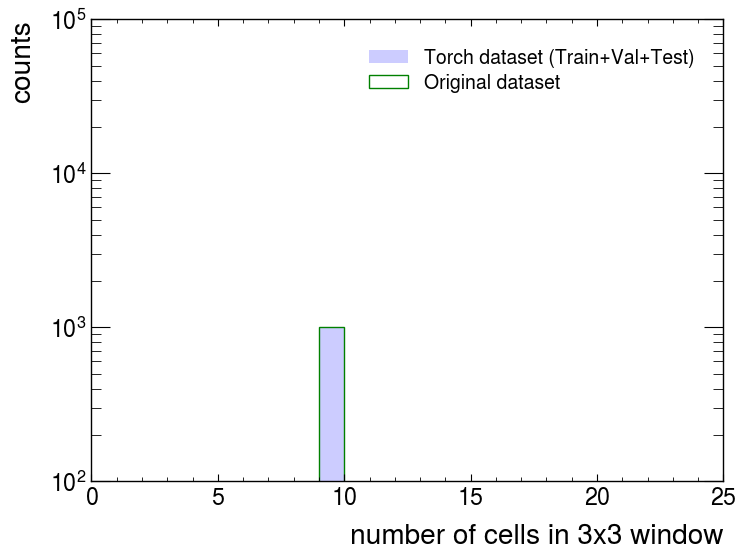

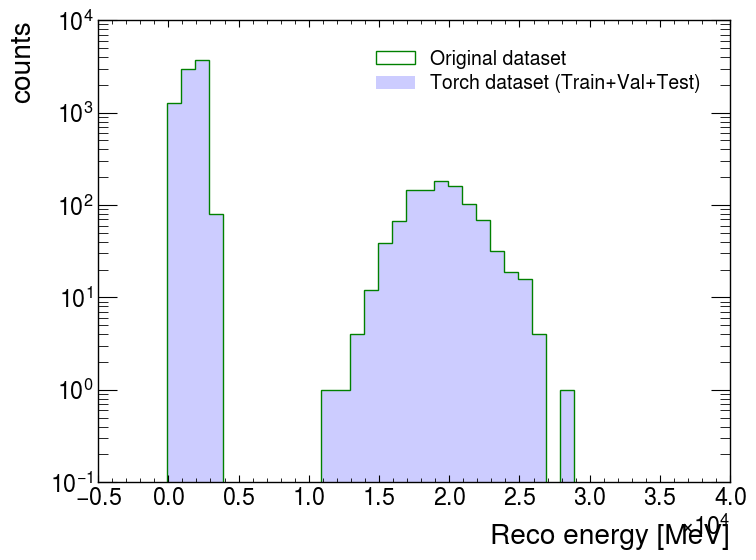

In [ ]:
# datasetTrain     =   XTalkDataset_LZT(data, nEvents=-1, mode='supervised')

ds_winSize = []
for cells in datasetTrain.xte:
    ds_winSize.append(len(cells))
for cells in datasetTest.xte:
    ds_winSize.append(len(cells))
for cells in datasetValid.xte:
    ds_winSize.append(len(cells))

# print(np.where(np.array(cellLen) == 8))
original_ene = []
original_tau = []
original_winSize = []
for evt in data:
    original_ene.append(evt['xtcell_e'][0])
    original_winSize.append(len(evt['xtcell_e'][0]))
    original_tau.append(evt['xtcell_tau'][0])

plt.figure()
binMin   = 0
binMax   = 25
binWidth = 1
# c, xbins = np.histogram([-50,50], bins=40)
xbins = np.arange(binMin, binMax, binWidth)
plt.hist(ds_winSize, bins=xbins, histtype='stepfilled',label='Torch dataset (Train+Val+Test)', alpha=0.2 ,color='blue', density=False)
plt.hist(original_winSize, bins=xbins, histtype='step',label='Original dataset',color='green', density=False)
# plt.hist(np.concatenate(mldata.tof).flatten(), bins =xbins, histtype='step',label='truth',color='blue', density=True)
# lorenzettiText(subText='      Internal - {}'.format('EMB2')+r' and |$\eta$|$<$ {}, e$>${} GeV, $e/\gamma${}$^- \rightarrow$ centroid'.format(1.4,SigmaCut*sampNoise[caloSampling]/1000,'5,20,50'))
plt.yscale('log')
plt.xlabel('number of cells in 3x3 window')
plt.ylabel('counts')
plt.legend()
plt.show()

plt.figure()
binMin   = -100
binMax   = 40000
binWidth = 1000
xbins = np.arange(binMin, binMax, binWidth)
plt.hist(np.concatenate(original_ene).ravel(), bins =xbins, histtype='step',label='Original dataset',color='green', density=False)
plt.hist(np.concatenate((datasetTrain.xte, datasetValid.xte, datasetTest.xte)).ravel(), bins =xbins, histtype='stepfilled', alpha=0.2,label='Torch dataset (Train+Val+Test)',color='blue', density=False)
# plt.hist(np.concatenate(mldata.xtt).flatten(), bins =xbins, histtype='step',label='XT reco',color='red', density=True)
# plt.hist(np.concatenate(mldata.tof).flatten(), bins =xbins, histtype='step',label='truth',color='blue', density=True)
# lorenzettiText(subText='      Internal - {}'.format('EMB2')+r' and |$\eta$|$<$ {}, e$>${} GeV, $e/\gamma${}$^- \rightarrow$ centroid'.format(1.4,SigmaCut*sampNoise[caloSampling]/1000,'5,20,50'))
plt.yscale('log')
plt.xlabel('Reco energy [MeV]')
plt.ylabel('counts')
plt.legend()
plt.show()

plt.figure()
binMin   = -10.
binMax   = 10
binWidth = 1.0
xbins = np.arange(binMin, binMax, binWidth)
plt.hist(np.concatenate(original_tau).ravel(), bins =xbins, histtype='step',label='Original dataset',color='green', density=False)
plt.hist(np.concatenate((datasetTrain.xtt, datasetValid.xtt, datasetTest.xtt)).ravel(), bins =xbins, histtype='stepfilled', alpha=0.2,label='Torch dataset (Train+Val+Test)',color='blue', density=False)
# plt.hist(np.concatenate(mldata.xtt).flatten(), bins =xbins, histtype='step',label='XT reco',color='red', density=True)
# plt.hist(np.concatenate(mldata.tof).flatten(), bins =xbins, histtype='step',label='truth',color='blue', density=True)
# lorenzettiText(subText='      Internal - {}'.format('EMB2')+r' and |$\eta$|$<$ {}, e$>${} GeV, $e/\gamma${}$^- \rightarrow$ centroid'.format(1.4,SigmaCut*sampNoise[caloSampling]/1000,'5,20,50'))
plt.yscale('log')
plt.xlabel('Reco time [{}ns/bin]'.format(binWidth))
plt.ylabel('counts')
plt.legend()
plt.show()

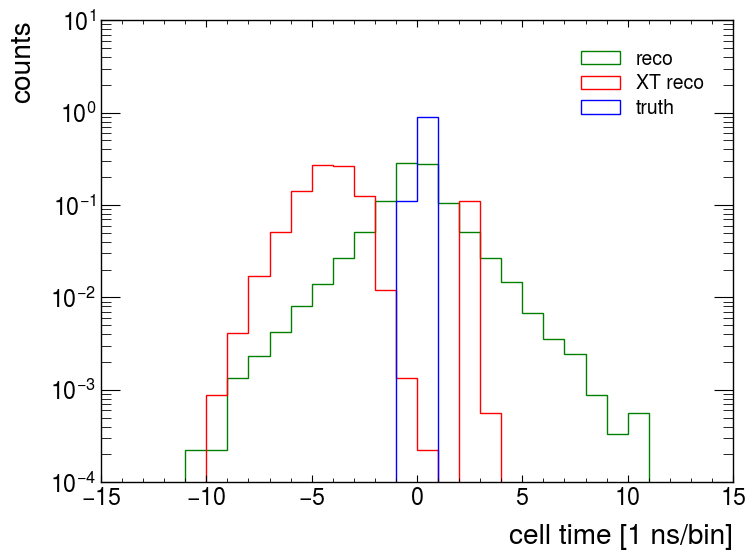

In [ ]:
plt.figure()
binMin   = -12
binMax   = 12
binWidth = 1
# c, xbins = np.histogram([-50,50], bins=40)
xbins = np.arange(binMin, binMax, binWidth)
plt.hist(np.concatenate(mldata.t).flatten(), bins =xbins, histtype='step',label='reco',color='green', density=True)
plt.hist(np.concatenate(mldata.xtt).flatten(), bins =xbins, histtype='step',label='XT reco',color='red', density=True)
plt.hist(np.concatenate(mldata.tof).flatten(), bins =xbins, histtype='step',label='truth',color='blue', density=True)
# lorenzettiText(subText='      Internal - {}'.format('EMB2')+r' and |$\eta$|$<$ {}, e$>${} GeV, $e/\gamma${}$^- \rightarrow$ centroid'.format(1.4,SigmaCut*sampNoise[caloSampling]/1000,'5,20,50'))
plt.yscale('log')
plt.xlabel('cell time [{} ns/bin]'.format(binWidth))
plt.ylabel('counts')
plt.legend()
plt.show()

plt.figure()
binMin   = -100
binMax   = 50000
binWidth = 1000
# c, xbins = np.histogram([-50,50], bins=40)
xbins = np.arange(binMin, binMax, binWidth)
plt.hist(np.concatenate(mldata.e).flatten(), bins =xbins, histtype='step',label='reco',color='green', density=True)
plt.hist(np.concatenate(mldata.xte).flatten(), bins =xbins, histtype='step',label='XT reco',color='red', density=True)
plt.hist(np.concatenate(mldata.edep).flatten(), bins =xbins, histtype='step',label='truth',color='blue', density=True)
# lorenzettiText(subText='      Internal - {}'.format('EMB2')+r' and |$\eta$|$<$ {}, e$>${} GeV, $e/\gamma${}$^- \rightarrow$ centroid'.format(1.4,SigmaCut*sampNoise[caloSampling]/1000,'5,20,50'))
plt.yscale('log')
plt.xlabel('cell energy [{} MeV/bin]'.format(binWidth))
plt.ylabel('counts')
plt.legend()
plt.show()

### 1.3.1 - Training Analysis

#### A) Dataset Size
- For the **loop repetition strategy**, there might be 2 analysis outcomes:
    - 1) Reduce uncertainty from fold index sort (best rep for each pair of fold-iter).
    - 2) Avoid random weights initializing close to a local minima (best iteration for each fold).
    

45-15-15-45
Total events:  5000


Total events:  10000
Total events:  20000
Total events:  30000
Total events:  50000
Total events:  70000
Total events:  150000


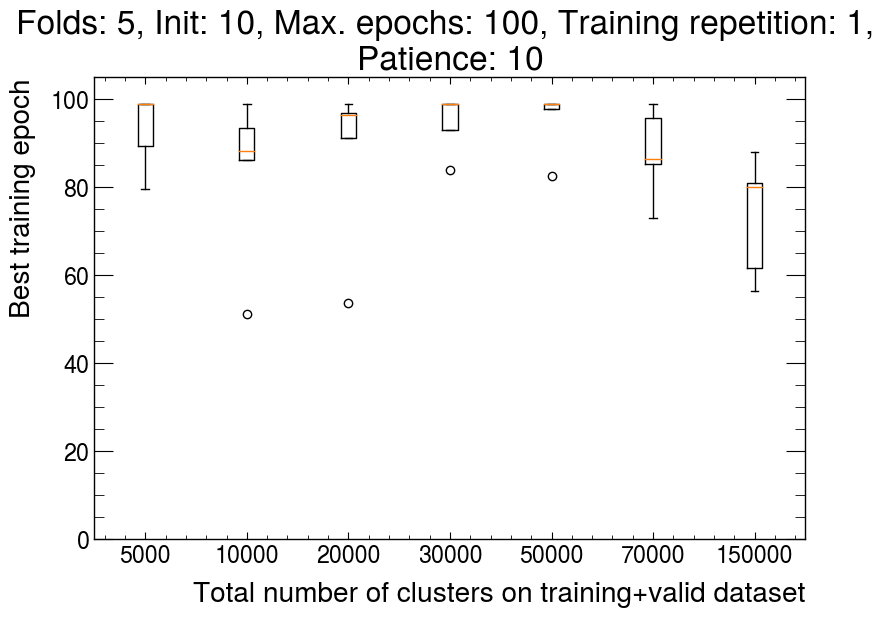

In [ ]:
# matplotlib.use('Agg') #CHANGES THE MATPLOTLIB BACKEND FOR LOOP PLOTS
matplotlib.use('module://ipykernel.pylab.backend_inline')  # show plots

pathLoss        = '/data/atlas/mhufnage/xtalk/ml_training/supervised_lzt/loop_rep_nEvents_33/'

ci_value        = .90 # confidence interval value alpha

modelSignalType = 'nnp'
optimConfig     = 'adam'
trainNeuList    = [45,15,15] # 2layer (24/05/2024)
range_neuInput  = trainNeuList#[45,20,20]
range_neuText   = MLP.neuListToFileText(range_neuInput)
print(range_neuText)

# range_clusSize  = [5000, 10000, 15000, 20000, 25000, 30000, 35000, 40000, 45000, 50000, 60000, 70000, 150000]#, 10000, 20000, 30000, 50000, 75000, 100000, 150000, 200000, 250000]#, 45000]# batch size in clusters
range_clusSize  = [5000, 10000, 20000, 30000, 50000, 70000, 150000]#, 45000]# batch size in clusters
cellMarkers     = ['x','v','^','<','D','o','>','1','+', '^','*']
cellColors      = ['blue','red','black','green','yellow','purple','cyan','pink','orange','blue', 'red']

# config_train = np.load(pathLoss+'config_train_adam_lr0.001_wd1e-05.npz', allow_pickle=True)['config'].tolist()

plotATLAS_loc   = 2
plotFormat      = 'png'#'pdf'#'png'
plotYear        = 2024



fig,ax0  = plt.subplots(figsize=(9,6))
fig1,ax1 = plt.subplots(figsize=(9,6))
fig2,ax2 = plt.subplots(figsize=(9,6))


for idx, total_clusters in enumerate(range_clusSize):
    print('Total events: ',total_clusters)

    # fig,ax0 = plt.subplots(figsize=(14,8))

    config_train = np.load(pathLoss+'config_train_nEvts{}_{}_{}_neu{}.npz'.format(total_clusters, modelSignalType, optimConfig, range_neuText), allow_pickle=True)['config'].tolist()
    # config_train_filename = pathLoss+'config_train_nEvts{}_{}_{}_neu{}.npz'.format(total_clusters, modelSignalType, optimConfig, range_neuText)
    
    # with np.load(config_train_filename, allow_pickle=True)['config'].tolist() as config_train:

    trainRatio   = config_train['train_ratio']
    batch_size   = config_train['batch_size']
    max_epochs   = config_train['max_epochs']
    patience     = config_train['patience']
    max_iter     = config_train['max_init']
    k            = config_train['kFolds']
    max_rep      = 1#config_train['max_rep']

    clusters_per_fold_train = round((trainRatio*total_clusters)/k)
    clusters_per_fold_val   = round(((1-trainRatio)*total_clusters)/k)

    # lossAllIterations       = np.zeros((max_epochs, max_iter),dtype=float)
    lossAllIterations       = np.zeros((k, max_iter, max_rep),dtype=float)
    bestEpochAllIterations  = np.zeros((k, max_iter, max_rep),dtype=float)
    trainTimehAllIterations = np.zeros((k, max_iter, max_rep),dtype=float)

    for rep in range(max_rep):
        for fold in range(k):
            for it in range(max_iter):
                    
                train_logging_dict  = np.load(pathLoss+'rep{}/loss_nEvts{}_{}_rep{}_fold{}_iter{}_neu{}_batch{}.npz'.format(rep, total_clusters, modelSignalType, rep, fold, it, range_neuText, batch_size),allow_pickle=True)['loss'].tolist()
                # myFile = pathLoss+'rep{}/loss_nEvts{}_{}_rep{}_fold{}_iter{}_neu{}_batch{}.npz'.format(rep, total_clusters, modelSignalType, rep, fold, it, range_neuText, batch_size)
                # with np.load(myFile, allow_pickle=True)['loss'].tolist() as train_logging_dict:
                best_epoch          = train_logging_dict['best_epoch']
                # lossAllIterations[0:len(train_logging_dict['val_loss']),it] = np.array(train_logging_dict['val_loss'])
                
                lossAllIterations[fold,it,rep]          = np.array(train_logging_dict['val_loss'])[best_epoch]
                bestEpochAllIterations[fold,it,rep]     = train_logging_dict['best_epoch']
                trainTimehAllIterations[fold,it,rep]    = train_logging_dict['train_time']/60 # seconds to minutes
                # if it < 9:
                #     ax0.plot(epochs ,train_logging_dict['val_loss'] , '--',lw=1.1, c=cellColors[idx])
                # else:
                #     ax0.plot(epochs ,train_logging_dict['val_loss'] , '--',lw=1.1, c=cellColors[idx], label='train  clus. {}'.format(clusters_per_fold_train))
            

    val_loss        = np.mean(lossAllIterations, axis=(2,1)) # flat max_rep and max_iter, remaining only the k-folds
    avg_epochs      = np.mean(bestEpochAllIterations, axis=(2,1)) # flat max_rep and max_iter, remaining only the k-folds
    avg_train_time  = np.mean(trainTimehAllIterations, axis=(2,1)) # flat max_rep and max_iter, remaining only the k-folds
    
    ax0.boxplot(val_loss, positions=[idx+1])    
    ax1.boxplot(avg_epochs, positions=[idx+1])
    ax2.boxplot(avg_train_time, positions=[idx+1])
    
    # ax0.boxplot(val_loss, positions=[total_clusters])

    # meanLoss = np.mean(lossAllIterations, axis=1)
    # stdLoss  = np.std(lossAllIterations, axis=1)
    # confIntLower, confIntUpper, lowErrorBar, upperErrorBar  = confInterval(alfa=ci_value, data=lossAllIterations)
    # epochs   = range(1,len(meanLoss)+1)
    

    # if total_clusters==1000:
    #     a = confIntLower
    #     b = confIntUpper
    #     c = lossAllIterations
    
    # ax0.plot(epochs ,meanLoss , '-',lw=1.1, c=cellColors[idx], label='{} train / {} val. clusters'.format(clusters_per_fold_train,clusters_per_fold_val))
    # ax0.fill_between(epochs, confIntLower, confIntUpper, alpha=0.4 , facecolor=cellColors[idx])
    # ax0.fill_between(epochs, meanLoss-stdLoss, meanLoss+stdLoss, alpha=0.4 , facecolor=cellColors[idx])

# plt.xlabel('Epochs')
# plt.ylabel('Validation Samples Loss')
# plt.legend(fontsize=17)
# hep.atlas.label(data=True,paper=False,year=plotYear, loc=plotATLAS_loc)
# # ax0.text(s='Train clusters: {}\nVal. Clusters: {}\nBatch: {}'.format(clusters_per_fold_train, clusters_per_fold_val, batch_size),x=0.2,y=0.1, transform=ax0.transAxes, fontsize=14, ha='left', color='black')
# # ax0.text(s='Train clusters: {}\nVal. Clusters: {}'.format(clusters_per_fold_train, clusters_per_fold_val),x=0.1,y=0.1, transform=ax0.transAxes, fontsize=14, ha='left', color='black')
# ax0.text(s='CI: {}%\nInitializations: {}'.format(int(ci_value*100), max_iter),x=0.05,y=0.025, transform=ax0.transAxes, fontsize=14, ha='left', color='black')
# plt.yscale('log')
# # plt.ylim([1e-12, 1])

# # nLay            = config_train['nLayers']
# # neuIn           = config_train['nNeuronsInput']
# # bn              = config_train['bn_neurons']

# # hep.save_variations(fig, pathLoss+'datasetAnalysis_lossPlotAllCells_fold{}_iter{}_neuIn{}_nLay{}_bn{}_.{}'.format(fold, it, neuIn, nLay, bn, plotFormat),text_list=['Preliminary', 'Work in progress'])
# # hep.save_variations(fig, pathLoss+'datasetAnalysis_allLines_lossPlotAllCells_fold{}_iter{}_neuIn{}_nLay{}_bn{}_.{}'.format(fold, it, neuIn, nLay, bn, plotFormat),text_list=['Preliminary', 'Work in progress'])
# # plt.close()
# ax0.set_xticks([i+1 for i in range(len(range_clusSize))],[range_clusSize])
ax0.set_xticklabels(range_clusSize)
ax0.set_title("Folds: {}, Init: {}, Max. epochs: {}, Training repetition: {}, \nPatience: {}".format(k, max_iter, max_epochs, max_rep, patience))
ax0.set_xlabel("Total number of clusters on training+valid dataset")
ax0.set_ylabel("MSE: validation loss")

ax1.set_xticklabels(range_clusSize)
ax1.set_title("Folds: {}, Init: {}, Max. epochs: {}, Training repetition: {}, \nPatience: {}".format(k, max_iter, max_epochs, max_rep, patience))
ax1.set_xlabel("Total number of clusters on training+valid dataset")
ax1.set_ylabel("Best training epoch")
ax1.set_ylim(0,105)

ax2.set_xticklabels(range_clusSize)
ax2.set_title("Folds: {}, Init: {}, Max. epochs: {}, Training repetition: {}, \nPatience: {}".format(k, max_iter, max_epochs, max_rep, patience))
ax2.set_xlabel("Total number of clusters on training+valid dataset")
ax2.set_ylabel("Training time (min)")

plt.show(fig)
plt.show(fig1)
plt.show(fig2)



##### A.1) Dataset Size - No repetition

In [ ]:

def plot_train_val_loss_compare(theSeries, theRange, pathLossMainFolder, rangeType='Total number of clusters on training+valid dataset'):
    '''
    listParam1 : its the series that will be show in the plot (ML Model)
    listParam2 : the range within the series will be drawn (Events, layers, ...)
    '''
    matplotlib.use('Agg') #CHANGES THE MATPLOTLIB BACKEND FOR LOOP PLOTS

    bpShifts        = [0.1,-0.1]

    fig,ax0 = plt.subplots(figsize=(9,6))
    fig1,ax1 = plt.subplots(figsize=(9,6))
    fig2,ax2 = plt.subplots(figsize=(9,6))
        
    for netIdx, trainNeuList in enumerate(theSeries):
        range_neuInput  = trainNeuList#[45,20,20]
        range_neuText   = MLP.neuListToFileText(range_neuInput)

        pathLoss = pathLossMainFolder+'/model{}/'.format(range_neuText)

        ci_value        = .90 # confidence interval value alpha

        modelSignalType = 'nnp'
        optimConfig     = 'adam'
        # trainNeuList    = [45,15,15] # 2layer (24/05/2024)
        # range_neuInput  = trainNeuList#[45,20,20]
        range_neuText   = MLP.neuListToFileText(range_neuInput)
        print(range_neuText)

        cellMarkers     = ['x','v','^','<','D','o','>','1','+', '^','*']
        cellColors      = ['blue','red','black','green','yellow','purple','cyan','pink','orange','blue', 'red']

        for idx, total_clusters in enumerate(theRange):
            print('Total events: ',total_clusters)

            # fig,ax0 = plt.subplots(figsize=(14,8))

            # config_train = np.load(pathLoss+'config_train_nEvts{}_{}_{}_neu{}.npz'.format(total_clusters, modelSignalType, optimConfig, range_neuText), allow_pickle=True)['config'].tolist()
            config_file_name = pathLoss+'config_train_nEvts{}_{}_{}_neu{}.npz'.format(total_clusters, modelSignalType, optimConfig, range_neuText)
            with np.load(config_file_name, allow_pickle=True) as config_train_dict:
                config_train = config_train_dict['config'].tolist()
                # config_train_filename = pathLoss+'config_train_nEvts{}_{}_{}_neu{}.npz'.format(total_clusters, modelSignalType, optimConfig, range_neuText)
                
                # with np.load(config_train_filename, allow_pickle=True)['config'].tolist() as config_train:

                trainRatio   = config_train['train_ratio']
                batch_size   = config_train['train_args']['batch_size']
                max_epochs   = config_train['train_args']['nEpochs']
                patience     = config_train['train_args']['patience']
                max_iter     = config_train['train_args']['nIter']
                k            = config_train['train_args']['kFolds']
                num_proc     = config_train['train_args']['num_processes']

                clusters_per_fold_train = round((trainRatio*total_clusters)/k)
                clusters_per_fold_val   = round(((1-trainRatio)*total_clusters)/k)

                # lossAllIterations       = np.zeros((max_epochs, max_iter),dtype=float)
                lossAllIterations       = np.zeros((k, max_iter),dtype=float)
                bestEpochAllIterations  = np.zeros((k, max_iter),dtype=float)
                trainTimehAllIterations = np.zeros((k, max_iter),dtype=float)

                # for rep in range(max_rep):
                for fold in range(k):
                    for it in range(max_iter):
                        train_logging_dict_name = pathLoss+'lossMP_nEvts{}_{}_fold{}_iter{}_neu{}_batch{}.npz'.format(total_clusters, modelSignalType, fold, it, range_neuText, batch_size)
                        with np.load(train_logging_dict_name, allow_pickle=True) as train_logging_file:
                            train_logging_dict = train_logging_file['loss'].tolist()
                            # train_logging_dict  = np.load(pathLoss+'lossMP_nEvts{}_{}_fold{}_iter{}_neu{}_batch{}.npz'.format(total_clusters, modelSignalType, fold, it, range_neuText, batch_size),allow_pickle=True)['loss'].tolist()
                        
                            best_epoch          = train_logging_dict['best_epoch']
                            
                            val_loss_epochs = train_logging_dict['val_loss_history'][num_proc-1].numpy()
                            val_loss = val_loss_epochs[ val_loss_epochs != 0.][int(best_epoch[num_proc-1])]
                            lossAllIterations[fold,it]          = val_loss

                            bestEpochAllIterations[fold,it]     = train_logging_dict['best_epoch']
                            trainTimehAllIterations[fold,it]    = train_logging_dict['train_time'][num_proc-1]/60 # seconds to minutes


                best_val_loss    = lossAllIterations.min(axis=1)
                best_epochs      = bestEpochAllIterations.min(axis=1)
                best_train_time  = trainTimehAllIterations.min(axis=1)
                
                ax0.boxplot(best_val_loss, patch_artist=True,   positions=[idx+1-bpShifts[netIdx]], boxprops=dict(facecolor=cellColors[netIdx], color=cellColors[netIdx]))
                ax1.boxplot(best_epochs, patch_artist=True,     positions=[idx+1-bpShifts[netIdx]], boxprops=dict(facecolor=cellColors[netIdx], color=cellColors[netIdx]))
                ax2.boxplot(best_train_time, patch_artist=True, positions=[idx+1-bpShifts[netIdx]], boxprops=dict(facecolor=cellColors[netIdx], color=cellColors[netIdx]))
            
    # ax0.set_xticks([i+1 for i in range(len(range_clusSize))],[range_clusSize])
    ax0.set_xticks(np.arange(1,len(theRange)+1))
    ax0.set_xticklabels(theRange)
    # ax1.set_xticklabels([f'{label}%' for label in range_clusSize])
    ax0.set_title("Folds: {}, Init: {}, Max. epochs: {}, \nPatience: {}".format(k, max_iter, max_epochs, patience))
    # ax0.set_xlabel("Total {} on training+valid dataset".format(theRange))
    ax0.set_xlabel("{}".format(rangeType))
    ax0.set_ylabel("MSE: validation loss")


    ax1.set_xticks(np.arange(1,len(theRange)+1))
    ax1.set_xticklabels(theRange)
    # ax1.set_xticklabels([f'{label}%' for label in range_clusSize])
    ax1.set_title("Folds: {}, Init: {}, Max. epochs: {}, \nPatience: {}".format(k, max_iter, max_epochs, patience))
    # ax1.set_xlabel("Total number of clusters on training+valid dataset")
    ax1.set_xlabel("{}".format(rangeType))
    ax1.set_ylabel("Best training epoch")
    # ax1.set_ylim(0,105)

    ax2.set_xticks(np.arange(1,len(theRange)+1))
    ax2.set_xticklabels(theRange)
    # ax1.set_xticklabels([f'{label}%' for label in range_clusSize])
    ax2.set_title("Folds: {}, Init: {}, Max. epochs: {}, \nPatience: {}".format(k, max_iter, max_epochs, patience))
    # ax2.set_xlabel("Total number of clusters on training+valid dataset")
    ax2.set_xlabel("{}".format(rangeType))
    ax2.set_ylabel("Training time (min)")


    outputPathAlias = '/'.join(pathLoss.split('/')[:-2])+'/plots_train_loss/'
    if not(os.path.isdir(outputPathAlias)):
        os.mkdir(outputPathAlias)

    fig.savefig(outputPathAlias+'loss_valid_compare.png', bbox_inches='tight')
    fig1.savefig(outputPathAlias+'epochs_valid_compare.png', bbox_inches='tight')
    fig2.savefig(outputPathAlias+'trainTime_valid_compare.png', bbox_inches='tight')

    plt.close(fig)
    plt.close(fig1)
    plt.close(fig2)

trainNeuLists   = [[45,15,15]]#, [45,100,100]] # 2layer (24/05/2024)
range_clusSize  = [5000, 10000, 20000, 30000, 50000, 70000, 100000]#, 45000]# batch size in clusters
pathLoss        = '/data/atlas/mhufnage/xtalk/ml_training/supervised_lzt/loop_nEvents_33_new_10folds'
plot_train_val_loss_compare(theSeries=trainNeuLists, 
                            theRange=range_clusSize, 
                            pathLossMainFolder=pathLoss, 
                            rangeType='Total number of clusters on training+valid dataset')

45-15-15-45
Total events:  5000
Total events:  10000
Total events:  20000
Total events:  30000
Total events:  50000
Total events:  70000
Total events:  100000


AttributeError: 'AxesSubplot' object has no attribute 'save_fig'

#### B) Test Plots
- run_test_mode.py:
    - Load dataset for test
    - Create results storage for pulse, timing and energy
    - Load model parameters
    - Apply reconstruction to models output (pulses with estimated values, without crosstalk)
    - calculate metrics for selecting hyperparameters
- Here:
    - Plot results
    

In [2]:
from helper_lib.test_helper import loadTestDataset_LorenzettiSupervised, getTestResutlsDict, loadTorchModelForTest 
from helper_lib.auxiliaryFunctions import confInterval, getBins
from math import log2

from scipy.spatial import distance
from sklearn.metrics import mean_squared_error, mean_absolute_error

from helper_lib.test_helper import cellArrayIndexToClusterPositionIndex, plot_energy_scatter_LZT, plot_time_scatter_LZT, plot_train_val_loss_compare_nEvents, plot_train_val_loss_compare_Neurons

conditions = {
'nEvents':         50000, # <--- it is the total events to feed KFold_split into (train+valid)+(test).
'SigmaCut':        1,
'etaCut':          1.4,
'caloSampling':    'EM2',#CaloSampling.EMB2,
'etaSize':         3,
'phiSize':         3,
'nSamples':        5,
'dumpCells':       True,
'bDumpWindowOnly': True,
'bNoEneCut':       True,
'XTalk_ind':       1.1,
'XTalk_cap':       0.0,
'XTalkLevel':      'L = 1.1%, C = 0.0%',
}



In [3]:
# dictKeyName     = 'LayerLoop'
# trainNeuLists   = [[45,10,10], [45,20,20],[45,45,45],[45,60,60],[45,75,75],[45,100,100],[45,120,120],[45,150,150],[45,200,200],[45,250,250]]  # hyperparameter1
# theRange       = [10,20,45,60,75,100,120,150,200,250]
# nEvents         = 50000#, 45000]# batch size in clusters
# pathLoss        = '/data/atlas/mhufnage/xtalk/ml_training/supervised_lzt/loop_model_2layer_33_10folds'

# Loop 2: neurons 1 layer
# trainNeuLists   = [[45,200]]#, [45,20],[45,45],[45,60],[45,75],[45,100],[45,120],[45,150],[45,200],[45,250]]  # hyperparameter1
# theSeries       = [10,20,45,60,75,100,120,150,200,250] # hyperparameter2
# dictKeyName     = 'LayerLoop'
# dataPath        = '/data/atlas/mhufnage/xtalk/ml_training/supervised_lzt/loop_model_1Layer_33_10folds/'
# range_clusSize  = [50000]# hyperparameter2

# Loops 3: neurons 2 layers
trainNeuLists   = [[45,250,250]]# [45,20,20],[45,45,45],[45,60,60],[45,75,75],[45,100,100],[45,120,120],[45,150,150],[45,200,200],[45,250,250]]  # hyperparameter1
theSeries       = [10,20,45,60,75,100,120,150,200,250] # hyperparameter2
# nEvents         = 50000
range_clusSize  = [50000]# hyperparameter2
dictKeyName     = 'LayerLoop'
etaSize         = conditions['etaSize']
phiSize         = conditions['phiSize']
max_iter        = 10
kFolds          = 10
dataPath        = '/data/atlas/mhufnage/xtalk/ml_training/supervised_lzt/loop_model_2layer_33_10folds/'


bpShifts        = [0.1,-0.1]
max_iter        = 10
kFolds          = 10
cellMarkers     = ['x','v','^','<','D','o','>','1','+', '^','*']
cellColors      = ['blue','red','black','green','yellow','purple','cyan','pink','orange','blue', 'red']
plotATLAS_loc   = 2
plotFormat      = 'png'#'pdf'#'png'
plotYear        = 2024

xbins           = 100

plotFormat      = 'pdf'#'png'
labelDistX      = 17
fontSize        = 32

ci_value        = .90 # confidence interval value alpha
doZoom          = True

# Load test dataset
try:
    if (len(datasetTest) != conditions['nEvents']):
        raise Exception('Must load dataset test...')
except:
    dataloaderTest, datasetTest = loadTestDataset_LorenzettiSupervised(conditions)

zoomText = ''
if doZoom:
    zoomText='_zoom'

plt.figure()
for netIdx, trainNeuList in enumerate(trainNeuLists):
    range_neuInput  = trainNeuList
    range_neuText   = MLP.neuListToFileText(range_neuInput)
    print('\tModel: {}, Test events: {}'.format(range_neuText, len(datasetTest)))
    
    for nEvents in range_clusSize:
        # print('\t\tTrained Events: {}'.format(nEvents))
        enefilename     = dataPath+'metrics/{}_nEvents{}_eneTestDict.npz'.format(range_neuText, nEvents)
        timefilename    = dataPath+'metrics/{}_nEvents{}_timeTestDict.npz'.format(range_neuText, nEvents)
        # samplesfilename = dataPath+'{}_nEvents{}_samplesTestDict.npz'.format(range_neuText, nEvents)
    
        with np.load(enefilename,allow_pickle=True) as eneTestDict, \
            np.load(timefilename,allow_pickle=True) as timeTestDict:

                
            for it in range(0,max_iter):
                for fold in range(0,kFolds):
                    if not(it==0 and fold==0):
                        continue
                    print('Fold {}, iteration {}'.format(it, fold))
                    
                    reco_ene = eneTestDict['ene'].tolist()[dictKeyName]['it_'+str(it)]['fold_'+str(fold)]
                    reco_time = timeTestDict['time'].tolist()[dictKeyName]['it_'+str(it)]['fold_'+str(fold)]
                    
                    print("Net: {}".format(range_neuText))
    
    # reco_ene_all = []
    # reco_time_all = []
    # for key in reco_ene.keys():
    #     reco_ene_all = reco_ene_all + reco_ene[key]
    #     reco_time_all = reco_time_all + reco_time[key]
    # reco_ene_np = np.array(reco_ene_all)
    # reco_time_np = np.array(reco_time_all)

    # ene_value    = 0
    # e_cut_ml     = np.where(reco_ene_np > ene_value)[0] # MeV
    # e_cut_target = np.where(datasetTest.e.flatten().numpy() > ene_value)[0] # MeV

    
    # plt.plot(datasetTest.xte.flatten().numpy()[e_cut_target]/1000, datasetTest.xtt.flatten().numpy()[e_cut_target],'.')
    # plt.plot(datasetTest.e.flatten().numpy()[e_cut_target]/1000, datasetTest.t.flatten().numpy()[e_cut_target],'x')
#     plt.plot(reco_ene_np[e_cut_ml]/1000, reco_time_np[e_cut_ml],'.',label=range_neuText)

# plt.legend()
# plt.show()




[XTalkDataset_LZT_FromROOT] Event idx 0/50000
[XTalkDataset_LZT_FromROOT] Event idx 10000/50000
[XTalkDataset_LZT_FromROOT] Event idx 20000/50000
[XTalkDataset_LZT_FromROOT] Event idx 30000/50000
[XTalkDataset_LZT_FromROOT] Event idx 40000/50000
[TestSupervised] Total events loaded [DS25~DS30]: 50000
	Model: 45-250-250-45, Test events: 50000
Fold 0, iteration 0
Net: 45-250-250-45


<Figure size 800x600 with 0 Axes>

In [4]:
reco_ene_all = []
reco_time_all = []
for key in reco_ene.keys():
    reco_ene_all = reco_ene_all + reco_ene[key]
    reco_time_all = reco_time_all + reco_time[key]
reco_ene_np = np.array(reco_ene_all)
reco_time_np = np.array(reco_time_all)



In [11]:
ene_value    = 0
e_cut_ml     = np.where(reco_ene_np > ene_value)[0] # MeV
e_cut_target = np.where(datasetTest.e.flatten().numpy() > ene_value)[0] # MeV

plt.figure()
plt.plot(datasetTest.xte.flatten().numpy()[e_cut_target]/1000, datasetTest.xtt.flatten().numpy()[e_cut_target],'.', label='Signal with XT')
plt.plot(datasetTest.e.flatten().numpy()[e_cut_target]/1000, datasetTest.t.flatten().numpy()[e_cut_target],'x', label='Signal w/o XT')
plt.plot(reco_ene_np[e_cut_ml]/1000, reco_time_np[e_cut_ml],'.', label='MLP output '+range_neuText)
plt.xlabel('3x3 Cluster cells Energy [GeV]')
plt.ylabel('3x3 Cluster cell Timing [ns]')
plt.legend()
plt.show()




In [29]:
#
# New functions to be added to 'auxiliaryFunctions.py' helper file.
#

def getIndexesOfArrayThatBelongToEachBin(x, theBins):
    
    hist, xedges = np.histogram(x, bins=theBins)
    
    indices_in_bins = []
    
    for i in range(len(xedges)-1):
        # for j in range(len(yedges)-1):
            
        # Create a boolean mask to identify data points within the current bin
        in_bin = (xedges[i] <= x) & (x < xedges[i+1]) 
                #   (yedges[j] <= y) & (y < yedges[j+1]))
        # in_bin = ((xedges[i] <= x) & (x < xedges[i+1]) & 
        #           (yedges[j] <= y) & (y < yedges[j+1]))
        
        # Find the indices of data points within the current bin
        indices = np.where(in_bin)[0] 
        
        # Append the indices to the 'indices_in_bins' list
        indices_in_bins.append(indices)
    
    return indices_in_bins


def LZT_energyTimeProfile(energy_array, time_array, energy_bins, errorBarMethod='std', e_cut=0):
    '''
    Input: energy array (GeV), time array (ns), energy bins (GeV)
    '''
    # e_cut_idx     = np.where(energy_array >= e_cut)[0] # MeV
    
    
    
    indices_in_bins = getIndexesOfArrayThatBelongToEachBin(energy_array, energy_bins)
    
    # print(np.shape(e_cut_idx), np.shape(energy_array[e_cut_idx]))
    
    ene_mean    = []
    time_mean   = []
    ene_uncert  = []
    time_uncert = []
    
    # loop over set of indexes for each bin (energy and time arrays must be alligned!!!!)
    for k in range(0, len(indices_in_bins)):
        
        # if len(indices_in_bins[k]) != 0:
        #     print(np.shape(indices_in_bins[k]), min(indices_in_bins[k]), max(indices_in_bins[k]))
        
        ene_mean.append( np.mean(energy_array[indices_in_bins[k]]) )
        time_mean.append( np.mean(time_array[indices_in_bins[k]]) )
        ene_uncert.append( energy_bins[1] - energy_bins[0] )
        
        if errorBarMethod=='std':
            time_uncert.append( np.std(time_array[indices_in_bins[k]]) )
        if errorBarMethod=='poisson':
            time_uncert.append(scipy.stats.poisson.interval(0.95, time_array[indices_in_bins[k]]))
    
    
    
    return ene_mean, time_mean, ene_uncert, time_uncert



In [31]:
ene_bins    = getBins(0,42,2)
time_bins   = getBins(-20,20,1)


# indices_in_bins = getIndexesOfArrayThatBelongToEachBin(reco_ene_np/1000, ene_bins)
ene_mean, time_mean, ene_unc, time_unc                              = LZT_energyTimeProfile(reco_ene_np/1000, reco_time_np, ene_bins, 5)
ene_mean_target, time_mean_target, ene_unc_target, time_unc_target  = LZT_energyTimeProfile(datasetTest.e.flatten().numpy()/1000, datasetTest.t.flatten().numpy(), ene_bins, 5)
ene_mean_xt, time_mean_xt, ene_unc_xt, time_unc_xt                  = LZT_energyTimeProfile(datasetTest.xte.flatten().numpy()/1000, datasetTest.xtt.flatten().numpy(), ene_bins, 5)

/home/mhufnage/lorenzetti/.venv/lib64/python3.6/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/mhufnage/lorenzetti/.venv/lib64/python3.6/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/mhufnage/lorenzetti/.venv/lib64/python3.6/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


In [24]:
# plt.hist(reco_bins_idx)
plot_line_type = 'o'
plt.plot(ene_mean, time_mean, plot_line_type, label='MLP output '+range_neuText)
plt.plot(ene_mean_target, time_mean_target, plot_line_type, label='Target (No XT)')
# plt.plot(ene_mean_xt, time_mean_xt, plot_line_type, label='Input with XT')
# plt.axis([5,35,-2.5,2])
plt.legend()
plt.xlabel('Energy [GeV]')
plt.ylabel('Time [ns]')
plt.title('Mean timing per energy range (1 GeV bin)')
plt.show()

# plt.hist(reco_bins_idx)
plot_line_type = 'o'
plt.errorbar(ene_mean, time_mean, , label='MLP output '+range_neuText)
plt.plot(ene_mean_target, time_mean_target, plot_line_type, label='Target (No XT)')
# plt.plot(ene_mean_xt, time_mean_xt, plot_line_type, label='Input with XT')
# plt.axis([5,35,-2.5,2])
plt.legend()
plt.xlabel('Energy [GeV]')
plt.ylabel('Time [ns]')
plt.title('Mean timing per energy range (1 GeV bin)')
plt.show()

In [7]:
   
def plot_energy_hist_LZT(dataset, reco_ene_dict, scale, figPath, labelDistX, bShowPlots=False, bZoomAxis=False, totalEnergy=50000):
    if bShowPlots:
        matplotlib.use('module://ipykernel.pylab.backend_inline')  # show plots
    else:
        matplotlib.use('Agg') #CHANGES THE MATPLOTLIB BACKEND FOR LOOP PLOTS
    
    ## Selecting scale for plot (mev or gev)
    scaleCnt = 1
    isMevData = np.max(dataset.edep.detach().numpy()[:,4]) >= 500
    
    textScale = ''
    if (scale=='MeV') and not(isMevData):        
        scaleCnt = 1000
    elif (scale=='GeV') and isMevData:
        scaleCnt = 1/1000
    else:
        textScale = 'MeV'
        if not(isMevData):
            textScale='GeV'
            scaleCnt = 1/1000
        scale=textScale
        print('scale not selected. Choosing {}, because isMevData={}. Scaling factor: {}.'.format(textScale, isMevData, scaleCnt))
    
    phiSize     = dataset.conditions['phiSize']
    etaSize     = dataset.conditions['etaSize']
    plotMapSize = phiSize*etaSize
    
    fig = plt.figure(figsize=(30,30))
    
    for cell in range(0,phiSize*etaSize):
        cellClusPos = cellArrayIndexToClusterPositionIndex(cell, bSingleMode=True)
        
        eneTargetList = dataset.edep.detach().numpy()[:,cell]*scaleCnt
        eneOutputList = np.array(reco_ene_dict['cell_{}'.format(cell)], dtype=object)*scaleCnt
        
        # print(type(eneOutputList), np.shape(eneOutputList), type(eneTargetList), np.shape(eneTargetList))
        
        xbins = getBins(-2000,totalEnergy,100)
        if scale=='MeV':
            xbins = getBins(-2000,totalEnergy,100)
        if scale=='GeV':
            xbins = getBins(-2,totalEnergy*scaleCnt,0.1)
            
        max_reco = max(max(eneTargetList),max(eneOutputList))
        min_reco = min(min(eneTargetList), min(eneOutputList))
        # print(min_reco, max_reco, xbins)
        
        # print(np.shape(xbins), np.shape(eneTargetList), np.shape(eneOutputList))
        
        stat_error1 = 'Target - ML output'+'\n'+r'$\mu={:.3}, \sigma={:.3}$'.format(np.mean(eneErrorList),np.std(eneErrorList))
        stat_error2 = 'Truth - ML output'+'\n'+r'$\mu={:.3}, \sigma={:.3}$'.format(np.mean(eneErrorOutput),np.std(eneErrorOutput))
        stat_error3 = 'Truth - Target'+'\n'+r'$\mu={:.3}, \sigma={:.3}$'.format(np.mean(eneErrorTarget),np.std(eneErrorTarget))
        plt.hist(eneErrorList, bins=xbins, histtype='step',ec='black', label=stat_error1)
        plt.hist(eneErrorOutput, bins=xbins, histtype='step', ec='blue', label=stat_error2)
        plt.hist(eneErrorTarget, bins=xbins, histtype='step', ec='green', label=stat_error3)
        plt.xlabel('Energy reconstruction error [GeV] 50MeV/bin', labelpad=labelDistX)
        plt.ylabel('Counts')
        plt.yscale('log')
        plt.legend()
        # hep.atlas.label(data=True,paper=False,year=plotYear, loc=plotATLAS_loc)
        lorenzettiText()
        
        if scale=='MeV':
            plt.xlabel('Cluster cell energy [MeV]', labelpad=labelDistX)
            plt.ylabel('Reconstructed cluster cell energy [MeV] 100 MeV/bin')
        if scale=='GeV':
            plt.xlabel('Cluster cell energy [GeV]', labelpad=labelDistX)
            plt.ylabel('Reconstructed cluster cell energy [GeV] 100 MeV/bin')
        
        plt.colorbar()
        if bZoomAxis:
            plt.xlim([min_reco, max_reco])
            plt.ylim([min_reco, max_reco])
        # hep.atlas.label(data=True,paper=False,year=plotYear, loc=plotATLAS_loc)
        lorenzettiText()
    
    plt.savefig(figPath)
    plt.close(fig)
    

###############################################################

def plot_train_val_loss_compare(theSeries, theRange, nEventsInTraining, pathLossMainFolder, rangeType='Total number of clusters on training+valid dataset', doublePlotsPerSeriesItem=False):
    '''
    listParam1 : its the series that will be show in the plot (ML Model)
    listParam2 : the range within the series will be drawn (Events, layers, ...)
    '''
    matplotlib.use('Agg') #CHANGES THE MATPLOTLIB BACKEND FOR LOOP PLOTS

    if doublePlotsPerSeriesItem:
        bpShifts    = [0.1,-0.1]
    else:
        bpShifts    = 0.0

    fig,ax0 = plt.subplots(figsize=(9,6))
    fig1,ax1 = plt.subplots(figsize=(9,6))
    fig2,ax2 = plt.subplots(figsize=(9,6))
        
    for netIdx, trainNeuList in enumerate(theSeries):
        range_neuInput  = trainNeuList#[45,20,20]
        range_neuText   = MLP.neuListToFileText(range_neuInput)

        pathLoss = pathLossMainFolder+'/{}/'.format(range_neuText)

        ci_value        = .90 # confidence interval value alpha

        modelSignalType = 'nnp'
        optimConfig     = 'adam'
        # trainNeuList    = [45,15,15] # 2layer (24/05/2024)
        # range_neuInput  = trainNeuList#[45,20,20]
        range_neuText   = MLP.neuListToFileText(range_neuInput)
        print(range_neuText)

        cellMarkers     = ['x','v','^','<','D','o','>','1','+', '^','*']
        cellColors      = ['blue','red','black','green','yellow','purple','cyan','pink','orange','blue', 'red']

        print('Total events in training:: ',nEventsInTraining)
        # for idx, total_clusters in enumerate(theRange):
        # for idx, rangeValue in enumerate(theRange):
            

        # fig,ax0 = plt.subplots(figsize=(14,8))

        # config_train = np.load(pathLoss+'config_train_nEvts{}_{}_{}_neu{}.npz'.format(total_clusters, modelSignalType, optimConfig, range_neuText), allow_pickle=True)['config'].tolist()
        config_file_name = pathLoss+'config_train_nEvts{}_{}_{}_neu{}.npz'.format(nEventsInTraining, modelSignalType, optimConfig, range_neuText)
        with np.load(config_file_name, allow_pickle=True) as config_train_dict:
            config_train = config_train_dict['config'].tolist()
            # config_train_filename = pathLoss+'config_train_nEvts{}_{}_{}_neu{}.npz'.format(total_clusters, modelSignalType, optimConfig, range_neuText)
            
            # with np.load(config_train_filename, allow_pickle=True)['config'].tolist() as config_train:

            trainRatio   = config_train['train_ratio']
            batch_size   = config_train['train_args']['batch_size']
            max_epochs   = config_train['train_args']['nEpochs']
            patience     = config_train['train_args']['patience']
            max_iter     = config_train['train_args']['nIter']
            k            = config_train['train_args']['kFolds']
            num_proc     = config_train['train_args']['num_processes']

            # clusters_per_fold_train = round((trainRatio*total_clusters)/k)
            # clusters_per_fold_val   = round(((1-trainRatio)*total_clusters)/k)

            # lossAllIterations       = np.zeros((max_epochs, max_iter),dtype=float)
            lossAllIterations       = np.zeros((k, max_iter),dtype=float)
            bestEpochAllIterations  = np.zeros((k, max_iter),dtype=float)
            trainTimehAllIterations = np.zeros((k, max_iter),dtype=float)

            # for rep in range(max_rep):
            for fold in range(k):
                for it in range(max_iter):
                    train_logging_dict_name = pathLoss+'lossMP_nEvts{}_{}_fold{}_iter{}_neu{}_batch{}.npz'.format(nEventsInTraining, modelSignalType, fold, it, range_neuText, batch_size)
                    with np.load(train_logging_dict_name, allow_pickle=True) as train_logging_file:
                        train_logging_dict = train_logging_file['loss'].tolist()
                        # train_logging_dict  = np.load(pathLoss+'lossMP_nEvts{}_{}_fold{}_iter{}_neu{}_batch{}.npz'.format(total_clusters, modelSignalType, fold, it, range_neuText, batch_size),allow_pickle=True)['loss'].tolist()
                    
                        best_epoch          = train_logging_dict['best_epoch']
                        
                        val_loss_epochs = train_logging_dict['val_loss_history'][num_proc-1].numpy()
                        val_loss = val_loss_epochs[ val_loss_epochs != 0.][int(best_epoch[num_proc-1])]
                        lossAllIterations[fold,it]          = val_loss

                        bestEpochAllIterations[fold,it]     = train_logging_dict['best_epoch']
                        trainTimehAllIterations[fold,it]    = train_logging_dict['train_time'][num_proc-1]/60 # seconds to minutes


            best_val_loss    = lossAllIterations.min(axis=1)
            best_epochs      = bestEpochAllIterations.min(axis=1)
            best_train_time  = trainTimehAllIterations.min(axis=1)
            
            if doublePlotsPerSeriesItem:
                ax0.boxplot(best_val_loss, patch_artist=True,   positions=[netIdx+1-bpShifts[netIdx]], boxprops=dict(facecolor=cellColors[netIdx], color=cellColors[netIdx]))
                ax1.boxplot(best_epochs, patch_artist=True,     positions=[netIdx+1-bpShifts[netIdx]], boxprops=dict(facecolor=cellColors[netIdx], color=cellColors[netIdx]))
                ax2.boxplot(best_train_time, patch_artist=True, positions=[netIdx+1-bpShifts[netIdx]], boxprops=dict(facecolor=cellColors[netIdx], color=cellColors[netIdx]))
            else:
                ax0.boxplot(best_val_loss, patch_artist=True,   positions=[netIdx+1], boxprops=dict(facecolor=cellColors[netIdx], color=cellColors[netIdx]))
                ax1.boxplot(best_epochs, patch_artist=True,     positions=[netIdx+1], boxprops=dict(facecolor=cellColors[netIdx], color=cellColors[netIdx]))
                ax2.boxplot(best_train_time, patch_artist=True, positions=[netIdx+1], boxprops=dict(facecolor=cellColors[netIdx], color=cellColors[netIdx]))
            
    # ax0.set_xticks([i+1 for i in range(len(range_clusSize))],[range_clusSize])
    ax0.set_xticks(np.arange(1,len(theRange)+1))
    ax0.set_xticklabels(theRange)
    # ax1.set_xticklabels([f'{label}%' for label in range_clusSize])
    ax0.set_title("Folds: {}, Init: {}, Max. epochs: {}, \nPatience: {}".format(k, max_iter, max_epochs, patience))
    # ax0.set_xlabel("Total {} on training+valid dataset".format(theRange))
    ax0.set_xlabel("{}".format(rangeType))
    ax0.set_ylabel("MSE: validation loss")


    ax1.set_xticks(np.arange(1,len(theRange)+1))
    ax1.set_xticklabels(theRange)
    # ax1.set_xticklabels([f'{label}%' for label in range_clusSize])
    ax1.set_title("Folds: {}, Init: {}, Max. epochs: {}, \nPatience: {}".format(k, max_iter, max_epochs, patience))
    # ax1.set_xlabel("Total number of clusters on training+valid dataset")
    ax1.set_xlabel("{}".format(rangeType))
    ax1.set_ylabel("Best training epoch")
    # ax1.set_ylim(0,105)

    ax2.set_xticks(np.arange(1,len(theRange)+1))
    ax2.set_xticklabels(theRange)
    # ax1.set_xticklabels([f'{label}%' for label in range_clusSize])
    ax2.set_title("Folds: {}, Init: {}, Max. epochs: {}, \nPatience: {}".format(k, max_iter, max_epochs, patience))
    # ax2.set_xlabel("Total number of clusters on training+valid dataset")
    ax2.set_xlabel("{}".format(rangeType))
    ax2.set_ylabel("Training time (min)")


    outputPathAlias = '/'.join(pathLoss.split('/')[:-2])+'/plots_train_loss/'
    if not(os.path.isdir(outputPathAlias)):
        os.mkdir(outputPathAlias)

    fig.savefig(outputPathAlias+'loss_valid_compare.png', bbox_inches='tight')
    fig1.savefig(outputPathAlias+'epochs_valid_compare.png', bbox_inches='tight')
    fig2.savefig(outputPathAlias+'trainTime_valid_compare.png', bbox_inches='tight')

    plt.close(fig)
    plt.close(fig1)
    plt.close(fig2)

################################################################
# Loop 1:
# 2layer+variando tamanho dataset treino+valid (24/05/2024)
# trainNeuLists   = [[45,15,15], [45,100,100]] 
# range_clusSize  = [5000, 10000, 20000, 30000, 50000, 70000, 100000]#, 45000]# batch size in clusters
# pathLoss        = '/data/atlas/mhufnage/xtalk/ml_training/supervised_lzt/loop_nEvents_33_new_10folds'

#
# Validation LOSS
# #
# plot_train_val_loss_compare_nEvents(theSeries=trainNeuLists, 
        #                             theRange=range_clusSize, 
        #                             pathLossMainFolder=pathLoss)

# Loop 2: 23/11/2024
# 1 layer com variação de neurônios
# trainNeuLists   = [[45,10], [45,20],[45,45],[45,60],[45,75],[45,100],[45,120],[45,150],[45,200],[45,250]] 
# theRange       = [10,20,45,60,75,100,120,150,200,250]
# nEvents         = 50000#, 45000]# batch size in clusters
# pathLoss        = '/data/atlas/mhufnage/xtalk/ml_training/supervised_lzt/loop_model_1Layer_33_10folds'

# Loop 3: 28/11/2024
# 2 layer com variação de neurônios
trainNeuLists   = [[45,10,10], [45,20,20],[45,45,45],[45,60,60],[45,75,75],[45,100,100],[45,120,120],[45,150,150],[45,200,200],[45,250,250]]  # hyperparameter1
theRange       = [10,20,45,60,75,100,120,150,200,250]
nEvents         = 50000#, 45000]# batch size in clusters
pathLoss        = '/data/atlas/mhufnage/xtalk/ml_training/supervised_lzt/loop_model_2layer_33_10folds'


#
# Validation LOSS
#
plot_train_val_loss_compare(theSeries=trainNeuLists, 
                            theRange=theRange, 
                            nEventsInTraining=nEvents,
                            pathLossMainFolder=pathLoss, 
                            rangeType='Number of neurons in each of the 2 hidden layers',
                            doublePlotsPerSeriesItem=False)

45-10-10-45
Total events in training::  50000
45-20-20-45
Total events in training::  50000
45-45-45-45
Total events in training::  50000
45-60-60-45
Total events in training::  50000
45-75-75-45
Total events in training::  50000
45-100-100-45
Total events in training::  50000
45-120-120-45
Total events in training::  50000
45-150-150-45
Total events in training::  50000
45-200-200-45
Total events in training::  50000
45-250-250-45
Total events in training::  50000


##### Loop 1: nEvents

In [ ]:
#
# METRICS
#

# Loop 1: nEvents
#
variables        = ['ene', 'time']
metrics          = ['RMSE', 'MAE', 'R2']
targetOrTruth    = [ '', 'Truth']

trainNeuLists   = [[45,15,15], [45,100,100]] # hyperparameter1
theSeries       = [5000, 10000, 20000, 30000, 50000, 70000, 100000]# hyperparameter2
etaSize         = conditions['etaSize']
phiSize         = conditions['phiSize']
max_iter        = 10
kFolds          = 10
mainDataPath    = '/data/atlas/mhufnage/xtalk/ml_training/supervised_lzt/loop_nEvents_33_new_10folds/'


outputPathAlias = '/'.join(mainDataPath.split('/')[:-1])+'/plot_metrics/'
if not(os.path.isdir(outputPathAlias)):
    os.mkdir(outputPathAlias)

        
for netIdx, trainNeuList in enumerate(trainNeuLists):
    range_neuInput  = trainNeuList
    range_neuText   = MLP.neuListToFileText(range_neuInput)

    for isTruth in targetOrTruth:
        
        for metric in metrics:        
                
            for variable in variables:                    
                fig = plt.figure(figsize=(22,22))
                
                for cell in range(0,etaSize*phiSize):
                    my_dict = {}
                    
                    for nEvents in theSeries:
                        dataPath = mainDataPath+'/metrics/{}_nEvents{}_{}{}{}.npz'.format(range_neuText, nEvents, variable, metric, isTruth)
                        my_dict['{}'.format(int(nEvents/1000))] = []
                    
                        with np.load(dataPath, allow_pickle=True) as data_file:
                            data_metrics = data_file['{}'.format(variable)].tolist()['nEvents']
                            
                            for fold in range(kFolds):
                                fold_buffer = []
                                
                                for it in range(max_iter):
                                    fold_buffer.append(data_metrics['it_{}'.format(it)]['fold_{}'.format(fold)]['cell_{}'.format(cell)])
                            
                                # select the smaller error from each weight initialization, at a given fold
                                if metric=='R2':
                                    my_dict['{}'.format(int(nEvents/1000))].append(max(fold_buffer))
                                else:
                                    my_dict['{}'.format(int(nEvents/1000))].append(min(fold_buffer))
                            
                            
                    cellClusPos = cellArrayIndexToClusterPositionIndex(cell, bSingleMode=True)
                    ax  = plt.subplot(etaSize,phiSize,cellClusPos+1)
                    ax.boxplot(my_dict.values())
                    ax.set_xticklabels(my_dict.keys())
                    ax.set_xlabel('trained events (x1000)')
                    ax.set_ylabel('{}'.format(metric))

                plt.savefig(outputPathAlias+'metrics_model{}_{}{}{}.png'.format(range_neuText, variable, metric, isTruth), bbox_inches='tight')
                plt.close(fig)
                
                
                
#
# Energy and Time Scatter plot
#

# dataPath = '/data/atlas/mhufnage/xtalk/ml_training/supervised_lzt/loop_nEvents_33_new_10folds/'

# if not(os.path.isdir(dataPath)):
#     os.mkdir(dataPath)
        
conditions = {
'nEvents':         50000, # <--- it is the total events to feed KFold_split into (train+valid)+(test).
'SigmaCut':        1,
'etaCut':          1.4,
'caloSampling':    'EM2',#CaloSampling.EMB2,
'etaSize':         3,
'phiSize':         3,
'nSamples':        5,
'dumpCells':       True,
'bDumpWindowOnly': True,
'bNoEneCut':       True,
'XTalk_ind':       1.1,
'XTalk_cap':       0.0,
'XTalkLevel':      'L = 1.1%, C = 0.0%',
}

# Loop 1: nEvents
trainNeuLists   = [[45,15,15], [45,100,100]] # hyperparameter1
range_clusSize  = [5000, 100000]#[5000, 10000, 20000, 30000, 50000, 70000, 100000]# hyperparameter2

# Loop 2: neurons 1 layer
# trainNeuLists   = [[45,10], [45,20],[45,45],[45,60],[45,75],[45,100],[45,120],[45,150],[45,200],[45,250]]  # hyperparameter1
# theSeries       = [10,20,45,60,75,100,120,150,200,250] # hyperparameter2
# dictKeyName     = 'LayerLoop'
# dataPath        = '/data/atlas/mhufnage/xtalk/ml_training/supervised_lzt/loop_model_1Layer_33_10folds/'
# range_clusSize  = [50000]# hyperparameter2

bpShifts        = [0.1,-0.1]
max_iter        = 10
kFolds          = 10
cellMarkers     = ['x','v','^','<','D','o','>','1','+', '^','*']
cellColors      = ['blue','red','black','green','yellow','purple','cyan','pink','orange','blue', 'red']
plotATLAS_loc   = 2
plotFormat      = 'png'#'pdf'#'png'
plotYear        = 2024

xbins           = 100

plotFormat      = 'pdf'#'png'
labelDistX      = 17
fontSize        = 32

ci_value        = .90 # confidence interval value alpha
doZoom          = True

# Load test dataset
try:
    if (len(datasetTest) != conditions['nEvents']):
        raise Exception('Must load dataset test...')
except:
    dataloaderTest, datasetTest = loadTestDataset_LorenzettiSupervised(conditions)

zoomText = ''
if doZoom:
    zoomText='_zoom'

for netIdx, trainNeuList in enumerate(trainNeuLists):
    range_neuInput  = trainNeuList
    range_neuText   = MLP.neuListToFileText(range_neuInput)
    print('\tModel: {}, Test events: {}'.format(range_neuText, len(datasetTest)))
    
    for nEvents in range_clusSize:
        # print('\t\tTrained Events: {}'.format(nEvents))
        enefilename     = dataPath+'metrics/{}_nEvents{}_eneTestDict.npz'.format(range_neuText, nEvents)
        timefilename    = dataPath+'metrics/{}_nEvents{}_timeTestDict.npz'.format(range_neuText, nEvents)
        # samplesfilename = dataPath+'{}_nEvents{}_samplesTestDict.npz'.format(range_neuText, nEvents)
    
        with np.load(enefilename,allow_pickle=True) as eneTestDict, \
            np.load(timefilename,allow_pickle=True) as timeTestDict:

                
            for it in range(0,max_iter):
                for fold in range(0,kFolds):
                    if not(it==0 and fold==0):
                        continue
                    print('Fold {}, iteration {}'.format(it, fold))
                    
                    reco_ene = eneTestDict['ene'].tolist()[dictKeyName]['it_'+str(it)]['fold_'+str(fold)]
                    reco_time = timeTestDict['time'].tolist()[dictKeyName]['it_'+str(it)]['fold_'+str(fold)]
                    
                    #plots
                    # print(len(datasetTest))
                    plot_energy_scatter_LZT(datasetTest, 
                                            reco_ene, 
                                            scale='GeV', 
                                            figPath=dataPath+'eneScatter_model{}_nEvents{}_it{}_fold{}_{}.png'.format(range_neuText, nEvents,it,fold,zoomText), 
                                            labelDistX=labelDistX, 
                                            bShowPlots=True,
                                            bZoomAxis=doZoom,
                                            fontSizeLeg=fontSize)
                    plot_energy_scatter_LZT(datasetTest, 
                                            reco_ene, 
                                            scale='GeV', 
                                            figPath=dataPath+'eneScatterXT_model{}_nEvents{}_it{}_fold{}_{}.png'.format(range_neuText, nEvents,it,fold,zoomText), 
                                            labelDistX=labelDistX, 
                                            bShowPlots=True,
                                            bZoomAxis=doZoom,
                                            bShowXT=True,
                                            fontSizeLeg=fontSize)
                                        
                    plot_time_scatter_LZT(datasetTest, 
                                            reco_time, 
                                            figPath=dataPath+'timeScatter_model{}_nEvents{}_it{}_fold{}_{}.png'.format(range_neuText, nEvents,it,fold,zoomText), 
                                            labelDistX=labelDistX, 
                                            bShowPlots=True,
                                            bZoomAxis=doZoom,
                                            fontSizeLeg=fontSize)
                    plot_time_scatter_LZT(datasetTest, 
                                            reco_time, 
                                            figPath=dataPath+'timeScatterXT_model{}_nEvents{}_it{}_fold{}_{}.png'.format(range_neuText, nEvents,it,fold,zoomText), 
                                            labelDistX=labelDistX, 
                                            bShowPlots=True,
                                            bZoomAxis=doZoom,
                                            bShowXT=True,
                                            fontSizeLeg=fontSize)
                    # collect_metrics
                
        # for idx, total_clusters in enumerate(range_clusSize):
        


##### Loop 2: 1 layer neurons

In [4]:
#
# METRICS
#

# Loop 2: Hidden Layer neurons (1 layer)
#
variables        = ['ene', 'time']
metrics          = ['RMSE', 'MAE', 'R2']
targetOrTruth    = [ '', 'Truth']


trainNeuLists   = [[45,10], [45,20],[45,45],[45,60],[45,75],[45,100],[45,120],[45,150],[45,200],[45,250]]  # hyperparameter1
theSeries       = [10,20,45,60,75,100,120,150,200,250] # hyperparameter2
nEvents         = 50000
dictKeyName     = 'LayerLoop'
etaSize         = conditions['etaSize']
phiSize         = conditions['phiSize']
max_iter        = 10
kFolds          = 10
mainDataPath    = '/data/atlas/mhufnage/xtalk/ml_training/supervised_lzt/loop_model_1Layer_33_10folds/'


outputPathAlias = '/'.join(mainDataPath.split('/')[:-1])+'/plot_metrics/'
if not(os.path.isdir(outputPathAlias)):
    os.mkdir(outputPathAlias)


for isTruth in targetOrTruth:
    
    for metric in metrics:        
            
        for variable in variables:                    
            fig = plt.figure(figsize=(22,22))
            
            for cell in range(0,etaSize*phiSize):
                my_dict = {}
                
                # for nEvents in theSeries:
                for netIdx, trainNeuList in enumerate(trainNeuLists):
                    range_neuInput  = trainNeuList
                    range_neuText   = MLP.neuListToFileText(range_neuInput)
                    dataPath = mainDataPath+'/metrics/{}_nEvents{}_{}{}{}.npz'.format(range_neuText, nEvents, variable, metric, isTruth)
                    my_dict['{}'.format(theSeries[netIdx])] = []
                
                    with np.load(dataPath, allow_pickle=True) as data_file:
                        data_metrics = data_file['{}'.format(variable)].tolist()[dictKeyName]
                        
                        for fold in range(kFolds):
                            fold_buffer = []
                            
                            for it in range(max_iter):
                                fold_buffer.append(data_metrics['it_{}'.format(it)]['fold_{}'.format(fold)]['cell_{}'.format(cell)])
                        
                            # select the smaller error from each weight initialization, at a given fold
                            if metric=='R2':
                                my_dict['{}'.format(theSeries[netIdx])].append(max(fold_buffer))
                            else:
                                my_dict['{}'.format(theSeries[netIdx])].append(min(fold_buffer))
                            
                            
                cellClusPos = cellArrayIndexToClusterPositionIndex(cell, bSingleMode=True)
                ax  = plt.subplot(etaSize,phiSize,cellClusPos+1)
                ax.boxplot(my_dict.values())
                ax.set_xticklabels(my_dict.keys())
                ax.set_xlabel('hidden neurons')
                ax.set_ylabel('{}'.format(metric))

            plt.savefig(outputPathAlias+'metrics_model{}_{}{}{}.png'.format(range_neuText, variable, metric, isTruth), bbox_inches='tight')
            plt.close(fig)
            

#
# Energy and Time Scatter plot
#

# dataPath = '/data/atlas/mhufnage/xtalk/ml_training/supervised_lzt/loop_nEvents_33_new_10folds/'

# if not(os.path.isdir(dataPath)):
#     os.mkdir(dataPath)
        
conditions = {
'nEvents':         50000, # <--- it is the total events to feed KFold_split into (train+valid)+(test).
'SigmaCut':        1,
'etaCut':          1.4,
'caloSampling':    'EM2',#CaloSampling.EMB2,
'etaSize':         3,
'phiSize':         3,
'nSamples':        5,
'dumpCells':       True,
'bDumpWindowOnly': True,
'bNoEneCut':       True,
'XTalk_ind':       1.1,
'XTalk_cap':       0.0,
'XTalkLevel':      'L = 1.1%, C = 0.0%',
}

# Loop 1: nEvents
# trainNeuLists   = [[45,15,15], [45,100,100]] # hyperparameter1
# range_clusSize  = [5000, 100000]#[5000, 10000, 20000, 30000, 50000, 70000, 100000]# hyperparameter2

# Loop 2: neurons 1 layer
trainNeuLists   = [[45,10], [45,20],[45,45],[45,60],[45,75],[45,100],[45,120],[45,150],[45,200],[45,250]]  # hyperparameter1
theSeries       = [10,20,45,60,75,100,120,150,200,250] # hyperparameter2
dictKeyName     = 'LayerLoop'
dataPath        = '/data/atlas/mhufnage/xtalk/ml_training/supervised_lzt/loop_model_1Layer_33_10folds/'
range_clusSize  = [50000]# hyperparameter2

bpShifts        = [0.1,-0.1]
max_iter        = 10
kFolds          = 10
cellMarkers     = ['x','v','^','<','D','o','>','1','+', '^','*']
cellColors      = ['blue','red','black','green','yellow','purple','cyan','pink','orange','blue', 'red']
plotATLAS_loc   = 2
plotFormat      = 'png'#'pdf'#'png'
plotYear        = 2024

xbins           = 100

plotFormat      = 'pdf'#'png'
labelDistX      = 17
fontSize        = 32

ci_value        = .90 # confidence interval value alpha
doZoom          = True

# Load test dataset
try:
    if (len(datasetTest) != conditions['nEvents']):
        raise Exception('Must load dataset test...')
except:
    dataloaderTest, datasetTest = loadTestDataset_LorenzettiSupervised(conditions)

zoomText = ''
if doZoom:
    zoomText='_zoom'

for netIdx, trainNeuList in enumerate(trainNeuLists):
    range_neuInput  = trainNeuList
    range_neuText   = MLP.neuListToFileText(range_neuInput)
    print('\tModel: {}, Test events: {}'.format(range_neuText, len(datasetTest)))
    
    for nEvents in range_clusSize:
        # print('\t\tTrained Events: {}'.format(nEvents))
        enefilename     = dataPath+'metrics/{}_nEvents{}_eneTestDict.npz'.format(range_neuText, nEvents)
        timefilename    = dataPath+'metrics/{}_nEvents{}_timeTestDict.npz'.format(range_neuText, nEvents)
        # samplesfilename = dataPath+'{}_nEvents{}_samplesTestDict.npz'.format(range_neuText, nEvents)
    
        with np.load(enefilename,allow_pickle=True) as eneTestDict, \
            np.load(timefilename,allow_pickle=True) as timeTestDict:

                
            for it in range(0,max_iter):
                for fold in range(0,kFolds):
                    if not(it==0 and fold==0):
                        continue
                    print('Fold {}, iteration {}'.format(it, fold))
                    
                    reco_ene = eneTestDict['ene'].tolist()[dictKeyName]['it_'+str(it)]['fold_'+str(fold)]
                    reco_time = timeTestDict['time'].tolist()[dictKeyName]['it_'+str(it)]['fold_'+str(fold)]
                    
                    #plots
                    # print(len(datasetTest))
                    plot_energy_scatter_LZT(datasetTest, 
                                            reco_ene, 
                                            scale='GeV', 
                                            figPath=dataPath+'eneScatter_model{}_nEvents{}_it{}_fold{}_{}.png'.format(range_neuText, nEvents,it,fold,zoomText), 
                                            labelDistX=labelDistX, 
                                            bShowPlots=True,
                                            bZoomAxis=doZoom,
                                            fontSizeLeg=fontSize)
                    plot_energy_scatter_LZT(datasetTest, 
                                            reco_ene, 
                                            scale='GeV', 
                                            figPath=dataPath+'eneScatterXT_model{}_nEvents{}_it{}_fold{}_{}.png'.format(range_neuText, nEvents,it,fold,zoomText), 
                                            labelDistX=labelDistX, 
                                            bShowPlots=True,
                                            bZoomAxis=doZoom,
                                            bShowXT=True,
                                            fontSizeLeg=fontSize)
                                        
                    plot_time_scatter_LZT(datasetTest, 
                                            reco_time, 
                                            figPath=dataPath+'timeScatter_model{}_nEvents{}_it{}_fold{}_{}.png'.format(range_neuText, nEvents,it,fold,zoomText), 
                                            labelDistX=labelDistX, 
                                            bShowPlots=True,
                                            bZoomAxis=doZoom,
                                            fontSizeLeg=fontSize)
                    plot_time_scatter_LZT(datasetTest, 
                                            reco_time, 
                                            figPath=dataPath+'timeScatterXT_model{}_nEvents{}_it{}_fold{}_{}.png'.format(range_neuText, nEvents,it,fold,zoomText), 
                                            labelDistX=labelDistX, 
                                            bShowPlots=True,
                                            bZoomAxis=doZoom,
                                            bShowXT=True,
                                            fontSizeLeg=fontSize)
                    # collect_metrics
                
        # for idx, total_clusters in enumerate(range_clusSize):
        


##### Loop 3: 2 layer neurons

In [5]:
#
# METRICS
#
        
conditions = {
'nEvents':         50000, # <--- it is the total events to feed KFold_split into (train+valid)+(test).
'SigmaCut':        1,
'etaCut':          1.4,
'caloSampling':    'EM2',#CaloSampling.EMB2,
'etaSize':         3,
'phiSize':         3,
'nSamples':        5,
'dumpCells':       True,
'bDumpWindowOnly': True,
'bNoEneCut':       True,
'XTalk_ind':       1.1,
'XTalk_cap':       0.0,
'XTalkLevel':      'L = 1.1%, C = 0.0%',
}

# Loop 3: Hidden Layer neurons (2 layers)
#
variables        = ['ene', 'time']
metrics          = ['RMSE', 'MAE', 'R2']
targetOrTruth    = [ '', 'Truth']


trainNeuLists   = [[45,10,10], [45,20,20],[45,45,45],[45,60,60],[45,75,75],[45,100,100],[45,120,120],[45,150,150],[45,200,200],[45,250,250]]  # hyperparameter1
theSeries       = [10,20,45,60,75,100,120,150,200,250] # hyperparameter2
nEvents         = 50000
dictKeyName     = 'LayerLoop'
etaSize         = conditions['etaSize']
phiSize         = conditions['phiSize']
max_iter        = 10
kFolds          = 10
mainDataPath    = '/data/atlas/mhufnage/xtalk/ml_training/supervised_lzt/loop_model_2layer_33_10folds/'


outputPathAlias = '/'.join(mainDataPath.split('/')[:-1])+'/plot_metrics/'
if not(os.path.isdir(outputPathAlias)):
    os.mkdir(outputPathAlias)

        


for isTruth in targetOrTruth:
    
    for metric in metrics:        
            
        for variable in variables:                    
            fig = plt.figure(figsize=(22,22))
            
            for cell in range(0,etaSize*phiSize):
                my_dict = {}
                
                # for nEvents in theSeries:
                for netIdx, trainNeuList in enumerate(trainNeuLists):
                    range_neuInput  = trainNeuList
                    range_neuText   = MLP.neuListToFileText(range_neuInput)
                    dataPath = mainDataPath+'/metrics/{}_nEvents{}_{}{}{}.npz'.format(range_neuText, nEvents, variable, metric, isTruth)
                    my_dict['{}'.format(theSeries[netIdx])] = []
                
                    with np.load(dataPath, allow_pickle=True) as data_file:
                        data_metrics = data_file['{}'.format(variable)].tolist()[dictKeyName]
                        
                        for fold in range(kFolds):
                            fold_buffer = []
                            
                            for it in range(max_iter):
                                fold_buffer.append(data_metrics['it_{}'.format(it)]['fold_{}'.format(fold)]['cell_{}'.format(cell)])
                        
                            # select the smaller error from each weight initialization, at a given fold
                            if metric=='R2':
                                my_dict['{}'.format(theSeries[netIdx])].append(max(fold_buffer))
                            else:
                                my_dict['{}'.format(theSeries[netIdx])].append(min(fold_buffer))
                            
                            
                cellClusPos = cellArrayIndexToClusterPositionIndex(cell, bSingleMode=True)
                ax  = plt.subplot(etaSize,phiSize,cellClusPos+1)
                ax.boxplot(my_dict.values())
                ax.set_xticklabels(my_dict.keys())
                ax.set_xlabel('hidden neurons')
                ax.set_ylabel('{}'.format(metric))

            plt.savefig(outputPathAlias+'metrics_model{}_{}{}{}.png'.format(range_neuText, variable, metric, isTruth), bbox_inches='tight')
            plt.close(fig)
            
            

#
# Energy and Time Scatter plot
#

# dataPath = '/data/atlas/mhufnage/xtalk/ml_training/supervised_lzt/loop_nEvents_33_new_10folds/'

# if not(os.path.isdir(dataPath)):
#     os.mkdir(dataPath)


# Loop 3: neurons 2 layer
# trainNeuLists   = [[45,10], [45,20],[45,45],[45,60],[45,75],[45,100],[45,120],[45,150],[45,200],[45,250]]  # hyperparameter1
# theSeries       = [10,20,45,60,75,100,120,150,200,250] # hyperparameter2
dictKeyName     = 'LayerLoop'
dataPath        = '/data/atlas/mhufnage/xtalk/ml_training/supervised_lzt/loop_model_2layer_33_10folds/'
range_clusSize  = [50000]# hyperparameter2

bpShifts        = [0.1,-0.1]
max_iter        = 10
kFolds          = 10
cellMarkers     = ['x','v','^','<','D','o','>','1','+', '^','*']
cellColors      = ['blue','red','black','green','yellow','purple','cyan','pink','orange','blue', 'red']
plotATLAS_loc   = 2
plotFormat      = 'png'#'pdf'#'png'
plotYear        = 2024

xbins           = 100

plotFormat      = 'pdf'#'png'
labelDistX      = 17
fontSize        = 32

ci_value        = .90 # confidence interval value alpha
doZoom          = True

# Load test dataset
try:
    if (len(datasetTest) != conditions['nEvents']):
        raise Exception('Must load dataset test...')
except:
    dataloaderTest, datasetTest = loadTestDataset_LorenzettiSupervised(conditions)

zoomText = ''
if doZoom:
    zoomText='_zoom'

for netIdx, trainNeuList in enumerate(trainNeuLists):
    range_neuInput  = trainNeuList
    range_neuText   = MLP.neuListToFileText(range_neuInput)
    print('\tModel: {}, Test events: {}'.format(range_neuText, len(datasetTest)))
    
    for nEvents in range_clusSize:
        # print('\t\tTrained Events: {}'.format(nEvents))
        enefilename     = dataPath+'metrics/{}_nEvents{}_eneTestDict.npz'.format(range_neuText, nEvents)
        timefilename    = dataPath+'metrics/{}_nEvents{}_timeTestDict.npz'.format(range_neuText, nEvents)
        # samplesfilename = dataPath+'{}_nEvents{}_samplesTestDict.npz'.format(range_neuText, nEvents)
    
        with np.load(enefilename,allow_pickle=True) as eneTestDict, \
            np.load(timefilename,allow_pickle=True) as timeTestDict:

                
            for it in range(0,max_iter):
                for fold in range(0,kFolds):
                    if not(it==0 and fold==0):
                        continue
                    print('Fold {}, iteration {}'.format(it, fold))
                    
                    reco_ene = eneTestDict['ene'].tolist()[dictKeyName]['it_'+str(it)]['fold_'+str(fold)]
                    reco_time = timeTestDict['time'].tolist()[dictKeyName]['it_'+str(it)]['fold_'+str(fold)]
                    
                    #plots
                    # print(len(datasetTest))
                    plot_energy_scatter_LZT(datasetTest, 
                                            reco_ene, 
                                            scale='GeV', 
                                            figPath=dataPath+'eneScatter_model{}_nEvents{}_it{}_fold{}_{}.png'.format(range_neuText, nEvents,it,fold,zoomText), 
                                            labelDistX=labelDistX, 
                                            bShowPlots=True,
                                            bZoomAxis=doZoom,
                                            fontSizeLeg=fontSize)
                    plot_energy_scatter_LZT(datasetTest, 
                                            reco_ene, 
                                            scale='GeV', 
                                            figPath=dataPath+'eneScatterXT_model{}_nEvents{}_it{}_fold{}_{}.png'.format(range_neuText, nEvents,it,fold,zoomText), 
                                            labelDistX=labelDistX, 
                                            bShowPlots=True,
                                            bZoomAxis=doZoom,
                                            bShowXT=True,
                                            fontSizeLeg=fontSize)
                                        
                    plot_time_scatter_LZT(datasetTest, 
                                            reco_time, 
                                            figPath=dataPath+'timeScatter_model{}_nEvents{}_it{}_fold{}_{}.png'.format(range_neuText, nEvents,it,fold,zoomText), 
                                            labelDistX=labelDistX, 
                                            bShowPlots=True,
                                            bZoomAxis=doZoom,
                                            fontSizeLeg=fontSize)
                    plot_time_scatter_LZT(datasetTest, 
                                            reco_time, 
                                            figPath=dataPath+'timeScatterXT_model{}_nEvents{}_it{}_fold{}_{}.png'.format(range_neuText, nEvents,it,fold,zoomText), 
                                            labelDistX=labelDistX, 
                                            bShowPlots=True,
                                            bZoomAxis=doZoom,
                                            bShowXT=True,
                                            fontSizeLeg=fontSize)
                    # collect_metrics
                
        # for idx, total_clusters in enumerate(range_clusSize):
        


[XTalkDataset_LZT_FromROOT] Event idx 0/50000
[XTalkDataset_LZT_FromROOT] Event idx 10000/50000
[XTalkDataset_LZT_FromROOT] Event idx 20000/50000
[XTalkDataset_LZT_FromROOT] Event idx 30000/50000
[XTalkDataset_LZT_FromROOT] Event idx 40000/50000
[TestSupervised] Total events loaded [DS25~DS30]: 50000
	Model: 45-10-10-45, Test events: 50000
Fold 0, iteration 0
	Model: 45-20-20-45, Test events: 50000
Fold 0, iteration 0
	Model: 45-45-45-45, Test events: 50000
Fold 0, iteration 0
	Model: 45-60-60-45, Test events: 50000
Fold 0, iteration 0
	Model: 45-75-75-45, Test events: 50000
Fold 0, iteration 0
	Model: 45-100-100-45, Test events: 50000
Fold 0, iteration 0
	Model: 45-120-120-45, Test events: 50000
Fold 0, iteration 0
	Model: 45-150-150-45, Test events: 50000
Fold 0, iteration 0
	Model: 45-200-200-45, Test events: 50000
Fold 0, iteration 0
	Model: 45-250-250-45, Test events: 50000
Fold 0, iteration 0


In [7]:
#
# Energy and Time Scatter plot
#

# dataPath = '/data/atlas/mhufnage/xtalk/ml_training/supervised_lzt/loop_nEvents_33_new_10folds/'

# if not(os.path.isdir(dataPath)):
#     os.mkdir(dataPath)
        
conditions = {
'nEvents':         50000, # <--- it is the total events to feed KFold_split into (train+valid)+(test).
'SigmaCut':        1,
'etaCut':          1.4,
'caloSampling':    'EM2',#CaloSampling.EMB2,
'etaSize':         3,
'phiSize':         3,
'nSamples':        5,
'dumpCells':       True,
'bDumpWindowOnly': True,
'bNoEneCut':       True,
'XTalk_ind':       1.1,
'XTalk_cap':       0.0,
'XTalkLevel':      'L = 1.1%, C = 0.0%',
}

# Loop 1: nEvents
# trainNeuLists   = [[45,15,15], [45,100,100]] # hyperparameter1
# range_clusSize  = [5000, 100000]#[5000, 10000, 20000, 30000, 50000, 70000, 100000]# hyperparameter2

# Loop 2: neurons 1 layer
trainNeuLists   = [[45,10], [45,20],[45,45],[45,60],[45,75],[45,100],[45,120],[45,150],[45,200],[45,250]]  # hyperparameter1
theSeries       = [10,20,45,60,75,100,120,150,200,250] # hyperparameter2
dictKeyName     = 'LayerLoop'
dataPath        = '/data/atlas/mhufnage/xtalk/ml_training/supervised_lzt/loop_model_1Layer_33_10folds/'
range_clusSize  = [50000]# hyperparameter2

bpShifts        = [0.1,-0.1]
max_iter        = 10
kFolds          = 10
cellMarkers     = ['x','v','^','<','D','o','>','1','+', '^','*']
cellColors      = ['blue','red','black','green','yellow','purple','cyan','pink','orange','blue', 'red']
plotATLAS_loc   = 2
plotFormat      = 'png'#'pdf'#'png'
plotYear        = 2024

xbins           = 100

plotFormat      = 'pdf'#'png'
labelDistX      = 17
fontSize        = 32

ci_value        = .90 # confidence interval value alpha
doZoom          = True

# Load test dataset
try:
    if (len(datasetTest) != conditions['nEvents']):
        raise Exception('Must load dataset test...')
except:
    dataloaderTest, datasetTest = loadTestDataset_LorenzettiSupervised(conditions)

zoomText = ''
if doZoom:
    zoomText='_zoom'

for netIdx, trainNeuList in enumerate(trainNeuLists):
    range_neuInput  = trainNeuList
    range_neuText   = MLP.neuListToFileText(range_neuInput)
    print('\tModel: {}, Test events: {}'.format(range_neuText, len(datasetTest)))
    
    for nEvents in range_clusSize:
        # print('\t\tTrained Events: {}'.format(nEvents))
        enefilename     = dataPath+'metrics/{}_nEvents{}_eneTestDict.npz'.format(range_neuText, nEvents)
        timefilename    = dataPath+'metrics/{}_nEvents{}_timeTestDict.npz'.format(range_neuText, nEvents)
        # samplesfilename = dataPath+'{}_nEvents{}_samplesTestDict.npz'.format(range_neuText, nEvents)
    
        with np.load(enefilename,allow_pickle=True) as eneTestDict, \
            np.load(timefilename,allow_pickle=True) as timeTestDict:

                
            for it in range(0,max_iter):
                for fold in range(0,kFolds):
                    if not(it==0 and fold==0):
                        continue
                    print('Fold {}, iteration {}'.format(it, fold))
                    
                    reco_ene = eneTestDict['ene'].tolist()[dictKeyName]['it_'+str(it)]['fold_'+str(fold)]
                    reco_time = timeTestDict['time'].tolist()[dictKeyName]['it_'+str(it)]['fold_'+str(fold)]
                    
                    #plots
                    # print(len(datasetTest))
                    plot_energy_scatter_LZT(datasetTest, 
                                            reco_ene, 
                                            scale='GeV', 
                                            figPath=dataPath+'eneScatter_model{}_nEvents{}_it{}_fold{}_{}.png'.format(range_neuText, nEvents,it,fold,zoomText), 
                                            labelDistX=labelDistX, 
                                            bShowPlots=True,
                                            bZoomAxis=doZoom,
                                            fontSizeLeg=fontSize)
                    plot_energy_scatter_LZT(datasetTest, 
                                            reco_ene, 
                                            scale='GeV', 
                                            figPath=dataPath+'eneScatterXT_model{}_nEvents{}_it{}_fold{}_{}.png'.format(range_neuText, nEvents,it,fold,zoomText), 
                                            labelDistX=labelDistX, 
                                            bShowPlots=True,
                                            bZoomAxis=doZoom,
                                            bShowXT=True,
                                            fontSizeLeg=fontSize)
                                        
                    plot_time_scatter_LZT(datasetTest, 
                                            reco_time, 
                                            figPath=dataPath+'timeScatter_model{}_nEvents{}_it{}_fold{}_{}.png'.format(range_neuText, nEvents,it,fold,zoomText), 
                                            labelDistX=labelDistX, 
                                            bShowPlots=True,
                                            bZoomAxis=doZoom,
                                            fontSizeLeg=fontSize)
                    plot_time_scatter_LZT(datasetTest, 
                                            reco_time, 
                                            figPath=dataPath+'timeScatterXT_model{}_nEvents{}_it{}_fold{}_{}.png'.format(range_neuText, nEvents,it,fold,zoomText), 
                                            labelDistX=labelDistX, 
                                            bShowPlots=True,
                                            bZoomAxis=doZoom,
                                            bShowXT=True,
                                            fontSizeLeg=fontSize)
                    # collect_metrics
                
        # for idx, total_clusters in enumerate(range_clusSize):
        


	Test events: 50000
		Trained Events: 50000
Fold 0, iteration 0


	Test events: 50000
		Trained Events: 50000
Fold 0, iteration 0
	Test events: 50000
		Trained Events: 50000
Fold 0, iteration 0
	Test events: 50000
		Trained Events: 50000
Fold 0, iteration 0
	Test events: 50000
		Trained Events: 50000
Fold 0, iteration 0
	Test events: 50000
		Trained Events: 50000
Fold 0, iteration 0
	Test events: 50000
		Trained Events: 50000
Fold 0, iteration 0
	Test events: 50000
		Trained Events: 50000
Fold 0, iteration 0
	Test events: 50000
		Trained Events: 50000
Fold 0, iteration 0
	Test events: 50000
		Trained Events: 50000
Fold 0, iteration 0


In [ ]:
dataPath = '/data/atlas/mhufnage/xtalk/ml_training/supervised_lzt/loop_nEvents_33_new_10folds/metrics'
# plotsPath= 'test_plots/'

# if not(os.path.isdir(dataPath+plotsPath)):
#         os.mkdir(dataPath+plotsPath)

if not(os.path.isdir(dataPath)):
    os.mkdir(dataPath)
        
conditions = {
'nEvents':         100, # <--- it is the total events to feed KFold_split into (train+valid)+(test).
'SigmaCut':        1,
'etaCut':          1.4,
'caloSampling':    'EM2',#CaloSampling.EMB2,
'etaSize':         3,
'phiSize':         3,
'nSamples':        5,
'dumpCells':       True,
'bDumpWindowOnly': True,
'bNoEneCut':       True,
'XTalk_ind':       1.1,
'XTalk_cap':       0.0,
'XTalkLevel':      'L = 1.1%, C = 0.0%',
}

trainNeuLists   = [[45,15,15]]#, [45,100,100]] # hyperparameter1
range_clusSize  = [5000, 10000, 20000, 30000, 50000, 70000, 100000]# hyperparameter2
# range_clusSize  = [5000]# hyperparameter2
bpShifts        = [0.1,-0.1]
max_iter        = 10
kFolds          = 10
cellMarkers     = ['x','v','^','<','D','o','>','1','+', '^','*']
cellColors      = ['blue','red','black','green','yellow','purple','cyan','pink','orange','blue', 'red']
plotATLAS_loc   = 2
plotFormat      = 'png'#'pdf'#'png'
plotYear        = 2024

xbins           = 100

plotFormat      = 'pdf'#'png'
labelDistX      = 17

ci_value        = .90 # confidence interval value alpha
doZoom          = True

# Load test dataset
dataloaderTest, datasetTest = loadTestDataset_LorenzettiSupervised(conditions)
fold=0
it=0
range_neuText='45-15-15-45'
nEvents=5000

enefilename     = dataPath+'{}_nEvents{}_eneTestDict.npz'.format(range_neuText, nEvents)
timefilename    = dataPath+'{}_nEvents{}_timeTestDict.npz'.format(range_neuText, nEvents)
eneRMSEfilename    = dataPath+'{}_nEvents{}_eneRMSE.npz'.format(range_neuText, nEvents)
timeRMSEfilename    = dataPath+'{}_nEvents{}_timeRMSE.npz'.format(range_neuText, nEvents)
        
with np.load(enefilename,allow_pickle=True) as eneTestDict, \
    np.load(timefilename,allow_pickle=True) as timeTestDict, \
        np.load(eneRMSEfilename, allow_pickle=True) as eneRMSE,\
        np.load(timeRMSEfilename, allow_pickle=True) as timeRMSE:
                    
    reco_ene = eneTestDict['ene'].tolist()['nEvents']['it_'+str(it)]['fold_'+str(fold)]
    reco_time = timeTestDict['time'].tolist()['nEvents']['it_'+str(it)]['fold_'+str(fold)]
    eneRMSE_data = eneRMSE['ene'].tolist()['nEvents']['it_'+str(it)]['fold_'+str(fold)]
    timeRMSE_data = timeRMSE['time'].tolist()['nEvents']['it_'+str(it)]['fold_'+str(fold)]
# reco_ene = eneTestDict['ene'].tolist()['nEvents']['it_'+str(it)]['fold_'+str(fold)]
# reco_time = timeTestDict['time'].tolist()['nEvents']['it_'+str(it)]['fold_'+str(fold)]

NameError: name 'loadTestDataset_LorenzettiSupervised' is not defined

#### B) NeuLay

total clusters/Fold: 20000


total clusters/Fold: 20000


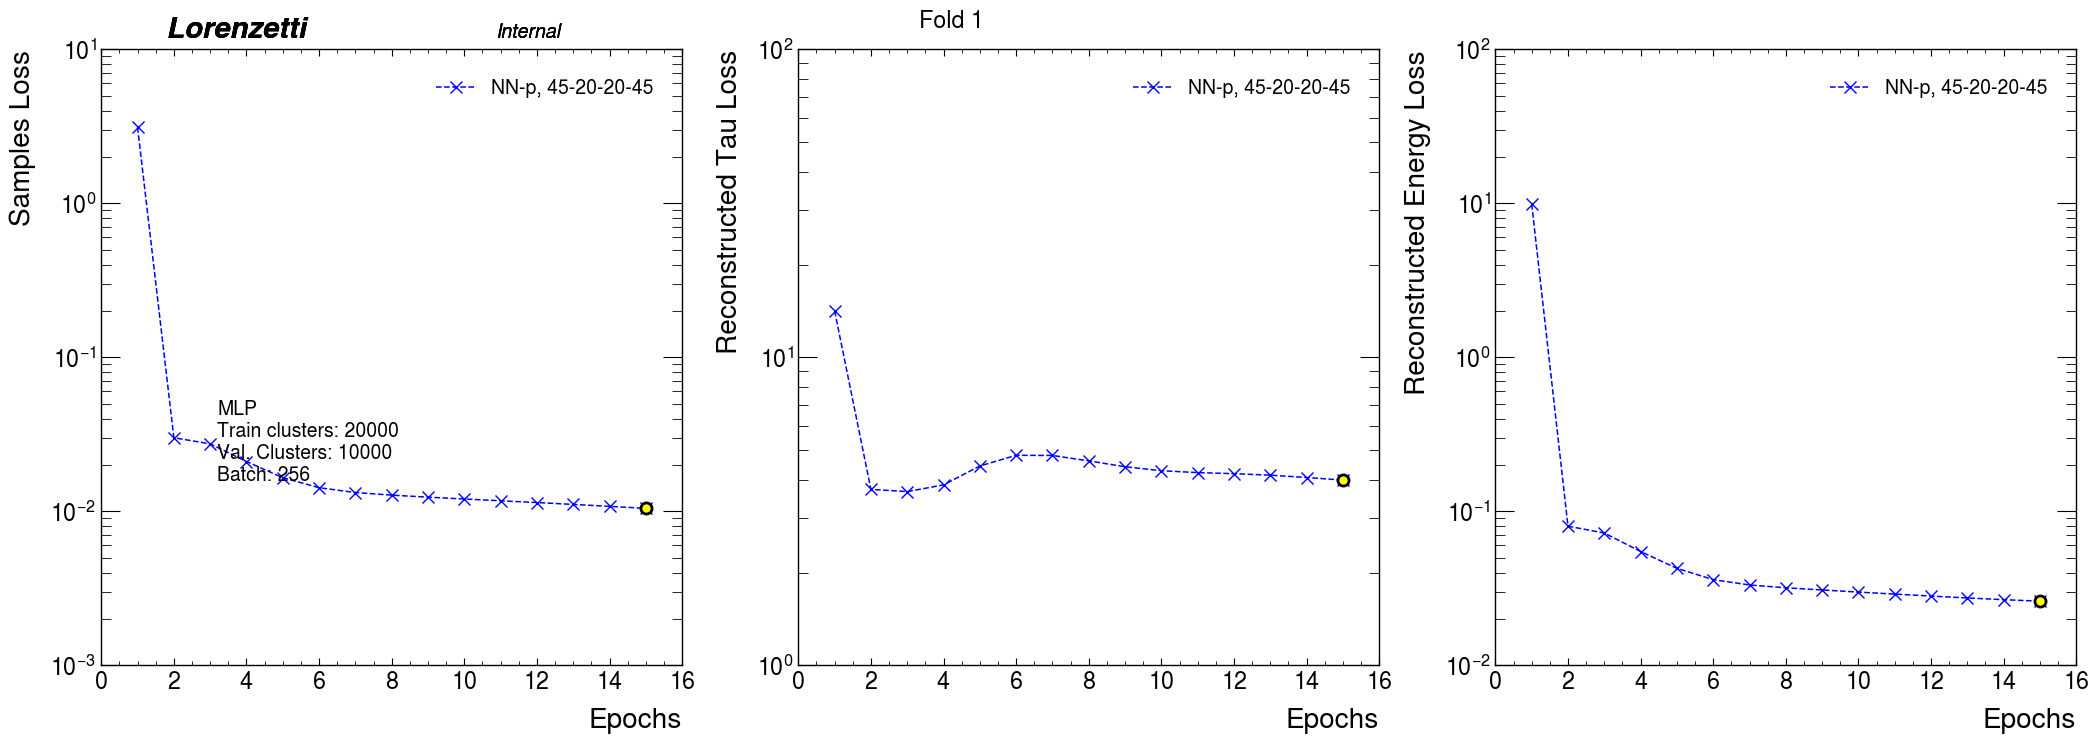

total clusters/Fold: 20000


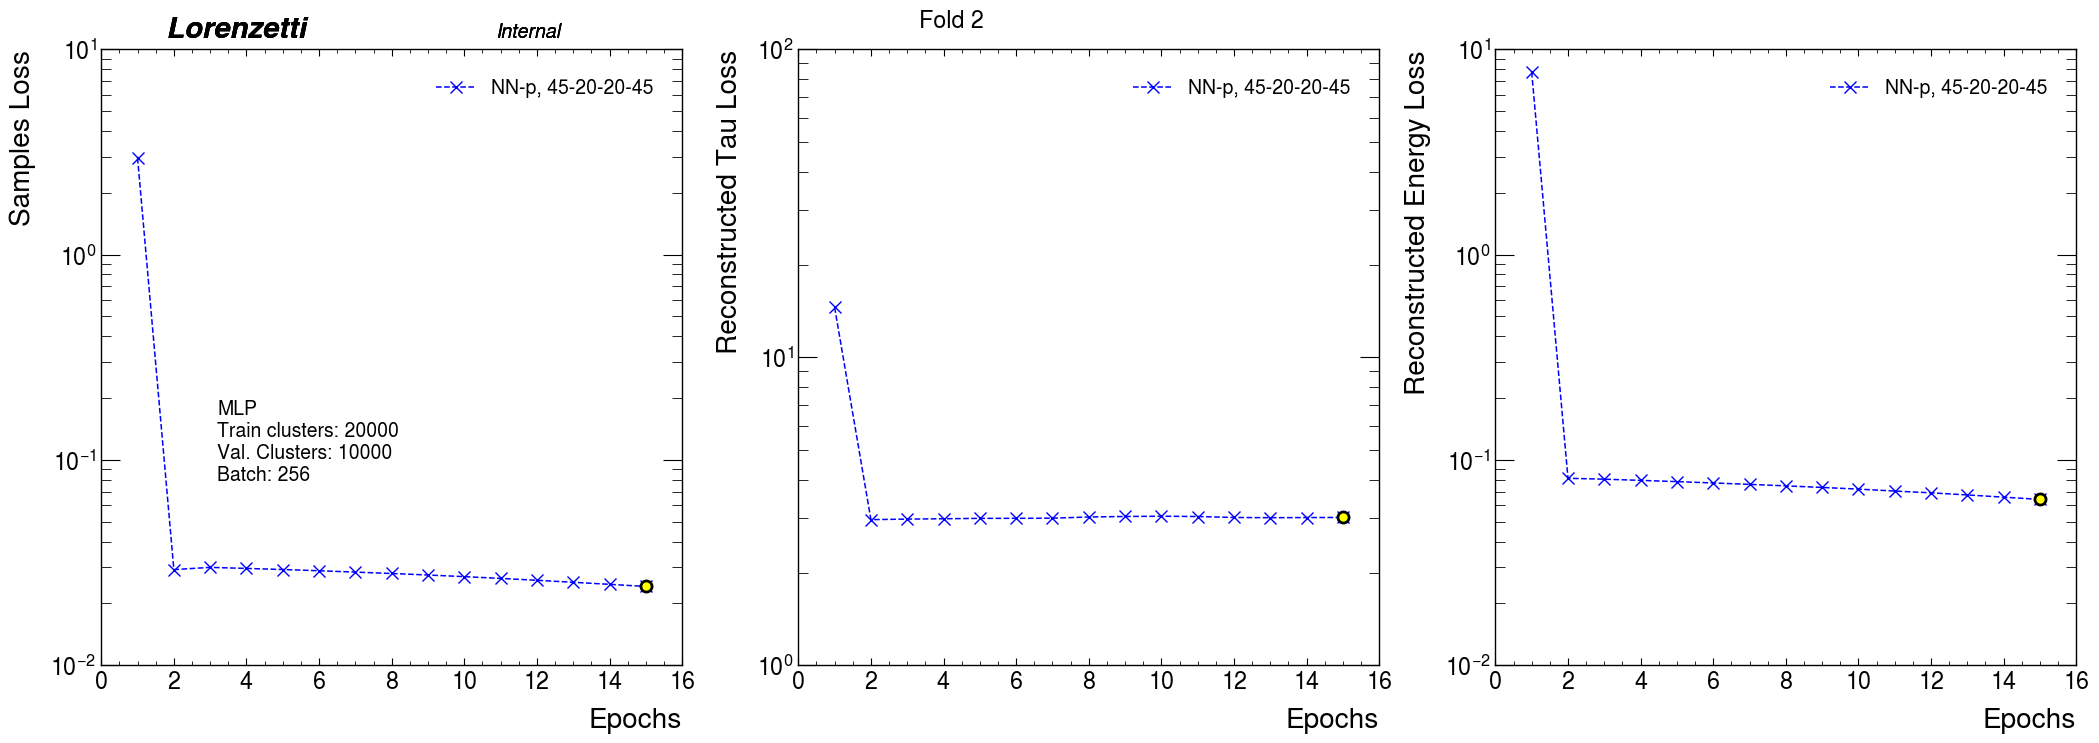

In [ ]:
# matplotlib.use('Agg') #CHANGES THE MATPLOTLIB BACKEND FOR LOOP PLOTS
matplotlib.use('module://ipykernel.pylab.backend_inline')  # show plots

experiment      = 'data_structure_comparison/sub_ROOT'
pathLoss     = '/data/atlas/mhufnage/xtalk/ml_training/supervised_lzt/{}/'.format(experiment)

# loop_dict    = np.load(pathLoss+'{}_config.npz'.format(experiment), allow_pickle=True)['config'].tolist()
loop_dict    = np.load(pathLoss+'config_train_nnp_adam_neu45-20-20-45.npz', allow_pickle=True)['config'].tolist()

netTypes        = ['p']#,'pt','pet']
storedLosses    = ['loss','val','tauLoss','eneLoss']
cellMarkers     = ['x','v','^','<','D','o','>','1','+']
cellColors      = ['blue','red','black','green','yellow','purple','cyan','pink','orange']

# neuLayTopos     = loop_dict['neuLay']#[[45,5,5],[45,15,15],[45,30,30]]
neuLayTopos     =[loop_dict['neurons_list']]#[[45,5,5],[45,15,15],[45,30,30]]

k               = 3
max_iter        = 1
max_epochs      = 30
ci_value        = .90 # confidence interval value alpha
epochsStart     = 1
epochsLimit     = -1
plotATLAS_loc   = 2
plotFormat      = 'pdf'#'png'
plotYear        = 2024

if not(os.path.isdir(pathLoss+'plots/')):
    os.mkdir(pathLoss+'plots/')

results_mean = {key:[] for key in netTypes}
results_mean.update({key:{key2:[] for key2 in storedLosses} for key in netTypes })
results_std = {key:[] for key in netTypes}
results_std.update({key:{key2:[] for key2 in storedLosses} for key in netTypes })
# results={}
# for k in range(0, k):
#    results.update( {key+str(k):[] for key in netTypes})
# results.update({key:{key2:[] for key2 in ['loss','val','tauLoss','eneLoss']} for key in results.keys() })



for fold in range(k):
    fig, (ax0, ax1, ax2) = plt.subplots(1,3,figsize=(25,8))
    fig.suptitle('Fold {}'.format(fold))
    idx = 0
    for netType in netTypes:
        for neuLayTopo in neuLayTopos:
            neuLayText = MLP.neuListToFileText(neuLayTopo)
            for it in range(max_iter):            
            # lossAllFolds       = np.zeros((max_epochs, k),dtype=float)
                partial_results={key:np.zeros((max_epochs, k),dtype=float) for key in storedLosses}            
            
                
                
                config_train = np.load(pathLoss+'config_train_nn{}_adam_neu{}.npz'.format(netType,neuLayText), allow_pickle=True)['config'].tolist()

                neuIn           = config_train['neurons_list']
                neuInText       = config_train['neurons_text']
                trainRatio      = config_train['train_ratio']
                batch_size      = config_train['batch_size']
                total_clusters  = config_train['total_clusters']        
                
                train_logging_dict = np.load(pathLoss+'loss_nn{}_fold{}_iter{}_neu{}_batch{}.npz'.format(netType,fold, it, neuInText, batch_size),allow_pickle=True)['loss'].tolist()
                partial_results['val']      = train_logging_dict['val_loss']#[0:train_logging_dict['best_epoch']]
                partial_results['tauLoss']  = train_logging_dict['val_tau_loss']#[0:train_logging_dict['best_epoch']]
                partial_results['eneLoss']  = train_logging_dict['val_ene_loss']#[0:train_logging_dict['best_epoch']]
            # for lossType in storedLosses:
                meanLoss    = partial_results['val']
                meanTauLoss = partial_results['tauLoss']
                meanEneLoss = partial_results['eneLoss']
                
                # confIntLowerLoss, confIntUpperLoss, _ , _        = confInterval(alfa=ci_value, data=partial_results['val'])
                # confIntLowerTauLoss, confIntUpperTauLoss, _ , _  = confInterval(alfa=ci_value, data=partial_results['tauLoss'])
                # confIntLowerEneLoss, confIntUpperEneLoss, _ , _  = confInterval(alfa=ci_value, data=partial_results['eneLoss'])
                
                epochs   = range(1,len(meanLoss)+1)
            
                clusters_per_fold_train = int((trainRatio*total_clusters)*(k-1)/k)
                clusters_per_fold_val   = int(((trainRatio)*total_clusters)*1/k)

                print('total clusters/Fold: {}'.format(clusters_per_fold_train))
                
                
                # plt.suptitle('Total clusters: {}, batch size: {}'.format(total_clusters, batch_size),y=1.05)
                # ax0 = plt.subplot(1,3,1)
                # ax0.plot(range(1,len(train_logging_dict['loss'])+1) ,train_logging_dict['loss']  ,'--.',lw=1, c='blue', label='train loss fold {}'.format(fold))
                # ax0.plot(range(1,len(train_logging_dict['val_loss'])+1) ,train_logging_dict['val_loss']  ,'--.',lw=1, c='red', label='validation loss fold {}'.format(fold))
                ax0.plot(epochs ,meanLoss  ,'--{}'.format(cellMarkers[idx]),lw=1.1, c=cellColors[idx], label='NN-{}, {}'.format(netType, neuInText))
                ax0.plot(train_logging_dict['best_epoch']+1, meanLoss[train_logging_dict['best_epoch']], marker='o', lw=1, markeredgewidth=2, markerfacecolor='yellow', markeredgecolor='black')
                # ax0.fill_between(epochs, confIntLowerLoss, confIntUpperLoss, alpha=0.4 , facecolor=cellColors[idx])
                ax0.set_xlabel('Epochs')
                ax0.set_ylabel('Samples Loss')
                ax0.legend()
                ax0.set_yscale('log')
                # ax0.set_xscale('log')
                # hep.atlas.label(data=True,paper=False,year=plotYear, loc=plotATLAS_loc)
                lorenzettiText(subText='Internal')
                # ax0.text(0.7,0.7,'Test')
                ax0.text(s='MLP\nTrain clusters: {}\nVal. Clusters: {}\nBatch: {}'.format(clusters_per_fold_train, clusters_per_fold_val, batch_size),x=0.2,y=0.3, transform=ax0.transAxes, fontsize=14, ha='left', color='black')
                plt.yscale('log')
                if epochsLimit!=-1:
                    plt.xlim([epochsStart, epochsLimit])

                # plt.subplot(1,3,2)
                # plt.plot(range(1,len(train_logging_dict['tau_loss'])+1) ,train_logging_dict['tau_loss'] ,'--.',lw=1, c='black', label='monitoring loss fold {}'.format(fold))
                # plt.plot(range(1,len(train_logging_dict['val_tau_loss'])+1) ,train_logging_dict['val_tau_loss'] ,'--.',lw=1, c='green', label='monitoring val. loss fold {}'.format(fold))
                # plt.plot(range(1,len(train_logging_dict['wTauEneLoss'])+1) ,train_logging_dict['wTauEneLoss'] ,'--.',lw=1, c='yellow', label='monitoring weighted '+r'$\sqrt{E}$ loss'+' fold {}'.format(fold))
                # plt.plot(range(1,len(train_logging_dict['val_wTauEneLoss'])+1) ,train_logging_dict['val_wTauEneLoss'] ,'--.',lw=1, c='pink', label='monitoring val. weighted '+r'$\sqrt{E}$ loss'+' fold {}'.format(fold))
                # plt.plot(train_logging_dict['best_epoch']+1, train_logging_dict['val_tau_loss'][train_logging_dict['best_epoch']], marker='o', lw=1, markeredgewidth=2, markerfacecolor='yellow', markeredgecolor='black', label='best epoch')
                ax1.plot(epochs ,meanTauLoss  ,'--{}'.format(cellMarkers[idx]),lw=1.1, c=cellColors[idx], label='NN-{}, {}'.format(netType, neuInText))
                ax1.plot(train_logging_dict['best_epoch']+1, meanTauLoss[train_logging_dict['best_epoch']], marker='o', lw=1, markeredgewidth=2, markerfacecolor='yellow', markeredgecolor='black')
                # ax1.fill_between(epochs, confIntLowerTauLoss, confIntUpperTauLoss, alpha=0.4 , facecolor=cellColors[idx])
                ax1.set_xlabel('Epochs')
                ax1.set_ylabel('Reconstructed Tau Loss')
                # hep.atlas.label(data=True,paper=False,year=plotYear, loc=plotATLAS_loc)
                lorenzettiText(subText='Internal')
                ax1.legend()
                ax1.set_yscale('log')
                # ax1.set_xscale('log')
                if epochsLimit!=-1:
                    plt.xlim([epochsStart, epochsLimit])

                # plt.figure(figsize=(14,5))
                # plt.subplot(1,3,3)
                # plt.plot(range(1,len(train_logging_dict['ene_loss'])+1) ,train_logging_dict['ene_loss']  ,'--.',lw=1, c='orange', label='monitoring loss fold {}'.format(fold))
                # plt.plot(range(1,len(train_logging_dict['val_ene_loss'])+1) ,train_logging_dict['val_ene_loss']  ,'--.',lw=1, c='purple', label='validation loss fold {}'.format(fold))
                # plt.plot(train_logging_dict['best_epoch']+1, train_logging_dict['val_ene_loss'][train_logging_dict['best_epoch']], marker='o', lw=1, markeredgewidth=2, markerfacecolor='yellow', markeredgecolor='black', label='best epoch')
                ax2.plot(epochs ,meanEneLoss  ,'--{}'.format(cellMarkers[idx]),lw=1.1, c=cellColors[idx], label='NN-{}, {}'.format(netType, neuInText))
                ax2.plot(train_logging_dict['best_epoch']+1, meanEneLoss[train_logging_dict['best_epoch']], marker='o', lw=1, markeredgewidth=2, markerfacecolor='yellow', markeredgecolor='black')
                # ax2.fill_between(epochs, confIntLowerEneLoss, confIntUpperEneLoss, alpha=0.4 , facecolor=cellColors[idx])
                ax2.set_xlabel('Epochs')
                ax2.set_ylabel('Reconstructed Energy Loss')
                ax2.legend()
                # hep.atlas.label(data=True,paper=False,year=plotYear, loc=plotATLAS_loc)
                lorenzettiText(subText='Internal')            
                ax2.set_yscale('log')
                # ax2.set_xscale('log')
                if epochsLimit!=-1:
                    plt.xlim([epochsStart, epochsLimit])
                    
                idx+=1

        plt.savefig(pathLoss+'plots/loss_nn{}_fold{}_iter{}_neu{}_batch{}.png'.format(netType,fold, it, neuInText, batch_size))
        plt.show()
        plt.close()
# hep.save_variations(fig, pathLoss+'lossPlotAllCells_fold{}_iter{}_neu{}_batch{}.{}'.format(fold, it, neuIn, neuInText, batch_size, plotFormat),text_list=['Preliminary', 'Work in progress'])

In [ ]:
a ='/data/atlas/mhufnage/xtalk/ml_training/supervised_lzt/neuLay_1Layer/'
a.split('/')[-2]

'neuLay_1Layer'

#### C) Scatter Plot IN/OUT
    - Load full dataset and the training config.
    - Dump all training parameters and select the TEST sub-set.
    - Re-mount the model and optimizer, like was done in the current training being evaluated (neurons, layers, optimization algorithm).
    - Dump AC training status (weights, optim. parameters) to the model, and evaluate it into TEST sub-set (unseen data).
    

#### - NeuLay

In [ ]:
DS_PathAlias  = '/data/atlas/mhufnage/lzt_single_e/elec_singleCell_10kEvts_centroid_e50_DS{}/AOD/user.mhufnage.lzt.e50.xtalk.DS{}.win3.nopileup.WithCells_EM2.event.npz'
DS_List       = [21]#,22,23]#,24,25,26,27,28,29,30]
DSnoNoise_PathAlias = '/data/atlas/mhufnage/lzt_single_e/elec_singleCell_10kEvts_centroid_e50_DS{}/AOD_noNoise/user.mhufnage.lzt.e50.xtalk.DS{}.win3.nopileup.WithCells_EM2.event.noNoise.npz'
# DS_List       = [21,22,23,24,25,26,27,28,29,30]
data          = []
dataNoNoise   = []
for DS_index in DS_List:
    data.append (np.load(DS_PathAlias.format(DS_index,DS_index), allow_pickle=True)['dataset'])
    dataNoNoise.append (np.load(DSnoNoise_PathAlias.format(DS_index,DS_index), allow_pickle=True)['dataset'])
data = np.concatenate(data).ravel()
dataNoNoise = np.concatenate(dataNoNoise).ravel()
print('Dataset loaded with {} events!'.format(len(data)))
print('Dataset noiseless loaded with {} events!'.format(len(dataNoNoise)))


Dataset loaded with 9962 events!
Dataset noiseless loaded with 9962 events!


In [ ]:
# matplotlib.use('Agg') #CHANGES THE MATPLOTLIB BACKEND FOR LOOP PLOTS
# matplotlib.use('module://ipykernel.pylab.backend_inline')  # show plots

#
# Dataset split
#
# X_train, X_test = train_test_split(data, test_size=testRatio)
# datasetTest     =   XTalkDataset_LZT(data, nEvents=-1, mode='supervised')
# testDataLoader  =   DataLoader( datasetTest, batch_size=1, shuffle=False )
# matplotlib.use('Agg') #CHANGES THE MATPLOTLIB BACKEND FOR LOOP PLOTS
# matplotlib.use('module://ipykernel.pylab.backend_inline')  # show plots
# print('experiment: {}\npath: {}'.format(experiment, pathLoss))
#
# Dataset split
#
# X_train, X_test = train_test_split(data, test_size=testRatio)
datasetTest             =   XTalkDataset_LZT(data, nEvents=-1, mode='supervised')
datasetTestNoNoise      =   XTalkDataset_LZT(dataNoNoise, nEvents=-1, mode='supervised')
testDataLoader          =   DataLoader( datasetTest, batch_size=1, shuffle=False )
testDataLoaderNoNoise   =   DataLoader( datasetTestNoNoise, batch_size=1, shuffle=False )

nEvts = datasetTest.len

experiment  = 'neuLay'
netType     = 'p'

# pathLoss     = '/data/atlas/mhufnage/xtalk/ml_training/supervised_lzt/sampleInSampleOut/'
pathLoss        = '/data/atlas/mhufnage/xtalk/ml_training/supervised_lzt/{}/'.format(experiment)

loop_dict    = np.load(pathLoss+'{}_config.npz'.format(experiment), allow_pickle=True)['config'].tolist()

it              = 0
xbins           = 100
k               = 3

epochsStart     = 1
epochsLimit     = 250

plotATLAS_loc   = 2
plotFormat      = 'pdf'#'png'
plotYear        = 2017
labelDistX      = 17

for neuLayTopo in [loop_dict['neuLay'][0], loop_dict['neuLay'][2]]:
    
    neuLayText = MLP.neuListToFileText(neuLayTopo)
    print('Topo: {}'.format(neuLayText))
    
    config_train = np.load(pathLoss+'config_train_nn{}_adam_neu{}.npz'.format(netType,neuLayText), allow_pickle=True)['config'].tolist()

    k               = config_train['kFolds']
    neuIn           = config_train['neurons_list']
    neuInText       = config_train['neurons_text']
    max_iter        = config_train['max_init']
    trainRatio      = config_train['train_ratio']
    testRatio       = config_train['test_ratio']
    batch_size      = config_train['batch_size']
    total_clusters  = config_train['total_clusters']
    nCellsWinEta    = config_train['cell_win_eta']
    nCellsWinPhi    = config_train['cell_win_phi']
    optimConfig     = config_train['optimConfig']
    scalerInput     = config_train['scaler_input']
    scalerOutput    = config_train['scaler_output']

    for fold in range(k):
        print('\tFold {}'.format(fold))
        filename    = pathLoss+'bestModel_nn{}_fold{}_iter{}_neu{}.pth'.format(netType,fold, it, neuInText)
        
        model       = MLP.MLP_FF(neuronsList=neuIn)
        
        if 'adam' in optimConfig.keys():
            optimAlg = 'adam'
            optimizer   = torch.optim.Adam(model.parameters(), lr=optimConfig[optimAlg]['learningRate'], weight_decay=optimConfig[optimAlg]['weightDecay'])
        bestLossVal = MLP.resumeModel(model, optimizer, filename)

        targetList   = []
        outputList  = []
        inputList = []
        eneTargetList    = []
        eneOutputList   = []
        tauTargetList    = []
        tauOutputList   = []

        for data_input, target, batch_idx in testDataLoader:
            # pass input through the model and generate the output
            output                  = model(data_input*scalerInput) #normalized input
            outputScaled            = output*scalerOutput
            ene_target, tau_target  = datasetTest.calibrate(batch_idx, target) # unormlized input
            ene_output, tau_output  = datasetTest.calibrate(batch_idx, output*scalerOutput) # denormalized output

            targetList       .append( target.detach().numpy()*1/1000 )
            outputList      .append( outputScaled.detach().numpy()*1/1000 )
            inputList       .append( data_input.detach().numpy()*1/1000 )
            eneTargetList    .append( ene_target.detach().numpy()*1/1000 )
            eneOutputList   .append( ene_output.detach().numpy()*1/1000 )
            tauTargetList    .append( tau_target.detach().numpy() )
            tauOutputList   .append( tau_output.detach().numpy() )

        # ML input values (with XT)
        inputList = (np.concatenate(inputList).ravel()*1/1000).tolist()
        inputXTTau = (np.concatenate(testDataLoader.dataset.xtt)).ravel().tolist()
        inputXTEne = (np.concatenate(testDataLoader.dataset.xte).ravel()*1/1000).tolist()
         # truth
        truth_ene       = (np.concatenate(testDataLoader.dataset.edep).ravel()*1/1000).tolist()
        truth_tau       = (np.concatenate(testDataLoader.dataset.tof).ravel()).tolist()
        # signal samples
        outputList      = np.concatenate(outputList).ravel().tolist() # flatten the list
        targetList      = np.concatenate(targetList).ravel().tolist()
        errorList       = (np.array(targetList) - np.array(outputList)).tolist()
        # energy
        eneTargetList   = np.concatenate(eneTargetList).ravel().tolist()
        eneOutputList   = np.concatenate(eneOutputList).ravel().tolist()
        eneErrorList    = (np.array(eneTargetList) - np.array(eneOutputList))
        eneErrorTarget  = np.array(truth_ene) - np.array(eneTargetList)
        eneErrorOutput  = np.array(truth_ene) - np.array(eneOutputList)
        # time
        tauTargetList   = np.concatenate(tauTargetList).ravel().tolist()
        tauOutputList   = np.concatenate(tauOutputList).ravel().tolist()
        tauErrorList    = ( np.array(tauTargetList) - np.array(tauOutputList))
        tauErrorTarget  = np.array(truth_tau) - np.array(tauTargetList)
        tauErrorOutput  = np.array(truth_tau) - np.array(tauOutputList)
       
        #
        # signal samples
        #
        fig = plt.figure(figsize=(25,8))
        
        ax0 = plt.subplot(1,2,1)
        xbins = getBins(-2,50,0.05)
        plt.hist2d(targetList, outputList,bins=[xbins,xbins], cmin=1,norm=mcolors.SymLogNorm(linthresh=0.5, linscale=1, base=10), cmap=plt.cm.jet)
        r2_target_output = r2_score(targetList, outputList)
        # r2_target_truth = r2_score(truth_ene, outputList)
        plt.plot([0, max(max(targetList), max(outputList))],[0, max(max(targetList), max(outputList))], '--r', label='diagonal\n'+r'  $R^2_{target}=$'+'{:.5f}'.format(r2_target_output))
        plt.legend(loc='lower right',fontsize=16)
        plt.xlabel('Cluster cell samples [GeV]')
        plt.ylabel('Reconstructed cluster cell samples [GeV] 50 MeV/bin')
        plt.colorbar()
        lorenzettiText()
        # hep.atlas.label(data=True,paper=False,year=plotYear, loc=plotATLAS_loc)

        ax0 = plt.subplot(1,2,2)
        xbins = getBins(-2,2,0.05)
        stat_error = 'Target - ML output'+'\n'+r'$\mu={:.3}, \sigma={:.3}$'.format(np.mean(errorList),np.std(errorList))
        plt.hist(errorList, bins=xbins, histtype='stepfilled',alpha=0.5, ec='black',fc='yellow', label=stat_error)
        plt.xlabel('Sample reconstruction error [GeV] 50 MeV/bin')
        plt.ylabel('Counts')
        plt.yscale('log')
        lorenzettiText()
        plt.legend()
        # hep.atlas.label(data=True,paper=False,year=plotYear, loc=plotATLAS_loc)

        # ax0 = plt.subplot(1,3,3)
        # xbins = getBins(-5,5,0.05)
        # plt.hist2d(errorList, targetList ,bins=[xbins,xbins], cmin=1,norm=mcolors.SymLogNorm(linthresh=0.5, linscale=1, base=10), cmap=plt.cm.jet)
        # plt.xlabel('Cluster cell samples [GeV]')
        # plt.ylabel('Sample reconstruction error [GeV]')
        # plt.colorbar()
        # lorenzettiText()
        # hep.atlas.label(data=True,paper=False,year=plotYear, loc=plotATLAS_loc)       

        # hep.save_variations(fig, pathLoss+'scatterBestModel_samples_fold{}_iter{}_neuIn{}_nLay{}_bn{}_batch{}.{}'.format(nFold, it, neuIn, nLay, bn, batch_size, plotFormat),text_list=['Preliminary', 'Work in progress'])
        plt.savefig(pathLoss+'plots/scatterBestModel_samples_nn{}_fold{}_iter{}_neu{}_batch{}.png'.format(netType,fold, it, neuInText, batch_size))
        plt.close(fig)
        plt.show()

        #
        # Energy
        #
        fig = plt.figure(figsize=(30,8))
        xbins = getBins(-2,50,0.1)
        ax0 = plt.subplot(1,3,1)
        plt.hist2d(eneTargetList, eneOutputList,bins=[xbins,xbins], cmin=1,norm=mcolors.SymLogNorm(linthresh=0.5, linscale=1, base=10), cmap=plt.cm.jet)
        r2_target_output = r2_score(eneTargetList, eneOutputList)
        r2_target_truth = r2_score(truth_ene, eneOutputList)
        plt.plot([0, max(max(eneTargetList), max(eneOutputList))],[0, max(max(eneTargetList), max(eneOutputList))], '--r', label='diagonal\n'+r'  $R^2_{target}=$'+'{:.5f}'.format(r2_target_output)+'\n'+r'  $R^2_{target}=$'+'{:.5f}'.format(r2_target_output) )
        plt.legend(loc='lower right')
        plt.xlabel('Cluster cell energy [GeV]', labelpad=labelDistX)
        plt.ylabel('Reconstructed cluster cell energy [GeV] 50 MeV/bin')
        plt.colorbar()
        # hep.atlas.label(data=True,paper=False,year=plotYear, loc=plotATLAS_loc)
        lorenzettiText()

        ax0 = plt.subplot(1,3,2)
        xbins = getBins(-1.0,1.0,0.025)
        stat_error1 = 'Target - ML output'+'\n'+r'$\mu={:.3}, \sigma={:.3}$'.format(np.mean(eneErrorList),np.std(eneErrorList))
        stat_error2 = 'Truth - ML output'+'\n'+r'$\mu={:.3}, \sigma={:.3}$'.format(np.mean(eneErrorOutput),np.std(eneErrorOutput))
        stat_error3 = 'Truth - Target'+'\n'+r'$\mu={:.3}, \sigma={:.3}$'.format(np.mean(eneErrorTarget),np.std(eneErrorTarget))
        plt.hist(eneErrorList, bins=xbins, histtype='step',ec='black', label=stat_error1)
        plt.hist(eneErrorOutput, bins=xbins, histtype='step', ec='blue', label=stat_error2)
        plt.hist(eneErrorTarget, bins=xbins, histtype='step', ec='green', label=stat_error3)
        plt.xlabel('Energy reconstruction error [GeV] 50MeV/bin', labelpad=labelDistX)
        plt.ylabel('Counts')
        plt.yscale('log')
        plt.legend()
        # hep.atlas.label(data=True,paper=False,year=plotYear, loc=plotATLAS_loc)
        lorenzettiText()
        
        ax0 = plt.subplot(1,3,3)
        xbins = getBins(-2,50,0.1)
        stat_error1 = 'Input XT energy'#+'\n'+r'$\mu={:.3}, \sigma={:.3}$'.format(np.mean(inputXTEne),np.std(inputXTEne))
        stat_error2 = 'Target'#+'\n'+r'$\mu={:.3}, \sigma={:.3}$'.format(np.mean(eneTargetList),np.std(eneTargetList))
        stat_error3 = 'ML output'#+'\n'+r'$\mu={:.3}, \sigma={:.3}$'.format(np.mean(eneOutputList),np.std(eneOutputList))
        stat_error4 = 'Truth'#+'\n'+r'$\mu={:.3}, \sigma={:.3}$'.format(np.mean(truth_ene),np.std(truth_ene))
        plt.hist(inputXTEne, bins=xbins, histtype='stepfilled',alpha=0.3, ec='black',fc='red', label=stat_error1)
        plt.hist(eneTargetList, bins=xbins, histtype='stepfilled',alpha=0.3, ec='black',fc='red', label=stat_error2)
        plt.hist(eneOutputList, bins=xbins, histtype='step', ec='blue', label=stat_error3)
        plt.hist(truth_ene, bins=xbins, histtype='step', ec='green', label=stat_error4)
        plt.xlabel('Reconstructed Energy [GeV] 100MeV/bin', labelpad=labelDistX)
        plt.ylabel('Counts')
        plt.yscale('log')
        plt.legend()
        # hep.atlas.label(data=True,paper=False,year=plotYear, loc=plotATLAS_loc)
        lorenzettiText()

        # ax0 = plt.subplot(1,3,3)
        # plt.hist2d(eneTargetList, eneErrorList,bins=[xbins,xbins], cmin=1,norm=mcolors.SymLogNorm(linthresh=0.5, linscale=1, base=10), cmap=plt.cm.jet)
        # plt.xlabel('Cluster cell energy [GeV]', labelpad=labelDistX)
        # plt.ylabel('Energy reconstruction error [GeV]')
        # plt.grid()
        # plt.colorbar()
        # # hep.atlas.label(data=True,paper=False,year=plotYear, loc=plotATLAS_loc)
        # lorenzettiText()

        # ax0 = plt.subplot(1,4,4)
        # plt.hist2d(eneOutputList, eneErrorList,bins=[xbins,xbins], cmin=1,norm=mcolors.SymLogNorm(linthresh=0.5, linscale=1, base=10), cmap=plt.cm.jet)
        # plt.xlabel('Reconstructed cluster cell energy [GeV]', labelpad=labelDistX)
        # plt.ylabel('Energy reconstruction error [GeV]')
        # # plt.ylabel('Output - Input samples [ADC]')
        # plt.grid()
        # plt.colorbar()
        # hep.atlas.label(data=True,paper=False,year=plotYear, loc=plotATLAS_loc)
        
        plt.savefig(pathLoss+'plots/scatterBestModel_energy_nn{}_fold{}_iter{}_neu{}_batch{}.png'.format(netType,fold, it, neuInText, batch_size))
        # hep.save_variations(fig, pathLoss+'scatterBestModel_energy_fold{}_iter{}_neuIn{}_nLay{}_bn{}_batch{}.{}'.format(nFold, it, neuIn, nLay, bn, batch_size, plotFormat),text_list=['Preliminary', 'Work in progress'])
        plt.close(fig)
        plt.show()

        #
        # Time
        #
        fig = plt.figure(figsize=(30,8))
        
        xbins = getBins(-15,15,0.5)
        ax0 = plt.subplot(1,3,1)
        plt.hist2d(tauTargetList, tauOutputList,bins=[xbins,xbins], cmin=1,norm=mcolors.SymLogNorm(linthresh=0.5, linscale=1, base=10), cmap=plt.cm.jet)
        plt.plot([0, max(max(tauTargetList), max(tauOutputList))],[0, max(max(tauTargetList), max(tauOutputList))], '--r', label='diagonal')
        plt.legend(loc='lower right')
        plt.xlabel('Cluster cell time [ns]', labelpad=labelDistX)
        plt.ylabel('Reconstructed cluster cell time [ns] 500ps/bin')
        plt.colorbar()
        # hep.atlas.label(data=True,paper=False,year=plotYear, loc=plotATLAS_loc)

        ax0 = plt.subplot(1,3,2)
        xbins = getBins(-15,15,0.5)
        stat_error1 = 'Target - ML output'+'\n'+r'$\mu={:.3}, \sigma={:.3}$'.format(np.mean(tauErrorList),np.std(tauErrorList))
        stat_error2 = 'Truth - ML output'+'\n'+r'$\mu={:.3}, \sigma={:.3}$'.format(np.mean(tauErrorOutput),np.std(tauErrorOutput))
        stat_error3 = 'Truth - Target'+'\n'+r'$\mu={:.3}, \sigma={:.3}$'.format(np.mean(tauErrorTarget),np.std(tauErrorTarget))
        plt.hist(tauErrorList, bins=xbins, histtype='stepfilled',alpha=0.5, ec='black',fc='red', label=stat_error1)
        plt.hist(tauErrorOutput, bins=xbins, histtype='step', ec='blue', label=stat_error2)
        plt.hist(tauErrorTarget, bins=xbins, histtype='step', ec='green', label=stat_error3)
        plt.xlabel('Time reconstruction error [ns] 500ps/bin', labelpad=labelDistX)
        plt.ylabel('Counts')
        plt.yscale('log')
        plt.legend()
        # hep.atlas.label(data=True,paper=False,year=plotYear, loc=plotATLAS_loc)

        ax0 = plt.subplot(1,3,3)
        xbins = getBins(-15,15,0.5)
        stat_error1 = 'Input XT Time'+'\n'+r'$\mu={:.3}, \sigma={:.3}$'.format(np.mean(inputXTTau),np.std(inputXTTau))
        stat_error2 = 'Target'+'\n'+r'$\mu={:.3}, \sigma={:.3}$'.format(np.mean(tauTargetList),np.std(tauTargetList))
        stat_error3 = 'ML output'+'\n'+r'$\mu={:.3}, \sigma={:.3}$'.format(np.mean(tauOutputList),np.std(tauOutputList))
        stat_error4 = 'Truth'+'\n'+r'$\mu={:.3}, \sigma={:.3}$'.format(np.mean(truth_tau),np.std(truth_tau))
        plt.hist(inputXTTau, bins=xbins, histtype='stepfilled',alpha=0.3,fc='blue', label=stat_error1)
        plt.hist(tauTargetList, bins=xbins, histtype='stepfilled',alpha=0.3, ec='black',fc='red', label=stat_error2)
        plt.hist(tauOutputList, bins=xbins, histtype='step', ec='blue', label=stat_error3)
        plt.hist(truth_tau, bins=xbins, histtype='step', ec='green', label=stat_error4)
        # plt.hist2d(tauTargetList, tauErrorList,bins=[xbins,xbins], cmin=1,norm=mcolors.SymLogNorm(linthresh=0.5, linscale=1, base=10), cmap=plt.cm.jet)
        plt.xlabel('Cluster cell time [ns] 500ps/bin', labelpad=labelDistX)
        plt.ylabel('Counts')
        plt.yscale('log')
        plt.grid()
        plt.legend()
        # plt.colorbar()
        # hep.atlas.label(data=True,paper=False,year=plotYear, loc=plotATLAS_loc)

        # ax0 = plt.subplot(1,4,4)
        # plt.hist2d(tauOutputList, tauErrorList,bins=[xbins,xbins], cmin=1,norm=mcolors.SymLogNorm(linthresh=0.5, linscale=1, base=10), cmap=plt.cm.jet)
        # plt.xlabel('Reconstructed cluster cell time [ns]', labelpad=labelDistX)
        # plt.ylabel('Time reconstruction error [ns]')
        # # plt.ylabel('Output - Input samples [ADC]')
        # plt.grid()
        # plt.colorbar()
        # hep.atlas.label(data=True,paper=False,year=plotYear, loc=plotATLAS_loc)
        plt.savefig(pathLoss+'plots/scatterBestModel_time_nn{}_fold{}_iter{}_neu{}_batch{}.png'.format(netType,fold, it, neuInText, batch_size))
        # hep.save_variations(fig, pathLoss+'scatterBestModel_time_fold{}_iter{}_neuIn{}_nLay{}_bn{}_batch{}.{}'.format(nFold, it, neuIn, nLay, bn, batch_size, plotFormat),text_list=['Preliminary', 'Work in progress'])
        plt.close(fig)
        plt.show()


Topo: 45-5-5-45
	Fold 0
	Fold 1
	Fold 2
Topo: 45-30-30-45
	Fold 0
	Fold 1
	Fold 2


test

In [ ]:
# X_train, X_test = train_test_split(data, test_size=testRatio)
datasetTest             =   XTalkDataset_LZT(data, nEvents=-1, mode='supervised')
datasetTestNoNoise      =   XTalkDataset_LZT(dataNoNoise, nEvents=-1, mode='supervised')
testDataLoader          =   DataLoader( datasetTest, batch_size=1, shuffle=False )
testDataLoaderNoNoise   =   DataLoader( datasetTestNoNoise, batch_size=1, shuffle=False )

experiment  = 'neuLay'
netType     = 'p'

# pathLoss     = '/data/atlas/mhufnage/xtalk/ml_training/supervised_lzt/sampleInSampleOut/'
pathLoss        = '/data/atlas/mhufnage/xtalk/ml_training/supervised_lzt/{}/'.format(experiment)

loop_dict    = np.load(pathLoss+'{}_config.npz'.format(experiment), allow_pickle=True)['config'].tolist()

it              = 0
xbins           = 100
k               = 3

epochsStart     = 1
epochsLimit     = 250

plotATLAS_loc   = 2
plotFormat      = 'pdf'#'png'
plotYear        = 2017
labelDistX      = 17

for neuLayTopo in [loop_dict['neuLay'][2]]:
    
    neuLayText = MLP.neuListToFileText(neuLayTopo)
    print('Topo: {}'.format(neuLayText))
    
    config_train = np.load(pathLoss+'config_train_nn{}_adam_neu{}.npz'.format(netType,neuLayText), allow_pickle=True)['config'].tolist()

    k               = config_train['kFolds']
    neuIn           = config_train['neurons_list']
    neuInText       = config_train['neurons_text']
    max_iter        = config_train['max_init']
    trainRatio      = config_train['train_ratio']
    testRatio       = config_train['test_ratio']
    batch_size      = config_train['batch_size']
    total_clusters  = config_train['total_clusters']
    nCellsWinEta    = config_train['cell_win_eta']
    nCellsWinPhi    = config_train['cell_win_phi']
    optimConfig     = config_train['optimConfig']
    scalerInput     = config_train['scaler_input']
    scalerOutput    = config_train['scaler_output']

    # for fold in range(k):
    k=0
    fold=0
    print('\tFold {}'.format(fold))
    filename    = pathLoss+'bestModel_nn{}_fold{}_iter{}_neu{}.pth'.format(netType,fold, it, neuInText)
    
    model       = MLP.MLP_FF(neuronsList=neuIn)
    
    if 'adam' in optimConfig.keys():
        optimAlg = 'adam'
        optimizer   = torch.optim.Adam(model.parameters(), lr=optimConfig[optimAlg]['learningRate'], weight_decay=optimConfig[optimAlg]['weightDecay'])
    bestLossVal = MLP.resumeModel(model, optimizer, filename)

    inputNoNoiseList=[]
    targetNoNoiseList=[]
    targetList   = []
    outputList  = []
    inputList = []
    eneTargetList    = []
    eneOutputList   = []
    tauTargetList    = []
    tauOutputList   = []
    
    for data_input, target, batch_idx in testDataLoaderNoNoise:
        # pass input through the model and generate the output
        # output                  = model(data_input*scalerInput) #normalized input
        # outputScaled            = output*scalerOutput
        # ene_target, tau_target  = datasetTest.calibrate(batch_idx, target) # unormlized input
        # ene_output, tau_output  = datasetTest.calibrate(batch_idx, output*scalerOutput) # denormalized output

        targetNoNoiseList.append( target.detach().numpy()*1/1000 )
        # outputList      .append( outputScaled.detach().numpy()*1/1000 )
        inputNoNoiseList.append( data_input.detach().numpy()*1/1000 )
        # eneTargetList    .append( ene_target.detach().numpy()*1/1000 )
        # eneOutputList   .append( ene_output.detach().numpy()*1/1000 )
        # tauTargetList    .append( tau_target.detach().numpy() )
        # tauOutputList   .append( tau_output.detach().numpy() )

        # ML input values (no noise)
    inputNoNoiseList  = (np.concatenate(inputNoNoiseList).ravel()).tolist()
    targetNoNoiseList = np.concatenate(targetNoNoiseList).ravel().tolist()

    for data_input, target, batch_idx in testDataLoader:
        # pass input through the model and generate the output
        output                  = model(data_input*scalerInput) #normalized input
        outputScaled            = output*scalerOutput
        ene_target, tau_target  = datasetTest.calibrate(batch_idx, target) # unormlized input
        ene_output, tau_output  = datasetTest.calibrate(batch_idx, output*scalerOutput) # denormalized output

        targetList       .append( target.detach().numpy()*1/1000 )
        outputList      .append( outputScaled.detach().numpy()*1/1000 )
        inputList       .append( data_input.detach().numpy()*1/1000 )
        eneTargetList    .append( ene_target.detach().numpy()*1/1000 )
        eneOutputList   .append( ene_output.detach().numpy()*1/1000 )
        tauTargetList    .append( tau_target.detach().numpy() )
        tauOutputList   .append( tau_output.detach().numpy() )

    # ML input values (with XT)
    inputList = (np.concatenate(inputList).ravel()).tolist()
    inputXTTau = (np.concatenate(testDataLoader.dataset.xtt)).ravel().tolist()
    inputXTEne = (np.concatenate(testDataLoader.dataset.xte).ravel()*1/1000).tolist()
        # truth
    truth_ene       = (np.concatenate(testDataLoader.dataset.edep).ravel()*1/1000).tolist()
    truth_tau       = (np.concatenate(testDataLoader.dataset.tof).ravel()).tolist()
    # signal samples
    outputList      = np.concatenate(outputList).ravel().tolist() # flatten the list
    targetList      = np.concatenate(targetList).ravel().tolist()
    errorList       = (np.array(targetList) - np.array(outputList)).tolist()
    # energy
    eneTargetList   = np.concatenate(eneTargetList).ravel().tolist()
    eneOutputList   = np.concatenate(eneOutputList).ravel().tolist()
    eneErrorList    = (np.array(eneTargetList) - np.array(eneOutputList))
    eneErrorTarget  = np.array(truth_ene) - np.array(eneTargetList)
    eneErrorOutput  = np.array(truth_ene) - np.array(eneOutputList)
    # time
    tauTargetList   = np.concatenate(tauTargetList).ravel().tolist()
    tauOutputList   = np.concatenate(tauOutputList).ravel().tolist()
    tauErrorList    = ( np.array(tauTargetList) - np.array(tauOutputList))
    tauErrorTarget  = np.array(truth_tau) - np.array(tauTargetList)
    tauErrorOutput  = np.array(truth_tau) - np.array(tauOutputList)

Topo: 45-30-30-45
	Fold 0


In [ ]:
nEvts = datasetTest.len
inputReshaped = np.array(inputList).reshape(nEvts,9,5)
outputReshaped= np.array(outputList).reshape(nEvts,9,5)
targetReshaped= np.array(targetList).reshape(nEvts,9,5)
inputNoNoiseListReshaped = np.array(inputNoNoiseList).reshape(nEvts, 9, 5)
targetNoNoiseListReshaped = np.array(targetNoNoiseList).reshape(nEvts, 9, 5)

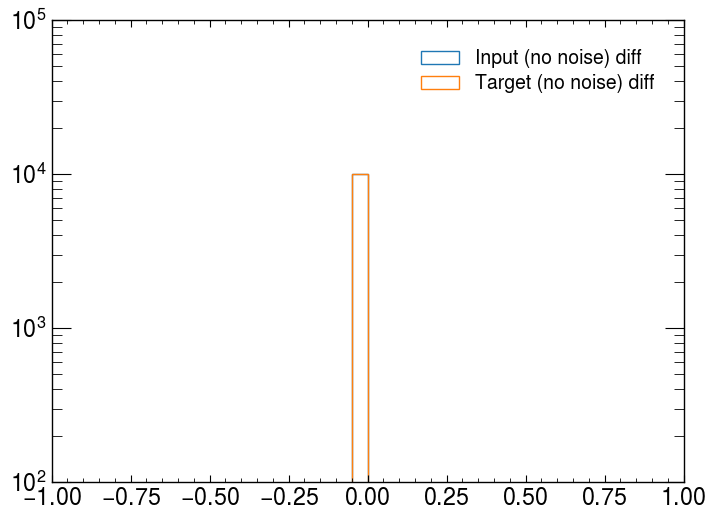

In [ ]:
# plt.hist((inputReshaped[:,0,0] - outputReshaped[:,0,0]))
xbins = getBins(-1,1,0.05)
sample = 0
cell = 5
# plt.hist((outputReshaped[:,cell,sample]),  bins=xbins, histtype='step', label='Output')
# plt.hist((inputReshaped[:,cell,sample]), histtype='step',bins=xbins, label='Input')
# plt.hist((targetReshaped[:,cell,sample]), alpha=0.3, bins=xbins, label='Target')
plt.hist((inputNoNoiseListReshaped[:,cell,sample] - inputReshaped[:,cell,sample]), histtype='step', bins=xbins, label='Input (no noise) diff')
plt.hist((targetNoNoiseListReshaped[:,cell,sample] - targetReshaped[:,cell,sample]), histtype='step', bins=xbins, label='Target (no noise) diff')
plt.yscale('log')
plt.legend()
plt.show()

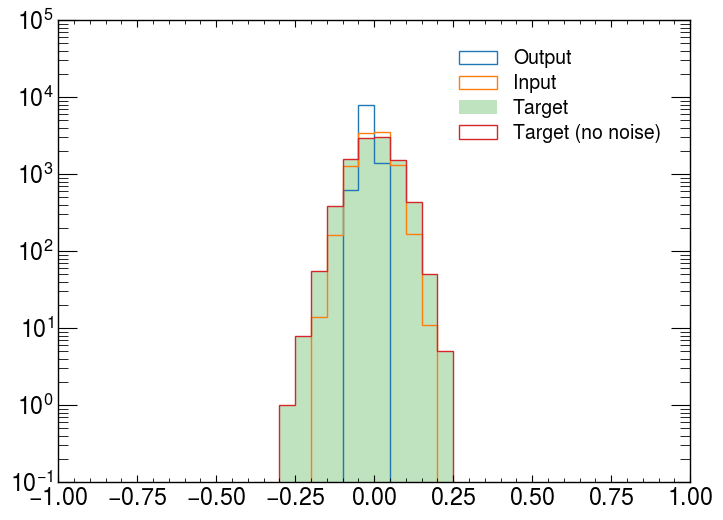

In [ ]:
# plt.hist((inputReshaped[:,0,0] - outputReshaped[:,0,0]))
xbins = getBins(-1,1,0.05)
sample = 0
cell = 5
plt.hist((outputReshaped[:,cell,sample]),  bins=xbins, histtype='step', label='Output')
plt.hist((inputReshaped[:,cell,sample]), histtype='step',bins=xbins, label='Input')
plt.hist((targetReshaped[:,cell,sample]), alpha=0.3, bins=xbins, label='Target')
plt.hist((targetNoNoiseListReshaped[:,cell,sample]), histtype='step', bins=xbins, label='Target (no noise)')
plt.yscale('log')
plt.legend()
plt.show()

In [ ]:
np.shape(inputReshaped.reshape(9960,9,5))

(9960, 9, 5)

In [ ]:
fig = plt.figure(figsize=(25,8))

ax0 = plt.subplot(1,3,1)
xbins = getBins(-2,50,0.05)
plt.hist2d(targetList, outputList,bins=[xbins,xbins], cmin=1,norm=mcolors.SymLogNorm(linthresh=0.5, linscale=1, base=10), cmap=plt.cm.jet)
r2_target_output = r2_score(targetList, outputList)
# r2_target_truth = r2_score(truth_ene, outputList)
plt.plot([0, max(max(targetList), max(outputList))],[0, max(max(targetList), max(outputList))], '--r', label='diagonal\n'+r'  $R^2_{target}=$'+'{:.5f}'.format(r2_target_output))
plt.legend(loc='lower right',fontsize=16)
plt.xlabel('Cluster cell samples [GeV]')
plt.ylabel('Reconstructed cluster cell samples [GeV] 50 MeV/bin')
plt.colorbar()
lorenzettiText()
# hep.atlas.label(data=True,paper=False,year=plotYear, loc=plotATLAS_loc)

ax0 = plt.subplot(1,3,2)
xbins = getBins(-2,2,0.05)
stat_error = 'Target - ML output'+'\n'+r'$\mu={:.3}, \sigma={:.3}$'.format(np.mean(errorList),np.std(errorList))
plt.hist(errorList, bins=xbins, histtype='stepfilled',alpha=0.5, ec='black',fc='yellow', label=stat_error)
plt.xlabel('Sample reconstruction error [GeV] 50 MeV/bin')
plt.ylabel('Counts')
plt.yscale('log')
lorenzettiText()
plt.legend()
# hep.atlas.label(data=True,paper=False,year=plotYear, loc=plotATLAS_loc)

ax0 = plt.subplot(1,3,3)
xbins = getBins(-2,50,0.5)
stat_error1 = 'Input XT samples'#+'\n'+r'$\mu={:.3}, \sigma={:.3}$'.format(np.mean(inputXTEne),np.std(inputXTEne))
stat_error2 = 'Target'#+'\n'+r'$\mu={:.3}, \sigma={:.3}$'.format(np.mean(eneTargetList),np.std(eneTargetList))
stat_error3 = 'ML output'#+'\n'+r'$\mu={:.3}, \sigma={:.3}$'.format(np.mean(eneOutputList),np.std(eneOutputList))
# stat_error4 = 'Truth'#+'\n'+r'$\mu={:.3}, \sigma={:.3}$'.format(np.mean(truth_ene),np.std(truth_ene))
plt.hist(inputList, bins=xbins, histtype='stepfilled',alpha=0.3, ec='black',fc='orange', label=stat_error1)
plt.hist(targetList, bins=xbins, histtype='stepfilled',alpha=0.3, ec='black',fc='red', label=stat_error2)
plt.hist(outputList, bins=xbins, histtype='step', ec='blue', label=stat_error3)
# plt.hist(truth_ene, bins=xbins, histtype='step', ec='green', label=stat_error4)
plt.xlabel('All samples from each cell [GeV] 500 MeV/bin')
plt.ylabel('Counts')
plt.yscale('log')
plt.legend()
plt.show()

In [ ]:
xbins = getBins(-1,1,0.025)
stat_error1 = 'Target - ML output'+'\n'+r'$\mu={:.3}, \sigma={:.3}$'.format(np.mean(eneErrorList),np.std(eneErrorList))
stat_error2 = 'Truth - ML output'+'\n'+r'$\mu={:.3}, \sigma={:.3}$'.format(np.mean(eneErrorOutput),np.std(eneErrorOutput))
stat_error3 = 'Truth - Target'+'\n'+r'$\mu={:.3}, \sigma={:.3}$'.format(np.mean(eneErrorTarget),np.std(eneErrorTarget))
plt.hist(eneErrorList, bins=xbins, histtype='step',ec='black', label=stat_error1)
plt.hist(eneErrorOutput, bins=xbins, histtype='step', ec='blue', label=stat_error2)
plt.hist(eneErrorTarget, bins=xbins, histtype='step', ec='green', label=stat_error3)
plt.xlabel('Energy reconstruction error [GeV] 25MeV/bin', labelpad=labelDistX)
plt.ylabel('Counts')
plt.yscale('log')
plt.legend()
# hep.atlas.label(data=True,paper=False,year=plotYear, loc=plotATLAS_loc)
lorenzettiText()

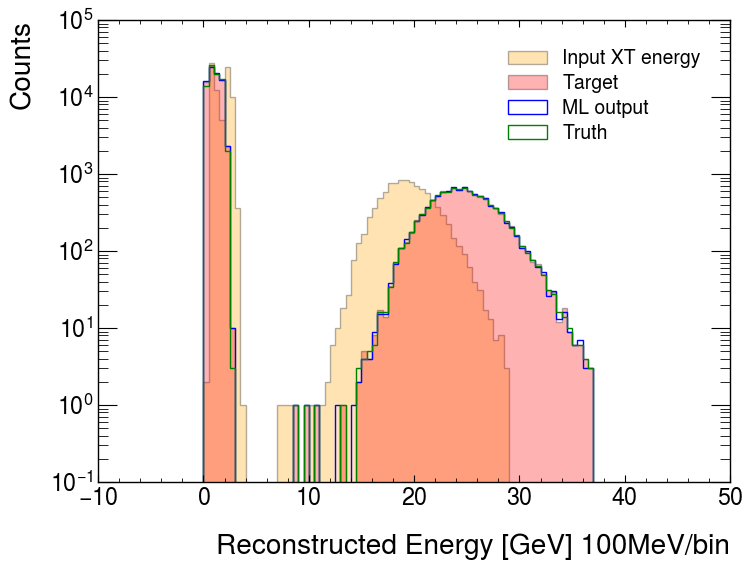

In [ ]:
plt.figure()
xbins = getBins(-2,50,0.5)
stat_error1 = 'Input XT energy'#+'\n'+r'$\mu={:.3}, \sigma={:.3}$'.format(np.mean(inputXTEne),np.std(inputXTEne))
stat_error2 = 'Target'#+'\n'+r'$\mu={:.3}, \sigma={:.3}$'.format(np.mean(eneTargetList),np.std(eneTargetList))
stat_error3 = 'ML output'#+'\n'+r'$\mu={:.3}, \sigma={:.3}$'.format(np.mean(eneOutputList),np.std(eneOutputList))
stat_error4 = 'Truth'#+'\n'+r'$\mu={:.3}, \sigma={:.3}$'.format(np.mean(truth_ene),np.std(truth_ene))
plt.hist(inputXTEne, bins=xbins, histtype='stepfilled',alpha=0.3, ec='black',fc='orange', label=stat_error1)
plt.hist(eneTargetList, bins=xbins, histtype='stepfilled',alpha=0.3, ec='black',fc='red', label=stat_error2)
plt.hist(eneOutputList, bins=xbins, histtype='step', ec='blue', label=stat_error3)
plt.hist(truth_ene, bins=xbins, histtype='step', ec='green', label=stat_error4)
plt.xlabel('Reconstructed Energy [GeV] 100MeV/bin', labelpad=labelDistX)
plt.ylabel('Counts')
plt.yscale('log')
plt.legend()

### 1.3.2 - Parallel Training Algorithm evaluation

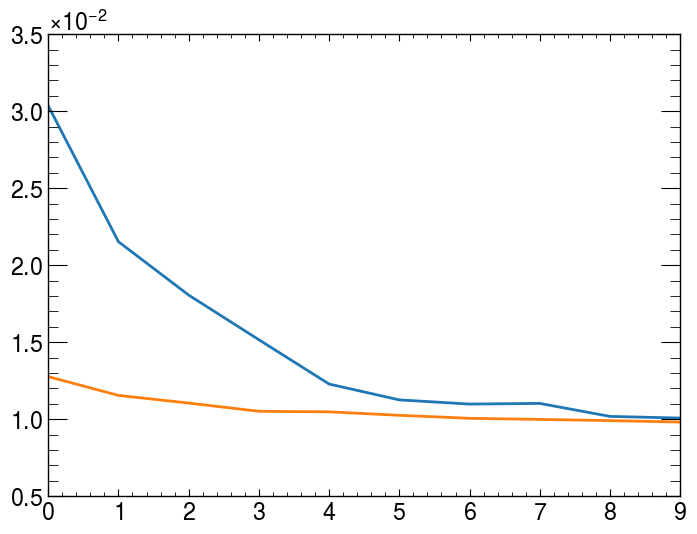

TypeError: list indices must be integers or slices, not str

In [ ]:
plt.plot(train_logging_dictMT[0])
plt.plot(train_logging_dictMT[0])
plt.show()


for proc in range(0,4):
    plt.plot(train_logging_dictMT['loss_history'][proc,:].numpy(),label='proc{}'.format(proc))
plt.legend()
plt.show()

In [ ]:
import argparse
import easydict

parser = argparse.ArgumentParser(description='PyTorch MLP pulseXT-pulse')

parser.add_argument("--optimAlg", help="optimization algorithm.", nargs='?', default='adam', const='alg')
parser.add_argument('--lr', type=float, default=1e-3, metavar='LR',help='learning rate (default: 0.001)')
parser.add_argument('--weightDecay', type=float, default=1e-5, metavar='WDA',help='weight decay adam (default: 1e-5)')
parser.add_argument('--neuronsList',help="optimization algorithm.", nargs='?', default='45,15,15', const='alg')
parser.add_argument("--path", help="optimization algorithm.", nargs='?', default='/data/atlas/mhufnage/xtalk/ml_training/supervised_lzt/_testBench/', const='alg')

args = parser.parse_args([])

In [ ]:
mylist = []
[([int(value) for value in args.neuronsList.split(',')])]

'/data/atlas/mhufnage/xtalk/ml_training/supervised_lzt/_testBench/'

In [ ]:
vars(args)

{'optimAlg': 'adam',
 'lr': 0.001,
 'weightDecay': 1e-05,
 'neuronsList': '45,15,15',
 'path': '/data/atlas/mhufnage/xtalk/ml_training/supervised_lzt/_testBench/'}

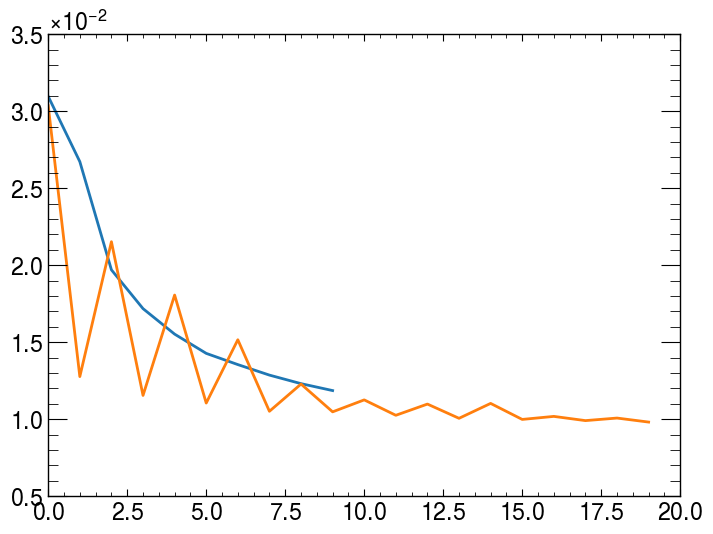

In [ ]:
plt.plot(train_logging_dict['loss'])
plt.plot(ntrain_logging_dictMT.T.reshape(-1))#[0])
# plt.plot(train_logging_dictMT[1])
# plt.plot(train_logging_dict['val_loss'])
plt.show()


45-15-15-45
Total events:  200000


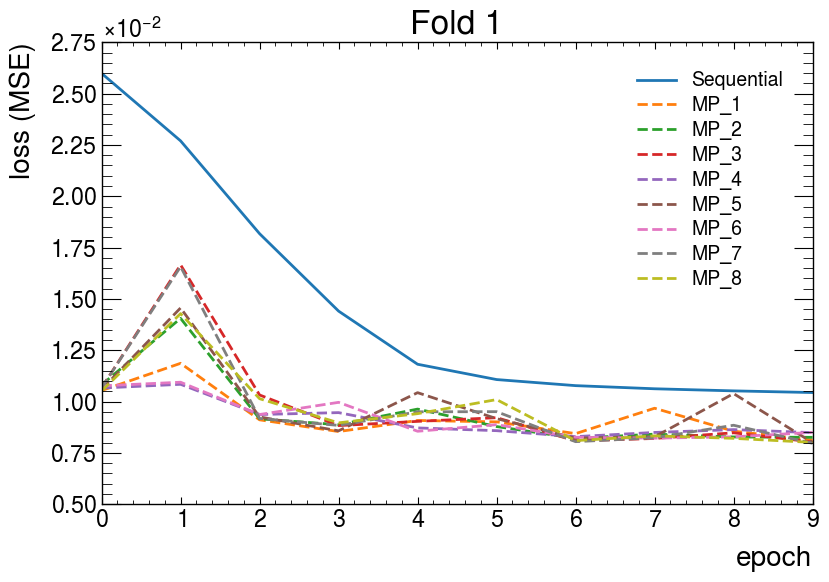

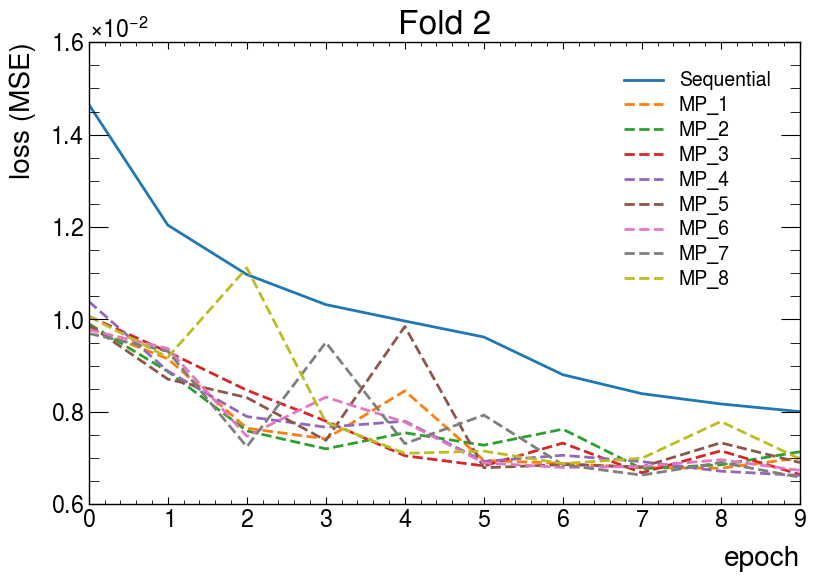

In [ ]:
# matplotlib.use('Agg') #CHANGES THE MATPLOTLIB BACKEND FOR LOOP PLOTS
matplotlib.use('module://ipykernel.pylab.backend_inline')  # show plots

pathLossMT = '/data/atlas/mhufnage/xtalk/ml_training/supervised_lzt/test_hogwild2/'
pathLoss   = '/data/atlas/mhufnage/xtalk/ml_training/supervised_lzt/test_sequential/'

ci_value        = .90 # confidence interval value alpha
boxplotShift    = 0.2

modelSignalType = 'nnp'
optimConfig     = 'adam'
trainNeuList    = [45,15,15] # 2layer (24/05/2024)
range_neuInput  = trainNeuList#[45,20,20]
range_neuText   = MLP.neuListToFileText(range_neuInput)
print(range_neuText)

range_clusSize  = [200000]#5000, 10000, 15000, 20000, 25000, 30000, 35000, 40000, 45000, 50000, 60000, 70000, 150000]#, 10000, 20000, 30000, 50000, 75000, 100000, 150000, 200000, 250000]#, 45000]# batch size in clusters
cellMarkers     = ['x','v','^','<','D','o','>','1','+', '^','*']
cellColors      = ['blue','red','black','green','yellow','purple','cyan','pink','orange','blue', 'red']
resColor        = "red"
# config_train = np.load(pathLoss+'config_train_adam_lr0.001_wd1e-05.npz', allow_pickle=True)['config'].tolist()

plotATLAS_loc   = 2
plotFormat      = 'png'#'pdf'#'png'
plotYear        = 2024

# fig,ax0 = plt.subplots(figsize=(14,8))
# fig1,ax1 = plt.subplots(figsize=(14,8))
# fig2,ax2 = plt.subplots(figsize=(14,8))


for idx, total_clusters in enumerate(range_clusSize):
    print('Total events: ',total_clusters)

    # fig,ax0 = plt.subplots(figsize=(14,8))

    config_train    = np.load(pathLoss+'config_train_nEvts{}_{}_{}_neu{}.npz'.format(total_clusters, modelSignalType, optimConfig, range_neuText), allow_pickle=True)['config'].tolist()
    config_trainMT  = np.load(pathLossMT+'config_train_nEvts{}_{}_{}_neu{}.npz'.format(total_clusters, modelSignalType, optimConfig, range_neuText), allow_pickle=True)['config'].tolist()
    # config_train_filename = pathLoss+'config_train_nEvts{}_{}_{}_neu{}.npz'.format(total_clusters, modelSignalType, optimConfig, range_neuText)
    
    # with np.load(config_train_filename, allow_pickle=True)['config'].tolist() as config_train:

    trainRatio   = config_train['train_ratio']
    batch_size   = config_train['batch_size']
    max_epochs   = config_train['max_epochs']
    patience     = config_train['patience']
    max_iter     = config_train['max_init']
    k            = config_train['kFolds']
    max_rep      = config_train['max_rep']
    num_proc     = config_trainMT['num_processes']
    num_threads  = config_trainMT['num_threads']

    clusters_per_fold_train = round((trainRatio*total_clusters)/k)
    clusters_per_fold_val   = round(((1-trainRatio)*total_clusters)/k)

    # lossAllIterations       = np.zeros((max_epochs, max_iter),dtype=float)
    lossAllIterations       = np.zeros((k, max_iter),dtype=float)
    bestEpochAllIterations  = np.zeros((k, max_iter),dtype=float)
    trainTimehAllIterations = np.zeros((k, max_iter),dtype=float)
    
    lossAllIterationsMT       = np.zeros((k, max_iter),dtype=float)
    bestEpochAllIterationsMT  = np.zeros((k, max_iter),dtype=float)
    trainTimehAllIterationsMT = np.zeros((k, max_iter),dtype=float)

    # for rep in range(max_rep):
    for fold in range(k):
        fig = plt.figure(figsize=(9,6))
        for it in range(max_iter):

            # train_logging_dict  = np.load(pathLoss+'rep{}/loss_nEvts{}_{}_rep{}_fold{}_iter{}_neu{}_batch{}.npz'.format(rep, total_clusters, modelSignalType, rep, fold, it, range_neuText, batch_size),allow_pickle=True)['loss'].tolist()
            train_logging_dictMT    = np.load(pathLossMT+'lossMP_nEvts{}_{}_fold{}_iter{}_neu{}_batch{}.npz'.format(total_clusters, modelSignalType, fold, it, range_neuText, batch_size),allow_pickle=True)['loss'].tolist()
            train_logging_dict      = np.load(pathLoss+'loss_nEvts{}_{}_fold{}_iter{}_neu{}_batch{}.npz'.format(total_clusters, modelSignalType, fold, it, range_neuText, batch_size),allow_pickle=True)['loss'].tolist()
            # myFile = pathLoss+'rep{}/loss_nEvts{}_{}_rep{}_fold{}_iter{}_neu{}_batch{}.npz'.format(rep, total_clusters, modelSignalType, rep, fold, it, range_neuText, batch_size)
            # with np.load(myFile, allow_pickle=True)['loss'].tolist() as train_logging_dict:
            # best_epoch          = train_logging_dict['best_epoch']
            # best_epochMT        = train_logging_dictMT['best_epoch']
            # lossAllIterations[0:len(train_logging_dict['val_loss']),it] = np.array(train_logging_dict['val_loss'])
            
            plt.plot(np.array(train_logging_dict['loss']), label='Sequential')
            # bestEpochAllIterations[fold,it,rep]     = train_logging_dict['best_epoch']
            # trainTimehAllIterations[fold,it,rep]    = train_logging_dict['train_time']/60 # seconds to minutes
            
            mp_loss = np.array(train_logging_dictMT['loss_history'])
            for p in range(num_proc):
                plt.plot(mp_loss[p], '--', label='MP_{}'.format(p+1))
            # bestEpochAllIterationsMT[fold,it,rep]     = train_logging_dictMT['best_epoch']
            # trainTimehAllIterationsMT[fold,it,rep]    = train_logging_dictMT['train_time']/60 # seconds to minutes
            # if it < 9:
            #     ax0.plot(epochs ,train_logging_dict['val_loss'] , '--',lw=1.1, c=cellColors[idx])
            # else:
            #     ax0.plot(epochs ,train_logging_dict['val_loss'] , '--',lw=1.1, c=cellColors[idx], label='train  clus. {}'.format(clusters_per_fold_train))
        plt.title('Fold {}'.format(fold+1))
        plt.xlabel('epoch')
        plt.ylabel('loss (MSE)')
        plt.legend()
        plt.show()
    # val_loss        = np.mean(lossAllIterations, axis=(2,1)) # flat max_rep and max_iter, remaining only the k-folds
    # avg_epochs      = np.mean(bestEpochAllIterations, axis=(2,1)) # flat max_rep and max_iter, remaining only the k-folds
    # avg_train_time  = np.mean(trainTimehAllIterations, axis=(2,1)) # flat max_rep and max_iter, remaining only the k-folds
    
    # val_lossMT        = np.mean(lossAllIterationsMT, axis=(2,1)) # flat max_rep and max_iter, remaining only the k-folds
    # avg_epochsMT      = np.mean(bestEpochAllIterationsMT, axis=(2,1)) # flat max_rep and max_iter, remaining only the k-folds
    # avg_train_timeMT  = np.mean(trainTimehAllIterationsMT, axis=(2,1)) # flat max_rep and max_iter, remaining only the k-folds
    
    # bp1 = ax0.boxplot(val_loss,  patch_artist=True, positions=[idx+1-boxplotShift], boxprops=dict(facecolor=resColor, color=resColor))
    # ax1.boxplot(avg_epochs, patch_artist=True, positions=[idx+1-boxplotShift], boxprops=dict(facecolor=resColor, color=resColor))
    # ax2.boxplot(avg_train_time,  patch_artist=True, positions=[idx+1-boxplotShift], boxprops=dict(facecolor=resColor, color=resColor))
    
    # bp2 = ax0.boxplot(val_lossMT, positions=[idx+1+boxplotShift])
    # ax1.boxplot(avg_epochsMT, positions=[idx+1+boxplotShift])
    # ax2.boxplot(avg_train_timeMT, positions=[idx+1+boxplotShift])
    
    # ax0.boxplot(val_loss, positions=[total_clusters])

    # meanLoss = np.mean(lossAllIterations, axis=1)
    # stdLoss  = np.std(lossAllIterations, axis=1)
    # confIntLower, confIntUpper, lowErrorBar, upperErrorBar  = confInterval(alfa=ci_value, data=lossAllIterations)
    # epochs   = range(1,len(meanLoss)+1)
    

    # if total_clusters==1000:
    #     a = confIntLower
    #     b = confIntUpper
    #     c = lossAllIterations
    
    # ax0.plot(epochs ,meanLoss , '-',lw=1.1, c=cellColors[idx], label='{} train / {} val. clusters'.format(clusters_per_fold_train,clusters_per_fold_val))
    # ax0.fill_between(epochs, confIntLower, confIntUpper, alpha=0.4 , facecolor=cellColors[idx])
    # ax0.fill_between(epochs, meanLoss-stdLoss, meanLoss+stdLoss, alpha=0.4 , facecolor=cellColors[idx])

# plt.xlabel('Epochs')
# plt.ylabel('Validation Samples Loss')
# plt.legend(fontsize=17)
# hep.atlas.label(data=True,paper=False,year=plotYear, loc=plotATLAS_loc)
# # ax0.text(s='Train clusters: {}\nVal. Clusters: {}\nBatch: {}'.format(clusters_per_fold_train, clusters_per_fold_val, batch_size),x=0.2,y=0.1, transform=ax0.transAxes, fontsize=14, ha='left', color='black')
# # ax0.text(s='Train clusters: {}\nVal. Clusters: {}'.format(clusters_per_fold_train, clusters_per_fold_val),x=0.1,y=0.1, transform=ax0.transAxes, fontsize=14, ha='left', color='black')
# ax0.text(s='CI: {}%\nInitializations: {}'.format(int(ci_value*100), max_iter),x=0.05,y=0.025, transform=ax0.transAxes, fontsize=14, ha='left', color='black')
# plt.yscale('log')
# # plt.ylim([1e-12, 1])

# # nLay            = config_train['nLayers']
# # neuIn           = config_train['nNeuronsInput']
# # bn              = config_train['bn_neurons']

# # hep.save_variations(fig, pathLoss+'datasetAnalysis_lossPlotAllCells_fold{}_iter{}_neuIn{}_nLay{}_bn{}_.{}'.format(fold, it, neuIn, nLay, bn, plotFormat),text_list=['Preliminary', 'Work in progress'])
# # hep.save_variations(fig, pathLoss+'datasetAnalysis_allLines_lossPlotAllCells_fold{}_iter{}_neuIn{}_nLay{}_bn{}_.{}'.format(fold, it, neuIn, nLay, bn, plotFormat),text_list=['Preliminary', 'Work in progress'])
# # plt.close()
# ax0.set_xticks([i+1 for i in range(len(range_clusSize))],[range_clusSize])
# ax0.set_xticklabels(range_clusSize)


# ax0.legend([bp1["boxes"][0], bp2["boxes"][0]], ['Sequential', 'Multiprocess'], loc='upper right')

# ax0.set_title("Folds: {}, Init: {}, Max. epochs: {}, Training repetition: {}, \nPatience: {}".format(k, max_iter, max_epochs, max_rep, patience))
# ax0.set_xlabel("Total number of clusters on training+valid dataset")
# ax0.set_ylabel("MSE: validation loss")

# ax1.set_xticklabels(range_clusSize)
# ax1.set_title("Folds: {}, Init: {}, Max. epochs: {}, Training repetition: {}, \nPatience: {}".format(k, max_iter, max_epochs, max_rep, patience))
# ax1.set_xlabel("Total number of clusters on training+valid dataset")
# ax1.set_ylabel("Best training epoch")
# # ax1.set_ylim(0,105)

# # ax2.set_xticklabels(range_clusSize)
# ax2.set_title("Folds: {}, Init: {}, Max. epochs: {}, Training repetition: {}, \nPatience: {}".format(k, max_iter, max_epochs, max_rep, patience))
# ax2.set_xlabel("Total number of clusters on training+valid dataset")
# ax2.set_ylabel("Training time (min)")

plt.show(fig)
# plt.show(fig1)
# plt.show(fig2)



In [ ]:
# matplotlib.use('Agg') #CHANGES THE MATPLOTLIB BACKEND FOR LOOP PLOTS
matplotlib.use('module://ipykernel.pylab.backend_inline')  # show plots

pathLossMT = '/data/atlas/mhufnage/xtalk/ml_training/supervised_lzt/test_hogwild2/'
pathLoss   = '/data/atlas/mhufnage/xtalk/ml_training/supervised_lzt/test_sequential/'

ci_value        = .90 # confidence interval value alpha
boxplotShift    = 0.2

modelSignalType = 'nnp'
optimConfig     = 'adam'
trainNeuList    = [45,15,15] # 2layer (24/05/2024)
range_neuInput  = trainNeuList#[45,20,20]
range_neuText   = MLP.neuListToFileText(range_neuInput)
print(range_neuText)

range_clusSize  = [200000]#5000, 10000, 15000, 20000, 25000, 30000, 35000, 40000, 45000, 50000, 60000, 70000, 150000]#, 10000, 20000, 30000, 50000, 75000, 100000, 150000, 200000, 250000]#, 45000]# batch size in clusters
cellMarkers     = ['x','v','^','<','D','o','>','1','+', '^','*']
cellColors      = ['blue','red','black','green','yellow','purple','cyan','pink','orange','blue', 'red']
resColor        = "red"
# config_train = np.load(pathLoss+'config_train_adam_lr0.001_wd1e-05.npz', allow_pickle=True)['config'].tolist()

plotATLAS_loc   = 2
plotFormat      = 'png'#'pdf'#'png'
plotYear        = 2024

# fig,ax0 = plt.subplots(figsize=(14,8))
# fig1,ax1 = plt.subplots(figsize=(14,8))
# fig2,ax2 = plt.subplots(figsize=(14,8))


for idx, total_clusters in enumerate(range_clusSize):
    print('Total events: ',total_clusters)

    # fig,ax0 = plt.subplots(figsize=(14,8))

    config_train    = np.load(pathLoss+'config_train_nEvts{}_{}_{}_neu{}.npz'.format(total_clusters, modelSignalType, optimConfig, range_neuText), allow_pickle=True)['config'].tolist()
    config_trainMT  = np.load(pathLossMT+'config_train_nEvts{}_{}_{}_neu{}.npz'.format(total_clusters, modelSignalType, optimConfig, range_neuText), allow_pickle=True)['config'].tolist()
    # config_train_filename = pathLoss+'config_train_nEvts{}_{}_{}_neu{}.npz'.format(total_clusters, modelSignalType, optimConfig, range_neuText)
    
    # with np.load(config_train_filename, allow_pickle=True)['config'].tolist() as config_train:

    trainRatio   = config_train['train_ratio']
    batch_size   = config_train['batch_size']
    max_epochs   = config_train['max_epochs']
    patience     = config_train['patience']
    max_iter     = config_train['max_init']
    k            = config_train['kFolds']
    max_rep      = config_train['max_rep']
    num_proc     = config_trainMT['num_processes']
    num_threads  = config_trainMT['num_threads']

    clusters_per_fold_train = round((trainRatio*total_clusters)/k)
    clusters_per_fold_val   = round(((1-trainRatio)*total_clusters)/k)

    # lossAllIterations       = np.zeros((max_epochs, max_iter),dtype=float)
    lossAllIterations       = np.zeros((k, max_iter),dtype=float)
    bestEpochAllIterations  = np.zeros((k, max_iter),dtype=float)
    trainTimehAllIterations = np.zeros((k, max_iter),dtype=float)
    
    lossAllIterationsMT       = np.zeros((k, max_iter),dtype=float)
    bestEpochAllIterationsMT  = np.zeros((k, max_iter),dtype=float)
    trainTimehAllIterationsMT = np.zeros((k, max_iter),dtype=float)

    # for rep in range(max_rep):
    for fold in range(k):
        fig = plt.figure(figsize=(9,6))
        for it in range(max_iter):

            # train_logging_dict  = np.load(pathLoss+'rep{}/loss_nEvts{}_{}_rep{}_fold{}_iter{}_neu{}_batch{}.npz'.format(rep, total_clusters, modelSignalType, rep, fold, it, range_neuText, batch_size),allow_pickle=True)['loss'].tolist()
            train_logging_dictMT    = np.load(pathLossMT+'lossMP_nEvts{}_{}_fold{}_iter{}_neu{}_batch{}.npz'.format(total_clusters, modelSignalType, fold, it, range_neuText, batch_size),allow_pickle=True)['loss'].tolist()
            train_logging_dict      = np.load(pathLoss+'loss_nEvts{}_{}_fold{}_iter{}_neu{}_batch{}.npz'.format(total_clusters, modelSignalType, fold, it, range_neuText, batch_size),allow_pickle=True)['loss'].tolist()
            # myFile = pathLoss+'rep{}/loss_nEvts{}_{}_rep{}_fold{}_iter{}_neu{}_batch{}.npz'.format(rep, total_clusters, modelSignalType, rep, fold, it, range_neuText, batch_size)
            # with np.load(myFile, allow_pickle=True)['loss'].tolist() as train_logging_dict:
            # best_epoch          = train_logging_dict['best_epoch']
            # best_epochMT        = train_logging_dictMT['best_epoch']
            # lossAllIterations[0:len(train_logging_dict['val_loss']),it] = np.array(train_logging_dict['val_loss'])
            
            plt.plot(np.array(train_logging_dict['loss']), label='Sequential')
            # bestEpochAllIterations[fold,it,rep]     = train_logging_dict['best_epoch']
            # trainTimehAllIterations[fold,it,rep]    = train_logging_dict['train_time']/60 # seconds to minutes
            
            mp_loss = np.array(train_logging_dictMT['loss_history'])
            for p in range(num_proc):
                plt.plot(mp_loss[p], '--', label='MP_{}'.format(p+1))
                
        plt.title('Fold {}'.format(fold+1))
        plt.xlabel('epoch')
        plt.ylabel('loss (MSE)')
        plt.legend()
        plt.show()




[49.030086517333984] [46.88788652420044]


## 2.1 - PhD Qualify: Truth Supervised model **S->E / S->t**
- Input: set of 3x3 cells samples **with** crosstalk effect.
- Target: set of same 3x3 cells, with their energies/timing **without** crosstalk.
- OFC E and tau should be estimated during training.
- OFC blocks should be attached to the model for this process.

In [2]:
# 
# *******************************************************************************************************************

pathLoss      = '/data/atlas/mhufnage/xtalk/ml_training/supervised_lzt/test/'

conditions = {
        'nEvents':         10000, # <--- it is the total events to feed KFold_split into (train+valid)+(test).
        'SigmaCut':        1,
        'etaCut':          1.4,
        'caloSampling':    'EM2',#CaloSampling.EMB2,
        'etaSize':         3,
        'phiSize':         3,
        'nSamples':        5,
        'dumpCells':       True,
        'bDumpWindowOnly': True,
        'bNoEneCut':       True,
        'XTalk_ind':       1.1,
        'XTalk_cap':       0.0,
        'XTalkLevel':      'L = 1.1%, C = 0.0%',
        
        # Not implemented yet!
        'etBin':           [[15 , 20] ,[20, 30]  ,[30, 40]  ,[40, 50],[50,100],[100,10000000]],
        'etaBin':          [[0.00, 0.80], [0.80, 1.37], [1.37,1.54],[1.54,2.50],[2.50,3.2]],
        'bPhaseSpaceDiv':  False,
    }

conditionsTest = {
        'nEvents':         10000, # <--- it is the total events to feed KFold_split into (train+valid)+(test).
        'SigmaCut':        1,
        'etaCut':          1.4,
        'caloSampling':    'EM2',#CaloSampling.EMB2,
        'etaSize':         3,
        'phiSize':         3,
        'nSamples':        5,
        'dumpCells':       True,
        'bDumpWindowOnly': True,
        'bNoEneCut':       True,
        'XTalk_ind':       1.1,
        'XTalk_cap':       0.0,
        'XTalkLevel':      'L = 1.1%, C = 0.0%',
        
        # Not implemented yet!
        'etBin':           [[15 , 20] ,[20, 30]  ,[30, 40]  ,[40, 50],[50,100],[100,10000000]],
        'etaBin':          [[0.00, 0.80], [0.80, 1.37], [1.37,1.54],[1.54,2.50],[2.50,3.2]],
        'bPhaseSpaceDiv':  False,
    }

if not(os.path.isdir(pathLoss)):
    os.mkdir(pathLoss)

startTime=time()
# Dataset
data = TChain('ML_tree')
for ds_index in range(1,10):
    theFile = '/data/atlas/mhufnage/lzt_single_e/elec_singleCell_10kEvts_centroid_e50_DS{}/AOD_Cap{:.1f}_Ind{:.1f}/user.mhufnage.lzt.e50.xtalk.DS{}.win{}{}.nopileup.WithCells_{}.root'.format(ds_index, conditions['XTalk_cap'], conditions['XTalk_ind'], ds_index, conditions['etaSize'], conditions['phiSize'], conditions['caloSampling'])
    data.Add(theFile+'/ML_tree')

dataTest = TChain('ML_tree')
for ds_index in range(20,25):
    theFile = '/data/atlas/mhufnage/lzt_single_e/elec_singleCell_10kEvts_centroid_e50_DS{}/AOD_Cap{:.1f}_Ind{:.1f}/user.mhufnage.lzt.e50.xtalk.DS{}.win{}{}.nopileup.WithCells_{}.root'.format(ds_index, conditions['XTalk_cap'], conditions['XTalk_ind'], ds_index, conditions['etaSize'], conditions['phiSize'], conditions['caloSampling'])
    dataTest.Add(theFile+'/ML_tree')

datasetTrain = XTalkDataset_LZT_FromROOT(data,      conditions, mode='supervisedOFC', load_full_data=True)
datasetTest  = XTalkDataset_LZT_FromROOT(dataTest,  conditionsTest, mode='supervisedOFC', load_full_data=True)


# train_fold    = DataLoader( datasetTrain, batch_size=args.batch_size, shuffle=False, sampler=train_fold_sampler)

[XTalkDataset_LZT_FromROOT] Event idx 0/10000
[XTalkDataset_LZT_FromROOT] Event idx 0/10000


In [3]:

#******************************************************************************************************************

pathLoss    = '/data/atlas/mhufnage/xtalk/ml_training/supervised_lzt/test/'

scalerInput=torch.tensor(1/1000)
scalerOutput=torch.tensor(1000)
nEpochs=100
batch_size=64

train_idx   = np.arange(0,int(4/5*conditions['nEvents']))
valid_idx   = np.arange(int(4/5*conditions['nEvents']),conditions['nEvents'])
test_idx    = np.arange(0,conditionsTest['nEvents'])

train_sampler  = KFoldSampler(train_idx)
val_sampler    = KFoldSampler(valid_idx)
test_sampler   = KFoldSampler(test_idx)

train_loader = DataLoader(datasetTrain, batch_size=batch_size, shuffle=False, sampler=train_sampler)
val_loader   = DataLoader(datasetTrain, batch_size=batch_size, shuffle=False, sampler=val_sampler)
test_loader  = DataLoader(datasetTest,  batch_size=1, shuffle=False, sampler=test_sampler)



Comentários: 

- a rede com saídas em forma de pulso têm seus nós ligados a um conjunto de OFCa (energia), como linearModel (torch)
- logo, a energia pra cada célula é estimada.
- o erro (loss) é calculado e retropropagado somente para a rede inicial.
- o loss_monitor, que calcula o loss das samples não converge para valores pequenos, como observado quando se utiliza apenas a rede para treinar, colocando como target o valor de cada sample.
- no entanto, o ofca_loss tende à convergência para um 'mínimo global'.
- ao testar essa rede, mesmo com o sample_loss muito alto, ela estima amostras que são passíveis de uma boa reconstrução de energia!

Train

In [5]:
# class torch_OFCTime_LZT(nn.Module):
#     '''
#     its the torch model with an OFC coeff.
    
#     '''
    
#     def __init__(self, neta=3, nphi=3, nsamples=5, samplingNoise=60):
#         super(torch_OFCTime_LZT, self).__init__() 
        
#         self.samplingNoise = samplingNoise
        
#         filter_weigths = []

#         filter_weigths = [ -0.22673589675790157, -18.897965812858967, 1.1980699915128548, 10.935880735903003, 5.0777868302019415 ]
        
#         # all_cells_filter_weights = []
        
#         # for 9 cells, add the OFC coeff for each one of them
#         # as for LZT they are all the same, just repeat the pattern of weights
#         # neuModuleList = nn.ModuleList()
        
#         self.OFC       = torch.tensor(filter_weigths, requires_grad=False, dtype=torch.float) # from lzt main
            
#         self.filter1 = nn.Linear(nsamples, 1, bias=False)
#         self.filter1.weight = nn.Parameter(self.OFC, requires_grad=False)
        
#         self.filter2 = nn.Linear(nsamples, 1, bias=False)
#         self.filter2.weight = nn.Parameter(self.OFC, requires_grad=False)
        
#         self.filter3 = nn.Linear(nsamples, 1, bias=False)
#         self.filter3.weight = nn.Parameter(self.OFC, requires_grad=False)
        
#         self.filter4 = nn.Linear(nsamples, 1, bias=False)
#         self.filter4.weight = nn.Parameter(self.OFC, requires_grad=False)
        
#         self.filter5 = nn.Linear(nsamples, 1, bias=False)
#         self.filter5.weight = nn.Parameter(self.OFC, requires_grad=False)
        
#         self.filter6 = nn.Linear(nsamples, 1, bias=False)
#         self.filter6.weight = nn.Parameter(self.OFC, requires_grad=False)
        
#         self.filter7 = nn.Linear(nsamples, 1, bias=False)
#         self.filter7.weight = nn.Parameter(self.OFC, requires_grad=False)
        
#         self.filter8 = nn.Linear(nsamples, 1, bias=False)
#         self.filter8.weight = nn.Parameter(self.OFC, requires_grad=False)
        
#         self.filter9 = nn.Linear(nsamples, 1, bias=False)
#         self.filter9.weight = nn.Parameter(self.OFC, requires_grad=False)
        
        
#         self.criterion = nn.MSELoss()
        
#     def forward(self, inData, energies):
#         # mask the energies which are below sampling noise criteria, as zero timing (like LAr DSP)
#         # timing is get by dividing OFC(samples)/energy
        
#         masked_energies = (energies >= 2*self.samplingNoise).int().float()
        
#         x1 = (self.filter1(inData[:,0:5])*masked_energies[:,0]) / energies[:,0]
#         x2 = (self.filter2(inData[:,5:10])*masked_energies[:,1]) / energies[:,1]
#         x3 = (self.filter3(inData[:,10:15])*masked_energies[:,2]) / energies[:,2]
#         x4 = (self.filter4(inData[:,15:20])*masked_energies[:,3]) / energies[:,3]
#         x5 = (self.filter5(inData[:,20:25])*masked_energies[:,4]) / energies[:,4]
#         x6 = (self.filter6(inData[:,25:30])*masked_energies[:,5]) / energies[:,5]
#         x7 = (self.filter7(inData[:,30:35])*masked_energies[:,6]) / energies[:,6]
#         x8 = (self.filter8(inData[:,35:40])*masked_energies[:,7]) / energies[:,7]
#         x9 = (self.filter9(inData[:,40:45])*masked_energies[:,8]) / energies[:,8]
        
#         return torch.transpose(torch.stack((x1,x2,x3,x4,x5,x6,x7,x8,x9)),dim0=0, dim1=1)
    
model       = MLP.MLP_FF( neuronsList=[45,100,100])
ofca_model  = MLP.torch_OFCEnergy_LZT()
ofcb_model  = MLP.torch_OFCTime_LZT(scaler=scalerInput)

for data_input, target_pulse, target_ene, target_time, batch_idx in train_loader:
    
    output          = model(data_input*scalerInput) #normalized (not yet exactly) input    
    ofca_output     = ofca_model(target_pulse) #uses DE-normalized output
    ofcb_output     = ofcb_model(target_pulse*scalerInput, target_ene*scalerInput) #uses DE-normalized output
    
    print('ofca_output',ofca_output)
    print('ofcb_output',ofcb_output)
    print('datasetEnergy',datasetTrain.e[0:batch_size])
    print('datasetTime',datasetTrain.t[0:batch_size])
    break


ofca_output tensor([[  452.6479,  1317.2247,   533.6530,  1617.8145, 25030.2910,  2030.0083,
           599.3127,  1166.8899,   524.4429],
        [  528.2982,  1264.4692,   637.0654,  1943.4619, 26082.9941,  1800.7850,
           353.4583,  1306.6095,   424.1384],
        [  500.2578,  1157.5159,   533.5452,  1796.3065, 24531.0215,  1775.6934,
           504.7212,  1328.9474,   581.9409],
        [  630.4188,  1300.8593,   676.9514,  1742.6785, 25536.0156,  1878.1068,
           565.7513,  1221.1125,   521.3159],
        [  324.2892,  1181.2357,   488.5442,  1783.4253, 23205.9688,  1842.5137,
           334.7615,  1037.8341,   532.6611],
        [  667.9158,  1312.6462,   570.0573,  1696.5970, 23678.4824,  1946.3662,
           421.5474,  1015.9399,   631.3267],
        [  343.2793,  1369.5951,   513.4052,  1403.9960, 22006.8496,  1579.3505,
           672.3949,  1291.6346,   599.5663],
        [  364.3566,  1182.8199,   624.6388,  1650.9700, 21355.2812,  1594.3436,
           462.744

In [4]:
# typeModelTrainList = ['ene', 'time','eneTime']
typeModelTrainList = ['eneTime']

for typeModelTrain in typeModelTrainList:
    model       = MLP.MLP_FF( neuronsList=[45,250,250])
    ofca_model  = MLP.torch_OFCEnergy_LZT()
    ofcb_model  = MLP.torch_OFCTime_LZT(scaler=scalerInput)

    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

    loss_log = {
        'ofc_loss_ene'          :   [],
        'ofc_loss_time'         :   [],
        'ofc_val_loss_ene'      :   [],
        'ofc_val_loss_time'     :   [],
        'sample_loss'           :   [],
        'sample_val_loss'       :   []
    }

    for epoch in range(nEpochs):
        for data_input, target_pulse, target_ene, target_time, batch_idx in train_loader:
            
            output          = model(data_input*scalerInput) #normalized (not yet exactly) input
            
            ofca_output     = ofca_model(output) #uses normalized output
            ofcb_output     = ofcb_model(output, target_ene*scalerInput) #uses normalized output
            # ofc_output      = ofca_model(target_pulse*scalerInput)
            
            # print('data_input[:,0:5]',data_input[:,0:5])
            # print('data_input[:,20:25]',data_input[:,20:25])
            
            loss_monitor  = model.criterion(output, target_pulse*scalerInput) # monitoring normalized target_pulse
            loss_ene      = ofca_model.criterion(ofca_output, target_ene*scalerInput) # normalized targets
            loss_time     = ofcb_model.criterion(ofcb_output, target_time*scalerInput) # normalized targets
            # loss            = ofca_model.criterion(ofc_output, target) # UNnormalized targets
            
            # ene_target, tau_target    = datasetTrain.calibrate(batch_idx, target) # unormlized target
            # ene_output, tau_output    = datasetTrain.calibrate(batch_idx, output*scalerOutput) # denormalized output

            optimizer.zero_grad()
            
            if typeModelTrain=='ene':
                loss_ene.backward()
            elif typeModelTrain=='time':
                loss_time.backward()
            elif typeModelTrain=='eneTime':
                (loss_ene+loss_time).backward()
            optimizer.step()
            
        loss_log['ofc_loss_ene'].append(loss_ene.item())
        loss_log['ofc_loss_time'].append(loss_time.item())
        loss_log['sample_loss'].append(loss_monitor.item())
            
            # break
        for data_input, target_pulse, target_ene, target_time, batch_idx in val_loader:
            
            output           = model(data_input*scalerInput) #normalized (not yet exactly) input        
            ofca_output      = ofca_model(output) #uses normalized output
            ofcb_output      = ofcb_model(output, target_ene*scalerInput) #uses normalized output
            # ofc_output      = ofca_model(target_pulse*scalerInput)
            
            
            val_loss_monitor = model.criterion(output, target_pulse*scalerInput) # monitoring normalized target_pulse
            val_loss_ene     = ofca_model.criterion(ofca_output, target_ene*scalerInput) # normalized targets
            val_loss_time    = ofcb_model.criterion(ofcb_output, target_time*scalerInput) # normalized targets
            # val_loss            = ofca_model.criterion(ofc_output, target) # UNnormalized targets
            
        loss_log['ofc_val_loss_ene'].append(val_loss_ene.item())
        loss_log['ofc_val_loss_time'].append(val_loss_time.item())
        loss_log['sample_val_loss'].append(val_loss_monitor.item())
        
        
        # loss_log.append(loss.detach().numpy())
        print('Epoch {}/{}...monitor_loss={:.5f}, ene_loss={:.5f}, time_loss={:.5f}, monitor_val_loss={:.5f}, ene_val_loss={:.5f}, time_val_loss={:.5f}'.format(epoch,nEpochs,loss_monitor.item(), loss_ene.item(), loss_time.item(), val_loss_monitor.item(), val_loss_ene.item(), val_loss_time.item()))

    #
    # Save model and loss
    #
    np.savez(pathLoss+'loss_model_ofc_{}.npz'.format(typeModelTrain),loss=loss_log)
    filename = pathLoss+'torchModel_ofc_{}.pth'.format(typeModelTrain)
    MLP.checkpoint(model, optimizer, filename, nEpochs, val_loss_time.item())


Epoch 0/100...monitor_loss=13.75556, ene_loss=0.07312, time_loss=0.05115, monitor_val_loss=13.76212, ene_val_loss=0.06006, time_val_loss=0.08779
Epoch 1/100...monitor_loss=13.74647, ene_loss=0.07167, time_loss=0.09102, monitor_val_loss=13.75433, ene_val_loss=0.05985, time_val_loss=0.11136
Epoch 2/100...monitor_loss=13.74045, ene_loss=0.06959, time_loss=0.18982, monitor_val_loss=13.74905, ene_val_loss=0.05848, time_val_loss=0.05068
Epoch 3/100...monitor_loss=13.73901, ene_loss=0.06822, time_loss=0.25532, monitor_val_loss=13.74773, ene_val_loss=0.05799, time_val_loss=0.07119
Epoch 4/100...monitor_loss=13.74256, ene_loss=0.06562, time_loss=0.10450, monitor_val_loss=13.75178, ene_val_loss=0.05626, time_val_loss=0.05771
Epoch 5/100...monitor_loss=13.74734, ene_loss=0.06404, time_loss=0.06524, monitor_val_loss=13.75552, ene_val_loss=0.05489, time_val_loss=0.10164
Epoch 6/100...monitor_loss=13.76335, ene_loss=0.06299, time_loss=0.03181, monitor_val_loss=13.76985, ene_val_loss=0.05398, time_va

Plot Train

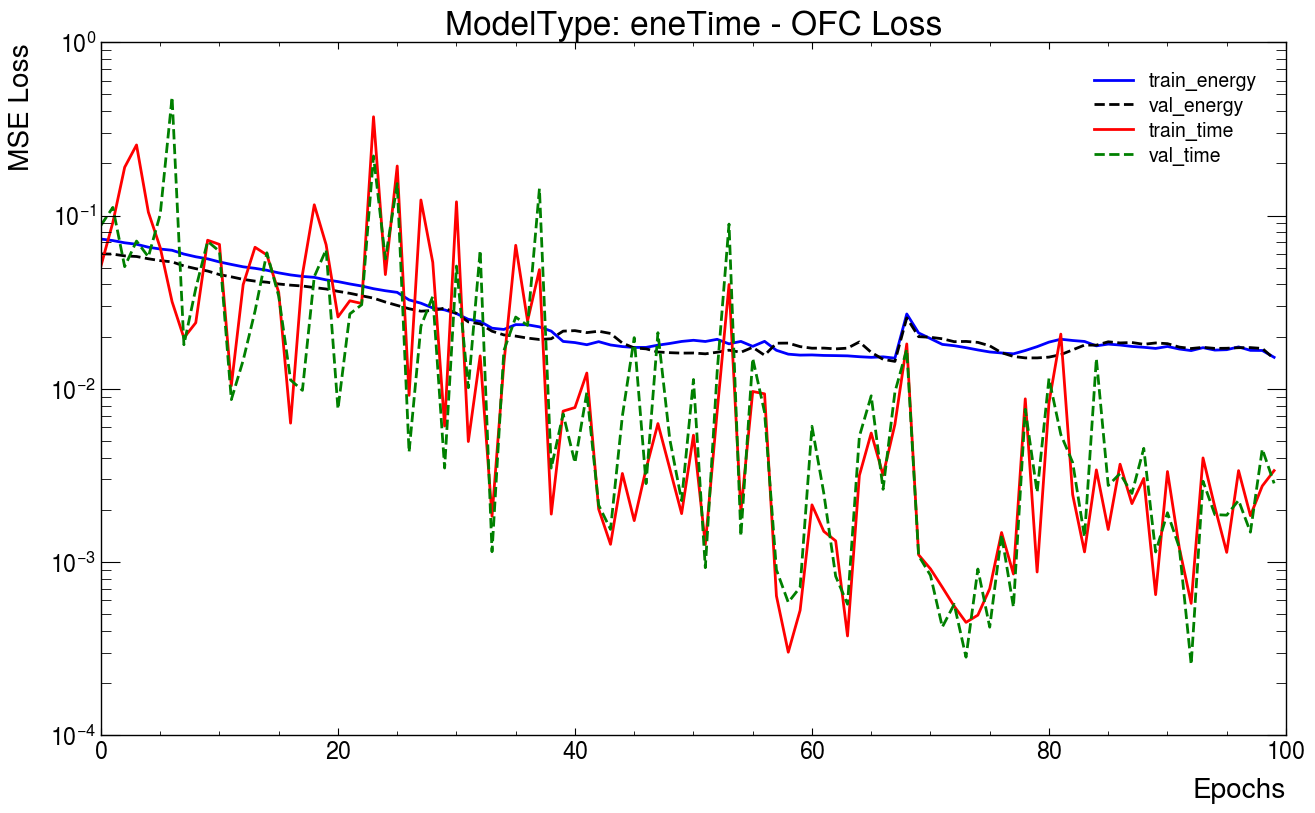

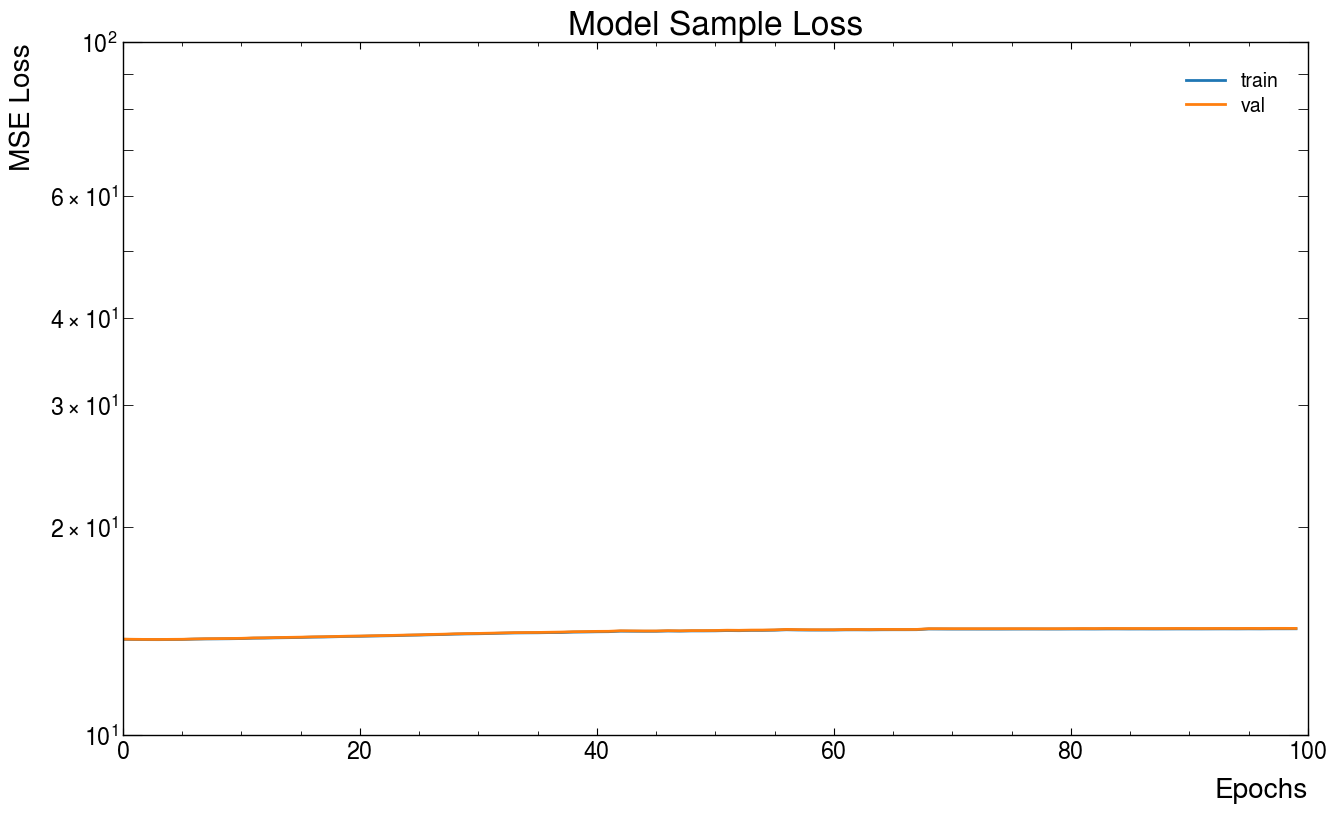

In [6]:
typeModelTrainList = ['eneTime']

for typeModelTrain in typeModelTrainList:
    loss_log = np.load(pathLoss+'loss_model_ofc_{}.npz'.format(typeModelTrain), allow_pickle=True)['loss'].tolist()
    # time_loss_log = np.load(pathLoss+'loss_model_ofc_time.npz', allow_pickle=True)['loss'].tolist()
    # eneTime_loss_log = np.load(pathLoss+'loss_model_ofc_eneTime.npz', allow_pickle=True)['loss'].tolist()

    plt.figure(figsize=(15,9))
    plt.plot(loss_log['ofc_loss_ene'], 'b-',label='train_energy')
    plt.plot(loss_log['ofc_val_loss_ene'], 'k--',label='val_energy')
    plt.plot(loss_log['ofc_loss_time'], 'r-',label='train_time')
    plt.plot(loss_log['ofc_val_loss_time'], 'g--',label='val_time')
    # plt.plot(np.array(loss_log['ofc_loss_time'])+np.array(loss_log['ofc_loss_ene']), 'orange',label='total_loss')
    plt.title('ModelType: {} - OFC Loss'.format(typeModelTrain))
    plt.xlabel('Epochs')
    plt.ylabel('MSE Loss')
    plt.legend()
    plt.yscale('log')
    # plt.xscale('log')
    plt.show()

    plt.figure(figsize=(15,9))
    plt.plot(loss_log['sample_loss'], label='train')
    plt.plot(loss_log['sample_val_loss'], label='val')
    plt.title('Model Sample Loss')
    plt.xlabel('Epochs')
    plt.ylabel('MSE Loss')
    plt.legend()
    plt.yscale('log')
    # plt.xscale('log')
    plt.show()

 Test

In [19]:
# np.load(pathLoss+'loss_model_ofc_ene.npz', allow_pickle=True)['loss'].tolist().keys()
ofca_model  = MLP.torch_OFCEnergy_LZT()
ofcb_model  = MLP.torch_OFCTime_LZT()

# typeModelTrainList = ['ene', 'time','eneTime']
typeModelTrainList = ['eneTime']

for typeModelTrain in typeModelTrainList:
    print('TypeModelTrain: {}'.format(typeModelTrain))
    
    model     = MLP.MLP_FF( neuronsList=[45,250,250])
    
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

    _ = MLP.resumeModel(model, optimizer, pathLoss+'torchModel_ofc_{}.pth'.format(typeModelTrain))
    # _ = MLP.resumeModel(model_time, optimizer, pathLoss+'torchModel_ofc_time.pth')
    # _ = MLP.resumeModel(model_eneTime, optimizer, pathLoss+'torchModel_ofc_eneTime.pth')

    test_log = {
        'model_ofc_ene' :   [],
        'model_ofc_time':   [],
        'ofc_ene'       :   [],
        'ofc_time'      :   [],
        'xt_ofc_time'   :   [],
        'xt_ofc_ene'    :   [],
    }

    for data_input, target_pulse, target_ene, target_time, batch_idx in test_loader:
        output        = model(data_input*scalerInput) #normalized (not yet exactly) input        
        ofca_output   = ofca_model(output*scalerOutput) #uses normalized output
        ofcb_output   = ofcb_model(output*scalerOutput, target_ene) #uses normalized output
    
        test_log['model_ofc_ene'].append(ofca_output.flatten().tolist())
        test_log['model_ofc_time'].append(ofcb_output.flatten().tolist())
        test_log['ofc_ene'].append( datasetTrain.e[batch_idx].flatten().tolist())
        test_log['ofc_time'].append(datasetTrain.t[batch_idx].flatten().tolist())
        test_log['xt_ofc_ene'].append(datasetTrain.xte[batch_idx].flatten().tolist())
        test_log['xt_ofc_time'].append(datasetTrain.xtt[batch_idx].flatten().tolist())
        
    #     test_log['model_ofc_ene'].append(ofca_output.detach().numpy()[0].tolist())
    #     test_log['model_ofc_time'].append(ofcb_output.detach().numpy()[0].tolist())
    # test_log['ofc_ene'].append( datasetTrain.e.detach().numpy().flatten().tolist())
    # test_log['ofc_time'].append(datasetTrain.t.detach().numpy().flatten().tolist())
    # test_log['xt_ofc_time'].append(datasetTrain.xte.detach().numpy().flatten().tolist())
    # test_log['xt_ofc_time'].append(datasetTrain.xtt.detach().numpy().flatten().tolist())

    np.savez(pathLoss+'testModel_model_ofc_{}.npz'.format(typeModelTrain),log=test_log)



TypeModelTrain: eneTime


In [23]:
print(eneTargetList[0:18])
print(eneOutputList[0:18])

print(timeTargetList[0:18])
print(timeOutputList[0:18])

[  452.64794922  1317.22473145   533.6529541   1617.81445312
 25030.29101562  2030.00830078   599.31274414  1166.88989258
   524.44287109   528.29821777  1264.46923828   637.06536865
  1943.46191406 26082.99414062  1800.78503418   353.45828247
  1306.60949707   424.1383667 ]
[  574.68109131  1280.56054688   506.1288147   1687.55114746
 19139.42382812  1451.19921875   433.76745605  1032.72314453
   489.16162109   566.64202881  1280.29382324   619.0958252
  1836.9354248  30256.20507812  1780.62316895   471.75531006
  1180.39465332   498.30413818]
[ 0.13894078  0.07566239  0.14370432  0.76495993 -0.01194336  0.27210036
 -1.47094452 -0.44329318  1.66389287  0.06366451  0.97169948  2.28382659
 -1.57735956 -0.02889043 -0.02942575  1.48151863  0.91435957 -1.26099384]
[-0.02773759  0.09541356 -0.01432998  0.03712194  0.00189532  0.01546356
  0.02441634  0.01471401  0.04773131 -0.06834439  0.13248952 -0.01163161
  0.04398536  0.00194663  0.01055005  0.05814056  0.01444889  0.06089607]


Plot test

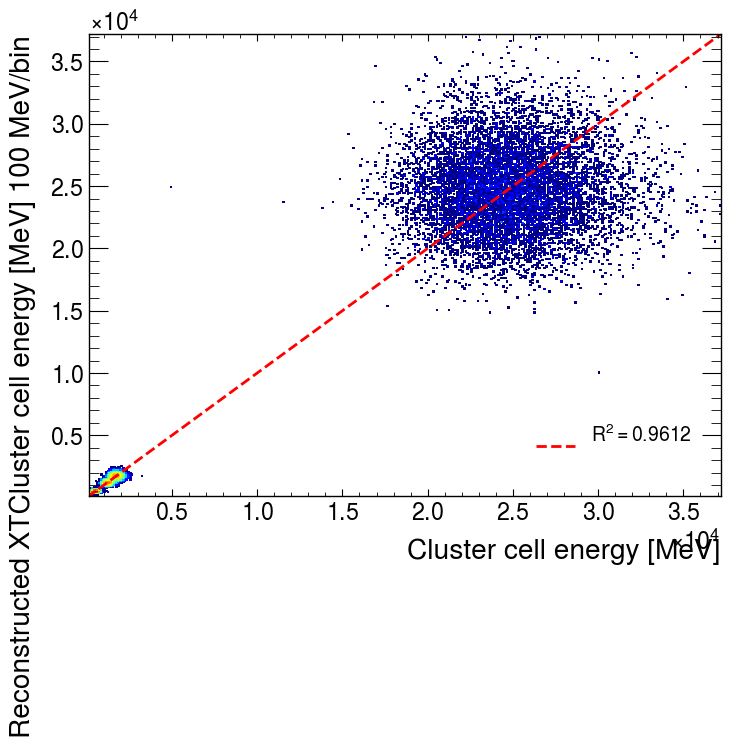

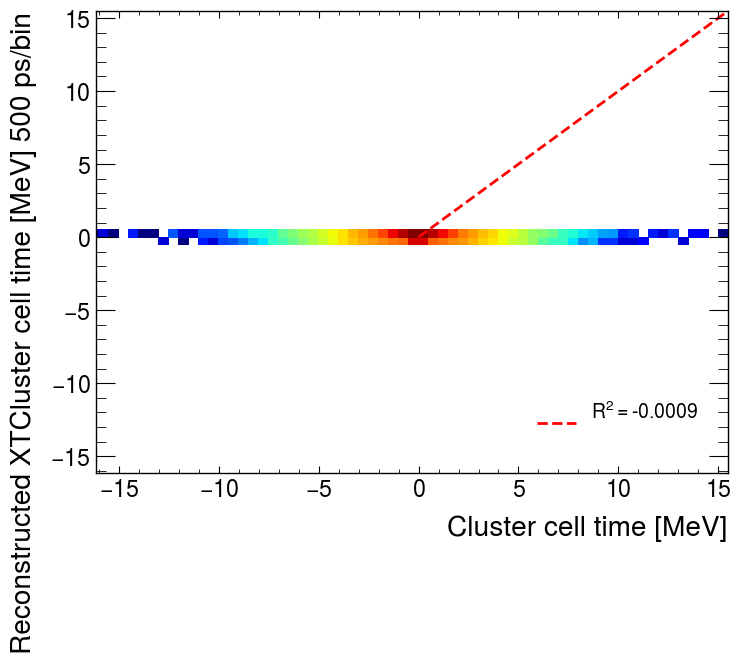

In [10]:
# typeModelTrainList = ['ene', 'time','eneTime']
typeModelTrainList = ['eneTime']
totalEnergy = 50000
scale = 'MeV'

for typeModelTrain in typeModelTrainList:
    testfilename=pathLoss+'testModel_model_ofc_{}.npz'.format(typeModelTrain)
    with np.load(testfilename, allow_pickle=True) as test_file:
        loss_log = test_file['log'].tolist()

        eneTargetList = np.array(loss_log['ofc_ene']).flatten()
        eneOutputList = np.array(loss_log['model_ofc_ene']).flatten()
        timeTargetList = np.array(loss_log['ofc_time']).flatten()
        timeOutputList = np.array(loss_log['model_ofc_time']).flatten()
        xttimeList     = np.array(loss_log['xt_ofc_time']).flatten()
        xteneList      = np.array(loss_log['xt_ofc_ene']).flatten()
        
        #
        # Energy
        #    
        xbins = getBins(-2000,totalEnergy,100)
            
        max_reco = max(max(eneTargetList),max(eneOutputList))
        min_reco = min(min(eneTargetList), min(eneOutputList))

        plt.hist2d(eneTargetList, eneOutputList, bins=[xbins,xbins], cmin=1,norm=mcolors.LogNorm(), cmap=plt.cm.jet)
        r2_target_output = r2_score(eneTargetList, eneOutputList)
        plt.plot([0, max_reco],[0, max_reco], '--r', label=r'$R^2=$'+'{:.4f}'.format(r2_target_output)+'\n')
        plt.legend(loc='lower right')

        plt.xlabel('Cluster cell energy [{}]'.format(scale))
        plt.ylabel('Reconstructed XTCluster cell energy [{}] 100 MeV/bin'.format(scale))
        
        plt.xlim([min_reco, max_reco])
        plt.ylim([min_reco, max_reco])
        plt.show()
        
        #
        # Time
        #    
        xbins = getBins(-100,100,0.5)
            
        max_reco = max(max(timeTargetList),max(timeOutputList))
        min_reco = min(min(timeTargetList), min(eneOutputList))

        plt.hist2d(timeTargetList, timeOutputList, bins=[xbins,xbins], cmin=1,norm=mcolors.LogNorm(), cmap=plt.cm.jet)
        r2_target_output = r2_score(timeTargetList, timeOutputList)
        plt.plot([0, max_reco],[0, max_reco], '--r', label=r'$R^2=$'+'{:.4f}'.format(r2_target_output)+'\n')
        plt.legend(loc='lower right')

        plt.xlabel('Cluster cell time [{}]'.format(scale))
        plt.ylabel('Reconstructed XTCluster cell time [{}] 500 ps/bin'.format(scale))
        
        plt.xlim([min_reco, max_reco])
        plt.ylim([min_reco, max_reco])
        plt.show()




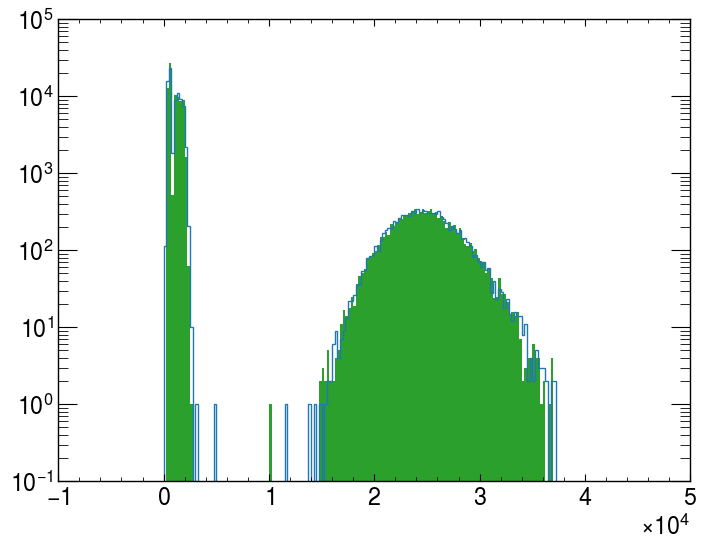

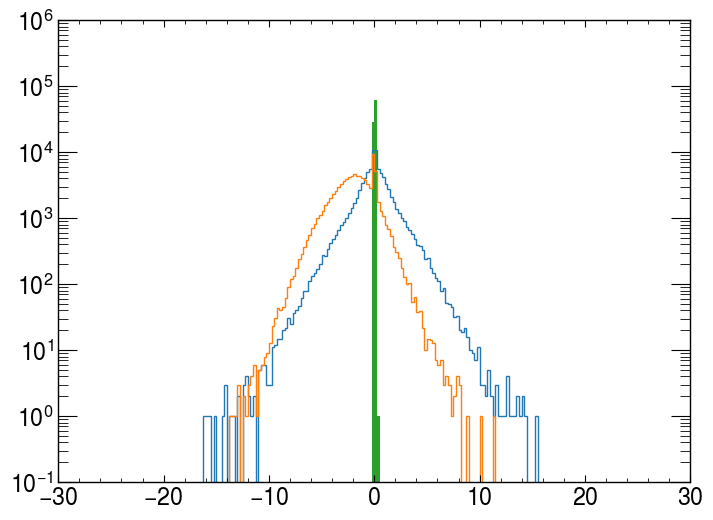

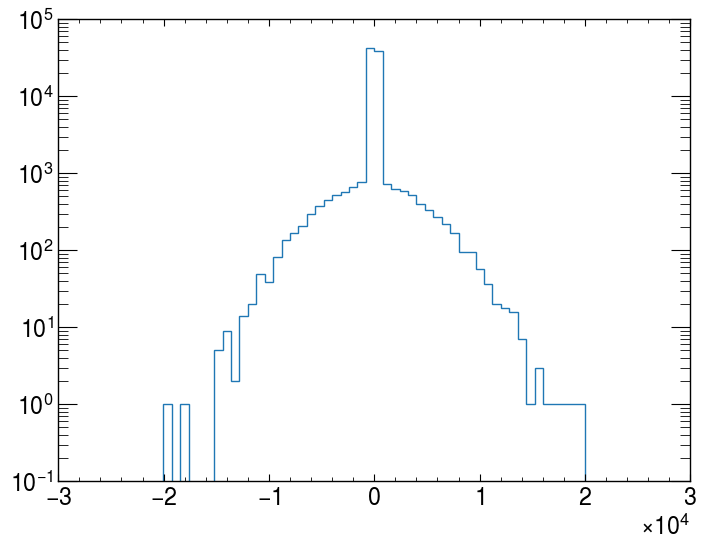

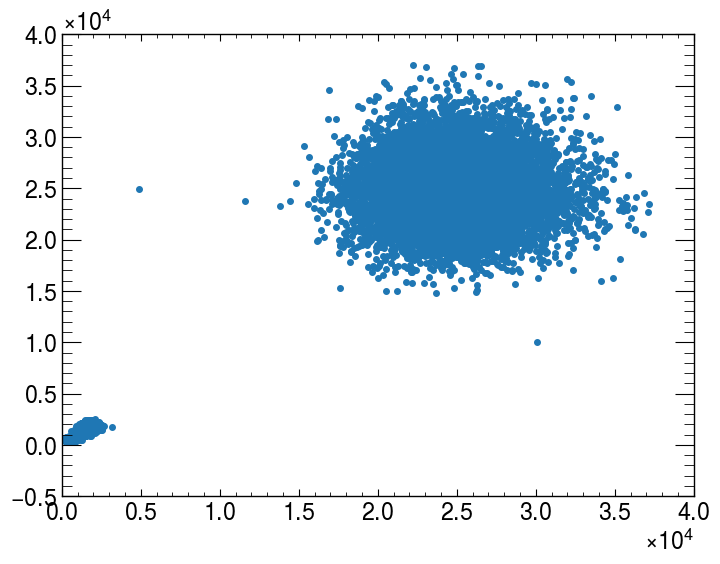

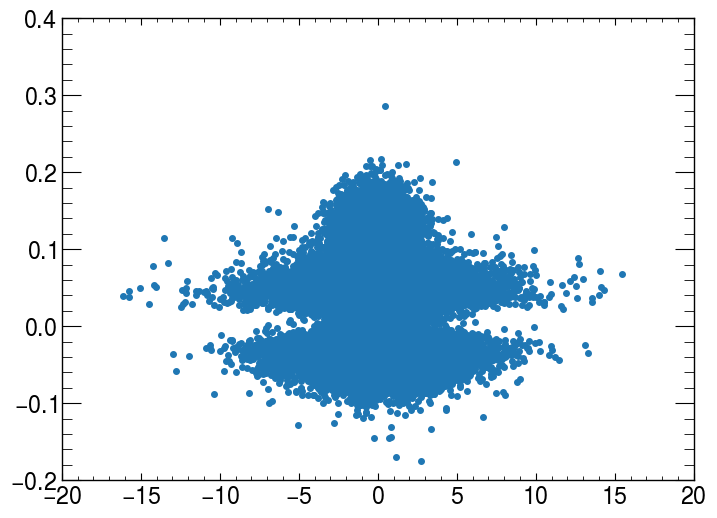

In [22]:
xbins = getBins(-2000,50000,250)
plt.hist(eneTargetList, bins=xbins, histtype='step')
plt.hist(xteneList, bins=xbins, histtype='step')
plt.hist(eneOutputList,bins=xbins, histtype='stepfilled')
plt.yscale('log')
plt.show()

xbins = getBins(-30,30,0.25)
plt.hist(timeTargetList, bins=xbins, histtype='step')
plt.hist(xttimeList,bins=xbins, histtype='step')
plt.hist(timeOutputList,bins=xbins, histtype='stepfilled')
plt.yscale('log')
plt.show()


plt.hist((eneTargetList-eneOutputList), bins=50, histtype='step')
plt.yscale('log')
plt.show()

plt.plot(eneTargetList, eneOutputList, '.')
plt.show()

plt.plot(timeTargetList, timeOutputList, '.')
plt.show()

In [12]:
xteneList

array([], dtype=float64)

## 10 - Analysis Timing Each Cell

In [ ]:
## Path to experiment output

pathLoss      = '/data/atlas/mhufnage/xtalk/data_analysis/lzt_timing/'

conditions = {
    'nEvents':         10000, # <--- it is the total events to feed KFold_split into (train+valid)+(test).
    'SigmaCut':        1,
    'etaCut':          1.4,
    'caloSampling':    'EM2',#CaloSampling.EMB2,
    'etaSize':         3,
    'phiSize':         3,
    'nSamples':        5,
    'dumpCells':       True,
    'bDumpWindowOnly': True,
    'bNoEneCut':       True,
    'XTalk_ind':       1.1,
    'XTalk_cap':       0.0,
    'XTalkLevel':      'L = 1.1%, C = 0.0%',
    
    # Not implemented yet!
    'etBin':           [[15 , 20] ,[20, 30]  ,[30, 40]  ,[40, 50],[50,100],[100,10000000]],
    'etaBin':          [[0.00, 0.80], [0.80, 1.37], [1.37,1.54],[1.54,2.50],[2.50,3.2]],
    'bPhaseSpaceDiv':  False,
}

# Dataset
data33 = TChain('ML_tree')
for ds_index in range(1,30):
    # print(ds_index, conditions['XTalk_cap'], conditions['XTalk_ind'], conditions['etaSize'], conditions['phiSize'])
    theFile = '/data/atlas/mhufnage/lzt_single_e/elec_singleCell_10kEvts_centroid_e50_DS{}/AOD_Cap{:.1f}_Ind{:.1f}/user.mhufnage.lzt.e50.xtalk.DS{}.win{}{}.nopileup.WithCells_{}.root'.format(ds_index, conditions['XTalk_cap'], conditions['XTalk_ind'], ds_index, conditions['etaSize'], conditions['phiSize'], conditions['caloSampling'])
    data33.Add(theFile+'/ML_tree')
        
#
# Configuration
#

bLoadFullCellData       = True

if not(os.path.isdir(pathLoss)):
    os.mkdir(pathLoss)

datasetTrain33 = XTalkDataset_LZT_FromROOT(data33, conditions, mode='supervised', load_full_data=bLoadFullCellData)

conditions['etaSize']=5
conditions['phiSize']=5

data55 = TChain('ML_tree')
for ds_index in range(1,30):
    # print(ds_index, conditions['XTalk_cap'], conditions['XTalk_ind'], conditions['etaSize'], conditions['phiSize'])
    theFile = '/data/atlas/mhufnage/lzt_single_e/elec_singleCell_10kEvts_centroid_e50_DS{}/AOD_Cap{:.1f}_Ind{:.1f}/user.mhufnage.lzt.e50.xtalk.DS{}.win{}{}.nopileup.WithCells_{}.root'.format(ds_index, conditions['XTalk_cap'], conditions['XTalk_ind'], ds_index, conditions['etaSize'], conditions['phiSize'], conditions['caloSampling'])
    data55.Add(theFile+'/ML_tree')
datasetTrain55 = XTalkDataset_LZT_FromROOT(data55, conditions, mode='supervised', load_full_data=bLoadFullCellData)


conditions['etaSize']=7
conditions['phiSize']=7

data77 = TChain('ML_tree')
for ds_index in range(1,30):
    # print(ds_index, conditions['XTalk_cap'], conditions['XTalk_ind'], conditions['etaSize'], conditions['phiSize'])
    theFile = '/data/atlas/mhufnage/lzt_single_e/elec_singleCell_10kEvts_centroid_e50_DS{}/AOD_Cap{:.1f}_Ind{:.1f}/user.mhufnage.lzt.e50.xtalk.DS{}.win{}{}.nopileup.WithCells_{}.root'.format(ds_index, conditions['XTalk_cap'], conditions['XTalk_ind'], ds_index, conditions['etaSize'], conditions['phiSize'], conditions['caloSampling'])
    data77.Add(theFile+'/ML_tree')
datasetTrain77 = XTalkDataset_LZT_FromROOT(data77, conditions, mode='supervised', load_full_data=bLoadFullCellData)


Event idx 0/10000


Event idx 0/10000
Event idx 0/10000


In [ ]:
# uniq_33 = np.unique(datasetTrain33.hash)

binMin   = -0.3
binMax   = 0.3
binWidth = 0.01
x1bins   = np.arange(binMin, binMax, binWidth)

binMin   = -10
binMax   = 10
binWidth = 0.5
x2bins = np.arange(binMin, binMax, binWidth)

for clus_idx, cell_hash in enumerate(np.unique(datasetTrain33.hash)):
    # for datasetTrain33
    print('cluster index: {}, hash: {}'.format(clus_idx, cell_hash))
    t0      = datasetTrain33.t[:,clus_idx].detach().numpy()
    xtt0    = datasetTrain33.xtt[:,clus_idx].detach().numpy()
    # print(np.unique(t0))
    
    if clus_idx==4:
        xbins = x1bins
    else:
        xbins = x2bins

    fig = plt.figure()
    plt.hist(t0,bins=xbins, histtype='stepfilled',alpha=0.3,label='t\nmean={:.2f}, std={:.2f}'.format(np.mean(t0), np.std(t0)))
    plt.hist(xtt0,bins=xbins, histtype='stepfilled',alpha=0.3,label='xt_t\nmean={:.2f}, std={:.2f}'.format(np.mean(xtt0), np.std(xtt0)))
    plt.xlabel('Time [ns]')
    plt.ylabel('Counts')
    plt.title('Single cell ({}) timing across {} events'.format(cell_hash,conditions['nEvents']))
    plt.legend()
    plt.savefig(pathLoss+'timingSingleCell_33pos{}.png'.format(clus_idx))
    plt.close(fig)
# plt.show()

cluster index: 0, hash: 30022473
cluster index: 1, hash: 30022474


cluster index: 2, hash: 30022475
cluster index: 3, hash: 30022729
cluster index: 4, hash: 30022730
cluster index: 5, hash: 30022731
cluster index: 6, hash: 30022985
cluster index: 7, hash: 30022986
cluster index: 8, hash: 30022987


## 11) Invertible Models

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from pylab import rcParams
rcParams['figure.figsize'] = 10, 8
rcParams['figure.dpi'] = 300

import torch
from torch import nn
from torch import distributions
from torch.nn.parameter import Parameter

from sklearn import cluster, datasets, mixture
from sklearn.preprocessing import StandardScaler



In [ ]:

#####
class RealNVP(nn.Module):
    def __init__(self, nets, nett, mask, prior):
        super(RealNVP, self).__init__()

        self.prior = prior
        self.mask = nn.Parameter(mask, requires_grad=False)
        self.t = torch.nn.ModuleList([nett() for _ in range(len(masks))])
        self.s = torch.nn.ModuleList([nets() for _ in range(len(masks))])

    def g(self, z):
        x = z
        for i in range(len(self.t)):
            x_ = x*self.mask[i]
            s = self.s[i](x_)*(1 - self.mask[i])
            t = self.t[i](x_)*(1 - self.mask[i])
            x = x_ + (1 - self.mask[i]) * (x * torch.exp(s) + t)
        return x

    def f(self, x):
        log_det_J, z = x.new_zeros(x.shape[0]), x
        for i in reversed(range(len(self.t))):
            z_ = self.mask[i] * z
            s = self.s[i](z_) * (1-self.mask[i])
            t = self.t[i](z_) * (1-self.mask[i])
            z = (1 - self.mask[i]) * (z - t) * torch.exp(-s) + z_
            log_det_J -= s.sum(dim=1)
        return z, log_det_J

    def log_prob(self,x):
        z, logp = self.f(x)
        return self.prior.log_prob(z) + logp

    def sample(self, batchSize):
        z = self.prior.sample((batchSize, 1))
        logp = self.prior.log_prob(z)
        x = self.g(z)
        return x
    
    


In [ ]:
nets = lambda: nn.Sequential(nn.Linear(2, 256), nn.LeakyReLU(), nn.Linear(256, 256), nn.LeakyReLU(), nn.Linear(256, 2), nn.Tanh())
nett = lambda: nn.Sequential(nn.Linear(2, 256), nn.LeakyReLU(), nn.Linear(256, 256), nn.LeakyReLU(), nn.Linear(256, 2))
masks = torch.from_numpy(np.array([[0, 1], [1, 0]] * 3).astype(np.float32))
prior = distributions.MultivariateNormal(torch.zeros(2), torch.eye(2))
flow = RealNVP(nets, nett, masks, prior)

In [ ]:
plt.scatter(datasets.make_moons(n_samples=100, noise=.05)[0].astype(np.float32))


TypeError: scatter() missing 1 required positional argument: 'y'

In [ ]:
optimizer = torch.optim.Adam([p for p in flow.parameters() if p.requires_grad==True], lr=1e-4)
for t in range(1501):
    noisy_moons = datasets.make_moons(n_samples=100, noise=.05)[0].astype(np.float32)
    loss = -flow.log_prob(torch.from_numpy(noisy_moons)).mean()

    optimizer.zero_grad()
    loss.backward(retain_graph=True)
    optimizer.step()

    if t % 500 == 0:
        print('iter %s:' % t, 'loss = %.3f' % loss)

iter 0: loss = 2.434
iter 500: loss = 0.600
iter 1000: loss = 0.587
iter 1500: loss = 0.491


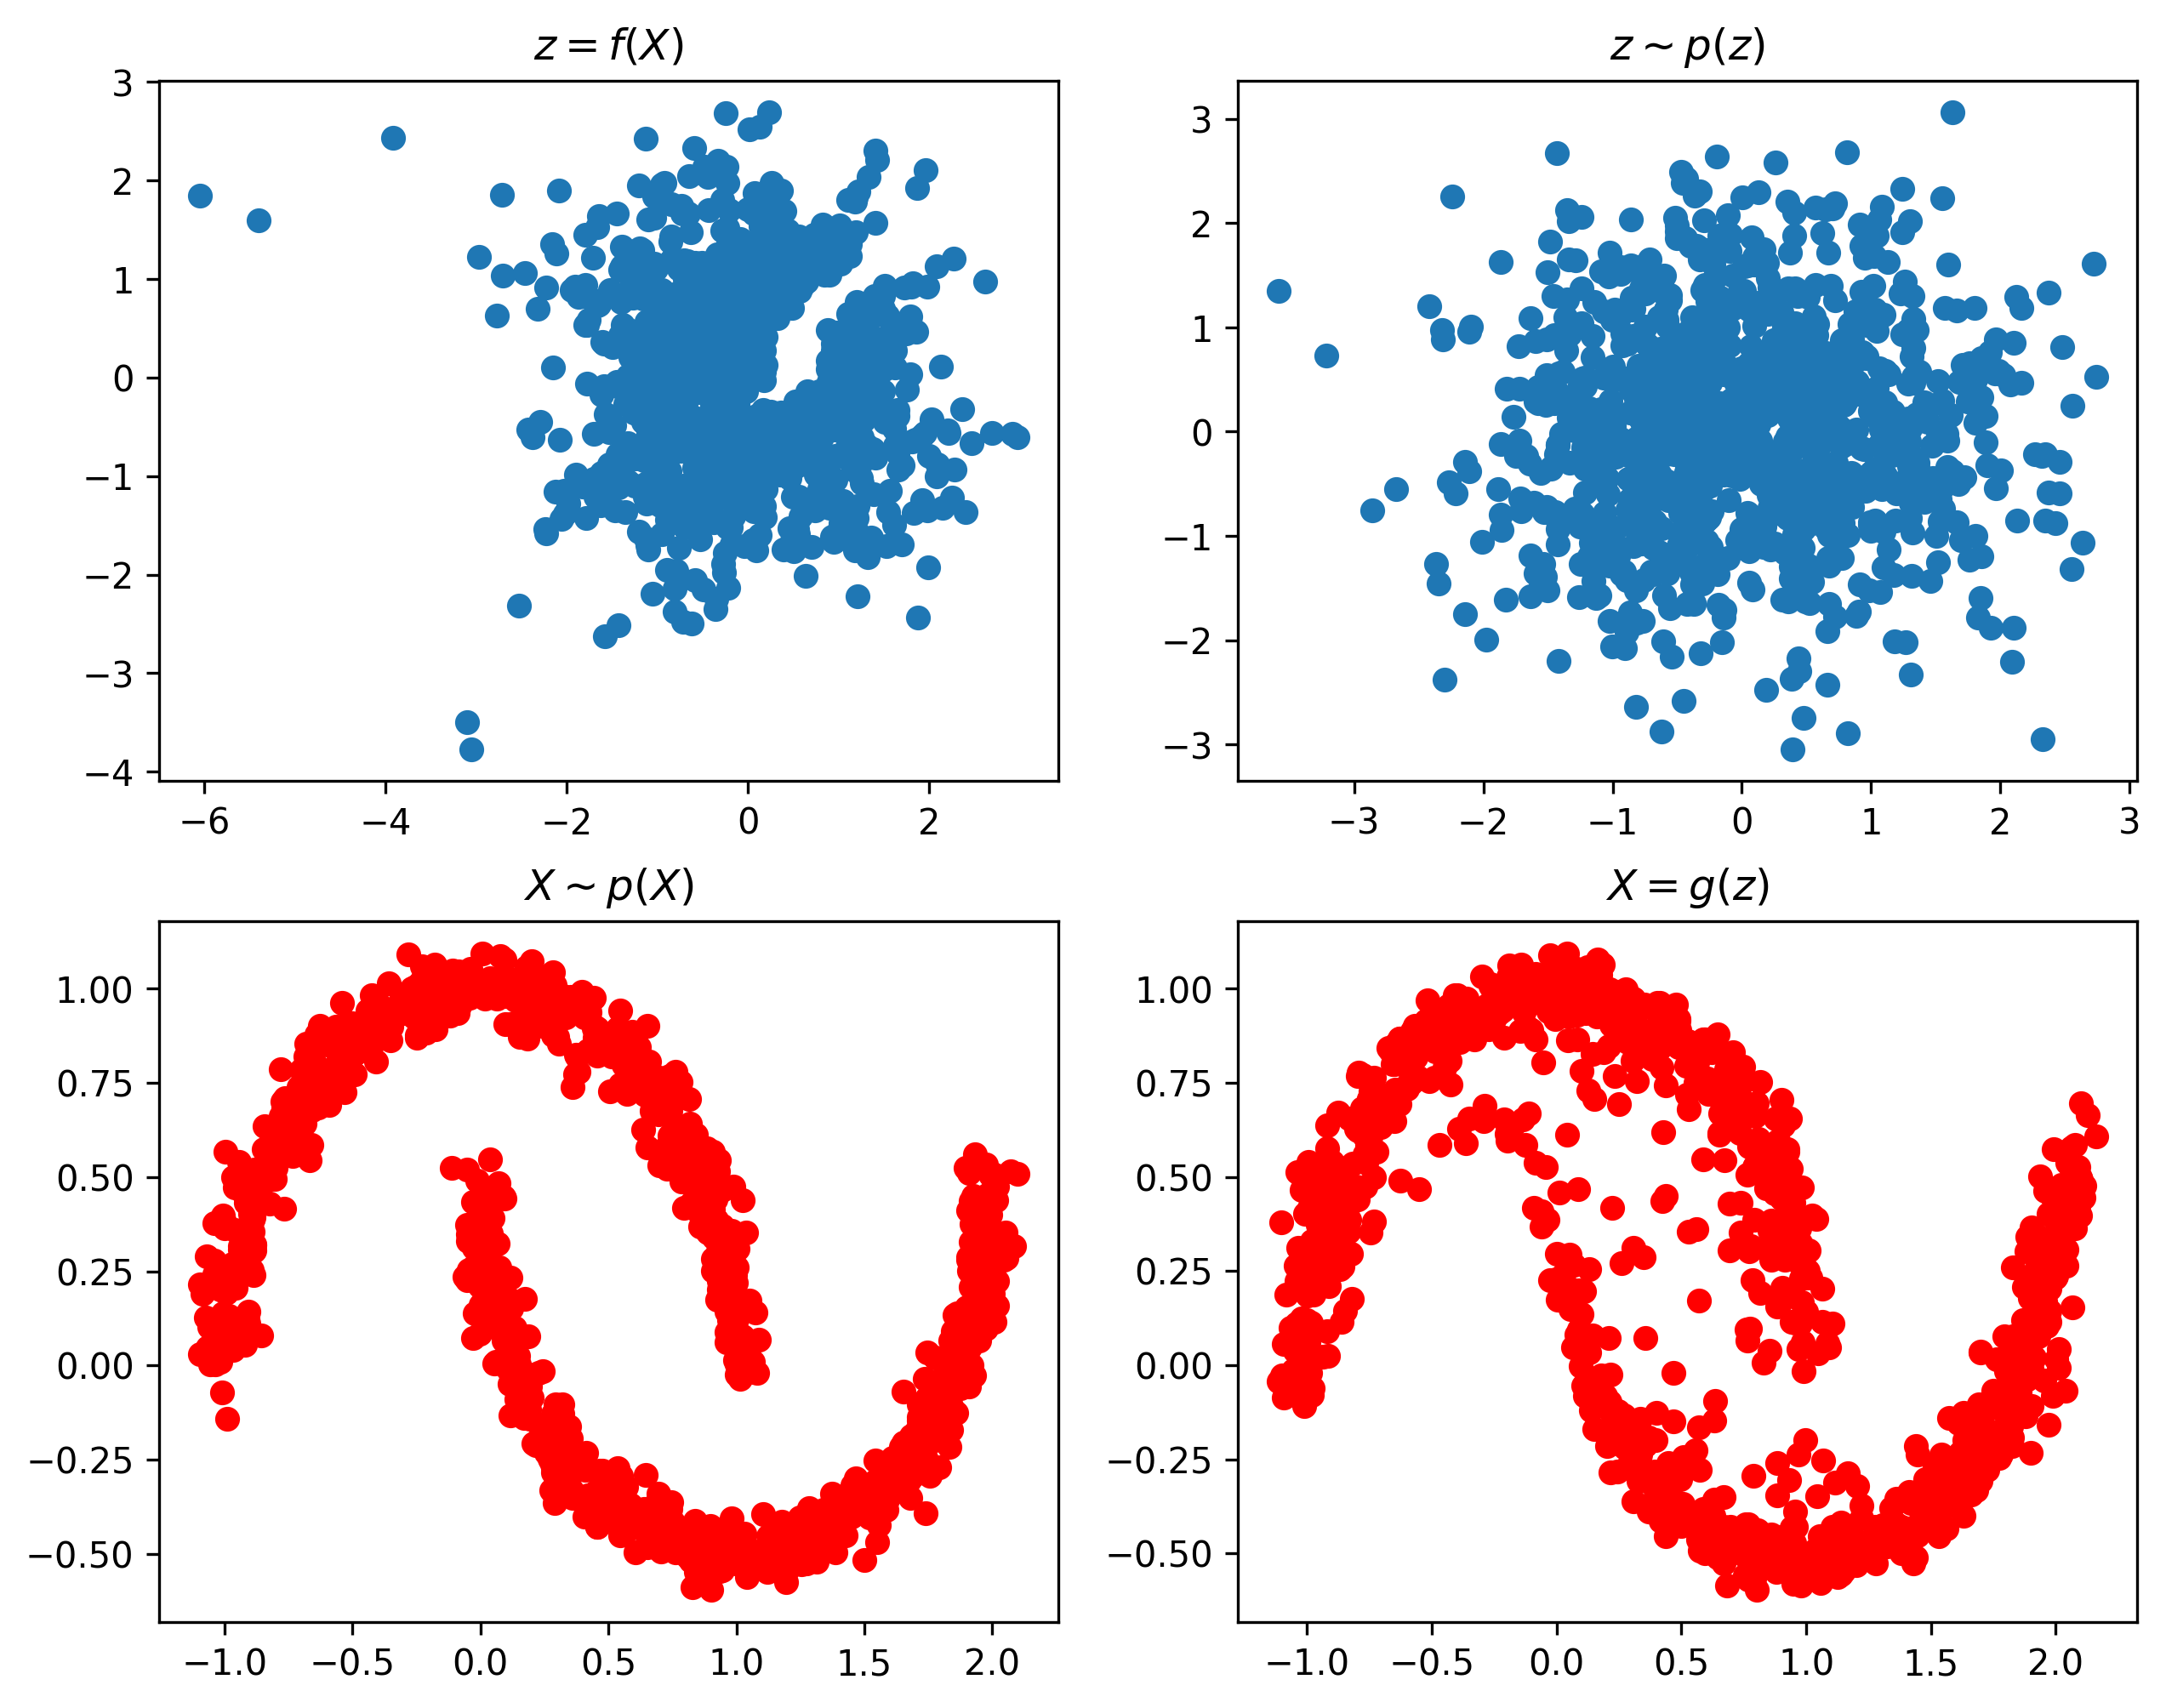

In [ ]:

noisy_moons = datasets.make_moons(n_samples=1000, noise=.05)[0].astype(np.float32)
z = flow.f(torch.from_numpy(noisy_moons))[0].detach().numpy()
plt.subplot(221)
plt.scatter(z[:, 0], z[:, 1])
plt.title(r'$z = f(X)$')

z = np.random.multivariate_normal(np.zeros(2), np.eye(2), 1000)
plt.subplot(222)
plt.scatter(z[:, 0], z[:, 1])
plt.title(r'$z \sim p(z)$')

plt.subplot(223)
x = datasets.make_moons(n_samples=1000, noise=.05)[0].astype(np.float32)
plt.scatter(x[:, 0], x[:, 1], c='r')
plt.title(r'$X \sim p(X)$')

plt.subplot(224)
x = flow.sample(1000).detach().numpy()
plt.scatter(x[:, 0, 0], x[:, 0, 1], c='r')
plt.title(r'$X = g(z)$')
plt.show()


# Test multicore

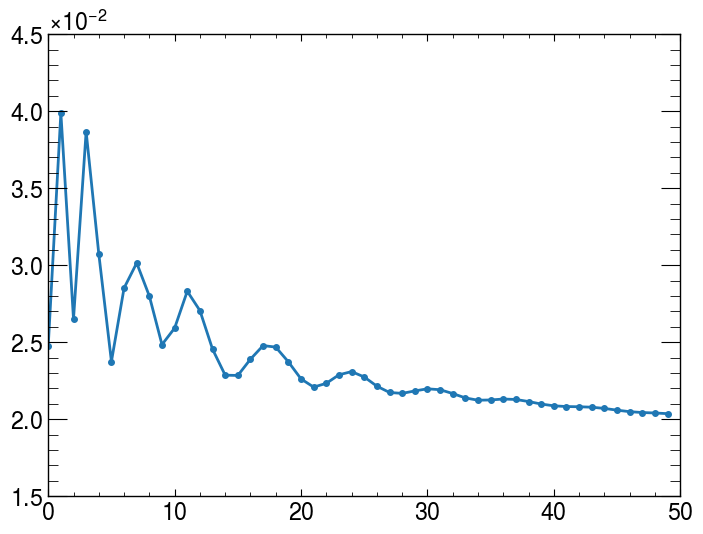

In [ ]:
testpath='/data/atlas/mhufnage/xtalk/ml_training/supervised_lzt/testMulticore/loss_nnp_fold0_iter0_neu45-30-45_batch256.npz'
train_logging_dict = np.load(testpath,allow_pickle=True)['loss'].tolist()

plt.plot(train_logging_dict['epoch'], train_logging_dict['loss'],'.-')

In [ ]:
# torch.cuda.device_count()
int(os.cpu_count()/8)
# os.environ['MASTER_ADDR']

4

In [ ]:
import torch.distributed as dist

# os.environ['MASTER_ADDR'] = '127.0.0.1'
# os.environ['MASTER_PORT'] = '29500'
    
dist.init_process_group(
        backend="gloo",
        init_method='env://',
        world_size=0,
        rank=os.cpu_count(),
        store=None,
        group_name='test')



ValueError: Error initializing torch.distributed using env:// rendezvous: environment variable MASTER_ADDR expected, but not set

## Train Multicore

In [ ]:
# Lorenzetti Showers Collaboration 2020 - 2023 - https://doi.org/10.1016/j.cpc.2023.108671
print('Starting script for neuron/layers space search...')
import sys
sys.path.insert(0,'/home/mhufnage/lorenzetti/Applications') #lorenzetti utils path

## Insert here the path to xtalkDatasetAnalysis git package
sys.path.insert(1, '/home/mhufnage/ATLAS_QT_XTALK/xtalkDatasetAnalysis/')

uprootLibrary = 'np'#'np' #'ak'

import json
import os
import time
import shelve

import numpy as np
from glob import glob
import math
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.colors as mcolors
import matplotlib
# matplotlib.use('Agg') #CHANGES THE MATPLOTLIB BACKEND FOR LOOP PLOTS

import scipy.stats as scipy
import torch
import torch.nn as nn
import MLP
from torch.utils.data import Dataset, DataLoader

from collections import OrderedDict
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

import mplhep as hep

plt.style.use([hep.style.ATLAS])

import uproot

from calibrationFilesHelper import *
from Autoencoder import *
from XTalkDatasetClass import XTalkDataset_LZT, Subset
from auxiliaryFunctions import confInterval, getBins

# --------- Lorenzetti plot style -------
def lorenzettiText(pos='out',subText=' Internal'):
    lorenzetti_title={'fontsize': 21, 'fontfamily': 'sans-serif', 'fontweight':'bold','fontstyle':'italic'}
    lorenzetti_subtitle={'fontsize': 14, 'fontfamily': 'sans-serif', 'fontweight':'normal','fontstyle':'italic'}

    if pos=='out':
        plt.figtext(x=.18   ,y=.945,s='Lorenzetti',fontdict=lorenzetti_title)
        plt.figtext(x=.318  ,y=.945,s=subText,fontdict=lorenzetti_subtitle)
    if pos=='in':
        plt.figtext(x=.18   ,y=.875,s='Lorenzetti',fontdict=lorenzetti_title)
        plt.figtext(x=.318  ,y=.875,s=subText,fontdict=lorenzetti_subtitle)


# --------- Lorenzetti sampling and detector enumeration ---------
class Detector():
  LAR     = 0
  TILE    = 1
  TTEM    = 2
  TTHEC   = 3
  FCALEM  = 5
  FCALHAD = 6

class CaloSampling():
    PSB       = 0
    PSE       = 1
    EMB1      = 2
    EMB2      = 3
    EMB3      = 4
    TileCal1  = 5
    TileCal2  = 6
    TileCal3  = 7
    TileExt1  = 8
    TileExt2  = 9
    TileExt3  = 10
    EMEC1     = 11
    EMEC2     = 12
    EMEC3     = 13
    HEC1      = 14
    HEC2      = 15
    HEC3      = 16

def trainMLP(model):
                   
    for epoch in range(nEpochs):
        #
        # Training
        #
                    
        for data_input, target, batch_idx in train_fold:
            
            # pass input through the model and generate the output
            output      = model(data_input*scalerInput) #normalized (not yet exactly) input
            
            #
            # Loss calculation
            #
            
            # get input and output energy and time
            # ene_input, tau_input    = datasetTrain.calibrate(batch_idx, data_input) # unormlized input
            ene_target, tau_target    = datasetTrain.calibrate(batch_idx, target) # unormlized target
            ene_output, tau_output    = datasetTrain.calibrate(batch_idx, output*scalerOutput) # denormalized output
            # sigmaTau_out            = torch.std(tau_output)
            # sigmaTau_in             = torch.std(tau_input)
            
            # total window loss
            # loss            = model.criterion(output, data_input*scalerInput) # loss with normalized data input and output
            loss            = model.criterion(output, target*scalerInput) # loss with normalized data target and model output
            loss_tau        = model.criterion(tau_output , tau_target) # time remains in ns
            loss_ene        = model.criterion(ene_output*typeNormalization['mevToGev'] , ene_target*typeNormalization['mevToGev']) # scale energy from MeV to GeV
            
            #
            # Backpropagation (optimize weights)
            #
            # model.optimizer.zero_grad()
            optimizer.zero_grad()
            total_loss      = loss + loss_ene + loss_tau
            pulse_tau_loss  = loss + loss_tau
            
            if lossComputation=='pet':
                total_loss.backward()
                
            elif lossComputation=='p':
                loss.backward()
            elif lossComputation=='t':
                loss_tau.backward()
            elif lossComputation=='pt':
                pulse_tau_loss.backward()    
            else:
                raise AttributeError("loss computation was not set to any implemented options.")
            # loss_tau.backward()
            # model.optimizer.step()
            optimizer.step()
        
        #
        # Validation
        #
        for data_input, target, batch_idx in val_fold:
            # pass input through the model and generate the output
            output  = model(data_input*scalerInput)

            #
            # Loss calculation
            #

            # get input and output energy and time
            # val_ene_input, val_tau_input    = datasetTrain.calibrate(batch_idx, data_input)# unormlized input
            val_ene_target, val_tau_target  = datasetTrain.calibrate(batch_idx, target)# unormlized target
            val_ene_output, val_tau_output  = datasetTrain.calibrate(batch_idx, output*scalerOutput)# denormalized output

            val_loss            = model.criterion(output, target*scalerInput) #normalized target
            val_loss_tau        = model.criterion(val_tau_output , val_tau_target)
            val_loss_ene        = model.criterion(val_ene_output*typeNormalization['mevToGev'] , val_ene_target*typeNormalization['mevToGev'])
            
            total_val_loss = val_loss + val_loss_ene + val_loss_tau
            val_pulse_tau_loss = val_loss + val_loss_tau

        #
        # End of the current Epoch
        #
        if (epoch%1)==0:                
            print('\t\t\tEpoch {}/{}...loss={:.5f}, val_loss={:.5f} | tau_loss={:.5f} | ene_loss={:.5f} | total_loss={:.5f}, total_val_loss={:.5f} '.format(epoch,nEpochs,loss.detach().numpy(), val_loss, loss_tau, loss_ene, total_loss, total_val_loss))

        train_logging_dict['loss'].append(loss.detach().numpy())
        train_logging_dict['ene_loss'].append(loss_ene.detach().numpy())
        train_logging_dict['tau_loss'].append(loss_tau.detach().numpy())
        train_logging_dict['val_loss'].append(val_loss.detach().numpy())
        train_logging_dict['val_ene_loss'].append(val_loss_ene.detach().numpy())
        train_logging_dict['val_tau_loss'].append(val_loss_tau.detach().numpy())
        train_logging_dict['total_loss'].append(total_loss.detach().numpy())
        train_logging_dict['total_val_loss'].append(total_val_loss.detach().numpy())
        
        #
        # Early Stop criteria
        #
        bestModelPath   = pathLoss+'bestModel_nn{}_fold{}_iter{}_neu{}.pth'.format(lossComputation,nFold, it, range_neuText)
        
        if lossComputation=='pet':
            bStop           = early_stopper.early_stop(total_val_loss, epoch, model, optimizer, bestModelPath)
        elif lossComputation=='p':
            bStop           = early_stopper.early_stop(val_loss, epoch, model, optimizer, bestModelPath)
        elif lossComputation=='t':
            bStop           = early_stopper.early_stop(val_loss_tau, epoch, model, optimizer, bestModelPath)
        elif lossComputation=='pt':
            bStop           = early_stopper.early_stop(val_pulse_tau_loss, epoch, model, optimizer, bestModelPath)
        else:
            raise AttributeError("select a loss computation method.")
        
        if bStop:
            train_logging_dict['best_epoch'] = early_stopper.bestEpoch
            
            if lossComputation=='pet':
                print('--- EarlyStopper=True. val_loss={}... bestModel_loss={}, bestEpoch={}'.format(total_val_loss, early_stopper.min_validation_loss, early_stopper.bestEpoch))
                MLP.checkpoint(early_stopper.tmpModel, optimizer, bestModelPath, epoch, total_val_loss) # save the model
                break
            elif lossComputation=='p':
                print('--- EarlyStopper=True. val_loss={}... bestModel_loss={}, bestEpoch={}'.format(val_loss, early_stopper.min_validation_loss, early_stopper.bestEpoch))
                MLP.checkpoint(early_stopper.tmpModel, optimizer, bestModelPath, epoch, val_loss) # save the model
                break
            elif lossComputation=='t':
                print('--- EarlyStopper=True. val_loss={}... bestModel_loss={}, bestEpoch={}'.format(val_loss_tau, early_stopper.min_validation_loss, early_stopper.bestEpoch))
                MLP.checkpoint(early_stopper.tmpModel, optimizer, bestModelPath, epoch, val_loss_tau) # save the model
                break
            elif lossComputation=='pt':
                print('--- EarlyStopper=True. val_loss={}... bestModel_loss={}, bestEpoch={}'.format(val_pulse_tau_loss, early_stopper.min_validation_loss, early_stopper.bestEpoch))
                MLP.checkpoint(early_stopper.tmpModel, optimizer, bestModelPath, epoch, val_pulse_tau_loss) # save the model
                break
            else:
                raise AttributeError("select a loss computation method.")
        else:
            train_logging_dict['best_epoch'] = epoch
# -----------------------------------------------------------------
# -----------------------------------------------------------------
# -----------------------------------------------------------------
## Path to experiment output

if __name__ == '__main__':

    pathLoss      = '/data/atlas/mhufnage/xtalk/ml_training/supervised_lzt/testMulticore/'
    # DS_Lim        = 9
    DS_List       = [1]#, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20 ]
    DS_test       = [21]
    DS_PathAlias  = '/data/atlas/mhufnage/lzt_single_e/elec_singleCell_10kEvts_centroid_e50_DS{}/AOD/user.mhufnage.lzt.e50.xtalk.DS{}.win3.nopileup.WithCells_EM2.event.npz'

    if not(os.path.isdir(pathLoss)):
        os.mkdir(pathLoss)

    startTime=time.time()
    # Dataset

    data            = []
    print('Loading dataset from list: ',DS_List)
    for DS_index in DS_List:
        data.append (np.load(DS_PathAlias.format(DS_index,DS_index), allow_pickle=True)['dataset'])
    data = np.concatenate(data).ravel()
    print('Dataset loaded with {} events!'.format(len(data)))

    optimAlg                = 'adam'
    typeNormalization       = {'electronEnergy': 50.0,
                            'mevToGev': 1/1000,
                            'gevToMev': 1000,
                            'none': 1}#'minMax'

    lr                      = 1e-3
    weightDecay_adam        = 1e-5

    optimConfig             = {
        'adam':{
            'learningRate'  : lr,
            'weightDecay'   : weightDecay_adam,
        },
    }

    print(optimConfig[optimAlg])

    # trainNeuLists = {'neuLay': [[45,5,5],[45,15,15],[45,30,30]],
    #                  } #2layers
    # trainNeuLists = {'neuLay': [[45,5,5],[45,30,30],[45,60,60], [45,75,75]],
    #                  } # 1layer
    # trainNeuLists = {'neuLay': [[45,10],[45,15],[45,20], [45,25], [45,35], [45,40], [45,45], [45,50], [45,55], [45,65],[45,70],[45,75]],} # 1layer_finer
    # trainNeuLists = {'neuLay': [[45,75],[45,90],[45,100],[45,120],[45,150],[45,200]],} # 1layer_finer
    trainNeuLists = {'neuLay': [[45,30]],} # 1layer_finer

    lossComputationList = ['p']

    np.savez(pathLoss+'{}_config.npz'.format(pathLoss.split('/')[-2]),config=trainNeuLists)

    for lossMethod in lossComputationList:
        print('Computation method: {}'.format(lossMethod))
        
        for trainNeuList in trainNeuLists['neuLay']:
            range_neuInput          = trainNeuList#[45,20,20]
            range_neuText           = MLP.neuListToFileText(range_neuInput)
            # range_nLayers           = [0]
            # bn_neurons              = 4
            print(range_neuText)

            experiment_alias        = '''
            learning the samples of a 3x3 window from topocluster at EMB2 layer. 
            The loss for training is the input-output map. 
            The cell organization in the window is eta-oriented.
            # phi [ 3 | 6 | 9 ]
            #     [ 2 | 5 | 8 ]  , eta-orientation cluster indexing. where 5 is the index of the hottest cell
            #     [ 1 | 4 | 7 ]
            #             eta
            '''
            totalEvents             = len(data)

            nEpochs                 = 50
            lossComputation         = lossMethod ## can be 'p'=pulse loss, 'pet'=pulse+energy+time losses
            patience                = 15
            min_delta_loss          = 0

            k                       = 3 # number of folds in kFold split
            nBatch                  = 256 # batch size in clusters
            nIter                   = 1
            nClusters               = -1 # for training, validation and test

            nSamples                = 5 # standard for LAr
            nCellsWinEta            = 3 # dataset selection
            nCellsWinPhi            = 3
            scalerInput             = torch.tensor((typeNormalization['mevToGev'])) # without normalization, set to 1
            scalerOutput            = torch.tensor(typeNormalization['gevToMev'])

            train_ratio             = 0.90 # proportion of data to apply the kFold
            test_ratio              = 0.10 # proportion of data to apply test on trained model

            #
            # Dataset split
            #
            total_ene = []
            total_tau = []

            train_config_dict   = {
                'experiment_alias'  : experiment_alias,
                'patience'          : patience,
                'min_delta_loss'    : min_delta_loss,
                'max_epochs'        : nEpochs,
                'kFolds'            : k,
                'batch_size'        : nBatch,
                'max_init'          : nIter,
                'total_clusters'    : totalEvents,
                'train_ratio'       : train_ratio,
                'test_ratio'        : test_ratio,
                'cell_win_eta'      : nCellsWinEta,
                'cell_win_phi'      : nCellsWinPhi,
                'scaler_input'      : scalerInput,
                'scaler_output'     : scalerOutput,
                'neurons_list'      : range_neuInput,
                'neurons_text'      : range_neuText,
                'lossComputation'   : lossComputation,
                'nSamples'          : nSamples,
                'optimConfig'       : optimConfig,
            }

            # if optimAlg=='adam':
            np.savez(pathLoss+'config_train_nn{}_{}_neu{}.npz'.format(lossComputation, optimAlg, range_neuText), config=train_config_dict)

            X_train, X_test = train_test_split( data[0:nClusters] , test_size=test_ratio)

            datasetTest     =   XTalkDataset_LZT(X_test, nEvents=-1, mode='supervised')

            kfold = KFold(n_splits=k, shuffle=True, random_state=1)

            for nFold, (train_fold_idx, valid_fold_idx) in enumerate(kfold.split(X_train)):

                datasetTrain  = XTalkDataset_LZT(X_train[train_fold_idx], nEvents=-1, mode='supervised')
                datasetValid  = XTalkDataset_LZT(X_train[valid_fold_idx], nEvents=-1, mode='supervised')
                
                train_fold    = DataLoader( datasetTrain, batch_size=nBatch, shuffle=False)
                val_fold      = DataLoader( datasetValid, batch_size=nBatch, shuffle=False)
                
                for it in range(0,nIter):
                    print('\t\tFold {}/{}... iter {}/{}'.format(nFold+1,k, it+1, nIter))
                    
                    train_logging_dict  = {
                        'loss'              : [],
                        'val_loss'          : [],
                        'tau_loss'          : [],
                        'val_tau_loss'      : [],
                        'ene_loss'          : [],
                        'val_ene_loss'      : [],
                        'total_loss'        : [],
                        'total_val_loss'    : [],

                        'best_epoch'    : -1,
                    }
                    
                    #
                    # Model initialization
                    #
                    model = MLP.MLP_FF(range_neuInput, mlpType='sampleInSampleOut')
                    
                    if optimAlg=='adam':
                        optimizer = torch.optim.Adam(model.parameters(), 
                                                    lr=optimConfig[optimAlg]['learningRate'], 
                                                    weight_decay=optimConfig[optimAlg]['weightDecay'])
                    
                    early_stopper  = MLP.EarlyStopper(patience=patience, min_delta=min_delta_loss)
                    
                    trainMLP(model)
                    
                    # for epoch in range(nEpochs):
                    #     #
                    #     # Training
                    #     #
                                    
                    #     for data_input, target, batch_idx in train_fold:
                            
                    #         # pass input through the model and generate the output
                    #         output      = model(data_input*scalerInput) #normalized (not yet exactly) input
                            
                    #         #
                    #         # Loss calculation
                    #         #
                            
                    #         # get input and output energy and time
                    #         # ene_input, tau_input    = datasetTrain.calibrate(batch_idx, data_input) # unormlized input
                    #         ene_target, tau_target    = datasetTrain.calibrate(batch_idx, target) # unormlized target
                    #         ene_output, tau_output    = datasetTrain.calibrate(batch_idx, output*scalerOutput) # denormalized output
                    #         # sigmaTau_out            = torch.std(tau_output)
                    #         # sigmaTau_in             = torch.std(tau_input)
                            
                    #         # total window loss
                    #         # loss            = model.criterion(output, data_input*scalerInput) # loss with normalized data input and output
                    #         loss            = model.criterion(output, target*scalerInput) # loss with normalized data target and model output
                    #         loss_tau        = model.criterion(tau_output , tau_target) # time remains in ns
                    #         loss_ene        = model.criterion(ene_output*typeNormalization['mevToGev'] , ene_target*typeNormalization['mevToGev']) # scale energy from MeV to GeV
                            
                    #         #
                    #         # Backpropagation (optimize weights)
                    #         #
                    #         # model.optimizer.zero_grad()
                    #         optimizer.zero_grad()
                    #         total_loss      = loss + loss_ene + loss_tau
                    #         pulse_tau_loss  = loss + loss_tau
                            
                    #         if lossComputation=='pet':
                    #             total_loss.backward()
                                
                    #         elif lossComputation=='p':
                    #             loss.backward()
                    #         elif lossComputation=='t':
                    #             loss_tau.backward()
                    #         elif lossComputation=='pt':
                    #             pulse_tau_loss.backward()    
                    #         else:
                    #             raise AttributeError("loss computation was not set to any implemented options.")
                    #         # loss_tau.backward()
                    #         # model.optimizer.step()
                    #         optimizer.step()
                        
                    #     #
                    #     # Validation
                    #     #
                    #     for data_input, target, batch_idx in val_fold:
                    #         # pass input through the model and generate the output
                    #         output  = model(data_input*scalerInput)

                    #         #
                    #         # Loss calculation
                    #         #

                    #         # get input and output energy and time
                    #         # val_ene_input, val_tau_input    = datasetTrain.calibrate(batch_idx, data_input)# unormlized input
                    #         val_ene_target, val_tau_target  = datasetTrain.calibrate(batch_idx, target)# unormlized target
                    #         val_ene_output, val_tau_output  = datasetTrain.calibrate(batch_idx, output*scalerOutput)# denormalized output

                    #         val_loss            = model.criterion(output, target*scalerInput) #normalized target
                    #         val_loss_tau        = model.criterion(val_tau_output , val_tau_target)
                    #         val_loss_ene        = model.criterion(val_ene_output*typeNormalization['mevToGev'] , val_ene_target*typeNormalization['mevToGev'])
                            
                    #         total_val_loss = val_loss + val_loss_ene + val_loss_tau
                    #         val_pulse_tau_loss = val_loss + val_loss_tau

                    #     #
                    #     # End of the current Epoch
                    #     #
                    #     if (epoch%1)==0:                
                    #         print('\t\t\tEpoch {}/{}...loss={:.5f}, val_loss={:.5f} | tau_loss={:.5f} | ene_loss={:.5f} | total_loss={:.5f}, total_val_loss={:.5f} '.format(epoch,nEpochs,loss.detach().numpy(), val_loss, loss_tau, loss_ene, total_loss, total_val_loss))
                
                    #     train_logging_dict['loss'].append(loss.detach().numpy())
                    #     train_logging_dict['ene_loss'].append(loss_ene.detach().numpy())
                    #     train_logging_dict['tau_loss'].append(loss_tau.detach().numpy())
                    #     train_logging_dict['val_loss'].append(val_loss.detach().numpy())
                    #     train_logging_dict['val_ene_loss'].append(val_loss_ene.detach().numpy())
                    #     train_logging_dict['val_tau_loss'].append(val_loss_tau.detach().numpy())
                    #     train_logging_dict['total_loss'].append(total_loss.detach().numpy())
                    #     train_logging_dict['total_val_loss'].append(total_val_loss.detach().numpy())
                        
                    #     #
                    #     # Early Stop criteria
                    #     #
                    #     bestModelPath   = pathLoss+'bestModel_nn{}_fold{}_iter{}_neu{}.pth'.format(lossComputation,nFold, it, range_neuText)
                        
                    #     if lossComputation=='pet':
                    #         bStop           = early_stopper.early_stop(total_val_loss, epoch, model, optimizer, bestModelPath)
                    #     elif lossComputation=='p':
                    #         bStop           = early_stopper.early_stop(val_loss, epoch, model, optimizer, bestModelPath)
                    #     elif lossComputation=='t':
                    #         bStop           = early_stopper.early_stop(val_loss_tau, epoch, model, optimizer, bestModelPath)
                    #     elif lossComputation=='pt':
                    #         bStop           = early_stopper.early_stop(val_pulse_tau_loss, epoch, model, optimizer, bestModelPath)
                    #     else:
                    #         raise AttributeError("select a loss computation method.")
                        
                    #     if bStop:
                    #         train_logging_dict['best_epoch'] = early_stopper.bestEpoch
                            
                    #         if lossComputation=='pet':
                    #             print('--- EarlyStopper=True. val_loss={}... bestModel_loss={}, bestEpoch={}'.format(total_val_loss, early_stopper.min_validation_loss, early_stopper.bestEpoch))
                    #             MLP.checkpoint(early_stopper.tmpModel, optimizer, bestModelPath, epoch, total_val_loss) # save the model
                    #             break
                    #         elif lossComputation=='p':
                    #             print('--- EarlyStopper=True. val_loss={}... bestModel_loss={}, bestEpoch={}'.format(val_loss, early_stopper.min_validation_loss, early_stopper.bestEpoch))
                    #             MLP.checkpoint(early_stopper.tmpModel, optimizer, bestModelPath, epoch, val_loss) # save the model
                    #             break
                    #         elif lossComputation=='t':
                    #             print('--- EarlyStopper=True. val_loss={}... bestModel_loss={}, bestEpoch={}'.format(val_loss_tau, early_stopper.min_validation_loss, early_stopper.bestEpoch))
                    #             MLP.checkpoint(early_stopper.tmpModel, optimizer, bestModelPath, epoch, val_loss_tau) # save the model
                    #             break
                    #         elif lossComputation=='pt':
                    #             print('--- EarlyStopper=True. val_loss={}... bestModel_loss={}, bestEpoch={}'.format(val_pulse_tau_loss, early_stopper.min_validation_loss, early_stopper.bestEpoch))
                    #             MLP.checkpoint(early_stopper.tmpModel, optimizer, bestModelPath, epoch, val_pulse_tau_loss) # save the model
                    #             break
                    #         else:
                    #             raise AttributeError("select a loss computation method.")
                    #     else:
                    #         train_logging_dict['best_epoch'] = epoch

                    #
                    # End of training at current fold-iter
                    #
                    MLP.checkpoint(model, optimizer, bestModelPath, epoch, val_loss) # save model in case Early_Stop didn't happen
                    np.savez(pathLoss+'loss_nn{}_fold{}_iter{}_neu{}_batch{}.npz'.format(lossComputation,nFold, it, range_neuText, nBatch) ,loss=train_logging_dict)


    endTime=time.time()

    print('Total time: {:.2f} min ({:.2f} s)'.format((endTime-startTime)/60 , endTime-startTime))









Starting script for neuron/layers space search...
Loading dataset from list:  [1]
Dataset loaded with 9970 events!
{'learningRate': 0.001, 'weightDecay': 1e-05}
Computation method: p
45-30-45
		Fold 1/3... iter 1/1
			Epoch 0/50...loss=16.94617, val_loss=16.57009 | tau_loss=338.81279 | ene_loss=57.00156 | total_loss=412.76051, total_val_loss=445.79891 
			Epoch 1/50...loss=9.47020, val_loss=9.12289 | tau_loss=35.79638 | ene_loss=39.22814 | total_loss=84.49472, total_val_loss=74.65789 
			Epoch 2/50...loss=3.77357, val_loss=3.59044 | tau_loss=10.03220 | ene_loss=17.18926 | total_loss=30.99504, total_val_loss=28.31612 
			Epoch 3/50...loss=1.19154, val_loss=1.12332 | tau_loss=6.01638 | ene_loss=3.89888 | total_loss=11.10679, total_val_loss=10.25463 
			Epoch 4/50...loss=0.26273, val_loss=0.24462 | tau_loss=4.34641 | ene_loss=0.71475 | total_loss=5.32389, total_val_loss=4.97173 
			Epoch 5/50...loss=0.04368, val_loss=0.04249 | tau_loss=4.22685 | ene_loss=0.11090 | total_loss=4.38143, tota

KeyboardInterrupt: 

# Test Streaming DataLoader

In [ ]:
# %load_ext autoreload
# %autoreload 2

from ROOT import TFile, gROOT, TChain, TTree

from ML_lib.XTalkDatasetClass import XTalkStreamingDataLoader_LZT
from lorenzetti_reader import *

import awkward as ak
from array import array



In [ ]:
# DS_Lim        = 2
# DS_test       = 6
# DS_PathAlias  = '/data/atlas/mhufnage/lzt_single_e/elec_singleCell_10kEvts_centroid_e50_DS{}/AOD/user.mhufnage.lzt.e50.xtalk.DS{}.win3.nopileup.WithCells_EM2.event.npz'
datasetPath     = '/data/atlas/mhufnage/lzt_single_e/'
datasets        = glob(datasetPath+'elec_singleCell_10kEvts_centroid_e50*/AOD/electron.AOD.root')
pathLoss        = '/data/atlas/mhufnage/xtalk/ml_training/supervised_lzt/sampleInSampleOut/'

conditions = {
    'nEvents':         40,
    'SigmaCut':        1,
    'etaCut':          1.4,
    'caloSampling':    CaloSampling.EMB2,
    'etaSize':         5,
    'phiSize':         5,
    'nSamples':        5,
    'dumpCells':       True,
    'bDumpWindowOnly': True,
    'bNoEneCut':       True,
    'XTalkLevel':      'L = 1.1%, C = 0.0%',
    
    'etBin':           [[15 , 20] ,[20, 30]  ,[30, 40]  ,[40, 50],[50,100],[100,10000000]],
    'etaBin':          [[0.00, 0.80], [0.80, 1.37], [1.37,1.54],[1.54,2.50],[2.50,3.2]],
    'bPhaseSpaceDiv':  False,
}

print(len(datasets))

sTree   = TChain("physics",'')
for file in datasets:
    sTree.Add(file+"/physics") # main dumped data tree (event by event)

print(sTree.GetEntries())


30
298913


## Class Dev

In [ ]:
class XTalkStreamingDataLoader_LZT_test(Dataset):
    '''Build to be applied to Lorenzetti Showers data, with crosstalk module, in streaming mode.
    It works in single file mode, taking all the events available in a TTree or TChain.
    The mode input accepts (strings):
        - supervised
        - specialist
        '''
    def __init__(self, lzt_physics_tree, conditions, batch_size, buffer_batches, shuffle=False, mode='supervised', mevToGev=False):
        
        __acceptedModes = ['supervised', 'specialist']
        if mode not in __acceptedModes:
            raise AttributeError("Mode input is outside of acceptable types: {}".format(__acceptedModes))
        
        # Dataloader configuration
        self.batch_size     = batch_size
        self.buffer_batches = buffer_batches
        self.buffer_len     = self.buffer_batches * self.batch_size
        self.shuffle        = shuffle
        
        print('buffer_len=',self.buffer_len)
        
        # ROOT Tree control variables
        self.eventPtr       = 0  # points to input/output data (x and y)
        self.currentEvent   = 0  # global pointer to event (from 0 to nEvents, before reset)
        self.dataTree       = lzt_physics_tree

        # Dataset itself
        self.conditions        = conditions
        self.NNmode            = mode
        
        self.pulse             = None
        self.xtpulse           = None
        self.e                 = None
        self.xte               = None
        self.t                 = None
        self.xtt               = None
        self.edep              = None
        self.tof               = None
        self.eta               = None
        self.phi               = None        
        self.hash              = None
        
        self.OFCa        = [ -0.7679187573846364, 0.0766663041985699, 0.8840333207118379, 0.2575801038342427, -0.45036097136001446 ] # from lzt main
        self.OFCb        = [ -0.22673589675790157, -18.897965812858967, 1.1980699915128548, 10.935880735903003, 5.0777868302019415 ] # from lzt main
        self.neta        = conditions['etaSize']
        self.nphi        = conditions['phiSize']
        self.nsamples    = conditions['nSamples']
        
        if mevToGev:
            self.normE = 1/1000
        else:
            self.normE = 1
        
        if conditions['nEvents']==-1:
            self.nEvents = self.dataTree.GetEntries()
        else:
            self.nEvents = conditions['nEvents']
                    
        self.reload_dataset_buffer()
    
    
    def reload_dataset_buffer(self):        
        # Load events into buffer
        
        buff_pulse      =[]
        buff_xtpulse    =[]
        buff_e          =[]
        buff_xte        =[]
        buff_t          =[]
        buff_xtt        =[]
        buff_edep       =[]
        buff_tof        =[]
        buff_eta        =[]
        buff_phi        =[]
        buff_hash       =[]
        
        buffer_event_ptr = 0 # event counter into buffer
        
        while buffer_event_ptr < self.buffer_len:
            print('buffer_event_ptr=', buffer_event_ptr)
            print('file currentEvent=', self.currentEvent)
            if self.currentEvent >= self.nEvents: # end of file reached
                return False
        
            dsDict = read_Lorenzetti_entry( tree                    = self.dataTree,
                                            entryNumber             = self.currentEvent, # <--- current event here.
                                            etBin                   = self.conditions['etBin'],
                                            etaBin                  = self.conditions['etaBin'],
                                            m_phaseSpaceDiv         = self.conditions['bPhaseSpaceDiv'],
                                            m_dumpCells             = self.conditions['dumpCells'],
                                            m_dumpOnlyWindow        = self.conditions['bDumpWindowOnly'],
                                            m_sampling_filter       = [self.conditions['caloSampling']], 
                                            m_eta_cut               = self.conditions['etaCut'], 
                                            m_eta_win               = self.conditions['etaSize'], 
                                            m_phi_win               = self.conditions['phiSize'], 
                                            m_sigma_cut             = self.conditions['SigmaCut'], 
                                            m_noEneCut              = self.conditions['bNoEneCut'],
                                            m_data_structure_mode   = '')

            buff_pulse      .append( torch.tensor( np.hstack(dsDict['cell_pulse'][0] * self.normE).flatten().astype(float) , dtype=torch.float, requires_grad=True)  )
            buff_xtpulse    .append( torch.tensor( np.hstack(dsDict['xtcell_pulse'][0] * self.normE).flatten().astype(float) , dtype=torch.float, requires_grad=True)  )
            buff_e          .append( dsDict['cell_e'][0] * self.normE  )
            buff_xte        .append( dsDict['xtcell_e'][0] * self.normE  )
            buff_t          .append( dsDict['cell_tau'][0] )
            buff_xtt        .append( dsDict['xtcell_tau'][0] )
            buff_edep       .append( dsDict['cell_edep'][0] )
            buff_tof        .append( dsDict['cell_tof'][0] )
            buff_eta        .append( dsDict['cell_eta'][0] )
            buff_phi        .append( dsDict['cell_phi'][0] )
            buff_hash       .append( dsDict['cell_hash'][0] )
            
            buffer_event_ptr+=1
            self.currentEvent+=1
            
        
        # Add buffer data into 'current' dataset        
        self.pulse     = buff_pulse
        self.xtpulse   = buff_xtpulse
        self.e         = buff_e
        self.xte       = buff_xte
        self.t         = buff_t
        self.xtt       = buff_xtt
        self.edep      = buff_edep
        self.tof       = buff_tof
        self.eta       = buff_eta
        self.phi       = buff_phi
        self.hash      = buff_hash
        
        if self.NNmode=='supervised': # x and y will depend on the NN mode
            self.x  = self.xtpulse
            # self.xe = self.xte
            # self.xt = self.xtt
            self.y  = self.pulse
            # self.ye = self.e
            # self.yt = self.t
            
        if self.NNmode=='specialist': #  under construction
            self.x      = self.pulse
            self.y      = self.pulse

        self.len    = len(self.x)
            
        return True # reload with success

    def __getitem__(self, index):
        return self.x[index], self.y[index], index
    
    def __iter__(self):
        return self
    
    def __len__(self):
        return self.len
    
    def __next__(self): # provide the next batch as a tuple (like Dataloader does)
        # shall reload?
        if ((self.eventPtr + self.batch_size) > self.buffer_len):
            self.eventPtr = 0
            result = self.reload_dataset_buffer()
            
            if result == False: # could not reload completely!
                print('end of file (max events ({}/{}) reached!)'.format(self.currentEvent, self.nEvents))
                self.currentEvent = 0 # reset event counter
                raise StopIteration
            
        start   = self.eventPtr
        end     = self.eventPtr + self.batch_size
        x       = self.x[start:end]
        y       = self.y[start:end]
        
        indexes = np.arange(start,end)
        
        self.eventPtr += self.batch_size
        print('self.eventPtr=',self.eventPtr)
        return (x, y, indexes)


    def calibrate(self, batchIndexes, batchDigits ):
        ene = []
        tau = []
        
        for entry, idx in enumerate(batchIndexes):
            theSamples = batchDigits[entry].detach().numpy().reshape(self.neta*self.nphi, self.nsamples)
            # theSamples = batchDigits[entry]
            for readout in range(0, len(theSamples)):
                reco_ene    = applyOFCEnergyToLorenzettiSamples(theSamples[readout], self.OFCa)
                reco_tau    = applyOFCTimeToLorenzettiSamples(theSamples[readout], self.OFCb, reco_ene)
                ene.append(reco_ene)
                tau.append(reco_tau)
            # ene.append( np.dot(, self.OFCa) )
            # tau.append( np.dot(batchDigits[entry].detach().numpy().reshape(self.neta*self.nphi,self.nsamples), self.OFCb) )

        
        if len(batchIndexes) == 1:
            return torch.tensor(ene, dtype=float, requires_grad=True),  torch.tensor(tau, dtype=float, requires_grad=True)
        if len(batchIndexes) > 1:
            # print('len(batchIndexes)', len(batchIndexes), 'len(EDSPWin))', len(EDSPWin))
            return torch.tensor(ene, dtype=float, requires_grad=True).reshape(len(batchIndexes), self.neta*self.nphi),  torch.tensor(tau, dtype=float, requires_grad=True).reshape(len(batchIndexes), self.neta*self.nphi)


class XTalkStreamingDataLoader_LZT_FoldSplit(Dataset):
    '''Build to be applied to Lorenzetti Showers data, with crosstalk module, in streaming mode.
    
    It can work to create different Subsets, based on an array of indices.
    Those indices can be generated randomly in a K-Fold split.
    Each index is one event integer value.
    The total events (nEvents) are the lenght of the list 'events_fold'.
    So, for each fold, the dataset should be re-instantiated.
    
    The mode input accepts (strings):
        - supervised
        - specialist
        '''
    def __init__(self, lzt_physics_tree, conditions, events_fold: list, batch_size, buffer_batches, shuffle=False, mode='supervised', mevToGev=False):
        
        __acceptedModes = ['supervised', 'specialist']
        if mode not in __acceptedModes:
            raise AttributeError("Mode input is outside of acceptable types: {}".format(__acceptedModes))
        
        # Dataloader configuration
        self.batch_size     = batch_size
        self.buffer_batches = buffer_batches
        self.buffer_len     = self.buffer_batches * self.batch_size
        self.shuffle        = shuffle
        
        print('buffer_len=',self.buffer_len)
        
        # ROOT Tree control variables
        self.eventPtr       = 0   # points to input/output data (x and y)
        self.currentEvent   = 0  # global pointer to event ( events_fold[currentEvent], before reset)
        self.dataTree       = lzt_physics_tree
        self.events_fold    = events_fold # list of event indexes related to current fold

        # Dataset itself
        self.conditions        = conditions
        self.NNmode            = mode
        
        self.pulse             = None
        self.xtpulse           = None
        self.e                 = None
        self.xte               = None
        self.t                 = None
        self.xtt               = None
        self.edep              = None
        self.tof               = None
        self.eta               = None
        self.phi               = None        
        self.hash              = None
        
        self.OFCa        = [ -0.7679187573846364, 0.0766663041985699, 0.8840333207118379, 0.2575801038342427, -0.45036097136001446 ] # from lzt main
        self.OFCb        = [ -0.22673589675790157, -18.897965812858967, 1.1980699915128548, 10.935880735903003, 5.0777868302019415 ] # from lzt main
        self.neta        = conditions['etaSize']
        self.nphi        = conditions['phiSize']
        self.nsamples    = conditions['nSamples']
        
        if mevToGev:
            self.normE = 1/1000
        else:
            self.normE = 1
        
        self.nEvents    = len(self.events_fold) # total events for this dataset/subset
        
        # if conditions['nEvents']==-1:
        #     self.nEvents = self.dataTree.GetEntries()
        # else:
        #     self.nEvents = conditions['nEvents']
                    
        self.reload_dataset_buffer()
    
    
    def reload_dataset_buffer(self):        
        # Load events into buffer
        
        buff_pulse      =[]
        buff_xtpulse    =[]
        buff_e          =[]
        buff_xte        =[]
        buff_t          =[]
        buff_xtt        =[]
        buff_edep       =[]
        buff_tof        =[]
        buff_eta        =[]
        buff_phi        =[]
        buff_hash       =[]
        
        buffer_event_ptr = 0 # event counter into buffer
        
        while buffer_event_ptr < self.buffer_len:
            
            if self.currentEvent >= self.nEvents: # end of file reached
                return False
        
            dsDict = read_Lorenzetti_entry( tree                    = self.dataTree,
                                            entryNumber             = self.events_fold[self.currentEvent], # <--- current event here.
                                            etBin                   = self.conditions['etBin'],
                                            etaBin                  = self.conditions['etaBin'],
                                            m_phaseSpaceDiv         = self.conditions['bPhaseSpaceDiv'],
                                            m_dumpCells             = self.conditions['dumpCells'],
                                            m_dumpOnlyWindow        = self.conditions['bDumpWindowOnly'],
                                            m_sampling_filter       = [self.conditions['caloSampling']], 
                                            m_eta_cut               = self.conditions['etaCut'], 
                                            m_eta_win               = self.conditions['etaSize'], 
                                            m_phi_win               = self.conditions['phiSize'], 
                                            m_sigma_cut             = self.conditions['SigmaCut'], 
                                            m_noEneCut              = self.conditions['bNoEneCut'],
                                            m_data_structure_mode   = '')

            buff_pulse      .append( torch.tensor( np.hstack(dsDict['cell_pulse'][0] * self.normE).flatten().astype(float) , dtype=torch.float, requires_grad=True)  )
            buff_xtpulse    .append( torch.tensor( np.hstack(dsDict['xtcell_pulse'][0] * self.normE).flatten().astype(float) , dtype=torch.float, requires_grad=True)  )
            buff_e          .append( dsDict['cell_e'][0] * self.normE  )
            buff_xte        .append( dsDict['xtcell_e'][0] * self.normE  )
            buff_t          .append( dsDict['cell_tau'][0] )
            buff_xtt        .append( dsDict['xtcell_tau'][0] )
            buff_edep       .append( dsDict['cell_edep'][0] )
            buff_tof        .append( dsDict['cell_tof'][0] )
            buff_eta        .append( dsDict['cell_eta'][0] )
            buff_phi        .append( dsDict['cell_phi'][0] )
            buff_hash       .append( dsDict['cell_hash'][0] )
            
            print('buffer_event_ptr=', buffer_event_ptr)
            print('file currentEvent[idx]=', self.events_fold[self.currentEvent])
            
            buffer_event_ptr+=1
            self.currentEvent+=1
            
        
        # Add buffer data into 'current' dataset        
        self.pulse     = buff_pulse
        self.xtpulse   = buff_xtpulse
        self.e         = buff_e
        self.xte       = buff_xte
        self.t         = buff_t
        self.xtt       = buff_xtt
        self.edep      = buff_edep
        self.tof       = buff_tof
        self.eta       = buff_eta
        self.phi       = buff_phi
        self.hash      = buff_hash
        
        if self.NNmode=='supervised': # x and y will depend on the NN mode
            self.x  = self.xtpulse
            # self.xe = self.xte
            # self.xt = self.xtt
            self.y  = self.pulse
            # self.ye = self.e
            # self.yt = self.t
            
        if self.NNmode=='specialist': #  under construction
            self.x      = self.pulse
            self.y      = self.pulse

        self.len    = len(self.x)
            
        return True # reload with success

    def __getitem__(self, index):
        return self.x[index], self.y[index], index
    
    def __iter__(self):
        return self
    
    def __len__(self):
        return self.len
    
    def __next__(self): # provide the next batch as a tuple (like Dataloader does)
        # shall reload?
        if ((self.eventPtr + self.batch_size) > self.buffer_len):
            self.eventPtr = 0
            result = self.reload_dataset_buffer()
            
            if result == False: # could not reload completely!
                print('end of file (max events ({}/{}) reached!)'.format(self.currentEvent, self.nEvents))
                self.currentEvent = 0 # reset event counter
                raise StopIteration
            
        start   = self.eventPtr
        end     = self.eventPtr + self.batch_size
        x       = self.x[start:end]
        y       = self.y[start:end]
        
        indexes = np.arange(start,end)
        
        self.eventPtr += self.batch_size
        print('self.eventPtr=',self.eventPtr)
        return (x, y, indexes)


    def calibrate(self, batchIndexes, batchDigits ):
        ene = []
        tau = []
        
        for entry, idx in enumerate(batchIndexes):
            theSamples = batchDigits[entry].detach().numpy().reshape(self.neta*self.nphi, self.nsamples)
            # theSamples = batchDigits[entry]
            for readout in range(0, len(theSamples)):
                reco_ene    = applyOFCEnergyToLorenzettiSamples(theSamples[readout], self.OFCa)
                reco_tau    = applyOFCTimeToLorenzettiSamples(theSamples[readout], self.OFCb, reco_ene)
                ene.append(reco_ene)
                tau.append(reco_tau)
            # ene.append( np.dot(, self.OFCa) )
            # tau.append( np.dot(batchDigits[entry].detach().numpy().reshape(self.neta*self.nphi,self.nsamples), self.OFCb) )

        
        if len(batchIndexes) == 1:
            return torch.tensor(ene, dtype=float, requires_grad=True),  torch.tensor(tau, dtype=float, requires_grad=True)
        if len(batchIndexes) > 1:
            # print('len(batchIndexes)', len(batchIndexes), 'len(EDSPWin))', len(EDSPWin))
            return torch.tensor(ene, dtype=float, requires_grad=True).reshape(len(batchIndexes), self.neta*self.nphi),  torch.tensor(tau, dtype=float, requires_grad=True).reshape(len(batchIndexes), self.neta*self.nphi)



## Loop over batches / Stream FoldSplit

In [ ]:
# %%timeit -n10

batch_size      = 3
buffer_batches  = 4 # number of batches to buffer
max_epochs      = 5
test_ratio      = 0.1
k_folds         = 3


new_tree = TChain('ML_tree')
theFile = '/home/mhufnage/ATLAS_QT_XTALK/xtalkDatasetAnalysis/newFile.root'
new_tree.Add(theFile+'/ML_tree')

# myDatasetStream_train = XTalkStreamingDataLoader_LZT_FoldSplit_Faster(
#         new_tree,
#         conditions,
#         train_fold_idx,
#         batch_size,
#         buffer_batches)

# myDatasetStream = XTalkStreamingDataLoader_LZT_test(
#     sTree,
#     conditions,
#     batch_size,
#     buffer_batches)


# X_train, X_test = train_test_split( np.arange(sTree.GetEntries()) ,test_size=test_ratio)
X_train, X_test = train_test_split( np.arange(100) ,test_size=test_ratio)

kfold = KFold(n_splits=k_folds, shuffle=True, random_state=1)

for nFold, (train_fold_idx, valid_fold_idx) in enumerate(kfold.split(X_train)):
    print('Fold {}'.format(nFold))
    
    # print('train fold', train_fold_idx)
    # print('valid fold', valid_fold_idx)

    myDatasetStream_train = XTalkStreamingDataLoader_LZT_FoldSplit(
        sTree,
        conditions,
        train_fold_idx,
        batch_size,
        buffer_batches)
    
    myDatasetStream_valid = XTalkStreamingDataLoader_LZT_FoldSplit(
        sTree,
        conditions,
        valid_fold_idx,
        batch_size,
        buffer_batches)
    

    for epoch in range(max_epochs):
        print(' epoch {}'.format(str(epoch)))
        
        print('     TRAINING')
        
        for x, y, batch_idx in myDatasetStream_train:
            # continue
            print("         batch idx: {}".format(batch_idx))
    #         for ind, (x_i, y_i) in enumerate(zip(x,y)):
    #             print('x_{}: '.format(ind), len(x_i))
    #             print('y_{}: '.format(ind), len(y_i))
                
    #         ene, tau = myDatasetStream_train.calibrate(batch_idx, y)
    #         print('ene: ', myDatasetStream_train.e)
    #         print('Reco_ene: ', ene)
    #         print('time: ', myDatasetStream_train.t)
    #         print('Reco_time: ', tau)
            

        print('     VALIDATION')
        
        for x, y, batch_idx in myDatasetStream_valid:
            # continue
            print("         batch idx: {}".format(batch_idx))
    #         for ind, (x_i, y_i) in enumerate(zip(x,y)):
    #             print('x_{}: '.format(ind), len(x_i))
    #             print('y_{}: '.format(ind), len(y_i))
                
    #         ene, tau = myDatasetStream_valid.calibrate(batch_idx, y)
    #         print('ene: ', myDatasetStream_valid.e)
    #         print('Reco_ene: ', ene)
    #         print('time: ', myDatasetStream_valid.t)
    #         print('Reco_time: ', tau)
        

     Fold 0
epoch 0
epoch 1
epoch 2
epoch 3
epoch 4
     Fold 1
epoch 0
epoch 1
epoch 2
epoch 3
epoch 4
     Fold 2
epoch 0
epoch 1
epoch 2
epoch 3
epoch 4


## Loop over batches / Streaming FoldSplit Root File

In [ ]:
# %%timeit -n10

batch_size      = 3
buffer_batches  = 4 # number of batches to buffer
max_epochs      = 5
test_ratio      = 0.1
k_folds         = 3


new_tree = TChain('ML_tree')
theFile = '/home/mhufnage/ATLAS_QT_XTALK/xtalkDatasetAnalysis/newFile.root'
new_tree.Add(theFile+'/ML_tree')

# myDatasetStream_train = XTalkStreamingDataLoader_LZT_FoldSplit_Faster(
#         new_tree,
#         conditions,
#         train_fold_idx,
#         batch_size,
#         buffer_batches)

# myDatasetStream = XTalkStreamingDataLoader_LZT_test(
#     sTree,
#     conditions,
#     batch_size,
#     buffer_batches)


# X_train, X_test = train_test_split( np.arange(sTree.GetEntries()) ,test_size=test_ratio)
X_train, X_test = train_test_split( np.arange(100) ,test_size=test_ratio)

kfold = KFold(n_splits=k_folds, shuffle=True, random_state=1)

for nFold, (train_fold_idx, valid_fold_idx) in enumerate(kfold.split(X_train)):
    print('Fold {}'.format(nFold))
    
    # print('train fold', train_fold_idx)
    # print('valid fold', valid_fold_idx)

    myDatasetStream_train = XTalkStreamingDataLoader_LZT_FoldSplit_Faster(
        new_tree,
        conditions,
        train_fold_idx,
        batch_size,
        buffer_batches)
    
    myDatasetStream_valid = XTalkStreamingDataLoader_LZT_FoldSplit_Faster(
        new_tree,
        conditions,
        valid_fold_idx,
        batch_size,
        buffer_batches)
    

    for epoch in range(max_epochs):
        print(' epoch {}'.format(str(epoch)))
        
        print('     TRAINING')
        
        for x, y, batch_idx in myDatasetStream_train:
            continue
            # print("         batch idx: {}".format(batch_idx))
    #         for ind, (x_i, y_i) in enumerate(zip(x,y)):
    #             print('x_{}: '.format(ind), len(x_i))
    #             print('y_{}: '.format(ind), len(y_i))
                
    #         ene, tau = myDatasetStream_train.calibrate(batch_idx, y)
    #         print('ene: ', myDatasetStream_train.e)
    #         print('Reco_ene: ', ene)
    #         print('time: ', myDatasetStream_train.t)
    #         print('Reco_time: ', tau)
            

        print('     VALIDATION')
        
        for x, y, batch_idx in myDatasetStream_valid:
            continue
            # print("         batch idx: {}".format(batch_idx))
    #         for ind, (x_i, y_i) in enumerate(zip(x,y)):
    #             print('x_{}: '.format(ind), len(x_i))
    #             print('y_{}: '.format(ind), len(y_i))
                
    #         ene, tau = myDatasetStream_valid.calibrate(batch_idx, y)
    #         print('ene: ', myDatasetStream_valid.e)
    #         print('Reco_ene: ', ene)
    #         print('time: ', myDatasetStream_valid.t)
    #         print('Reco_time: ', tau)
        

Fold 0
 epoch 0
     TRAINING
     VALIDATION
 epoch 1
     TRAINING
     VALIDATION
 epoch 2
     TRAINING
     VALIDATION
 epoch 3
     TRAINING
     VALIDATION
 epoch 4
     TRAINING
     VALIDATION
Fold 1
 epoch 0
     TRAINING
     VALIDATION
 epoch 1
     TRAINING
     VALIDATION
 epoch 2
     TRAINING
     VALIDATION


 epoch 3
     TRAINING
     VALIDATION
 epoch 4
     TRAINING
     VALIDATION
Fold 2
 epoch 0
     TRAINING
     VALIDATION
 epoch 1
     TRAINING
     VALIDATION
 epoch 2
     TRAINING
     VALIDATION
 epoch 3
     TRAINING
     VALIDATION
 epoch 4
     TRAINING
     VALIDATION


# Benchmarking

In [ ]:
# %%time

import sys
sys.path.insert(0,'/home/mhufnage/lorenzetti/Applications') #lorenzetti utils path

## Insert here the path to xtalkDatasetAnalysis git package
sys.path.insert(1, '/home/mhufnage/ATLAS_QT_XTALK/xtalkDatasetAnalysis/')

import numpy as np
from glob import glob

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

from ROOT import TFile, gROOT, TChain

from ML_lib.XTalkDatasetClass import XTalkStreamingDataLoader_LZT_FoldSplit
from lorenzetti_reader import *

# ******************************

DS_PathAlias  = '/data/atlas/mhufnage/lzt_single_e/elec_singleCell_10kEvts_centroid_e50_DS{}/AOD_Cap4.2_Ind2.3/user.mhufnage.lzt.e50.xtalk.DS{}.win3.nopileup.WithCells_EM2.event.npz'

dataDict            = []
for DS_index in range(1, 2):
    dataDict.append (np.load(DS_PathAlias.format(DS_index,DS_index), allow_pickle=True)['dataset'])
dataDict = np.concatenate(dataDict).ravel()

datasetPath     = '/data/atlas/mhufnage/lzt_single_e/'
datasets        = glob(datasetPath+'elec_singleCell_10kEvts_centroid_e50*/AOD_Cap4.2_Ind2.3/electron.AOD.root')
pathLoss        = '/data/atlas/mhufnage/xtalk/ml_training/supervised_lzt/sampleInSampleOut/'

conditions = {
    'nEvents':         40, # <--- it is ignored in case of using KFold split.
    'SigmaCut':        1,
    'etaCut':          1.4,
    'caloSampling':    CaloSampling.EMB2,
    'etaSize':         3,
    'phiSize':         3,
    'nSamples':        5,
    'dumpCells':       True,
    'bDumpWindowOnly': True,
    'bNoEneCut':       True,
    'XTalkLevel':      'L = 1.1%, C = 0.0%',
    
    # Not implemented yet!
    'etBin':           [[15 , 20] ,[20, 30]  ,[30, 40]  ,[40, 50],[50,100],[100,10000000]],
    'etaBin':          [[0.00, 0.80], [0.80, 1.37], [1.37,1.54],[1.54,2.50],[2.50,3.2]],
    'bPhaseSpaceDiv':  False,
}

# print(len(datasets))

sTree   = TChain("physics",'')
for file in datasets:
    sTree.Add(file+"/physics") # main dumped data tree (event by event)
    
print(sTree.GetEntries())
    
# Dataset
dataML = TChain('ML_tree')
for ds_index in range(1,31):
    theFile = '/data/atlas/mhufnage/lzt_single_e/elec_singleCell_10kEvts_centroid_e50_DS{}/AOD_Cap{:.1f}_Ind{:.1f}/user.mhufnage.lzt.e50.xtalk.DS{}.win{}{}.nopileup.WithCells_EM2.root'.format(ds_index, 4.2, 2.3, ds_index, conditions['etaSize'], conditions['phiSize'])
    dataML.Add(theFile+'/ML_tree')
    
dataML.SetBranchStatus("*",0)
branches = []
# if self.load_full_data:
#     branches = ['cell_pulse','xtcell_pulse','cell_e', 'xtcell_e', 'cell_tau', 'xtcell_tau','cell_edep','xtcell_edep','cell_tof', 'xtcell_tof', 'cell_eta', 'xtcell_eta', 'cell_phi', 'xtcell_phi','cell_hash' ]
# else:
# branches = ['cell_pulse','xtcell_pulse' ]
branches = ['cell_pulse','xtcell_pulse','cell_e', 'xtcell_e', 'cell_tau', 'xtcell_tau','cell_edep','xtcell_edep','cell_tof', 'xtcell_tof', 'cell_eta', 'xtcell_eta', 'cell_phi', 'xtcell_phi','cell_hash' ]
for br in branches:
    dataML.SetBranchStatus(br,1)
    

print(dataML.GetEntries())
# print(sTree.GetEntries())
ds_index = 1
theFile = '/data/atlas/mhufnage/lzt_single_e/elec_singleCell_10kEvts_centroid_e50_DS{}/AOD_Cap{:.1f}_Ind{:.1f}/user.mhufnage.lzt.e50.xtalk.DS{}.win{}{}.nopileup.WithCells_EM2.root'.format(ds_index, 4.2, 2.3, ds_index, conditions['etaSize'], conditions['phiSize'])
dataML_TFile = TFile(theFile,"READ")
dataML_TFileTree = dataML_TFile.ML_tree


batch_size      = 4
buffer_batches  = 3 # number of batches to buffer
max_epochs      = 1
test_ratio      = 0.1
k_folds         = 3


# myDatasetStream = XTalkStreamingDataLoader_LZT_test(
#     sTree,
#     conditions,
#     batch_size,
#     buffer_batches)



298913
298913


### Full training

In [ ]:
%%time
# X_train, X_test = train_test_split( np.arange(sTree.GetEntries()) ,test_size=test_ratio)
X_train, X_test = train_test_split( np.arange(100) ,test_size=test_ratio)

kfold = KFold(n_splits=k_folds, shuffle=True, random_state=1)

for nFold, (train_fold_idx, valid_fold_idx) in enumerate(kfold.split(X_train)):
    print('Fold {}'.format(nFold))
    
    # print('train fold', train_fold_idx)
    # print('valid fold', valid_fold_idx)
    
    # print('Loading first dataset buffers...')

    myDatasetStream_train = XTalkStreamingDataLoader_LZT_FoldSplit(
        sTree,
        conditions,
        train_fold_idx,
        batch_size,
        buffer_batches)
    
    # print('Train data first buffer loaded!')
    
    myDatasetStream_valid = XTalkStreamingDataLoader_LZT_FoldSplit(
        sTree,
        conditions,
        valid_fold_idx,
        batch_size,
        buffer_batches)
    
    # print('Validation data first buffer loaded!')


    for epoch in range(max_epochs):
        # print('epoch {}'.format(str(epoch)))
        
        # print('TRAINING')        
        for x, y, batch_idx in myDatasetStream_train:
            continue
            # print("batch idx: {}".format(batch_idx))
    #         for ind, (x_i, y_i) in enumerate(zip(x,y)):
    #             print('x_{}: '.format(ind), len(x_i))
    #             print('y_{}: '.format(ind), len(y_i))
                
    #         ene, tau = myDatasetStream_train.calibrate(batch_idx, y)
    #         print('ene: ', myDatasetStream_train.e)
    #         print('Reco_ene: ', ene)
    #         print('time: ', myDatasetStream_train.t)
    #         print('Reco_time: ', tau)
            

        # print(' VALIDATION')
        
        for x, y, batch_idx in myDatasetStream_valid:
            continue
            # print("batch idx: {}".format(batch_idx))
    #         for ind, (x_i, y_i) in enumerate(zip(x,y)):
    #             print('x_{}: '.format(ind), len(x_i))
    #             print('y_{}: '.format(ind), len(y_i))
                
    #         ene, tau = myDatasetStream_valid.calibrate(batch_idx, y)
    #         print('ene: ', myDatasetStream_valid.e)
    #         print('Reco_ene: ', ene)
    #         print('time: ', myDatasetStream_valid.t)
    #         print('Reco_time: ', tau)
        

Fold 0
Fold 1
Fold 2
CPU times: user 22 s, sys: 97.1 ms, total: 22.1 s
Wall time: 22.1 s


### Uproot Filter -> New Root Files to ML

In [ ]:
# datasetPath     = '/data/atlas/mhufnage/lzt_single_e/'
# datasets        = glob(datasetPath+'elec_singleCell_10kEvts_centroid_e50*/AOD/electron.AOD.root')

# sTree   = TChain("physics",'')
# for file in datasets:
#     sTree.Add(file+"/physics") # main dumped data tree (event by event)
    
# upTree = uproot.open(datasets[0]+':physics/CaloDetDescriptorContainer_Cells')


#### func dev

In [ ]:
def lorenzetti_data_branches(tree, nCells=25, nSamples=25, nParticlesEvent=1, nClusterEvent=1):
    '''
    '''
    # Create branches
    vars_clusters_int       = ['roi']
    vars_clusters_double    = ['e','et','eta','phi','reta','rphi','rhad','eratio','weta2','f1','f3']
    vars_cells_int          = ['index','sampling','detector','hash']
    vars_cells_double       = ['e','eta','phi','et','tau','edep','tof','deta', 'dphi']#, 'winIndex', 'winOrdIndex', 'hotCellIndex']
    vars_pulse_n_cells      = ['pulse']
    
    d = { 'cluster_'+key:ROOT.std.vector('int')(nClusterEvent*[0]) for key in vars_clusters_int }
    d.update({'xtcluster_'+key:ROOT.std.vector('int')(nClusterEvent*[0]) for key in vars_clusters_int })    
    d.update({  'cluster_'+key:ROOT.std.vector('double')(nClusterEvent*[0.]) for key in vars_clusters_double })
    d.update({'xtcluster_'+key:ROOT.std.vector('double')(nClusterEvent*[0.]) for key in vars_clusters_double })
    
    d.update({'cell_'+key:ROOT.std.vector('int')(nCells*[0]) for key in vars_cells_int})
    d.update({'cell_'+key:ROOT.std.vector('double')(nCells*[0.]) for key in vars_cells_double})
    d.update({'cell_'+key:ROOT.std.vector('double')(nCells*nSamples*[0.]) for key in vars_pulse_n_cells})
    d.update({'xtcell_'+key:ROOT.std.vector('int')(nCells*[0]) for key in vars_cells_int})
    d.update({'xtcell_'+key:ROOT.std.vector('double')(nCells*[0.]) for key in vars_cells_double})
    d.update({'xtcell_'+key:ROOT.std.vector('double')(nCells*nSamples*[0.]) for key in vars_pulse_n_cells})
    
    
    
    # d['eventNumber']=ROOT.std.vector('int')(nCells*[0.])
    # d['rings']=ROOT.std.vector('double')([0.])
    # d['xtrings']=ROOT.std.vector('double')([0.])
    d['truth_e']=ROOT.std.vector('double')(nParticlesEvent*[0.])
    d['truth_et']=ROOT.std.vector('double')(nParticlesEvent*[0.])
    d['truth_eta']=ROOT.std.vector('double')(nParticlesEvent*[0.])
    d['truth_phi']=ROOT.std.vector('double')(nParticlesEvent*[0.])
    d['truth_px']=ROOT.std.vector('double')(nParticlesEvent*[0.])
    d['truth_py']=ROOT.std.vector('double')(nParticlesEvent*[0.])
    d['truth_pz']=ROOT.std.vector('double')(nParticlesEvent*[0.])
    d['truth_vx']=ROOT.std.vector('double')(nParticlesEvent*[0.])
    d['truth_vy']=ROOT.std.vector('double')(nParticlesEvent*[0.])
    d['truth_vz']=ROOT.std.vector('double')(nParticlesEvent*[0.])
    
    # Initialize branches
    for key in d.keys():
        # print(key)
        tree.Branch(key, d[key] )
    
    return d

def lorenzetti_file_filter_for_ML(sTree, conditions, rootFileName='newFile.root'):
    '''
    Gets the output of AOD in Lorenzetti and conditions as inputs.
    Transforms it into cuts for noise, energy, sampling and window size (eta x phi).
    Save into new root file, with the same labels from dict.
    
    '''
    
    # Create TTree and output File
    output      = TFile(rootFileName,'recreate')
    tree        = TTree('ML_tree','ML_tree')
    
    nCells          = conditions['etaSize'] * conditions['phiSize']
    nSamples        = conditions['nSamples']
    nParticlesEvent = 1
    # nClusterEvent   = 1
    
    # Create and Link variables to branches    
    newData = lorenzetti_data_branches(tree, nCells=nCells, nSamples=nSamples)
    
    if conditions['nEvents']==-1:
        maxEvents=sTree.GetEntries()
    else:
        maxEvents=conditions['nEvents']
    
    # Loop over events, to filter window
    for entry in range(maxEvents):
        dsDict = read_Lorenzetti_entry( tree                = sTree,
                                    entryNumber             = entry, # <--- current event here.
                                    etBin                   = conditions['etBin'],
                                    etaBin                  = conditions['etaBin'],
                                    m_phaseSpaceDiv         = conditions['bPhaseSpaceDiv'],
                                    m_dumpCells             = conditions['dumpCells'],
                                    m_dumpOnlyWindow        = conditions['bDumpWindowOnly'],
                                    m_sampling_filter       = [conditions['caloSampling']], 
                                    m_eta_cut               = conditions['etaCut'], 
                                    m_eta_win               = conditions['etaSize'], 
                                    m_phi_win               = conditions['phiSize'], 
                                    m_sigma_cut             = conditions['SigmaCut'], 
                                    m_noEneCut              = conditions['bNoEneCut'],
                                    m_data_structure_mode   = '')

        # Fill branches: CELLS
        for idx in range(0,nCells):
            for key in newData.keys():
                if (not 'cluster' in key) and (not 'truth' in key):
                    if 'pulse' in key:
                        continue
                    else:
                        newData[key][idx] = dsDict[key][0][idx]
        
        # Fill CLUSTERS and TRUTH
        for idx in range(0,nParticlesEvent):
            for key in newData.keys():
                if ('cluster' in key) or ('truth' in key):
                    newData[key][0] = dsDict[key][0]
        
        # Fill CELL_PULSES
        for idx in range(0, nCells*nSamples):
            for key in ['cell_pulse', 'xtcell_pulse']:
                newData[key][idx] = dsDict[key][0].flatten()[idx]
                        
    
        tree.Fill()
    
    output.Write()
    output.Close()

if __name__ == '__main__':
    
    # # Create TTree and output File
    # output      = TFile('newfile.root','recreate')
    # tree        = TTree('ML_tree','ML_tree')
    
    # nCells      = conditions['etaSize'] * conditions['phiSize']
    # nSamples    = 5
    
    # # Link variables to branches
    
    # newData = lorenzetti_data_branches(tree, nCells=nCells, nSamples=nSamples)
    
    # for entry in range(100):
    #     dsDict = read_Lorenzetti_entry( tree                = sTree,
    #                                 entryNumber             = entry, # <--- current event here.
    #                                 etBin                   = conditions['etBin'],
    #                                 etaBin                  = conditions['etaBin'],
    #                                 m_phaseSpaceDiv         = conditions['bPhaseSpaceDiv'],
    #                                 m_dumpCells             = conditions['dumpCells'],
    #                                 m_dumpOnlyWindow        = conditions['bDumpWindowOnly'],
    #                                 m_sampling_filter       = [conditions['caloSampling']], 
    #                                 m_eta_cut               = conditions['etaCut'], 
    #                                 m_eta_win               = conditions['etaSize'], 
    #                                 m_phi_win               = conditions['phiSize'], 
    #                                 m_sigma_cut             = conditions['SigmaCut'], 
    #                                 m_noEneCut              = conditions['bNoEneCut'],
    #                                 m_data_structure_mode   = '')

        
        
        
        
    #     # Fill branches: CELLS
    #     for idx in range(0,nCells):
    #         for key in newData.keys():
    #             # print(key)
    #             if (not 'cluster' in key) and (not 'truth' in key):
    #                 if 'pulse' in key:
    #                     continue
    #                 else:
    #                     newData[key][idx] = dsDict[key][0][idx]
    #             else:
    #                 newData[key][0] = dsDict[key][0]
        
    #     for idx in range(0, nCells*nSamples):
    #         for key in ['cell_pulse', 'xtcell_pulse']:
    #             # print(key)
    #             newData[key][idx] = dsDict[key][0].flatten()[idx]
                        
    
    #     tree.Fill()
    
    # # tree.Print()
    # # tree.Show(0)
    
    # output.Write()
    # output.Close()
    
    
    lorenzetti_file_filter_for_ML(sTree, conditions, rootFileName='newFile.root')
    
    ## Test created file    
    tfile = TFile("newfile.root")
    ttree = tfile.ML_tree

    nentries = ttree.GetEntries()
    for i in range(nentries):
        ttree.GetEntry(i)
        print(ttree.cluster_e)
    

{ 51.453008 }
{ 48.526891 }
{ 51.665883 }
{ 50.587086 }
{ 51.433652 }
{ 49.909551 }
{ 47.297105 }
{ 52.105246 }


### Lorenzetti reader

In [ ]:

def read_Lorenzetti_entry_faster ( tree,
                                entryNumber,
                                etBin,
                                etaBin,
                                m_phaseSpaceDiv=False,
                                m_dumpCells=False,
                                m_dumpOnlyWindow=False,
                                m_sampling_filter=[], 
                                m_eta_cut=6.0,
                                m_eta_win=3,
                                m_phi_win=3,
                                m_sigma_cut=2.0,
                                m_noEneCut=True,
                                m_data_structure_mode=''):
    '''
    m_data_structure_mode : ['event', 'anything or empty'] -> in event mode, the dictionary will be stored into a list of dicts, event by event.
    '''
    
    if entryNumber >= tree.GetEntries():
        print('eof: entryNumber >= tree entries')
        return 0
    
    tree.GetEntry(entryNumber)
        
    sigma = m_sigma_cut
    sampNoise = [90, 26, 26, 60, 40] # PSB, PSE, EM1, EM2, EM3
    
    # if m_data_structure_mode!='event':
        # d = lorenzetti_data_dict()
    # else:
        # eventList = []
        
    # if m_data_structure_mode=='event':
    d = lorenzetti_data_dict()

    truth_container = tree.TruthParticleContainer_Particles
    for roi, truth in enumerate(truth_container):
        d['truth_e'].append(truth.e)
        d['truth_et'].append(truth.et)
        d['truth_eta'].append(truth.eta)
        d['truth_phi'].append(truth.phi)
        d['truth_px'].append(truth.px)
        d['truth_py'].append(truth.py)
        d['truth_pz'].append(truth.pz)
        d['truth_vx'].append(truth.vx)
        d['truth_vy'].append(truth.vy)
        d['truth_vz'].append(truth.vz)

    for xtSimu in ['','XT']:

        if tree.GetName()=='physics': ## AOD

            caloRings_container = getattr(tree, 'CaloRingsContainer_{}Rings'.format(xtSimu))
            for roi,caloRings in enumerate(caloRings_container):
                d['{}rings'.format(xtSimu.lower())].append(stdvector_to_list(caloRings.rings))

            cluster_container = getattr(tree, 'CaloClusterContainer_{}Clusters'.format(xtSimu))
            for roi,clus in enumerate(cluster_container):
                
                if abs(clus.eta) < m_eta_cut:
                                
                    if(m_phaseSpaceDiv):
                        if not(etBin[0]  < clus.et/1e3  < etBin[1] ): continue
                        if not(etaBin[0] < np.abs(clus.eta) < etaBin[1]): continue
                    
                    d['{}cluster_roi'.format(xtSimu.lower())].append( roi )
                    d['{}cluster_e'.format(xtSimu.lower())].append( clus.e*MeVToGeV )
                    d['{}cluster_et'.format(xtSimu.lower())].append( clus.et*MeVToGeV )
                    d['{}cluster_eta'.format(xtSimu.lower())].append( clus.eta )
                    d['{}cluster_phi'.format(xtSimu.lower())].append( clus.phi )
                    d['{}cluster_reta'.format(xtSimu.lower())].append( clus.reta )
                    d['{}cluster_rphi'.format(xtSimu.lower())].append( clus.rphi )
                    d['{}cluster_rhad'.format(xtSimu.lower())].append( clus.rhad )
                    d['{}cluster_eratio'.format(xtSimu.lower())].append( clus.eratio )
                    d['{}cluster_weta2'.format(xtSimu.lower())].append( clus.weta2 )
                    d['{}cluster_f1'.format(xtSimu.lower())].append( clus.f1 )
                    d['{}cluster_f3'.format(xtSimu.lower())].append( clus.f3 )
                    d['eventNumber'].append(entryNumber)
                    # d['target'].append(particle)
                    links = stdvector_to_list(clus.cell_links)
                    d['cluster_cell_links'].append( links )#stdvector_to_list(clus.cell_links) )
                    
                    if (m_dumpCells):
                        __cellEList=[]
                        __cellEtaList=[]
                        __cellPhiList=[]
                        
                        cellIndexList=[]
                        cellHashList=[]
                        cellEList=[]
                        cellEtaList=[]
                        cellDEtaList=[]
                        cellPhiList=[]
                        cellDPhiList=[]
                        cellEtList=[]
                        cellTauList=[]
                        cellEdepList=[]
                        cellTofList=[]
                        cellSamplingList=[]
                        cellDetectorList=[]
                        cellPulseList=[]

                        # detdescriptor_container = event.CaloDetDescriptorContainer_Cells
                        detdescriptor_container = getattr(tree, 'CaloDetDescriptorContainer_{}Cells'.format(xtSimu))

                        # cellTimeInit = time()
                        
                        for cell_index,detdesc in enumerate(detdescriptor_container):
                            if (cell_index in links) and (detdesc.sampling in m_sampling_filter) and ( (detdesc.e > sigma*sampNoise[detdesc.sampling]) or m_noEneCut  ):
                                cellIndexList.append( cell_index )
                                cellPulseList.append( stdvector_to_list( detdesc.pulse ) )
                                cellEdepList.append( detdesc.edep )
                                cellTofList.append( detdesc.tof )
                                cellSamplingList.append( detdesc.sampling )
                                cellDetectorList.append( detdesc.detector )
                                cellDEtaList.append( detdesc.deta )
                                cellDPhiList.append( detdesc.dphi )
                                cellHashList.append( detdesc.hash )
                            else: continue
                        # cellTimeFinal = time()
                        # print('CaloDetDescriptorContainer_{}Cells time is: {:.6f}s'.format(xtSimu, (cellTimeFinal-cellTimeInit)))
                        
                        # cellTimeInit = time()
                        
                        # cell_container = event.CaloCellContainer_Cells
                        cell_container = getattr(tree, 'CaloCellContainer_{}Cells'.format(xtSimu))
                        if xtSimu=='XT':
                            __cell_container = getattr(tree, 'CaloCellContainer_Cells')
                            for cell_index,cell in enumerate(__cell_container):
                                if cell_index in cellIndexList:
                                    __cellEList.append(cell.e)
                                    __cellEtaList.append(cell.eta)
                                    __cellPhiList.append(cell.phi)
                                else: continue
                            
                        for cell_index,cell in enumerate(cell_container):
                            if cell_index in cellIndexList:
                                cellEList.append(cell.e)
                                cellEtaList.append(cell.eta)
                                cellPhiList.append(cell.phi)
                                cellEtList.append(cell.et)
                                cellTauList.append(cell.tau)
                            else: continue
                        
                        # cellTimeFinal = time()
                        # print('CaloCellContainer_{}Cells time is: {:.6f}s'.format(xtSimu, (cellTimeFinal-cellTimeInit)))
                        
                        if (xtSimu!='XT'):
                            win, winOrd, hotC, winSize = windowCutAndReorderCells_lztData(cellEList, cellEtaList, cellPhiList, m_eta_win, m_phi_win)
                        else:
                            win, winOrd, hotC, winSize = windowCutAndReorderCells_lztData(__cellEList, __cellEtaList, __cellPhiList, m_eta_win, m_phi_win)
                        
                        if m_dumpOnlyWindow:

                            # d['{}cell_winIndex'.format(xtSimu.lower())].append( win )
                            # d['{}cell_winOrdIndex'.format(xtSimu.lower())].append( winOrd )
                            # d['{}cell_hotCellIndex'.format(xtSimu.lower())].append( hotC )
                            
                            d['{}cell_index'.format(xtSimu.lower())]    .append( np.fromiter(   cellIndexList, dtype=np.int32  ) [win[winOrd]] )
                            d['{}cell_e'.format(xtSimu.lower())]        .append( np.fromiter(       cellEList, dtype=np.float32) [win[winOrd]] )
                            d['{}cell_eta'.format(xtSimu.lower())]      .append( np.fromiter(     cellEtaList, dtype=np.float32) [win[winOrd]] )
                            d['{}cell_deta'.format(xtSimu.lower())]     .append( np.fromiter(    cellDEtaList, dtype=np.float32) [win[winOrd]] )
                            d['{}cell_phi'.format(xtSimu.lower())]      .append( np.fromiter(     cellPhiList, dtype=np.float32) [win[winOrd]] )
                            d['{}cell_dphi'.format(xtSimu.lower())]     .append( np.fromiter(    cellDPhiList, dtype=np.float32) [win[winOrd]] )
                            d['{}cell_et'.format(xtSimu.lower())]       .append( np.fromiter(      cellEtList, dtype=np.float32) [win[winOrd]] )
                            d['{}cell_tau'.format(xtSimu.lower())]      .append( np.fromiter(     cellTauList, dtype=np.float32) [win[winOrd]] )                           
                            d['{}cell_pulse'.format(xtSimu.lower())]    .append( np.array   (   cellPulseList, dtype=object    ) [win[winOrd]] )
                            d['{}cell_edep'.format(xtSimu.lower())]     .append( np.fromiter(    cellEdepList, dtype=np.float32) [win[winOrd]] )
                            d['{}cell_tof'.format(xtSimu.lower())]      .append( np.fromiter(     cellTofList, dtype=np.float32) [win[winOrd]] )
                            d['{}cell_sampling'.format(xtSimu.lower())] .append( np.fromiter(cellSamplingList, dtype=np.int32  ) [win[winOrd]] )
                            d['{}cell_detector'.format(xtSimu.lower())] .append( np.fromiter(cellDetectorList, dtype=np.int32  ) [win[winOrd]] )
                            d['{}cell_hash'.format(xtSimu.lower())]     .append( np.fromiter(    cellHashList, dtype=np.int64  ) [win[winOrd]] )

                            # d['{}cell_index'.format(xtSimu.lower())]    .append( np.array(   cellIndexList,dtype=object)[np.array(win)[winOrd]] )
                            # d['{}cell_e'.format(xtSimu.lower())]        .append( np.array(       cellEList,dtype=object)[np.array(win)[winOrd]] )
                            # d['{}cell_eta'.format(xtSimu.lower())]      .append( np.array(     cellEtaList,dtype=object)[np.array(win)[winOrd]] )
                            # d['{}cell_deta'.format(xtSimu.lower())]     .append( np.array(    cellDEtaList,dtype=object)[np.array(win)[winOrd]] )
                            # d['{}cell_phi'.format(xtSimu.lower())]      .append( np.array(     cellPhiList,dtype=object)[np.array(win)[winOrd]] )
                            # d['{}cell_dphi'.format(xtSimu.lower())]     .append( np.array(    cellDPhiList,dtype=object)[np.array(win)[winOrd]] )
                            # d['{}cell_et'.format(xtSimu.lower())]       .append( np.array(      cellEtList,dtype=object)[np.array(win)[winOrd]] )
                            # d['{}cell_tau'.format(xtSimu.lower())]      .append( np.array(     cellTauList,dtype=object)[np.array(win)[winOrd]] )
                            # d['{}cell_pulse'.format(xtSimu.lower())]    .append( np.array(   cellPulseList,dtype=object)[np.array(win)[winOrd]] )
                            # d['{}cell_edep'.format(xtSimu.lower())]     .append( np.array(    cellEdepList,dtype=object)[np.array(win)[winOrd]] )
                            # d['{}cell_tof'.format(xtSimu.lower())]      .append( np.array(     cellTofList,dtype=object)[np.array(win)[winOrd]] )
                            # d['{}cell_sampling'.format(xtSimu.lower())] .append( np.array(cellSamplingList,dtype=object)[np.array(win)[winOrd]] )
                            # d['{}cell_detector'.format(xtSimu.lower())] .append( np.array(cellDetectorList,dtype=object)[np.array(win)[winOrd]] )
                            # d['{}cell_hash'.format(xtSimu.lower())]     .append( np.array(    cellHashList,dtype=object)[np.array(win)[winOrd]] )
                            
                        else:                                
                            d['{}cell_winIndex'.format(xtSimu.lower())].append( win )
                            d['{}cell_winOrdIndex'.format(xtSimu.lower())].append( winOrd )
                            d['{}cell_hotCellIndex'.format(xtSimu.lower())].append( hotC )

                            d['{}cell_index'.format(xtSimu.lower())].append( cellIndexList )
                            d['{}cell_e'.format(xtSimu.lower())].append( cellEList )
                            d['{}cell_eta'.format(xtSimu.lower())].append( cellEtaList )
                            d['{}cell_deta'.format(xtSimu.lower())].append( cellDEtaList )
                            d['{}cell_phi'.format(xtSimu.lower())].append( cellPhiList )
                            d['{}cell_dphi'.format(xtSimu.lower())].append( cellDPhiList )
                            d['{}cell_et'.format(xtSimu.lower())].append( cellEtList )
                            d['{}cell_tau'.format(xtSimu.lower())].append( cellTauList )
                            d['{}cell_pulse'.format(xtSimu.lower())].append( cellPulseList )
                            d['{}cell_edep'.format(xtSimu.lower())].append( cellEdepList )
                            d['{}cell_tof'.format(xtSimu.lower())].append( cellTofList )
                            d['{}cell_sampling'.format(xtSimu.lower())].append( cellSamplingList )
                            d['{}cell_detector'.format(xtSimu.lower())].append( cellDetectorList )
                            d['{}cell_hash'.format(xtSimu.lower())].append( cellHashList )

        # if m_data_structure_mode=='event':
        #     eventList.append( d )
        # if ((eventNumber >= evtMax )and (not (evtMax == -1))): break
        
    # if m_data_structure_mode=='event':
    #     return eventList
    # else:
    return d



In [ ]:
%%timeit -n10

dsDict = read_Lorenzetti_entry( tree                    = sTree,
                                entryNumber             = 1, # <--- current event here.
                                etBin                   = conditions['etBin'],
                                etaBin                  = conditions['etaBin'],
                                m_phaseSpaceDiv         = conditions['bPhaseSpaceDiv'],
                                m_dumpCells             = conditions['dumpCells'],
                                m_dumpOnlyWindow        = conditions['bDumpWindowOnly'],
                                m_sampling_filter       = [conditions['caloSampling']], 
                                m_eta_cut               = conditions['etaCut'], 
                                m_eta_win               = conditions['etaSize'], 
                                m_phi_win               = conditions['phiSize'], 
                                m_sigma_cut             = conditions['SigmaCut'], 
                                m_noEneCut              = conditions['bNoEneCut'],
                                m_data_structure_mode   = '')

84.4 ms ± 16.7 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


#### DatasetClass / Streaming / event

In [ ]:
%%timeit -n10
batch_size = 1
buffer_batches = 1

conditions = {
    'nEvents':         1, # <--- it is ignored in case of using KFold split.
    'SigmaCut':        1,
    'etaCut':          1.4,
    'caloSampling':    CaloSampling.EMB2,
    'etaSize':         5,
    'phiSize':         5,
    'nSamples':        5,
    'dumpCells':       True,
    'bDumpWindowOnly': True,
    'bNoEneCut':       True,
    'XTalkLevel':      'L = 1.1%, C = 0.0%',
    
    # Not implemented yet!
    'etBin':           [[15 , 20] ,[20, 30]  ,[30, 40]  ,[40, 50],[50,100],[100,10000000]],
    'etaBin':          [[0.00, 0.80], [0.80, 1.37], [1.37,1.54],[1.54,2.50],[2.50,3.2]],
    'bPhaseSpaceDiv':  False,
}

myDatasetStream_train = XTalkStreamingDataLoader_LZT(
        sTree, 
        conditions,
        batch_size,
        buffer_batches)

79.9 ms ± 1.14 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


#### DatasetClass / batch


In [ ]:
%%timeit -n10

batch_size = 10
buffer_batches = 5
nEpochs = 10

conditions = {
    'nEvents':         250, # <--- it is ignored in case of using KFold split.
    'SigmaCut':        1,
    'etaCut':          1.4,
    'caloSampling':    CaloSampling.EMB2,
    'etaSize':         5,
    'phiSize':         5,
    'nSamples':        5,
    'dumpCells':       True,
    'bDumpWindowOnly': True,
    'bNoEneCut':       True,
    'XTalkLevel':      'L = 1.1%, C = 0.0%',
    
    # Not implemented yet!
    'etBin':           [[15 , 20] ,[20, 30]  ,[30, 40]  ,[40, 50],[50,100],[100,10000000]],
    'etaBin':          [[0.00, 0.80], [0.80, 1.37], [1.37,1.54],[1.54,2.50],[2.50,3.2]],
    'bPhaseSpaceDiv':  False,
}


myDatasetStream_train = XTalkStreamingDataLoader_LZT(
        Tree, 
        conditions,
        batch_size,
        buffer_batches)

4.09 s ± 44.6 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


#### DatasetClass / Streaming FoldSplit_Faster / event

In [ ]:
%%timeit -n10

batch_size = 5
buffer_batches = 10
nEpochs = 2

conditions = {
    'nEvents':         1000, # <--- it is ignored in case of using KFold split.
    'SigmaCut':        1,
    'etaCut':          1.4,
    'caloSampling':    CaloSampling.EMB2,
    'etaSize':         3,
    'phiSize':         3,
    'nSamples':        5,
    'dumpCells':       True,
    'bDumpWindowOnly': True,
    'bNoEneCut':       True,
    'XTalkLevel':      'L = 1.1%, C = 0.0%',
    
    # Not implemented yet!
    'etBin':           [[15 , 20] ,[20, 30]  ,[30, 40]  ,[40, 50],[50,100],[100,10000000]],
    'etaBin':          [[0.00, 0.80], [0.80, 1.37], [1.37,1.54],[1.54,2.50],[2.50,3.2]],
    'bPhaseSpaceDiv':  False,
}

train_fold_idx = np.arange(conditions['nEvents'])
# np.random.shuffle(train_fold_idx)

myDatasetStream_train = XTalkStreamingDataLoader_LZT_FoldSplit_FasterDEV(
        dataML,
        conditions,
        train_fold_idx,
        batch_size,
        buffer_batches,
        load_full_data=False)

for epoch in range(nEpochs):
    for data_input, target, batch_idx in myDatasetStream_train:
        continue
# print(sys.getsizeof(myDatasetStream_train))

247 ms ± 6.96 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


DatasetClass / Load From ROOT

In [ ]:
# %%timeit -n10

batch_size = 5
buffer_batches = 3
nEpochs = 2

conditions = {
    'nEvents':         100, # <--- it is ignored in case of using KFold split.
    'SigmaCut':        1,
    'etaCut':          1.4,
    'caloSampling':    CaloSampling.EMB2,
    'etaSize':         3,
    'phiSize':         3,
    'nSamples':        5,
    'dumpCells':       True,
    'bDumpWindowOnly': True,
    'bNoEneCut':       True,
    'XTalkLevel':      'L = 1.1%, C = 0.0%',
    
    # Not implemented yet!
    'etBin':           [[15 , 20] ,[20, 30]  ,[30, 40]  ,[40, 50],[50,100],[100,10000000]],
    'etaBin':          [[0.00, 0.80], [0.80, 1.37], [1.37,1.54],[1.54,2.50],[2.50,3.2]],
    'bPhaseSpaceDiv':  False,
}
import random


train_fold_idx = np.arange(conditions['nEvents'])
# np.random.shuffle(train_fold_idx)

# print(train_fold_idx)

myDatasetStream_train = XTalkDataset_LZT_FromROOT(
        dataML,
        conditions,
        train_fold_idx,
        load_full_data=True
        )

train_fold    = DataLoader( myDatasetStream_train, batch_size=batch_size, shuffle=True)

# for epoch in range(nEpochs):
#     for data_input, target, batch_idx in myDatasetStream_train:
#         continue


Event idx 0(0)/100


In [ ]:
myDatasetStream_train.e[0]

tensor([  470.8986,  1306.2520,   489.7199,  1598.9808, 25091.2773,  2026.9700,
          546.6865,  1155.8396,   480.1055], dtype=torch.float64)

### Calibration Validation

tensor([9, 2, 7, 1, 5]) tensor([[-1.4384e+00,  1.0466e+00, -2.0151e+00,  6.6539e-01, -6.2852e-02,
          1.6288e-01,  6.0882e-01, -7.3973e-01,  3.5147e+00],
        [-3.3114e-01,  4.8290e-01,  3.6685e+00, -3.7511e-01, -4.1633e-02,
         -6.7602e-01,  3.9612e+00,  6.0646e-02, -1.5036e+00],
        [ 3.5345e+00,  2.1319e-01, -1.7265e+00, -3.4046e-02,  1.9681e-03,
          6.8927e-01, -8.4783e+00,  2.3323e-01, -1.1174e+00],
        [ 1.5463e+00,  1.8611e+00, -1.7346e+00,  9.9861e-02,  1.6528e-04,
          3.8001e-01,  2.1766e+00,  5.2448e-02,  7.7462e+00],
        [-1.3302e+00,  9.4541e-01,  1.7722e-01,  6.3183e-02,  2.8744e-02,
         -1.3617e+00, -4.4242e+00,  1.0697e+00, -1.0498e+00]],
       dtype=torch.float64, grad_fn=<ReshapeAliasBackward0>) tensor([[-1.4384e+00,  1.0466e+00, -2.0151e+00,  6.6539e-01, -6.2852e-02,
          1.6288e-01,  6.0882e-01, -7.3973e-01,  3.5147e+00],
        [-3.3114e-01,  4.8290e-01,  3.6685e+00, -3.7511e-01, -4.1633e-02,
         -6.7602e-01,  3

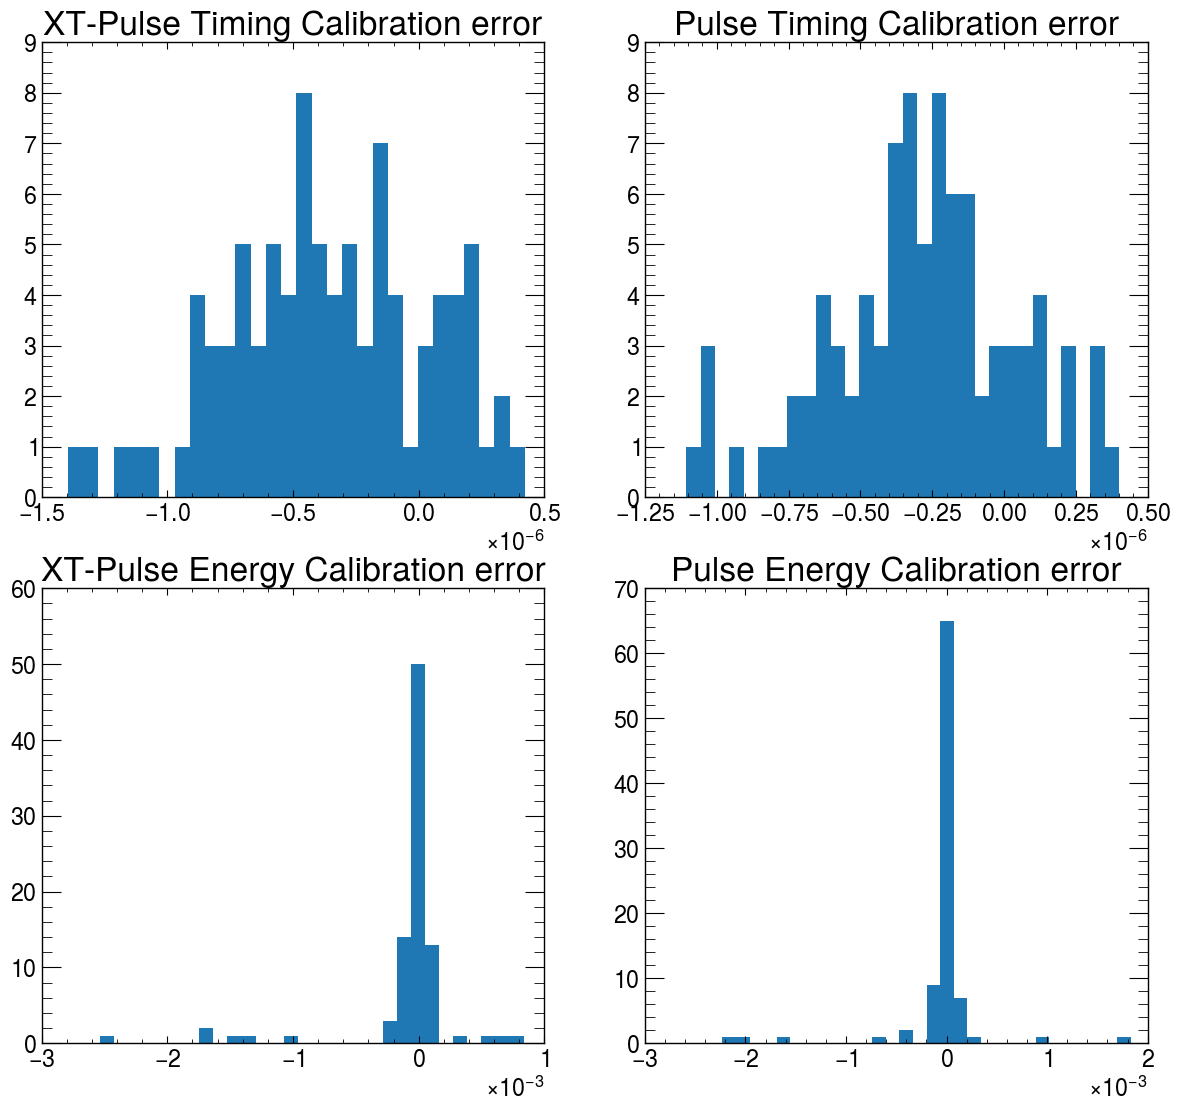

In [ ]:
# myDatasetStream_train.xtpulse.size()
eneList = []
targEneList = []
targTauList = []
tauList = []
ds_ene = []
ds_xtene = []
ds_tau = []
ds_xttau = []
for data_input, target, batch_idx in train_fold:
    ene, tau = myDatasetStream_train.calibrate(batch_idx,data_input)
    tene, ttau = myDatasetStream_train.calibrate(batch_idx,target)
    
    # print(batch_idx,tene,myDatasetStream_train.e[batch_idx], (tene-myDatasetStream_train.e[batch_idx]))
    print(batch_idx,ttau,myDatasetStream_train.t[batch_idx], (ttau-myDatasetStream_train.t[batch_idx]))
    
    ds_ene.append(myDatasetStream_train.e[batch_idx].flatten())
    ds_xtene.append(myDatasetStream_train.xte[batch_idx].flatten())
    ds_tau.append(myDatasetStream_train.t[batch_idx].flatten())
    ds_xttau.append(myDatasetStream_train.xtt[batch_idx].flatten())
    eneList.append(ene.detach().numpy())
    tauList.append(tau.detach().numpy())
    targEneList.append(tene.detach().numpy())
    targTauList.append(ttau.detach().numpy())
    # break
    # continue

# plt.plot(np.arange(len(np.array(tauList).flatten())), np.array(tauList).flatten(),'x')
plt.figure(figsize=(14,13))
plt.subplot(2,2,1)
plt.title('XT-Pulse Timing Calibration error')
plt.hist(torch.stack(ds_xttau).flatten().numpy() - np.array(tauList).flatten(),bins=30)
plt.subplot(2,2,2)
plt.title('Pulse Timing Calibration error')
# plt.hist((myDatasetStream_train.t.flatten().detach()-np.array(targTauList).flatten()).detach().numpy(),bins=30)
plt.hist(torch.stack(ds_tau).flatten().numpy() - np.array(targTauList).flatten(),bins=30)
plt.subplot(2,2,3)
plt.title('XT-Pulse Energy Calibration error')
plt.hist(torch.stack(ds_xtene).flatten().numpy()-np.array(eneList).flatten(),bins=30)
plt.subplot(2,2,4)
plt.title('Pulse Energy Calibration error')
plt.hist(torch.stack(ds_ene).flatten().numpy()-np.array(targEneList).flatten(),bins=30)

plt.show()

In [ ]:
torch.stack(ds_tau).flatten().numpy() - np.array(targTauList).flatten()

array([-2.58940958e-07, -3.21661345e-07, -2.45476691e-07, -7.30064644e-07,
       -1.52605894e-07,  3.01339900e-07,  3.38251510e-07, -5.78734169e-07,
       -4.00320298e-07, -4.67170905e-07, -6.65255837e-07,  2.44896445e-07,
       -3.97803157e-07, -3.86805374e-07, -3.21396046e-07, -2.78328142e-07,
       -3.49411514e-07, -6.11414403e-07, -3.66395003e-07, -5.28151027e-07,
        5.35648490e-08, -2.24353042e-07,  4.60448439e-08,  6.80026341e-08,
       -9.56077602e-08, -2.35916563e-07, -3.50061677e-07, -6.28032817e-07,
       -3.14926118e-07, -3.51259484e-07, -2.72632275e-07, -6.73104794e-08,
       -2.00448416e-07, -4.83188842e-07, -1.65437739e-07, -1.48957661e-07,
       -9.26069369e-07, -6.98834656e-07,  1.47800656e-07, -3.67137029e-07,
       -2.24370898e-07, -7.89213060e-07, -1.65475241e-08, -7.23146042e-07,
       -5.87912496e-09,  4.01215895e-07, -4.51995985e-07, -2.07303222e-07,
       -1.28829996e-07,  1.00517212e-07, -2.17286147e-07,  2.17307848e-07,
       -6.08356599e-07, -

#### DatasetClass / From NPZ / event

In [ ]:
%%timeit -n10
# train_fold_idx = np.arange(conditions['nEvents'])

nEpochs = 5
batch_size = 10

datasetTrain  = XTalkDataset_LZT(dataDict[0:conditions['nEvents']], nEvents=-1, mode='supervised')
train_fold    = DataLoader( datasetTrain, batch_size=batch_size, shuffle=False)

for epoch in range(nEpochs):
    for data_input, target, batch_idx in train_fold:
        continue


13 ms ± 377 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


#### DatasetClass / Streaming From ROOT / event

In [ ]:
# %%timeit -n100

# batch_size = 10
# buffer_batches = 5

conditions = {
    'nEvents':         100, # <--- it is ignored in case of using KFold split.
    'SigmaCut':        1,
    'etaCut':          1.4,
    'caloSampling':    CaloSampling.EMB2,
    'etaSize':         5,
    'phiSize':         5,
    'nSamples':        5,
    'dumpCells':       True,
    'bDumpWindowOnly': True,
    'bNoEneCut':       True,
    'XTalkLevel':      'L = 1.1%, C = 0.0%',
    
    # Not implemented yet!
    'etBin':           [[15 , 20] ,[20, 30]  ,[30, 40]  ,[40, 50],[50,100],[100,10000000]],
    'etaBin':          [[0.00, 0.80], [0.80, 1.37], [1.37,1.54],[1.54,2.50],[2.50,3.2]],
    'bPhaseSpaceDiv':  False,
}

train_fold_idx = np.arange(conditions['nEvents'])

new_tree = TChain('ML_tree')
theFile = '/data/atlas/mhufnage/lzt_single_e/elec_singleCell_10kEvts_centroid_e50_DS1/AOD_Cap0.0_Ind1.1/user.mhufnage.lzt.e50.xtalk.DS1.win55.nopileup.WithCells_EM2.root'#'/home/mhufnage/ATLAS_QT_XTALK/xtalkDatasetAnalysis/newFile.root'
new_tree.Add(theFile+'/ML_tree')

myDatasetStream_train = XTalkStreamingDataLoader_LZT_FoldSplit_Faster(
        new_tree,
        conditions,
        train_fold_idx,
        batch_size,
        buffer_batches)

### Converting ROOT->Python arrays methods

In [ ]:

# conditions = {
#     'nEvents':         9000, # <--- it is the total events to feed KFold_split into (train+valid)+(test).
#     'SigmaCut':        1,
#     'etaCut':          1.4,
#     'caloSampling':    'EM2',#CaloSampling.EMB2,
#     'etaSize':         3,
#     'phiSize':         3,
#     'nSamples':        5,
#     'dumpCells':       True,
#     'bDumpWindowOnly': True,
#     'bNoEneCut':       True,
#     'XTalk_ind':       2.3,
#     'XTalk_cap':       4.2,
#     'XTalkLevel':      'L = 1.1%, C = 0.0%',
    
#     # Not implemented yet!
#     'etBin':           [[15 , 20] ,[20, 30]  ,[30, 40]  ,[40, 50],[50,100],[100,10000000]],
#     'etaBin':          [[0.00, 0.80], [0.80, 1.37], [1.37,1.54],[1.54,2.50],[2.50,3.2]],
#     'bPhaseSpaceDiv':  False,
# }
# datasetPath     = '/data/atlas/mhufnage/lzt_single_e/'
# datasets        = glob(datasetPath+'elec_singleCell_10kEvts_centroid_e50*/AOD_Cap4.2_Ind2.3/electron.AOD.root')
# sTree   = TChain("physics",'')
# for file in datasets:
#     sTree.Add(file+"/physics") # main dumped data tree (event by event)
    
# # Dataset
# data = TChain('ML_tree')
# for ds_index in range(1,2):
#     # print(ds_index, conditions['XTalk_cap'], conditions['XTalk_ind'], conditions['etaSize'], conditions['phiSize'])
#     theFile = '/data/atlas/mhufnage/lzt_single_e/elec_singleCell_10kEvts_centroid_e50_DS{}/AOD_Cap{:.1f}_Ind{:.1f}/user.mhufnage.lzt.e50.xtalk.DS1.win{}{}.nopileup.WithCells_{}.root'.format(ds_index, conditions['XTalk_cap'], conditions['XTalk_ind'], conditions['etaSize'], conditions['phiSize'], conditions['caloSampling'])
#     data.Add(theFile+'/ML_tree')
    
    
def test_nparray(new_tree, totalEvents=40):
    # new_tree = TChain('ML_tree')
    # theFile = '/home/mhufnage/ATLAS_QT_XTALK/xtalkDatasetAnalysis/newFile.root'
    # new_tree.Add(theFile+'/ML_tree')

    buff_pulse      =[]
    buff_xtpulse    =[]
    buff_e          =[]
    buff_xte        =[]
    buff_t          =[]
    buff_xtt        =[]
    buff_edep       =[]
    buff_tof        =[]
    buff_eta        =[]
    buff_phi        =[]
    buff_hash       =[]

    normE = 1.0

    for n in range(totalEvents):
        new_tree.GetEntry(n)

        buff_pulse      .append( torch.tensor(new_tree.cell_pulse, dtype=torch.float, requires_grad=True)*normE     )
        buff_xtpulse    .append( torch.tensor(new_tree.xtcell_pulse, dtype=torch.float, requires_grad=True)*normE   )
        buff_e          .append( np.array(new_tree.cell_e)*normE         )
        buff_xte        .append( np.array(new_tree.xtcell_e)*normE       )
        buff_t          .append( np.array(new_tree.cell_tau)       )
        buff_xtt        .append( np.array(new_tree.xtcell_tau)     )
        buff_edep       .append( np.array(new_tree.cell_edep)      )
        buff_tof        .append( np.array(new_tree.cell_tof)       )
        buff_eta        .append( np.array(new_tree.cell_eta)       )
        buff_phi        .append( np.array(new_tree.cell_phi)       )
        buff_hash       .append( np.array(new_tree.cell_hash)      )

def test_stdVec(new_tree,totalEvents=40):
    # new_tree = TChain('ML_tree')
    # theFile = '/home/mhufnage/ATLAS_QT_XTALK/xtalkDatasetAnalysis/newFile.root'
    # new_tree.Add(theFile+'/ML_tree')
    
    buff_pulse      =[]
    buff_xtpulse    =[]
    buff_e          =[]
    buff_xte        =[]
    buff_t          =[]
    buff_xtt        =[]
    buff_edep       =[]
    buff_tof        =[]
    buff_eta        =[]
    buff_phi        =[]
    buff_hash       =[]

    normE = 1.0

    for n in range(totalEvents):
        new_tree.GetEntry(n)

        buff_pulse      .append( torch.tensor(new_tree.cell_pulse, dtype=torch.float, requires_grad=True)*normE     )
        buff_xtpulse    .append( torch.tensor(new_tree.xtcell_pulse, dtype=torch.float, requires_grad=True)*normE   )
        buff_e          .append( stdVecToArray(new_tree.cell_e)*normE         )
        buff_xte        .append( stdVecToArray(new_tree.xtcell_e)*normE       )
        buff_t          .append( stdVecToArray(new_tree.cell_tau)       )
        buff_xtt        .append( stdVecToArray(new_tree.xtcell_tau)     )
        buff_edep       .append( stdVecToArray(new_tree.cell_edep)      )
        buff_tof        .append( stdVecToArray(new_tree.cell_tof)       )
        buff_eta        .append( stdVecToArray(new_tree.cell_eta)       )
        buff_phi        .append( stdVecToArray(new_tree.cell_phi)       )
        buff_hash       .append( stdVecToArray(new_tree.cell_hash)      )
        
def test_fromBuffer(new_tree, totalEvents=40):
    # new_tree = TChain('ML_tree')
    # theFile = '/home/mhufnage/ATLAS_QT_XTALK/xtalkDatasetAnalysis/newFile.root'
    # new_tree.Add(theFile+'/ML_tree')
    
    buff_pulse      =[]
    buff_xtpulse    =[]
    buff_e          =[]
    buff_xte        =[]
    buff_t          =[]
    buff_xtt        =[]
    buff_edep       =[]
    buff_tof        =[]
    buff_eta        =[]
    buff_phi        =[]
    buff_hash       =[]

    normE = 1.0

    for n in range(totalEvents):
        new_tree.GetEntry(n)

        buff_pulse      .append( torch.tensor(new_tree.cell_pulse, dtype=torch.float, requires_grad=True)*normE     )
        buff_xtpulse    .append( torch.tensor(new_tree.xtcell_pulse, dtype=torch.float, requires_grad=True)*normE   )
        buff_e          .append( np.frombuffer(array('d',new_tree.cell_e), dtype='d')*normE         )
        buff_xte        .append( np.frombuffer(array('d',new_tree.xtcell_e), dtype='d')*normE       )
        buff_t          .append( np.frombuffer(array('d',new_tree.cell_tau), dtype='d')       )
        buff_xtt        .append( np.frombuffer(array('d',new_tree.xtcell_tau), dtype='d')     )
        buff_edep       .append( np.frombuffer(array('d',new_tree.cell_edep), dtype='d')      )
        buff_tof        .append( np.frombuffer(array('d',new_tree.cell_tof), dtype='d')       )
        buff_eta        .append( np.frombuffer(array('d',new_tree.cell_eta), dtype='d')       )
        buff_phi        .append( np.frombuffer(array('d',new_tree.cell_phi), dtype='d')       )
        buff_hash       .append( np.frombuffer(array('d',new_tree.cell_hash), dtype='d')      )
        

def test_asarray(new_tree,totalEvents=40):
    # new_tree = TChain('ML_tree')
    # theFile = '/home/mhufnage/ATLAS_QT_XTALK/xtalkDatasetAnalysis/newFile.root'
    # new_tree.Add(theFile+'/ML_tree')
    
    buff_pulse      =[]
    buff_xtpulse    =[]
    buff_e          =[]
    buff_xte        =[]
    buff_t          =[]
    buff_xtt        =[]
    buff_edep       =[]
    buff_tof        =[]
    buff_eta        =[]
    buff_phi        =[]
    buff_hash       =[]

    normE = 1.0

    for n in range(totalEvents):
        new_tree.GetEntry(n)

        buff_pulse      .append( torch.tensor(new_tree.cell_pulse, dtype=torch.float, requires_grad=True)*normE     )
        buff_xtpulse    .append( torch.tensor(new_tree.xtcell_pulse, dtype=torch.float, requires_grad=True)*normE   )
        buff_e          .append( np.asarray(array('d',new_tree.cell_e))*normE         )
        buff_xte        .append( np.asarray(array('d',new_tree.xtcell_e))*normE       )
        buff_t          .append( np.asarray(array('d',new_tree.cell_tau))       )
        buff_xtt        .append( np.asarray(array('d',new_tree.xtcell_tau))     )
        buff_edep       .append( np.asarray(array('d',new_tree.cell_edep))      )
        buff_tof        .append( np.asarray(array('d',new_tree.cell_tof))       )
        buff_eta        .append( np.asarray(array('d',new_tree.cell_eta))       )
        buff_phi        .append( np.asarray(array('d',new_tree.cell_phi))       )
        buff_hash       .append( np.asarray(array('d',new_tree.cell_hash))      )



# %timeit -n10 test_oldDictLzt(sTree,totalEvents=10)
# %timeit -n2 test_nparray(data,totalEvents=100)
# %timeit -n2 test_stdVec(data,totalEvents=100)
# %timeit -n2 test_fromBuffer(data,totalEvents=100)
# %timeit -n2 test_asarray(data,totalEvents=100)


In [ ]:
# DS_PathAlias  = '/data/atlas/mhufnage/lzt_single_e/elec_singleCell_10kEvts_centroid_e50_DS{}/AOD_Cap4.2_Ind2.3/user.mhufnage.lzt.e50.xtalk.DS{}.win3.nopileup.WithCells_EM2.event.npz'

# dataDict            = []
# for DS_index in range(1, 2):
#     dataDict.append (np.load(DS_PathAlias.format(DS_index,DS_index), allow_pickle=True)['dataset'])
# dataDict = np.concatenate(dataDict).ravel()

def test_asTorchStack(dataTree,totalEvents=40):
    # dataTree = TChain('ML_tree')
    # theFile = '/home/mhufnage/ATLAS_QT_XTALK/xtalkDatasetAnalysis/newFile.root'
    # dataTree.Add(theFile+'/ML_tree')
    
    buff_pulse      =[]
    buff_xtpulse    =[]
    buff_e          =[]
    buff_xte        =[]
    buff_t          =[]
    buff_xtt        =[]
    buff_edep       =[]
    buff_tof        =[]
    buff_eta        =[]
    buff_phi        =[]
    buff_hash       =[]

    normE = 1.0

    for n in range(totalEvents):
        dataTree.GetEntry(n)

        tmp_tensor      = torch.tensor(dataTree.cell_pulse,   dtype=torch.float)   * normE
        tmp_tensorxt    = torch.tensor(dataTree.xtcell_pulse, dtype=torch.float) * normE
        
        buff_pulse      .append(tmp_tensor)
        buff_xtpulse    .append(tmp_tensorxt)
        buff_e          .append( stdVecToArray(dataTree.cell_e)*normE         )
        buff_xte        .append( stdVecToArray(dataTree.xtcell_e)*normE       )
        buff_t          .append( stdVecToArray(dataTree.cell_tau)       )
        buff_xtt        .append( stdVecToArray(dataTree.xtcell_tau)     )
        buff_edep       .append( stdVecToArray(dataTree.cell_edep)      )
        buff_tof        .append( stdVecToArray(dataTree.cell_tof)       )
        buff_eta        .append( stdVecToArray(dataTree.cell_eta)       )
        buff_phi        .append( stdVecToArray(dataTree.cell_phi)       )
        buff_hash       .append( stdVecToArray(dataTree.cell_hash)      )
        

def fromRAM_NPZ(xtalkDict, nEvents=10):
    pulse             = []
    xtpulse           = []
    e                 = []
    xte               = []
    t                 = []
    xtt               = []
    edep              = []
    tof               = []
    eta               = []
    phi               = []        
    hash              = []

    normE = 1

    # if nEvents==-1:
    #     nEvents=len(xtalkDict)

    for index, eventDict in enumerate(xtalkDict[0:nEvents]):
        # if (len(eventDict['cell_e'][0]) != self.neta*self.nphi):
        #     continue

        pulse      .append( torch.tensor( np.hstack(eventDict['cell_pulse'][0] * normE).flatten().astype(float) , dtype=torch.float, requires_grad=True) )
        xtpulse    .append( torch.tensor( np.hstack(eventDict['xtcell_pulse'][0] * normE).flatten().astype(float) , dtype=torch.float, requires_grad=True) )
        e          .append( eventDict['cell_e'][0] * normE )
        xte        .append( eventDict['xtcell_e'][0] * normE )
        t          .append( eventDict['cell_tau'][0])
        xtt        .append( eventDict['xtcell_tau'][0])
        edep       .append( eventDict['cell_edep'][0])
        tof        .append( eventDict['cell_tof'][0])
        eta        .append( eventDict['cell_eta'][0])
        phi        .append( eventDict['cell_phi'][0])
        hash       .append( eventDict['cell_hash'][0])

def test_allTensor(dataTree,totalEvents=40):
    # dataTree = TChain('ML_tree')
    # theFile = '/home/mhufnage/ATLAS_QT_XTALK/xtalkDatasetAnalysis/newFile.root'
    # dataTree.Add(theFile+'/ML_tree')
    
    buff_pulse      =[]
    buff_xtpulse    =[]
    buff_e          =[]
    buff_xte        =[]
    buff_t          =[]
    buff_xtt        =[]
    buff_edep       =[]
    buff_tof        =[]
    buff_eta        =[]
    buff_phi        =[]
    buff_hash       =[]

    normE = 1.0

    for n in range(totalEvents):
        # print(n)
        dataTree.GetEntry(n)

        # tmp_tensor      = torch.tensor(dataTree.cell_pulse,   dtype=torch.float)   * normE
        # tmp_tensorxt    = torch.tensor(dataTree.xtcell_pulse, dtype=torch.float) * normE
        
        buff_pulse      .append(array('d',dataTree.cell_pulse))
        buff_xtpulse    .append(array('d',dataTree.xtcell_pulse))
        buff_e          .append(array('d',dataTree.cell_e)  )
        buff_xte        .append(array('d',dataTree.xtcell_e))
        buff_t          .append(array('d',dataTree.cell_tau)      )
        buff_xtt        .append(array('d',dataTree.xtcell_tau)    )
        buff_edep       .append(array('d',dataTree.cell_edep)     )
        buff_tof        .append(array('d',dataTree.cell_tof)      )
        buff_eta        .append(array('d',dataTree.cell_eta)      )
        buff_phi        .append(array('d',dataTree.cell_phi)      )
        buff_hash       .append(array('L',dataTree.cell_hash)     )
        
        
    pulse   = torch.as_tensor(buff_pulse)*normE
    xtpulse = torch.as_tensor(buff_xtpulse)*normE
    e   = torch.as_tensor(buff_e)*normE
    xte = torch.as_tensor(buff_xte)*normE
    t   = torch.as_tensor(buff_t)
    xtt = torch.as_tensor(buff_xtt)
    edep    = torch.as_tensor(buff_edep)
    tof = torch.as_tensor(buff_tof)
    eta = torch.as_tensor(buff_eta)
    phi = torch.as_tensor(buff_phi)
    hash    = torch.as_tensor(buff_hash)
        
    return pulse, buff_pulse

def test_EmptyTensor(dataTree,totalEvents=40):
    # dataTree = TChain('ML_tree')
    # theFile = '/home/mhufnage/ATLAS_QT_XTALK/xtalkDatasetAnalysis/newFile.root'
    # dataTree.Add(theFile+'/ML_tree')
    
    pulse      =torch.empty(size=(totalEvents, 45), dtype=torch.double)
    xtpulse    =torch.empty(size=(totalEvents, 45), dtype=torch.double)
    e          =torch.empty(size=(totalEvents, 9), dtype=torch.double)
    xte        =torch.empty(size=(totalEvents, 9), dtype=torch.double)
    t          =torch.empty(size=(totalEvents, 9), dtype=torch.double)
    xtt        =torch.empty(size=(totalEvents, 9), dtype=torch.double)
    edep       =torch.empty(size=(totalEvents, 9), dtype=torch.double)
    tof        =torch.empty(size=(totalEvents, 9), dtype=torch.double)
    eta        =torch.empty(size=(totalEvents, 9), dtype=torch.double)
    phi        =torch.empty(size=(totalEvents, 9), dtype=torch.double)
    hash       =torch.empty(size=(totalEvents, 9), dtype=torch.long)

    normE = 1.0

    for n in range(totalEvents):
        # print(n)
        dataTree.GetEntry(n)

        # tmp_tensor      = torch.tensor(dataTree.cell_pulse,   dtype=torch.float)   * normE
        # tmp_tensorxt    = torch.tensor(dataTree.xtcell_pulse, dtype=torch.float) * normE
        
        pulse  [n] = torch.as_tensor(dataTree.cell_pulse)
        xtpulse[n] = torch.as_tensor(dataTree.xtcell_pulse)
        e      [n] = torch.as_tensor(dataTree.cell_e)  
        xte    [n] = torch.as_tensor(dataTree.xtcell_e)
        t      [n] = torch.as_tensor(dataTree.cell_tau)      
        xtt    [n] = torch.as_tensor(dataTree.xtcell_tau)    
        edep   [n] = torch.as_tensor(dataTree.cell_edep)     
        tof    [n] = torch.as_tensor(dataTree.cell_tof)      
        eta    [n] = torch.as_tensor(dataTree.cell_eta)      
        phi    [n] = torch.as_tensor(dataTree.cell_phi)      
        hash   [n] = torch.as_tensor(dataTree.cell_hash)     
        
        
    return pulse, xtpulse

dataML.SetBranchStatus("*",1)
%timeit -n10 fromRAM_NPZ(dataDict, nEvents=100)
%timeit -n10 test_asTorchStack(dataML,totalEvents=100)
%timeit -n10 test_allTensor(dataML,totalEvents=100)
%timeit -n10 test_EmptyTensor(dataML,totalEvents=100)
# pulse, ene = test_allTensor(dataML,totalEvents=100)

18.2 ms ± 561 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
41.7 ms ± 1.25 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
23 ms ± 237 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
82.9 ms ± 936 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [ ]:
# print(ene[0])
# print( torch.frombuffer(ene[0].data(), dtype=torch.float))
# print( torch.as_tensor(ene, dtype=torch.float))

pulse, xtpulse = test_EmptyTensor(dataML,totalEvents=10)
# pulse
# buffpulse
# dataML.GetEntry(1)
# array('d',dataML.cell_e)
pulse.shape

torch.Size([10, 45])

### All training infra

In [ ]:
# Dataset
# data            = []
# for DS_index in range(1, DS_Lim):
#     data.append (np.load(DS_PathAlias.format(DS_index,DS_index), allow_pickle=True)['dataset'])
# dataNPZ = np.concatenate(data).ravel()

def fromNPZ(data, num_events=300, batch_size=16):
    
    evaluatedTime = []
    
    nEpochs                 = 10
    lossComputation         = 'p'
    patience                = 15
    min_delta_loss          = 0

    k                       = 3 # number of folds in kFold split
    nBatch                  = batch_size # batch size in clusters
    nIter                   = 1
    nClusters               = num_events # for training, validation and test

    pathLoss      = '/data/atlas/mhufnage/xtalk/ml_training/supervised_lzt/data_structure_comparison/direct_NPZ/'
    DS_Lim        = 2
    DS_test       = 6
    DS_PathAlias  = '/data/atlas/mhufnage/lzt_single_e/elec_singleCell_10kEvts_centroid_e50_DS{}/AOD_Cap4.2_Ind2.3/user.mhufnage.lzt.e50.xtalk.DS{}.win3.nopileup.WithCells_EM2.event.npz'

    # # Dataset
    # data            = []
    # for DS_index in range(1, DS_Lim):
    #     data.append (np.load(DS_PathAlias.format(DS_index,DS_index), allow_pickle=True)['dataset'])
    # data = np.concatenate(data).ravel()

    optimAlg                = 'adam'
    typeNormalization       = {'electronEnergy': 50.0,
                            'mevToGev': 1/1000,
                            'gevToMev': 1000,
                            'none': 1}#'minMax'

    lr                      = 1e-3
    weightDecay_adam        = 1e-5

    optimConfig             = {
        'adam':{
            'learningRate'  : lr,
            'weightDecay'   : weightDecay_adam,
        },
    }

    # print(optimConfig[optimAlg])

    range_neuInput          = [45,20,20]
    range_neuText           = MLP.neuListToFileText(range_neuInput)

    experiment_alias        = '''
    learning the samples of a 3x3 window from topocluster at EMB2 layer. 
    The loss for training is the input-output map. 
    The cell organization in the window is eta-oriented.
    # phi [ 3 | 6 | 9 ]
    #     [ 2 | 5 | 8 ]  , eta-orientation cluster indexing. where 5 is the index of the hottest cell
    #     [ 1 | 4 | 7 ]
    #             eta
    '''
    totalEvents             = len(data)

    nSamples                = 5 # standard for LAr
    nCellsWinEta            = 3 # dataset selection
    nCellsWinPhi            = 3
    scalerInput             = torch.tensor((typeNormalization['mevToGev'])) # without normalization, set to 1
    scalerOutput            = torch.tensor(typeNormalization['gevToMev'])

    train_ratio             = 0.90 # proportion of data to apply the kFold
    test_ratio              = 0.10 # proportion of data to apply test on trained model

    if not(os.path.isdir(pathLoss)):
        os.mkdir(pathLoss)

    #
    # Dataset split
    #
    total_ene = []
    total_tau = []

    train_config_dict   = {
        'experiment_alias'  : experiment_alias,
        'patience'          : patience,
        'min_delta_loss'    : min_delta_loss,
        'max_epochs'        : nEpochs,
        'kFolds'            : k,
        'batch_size'        : nBatch,
        'max_init'          : nIter,
        'total_clusters'    : totalEvents,
        'train_ratio'       : train_ratio,
        'test_ratio'        : test_ratio,
        'cell_win_eta'      : nCellsWinEta,
        'cell_win_phi'      : nCellsWinPhi,
        'scaler_input'      : scalerInput,
        'scaler_output'     : scalerOutput,
        'neurons_list'      : range_neuInput,
        'neurons_text'      : range_neuText,
        'lossComputation'   : lossComputation,
        'optimConfig'       : optimConfig,
    }

    # if optimAlg=='adam':
    # np.savez(pathLoss+'config_train_nn{}_{}_neu{}.npz'.format(lossComputation, optimAlg, range_neuText), config=train_config_dict)

    X_train, X_test = train_test_split( data[0:nClusters] , test_size=test_ratio)

    datasetTest     =   XTalkDataset_LZT(X_test, nEvents=-1, mode='supervised')

    kfold = KFold(n_splits=k, shuffle=True, random_state=1)

    for nFold, (train_fold_idx, valid_fold_idx) in enumerate(kfold.split(X_train)):
        
        # init = time()
        datasetTrain  = XTalkDataset_LZT(X_train[train_fold_idx], nEvents=-1, mode='supervised')
        datasetValid  = XTalkDataset_LZT(X_train[valid_fold_idx], nEvents=-1, mode='supervised')
        # datasetTrain = XTalkDataset_LZT_FromROOT(dataML,conditions,train_fold_idx,load_full_data=False)
        # datasetValid = XTalkDataset_LZT_FromROOT(dataML,conditions,valid_fold_idx,load_full_data=False)
        
        train_fold    = DataLoader( datasetTrain, batch_size=nBatch, shuffle=False)
        val_fold      = DataLoader( datasetValid, batch_size=nBatch, shuffle=False)
        
        # final = time()
        # print('Train+Valid Init: {:.4f}ms\n'.format(final-init)*1000)
        # evaluatedTime.append((final-init)*1000)
        
        for it in range(0,nIter):
            # print('\t\tFold {}/{}... iter {}/{}'.format(nFold+1,k, it+1, nIter))
            
            train_logging_dict  = {
                'loss'              : [],
                'val_loss'          : [],
                'tau_loss'          : [],
                'val_tau_loss'      : [],
                'ene_loss'          : [],
                'val_ene_loss'      : [],
                'total_loss'        : [],
                'total_val_loss'    : [],

                'best_epoch'    : -1,
            }
            
            #
            # Model initialization
            #
            model = MLP.MLP_FF(range_neuInput, mlpType='sampleInSampleOut')
            
            if optimAlg=='adam':
                optimizer = torch.optim.Adam(model.parameters(), 
                                            lr=optimConfig[optimAlg]['learningRate'], 
                                            weight_decay=optimConfig[optimAlg]['weightDecay'])
            
            early_stopper  = MLP.EarlyStopper(patience=patience, min_delta=min_delta_loss)
            
            for epoch in range(nEpochs):
                #
                # Training
                #
                init = time()
                for data_input, target, batch_idx in train_fold:
                    continue
                
                final=time()
                evaluatedTime.append((final-init)*1000)
                
    return evaluatedTime


# dataROOT = TChain('ML_tree')
# for ds_index in range(1,2):
#     # print(ds_index, conditions['XTalk_cap'], conditions['XTalk_ind'], conditions['etaSize'], conditions['phiSize'])
#     theFile = '/data/atlas/mhufnage/lzt_single_e/elec_singleCell_10kEvts_centroid_e50_DS{}/AOD_Cap{:.1f}_Ind{:.1f}/user.mhufnage.lzt.e50.xtalk.DS1.win{}{}.nopileup.WithCells_{}.root'.format(ds_index, conditions['XTalk_cap'], conditions['XTalk_ind'], conditions['etaSize'], conditions['phiSize'], conditions['caloSampling'])
#     dataROOT.Add(theFile+'/ML_tree')

def fromROOT(data, num_evts=300,num_batches=4,batch_size=16,load_full_data=False):
    evaluatedTime = []
    pathLoss      = '/data/atlas/mhufnage/xtalk/ml_training/supervised_lzt/data_structure_comparison/sub_ROOT/'

    conditions = {
        'nEvents':         num_evts, # <--- it is the total events to feed KFold_split into (train+valid)+(test).
        'SigmaCut':        1,
        'etaCut':          1.4,
        'caloSampling':    'EM2',#CaloSampling.EMB2,
        'etaSize':         3,
        'phiSize':         3,
        'nSamples':        5,
        'dumpCells':       True,
        'bDumpWindowOnly': True,
        'bNoEneCut':       True,
        'XTalk_ind':       2.3,
        'XTalk_cap':       4.2,
        'XTalkLevel':      'L = 1.1%, C = 0.0%',
        
        # Not implemented yet!
        'etBin':           [[15 , 20] ,[20, 30]  ,[30, 40]  ,[40, 50],[50,100],[100,10000000]],
        'etaBin':          [[0.00, 0.80], [0.80, 1.37], [1.37,1.54],[1.54,2.50],[2.50,3.2]],
        'bPhaseSpaceDiv':  False,
    }
    nEpochs                 = 10
    lossComputation         = 'p'
    patience                = 15
    min_delta_loss          = 0

    k                       = 3 # number of folds in kFold split
    nBatch                  = batch_size # batch size in clusters
    buffer_batches          = num_batches  # number of batches to being loaded into TTree dataset reading buffer (buffer_batches * nBatch)
    nIter                   = 1
    
    # Dataset
    # data = TChain('ML_tree')
    # for ds_index in range(1,2):
    #     # print(ds_index, conditions['XTalk_cap'], conditions['XTalk_ind'], conditions['etaSize'], conditions['phiSize'])
    #     theFile = '/data/atlas/mhufnage/lzt_single_e/elec_singleCell_10kEvts_centroid_e50_DS{}/AOD_Cap{:.1f}_Ind{:.1f}/user.mhufnage.lzt.e50.xtalk.DS1.win{}{}.nopileup.WithCells_{}.root'.format(ds_index, conditions['XTalk_cap'], conditions['XTalk_ind'], conditions['etaSize'], conditions['phiSize'], conditions['caloSampling'])
    #     data.Add(theFile+'/ML_tree')

    optimAlg                = 'adam'
    typeNormalization       = {'electronEnergy': 50.0,
                            'mevToGev': 1/1000,
                            'gevToMev': 1000,
                            'none': 1}#'minMax'

    lr                      = 1e-3
    weightDecay_adam        = 1e-5

    optimConfig             = {
        'adam':{
            'learningRate'  : lr,
            'weightDecay'   : weightDecay_adam,
        },
    }

    # print(optimConfig[optimAlg])

    range_neuInput          = [45,20,20]
    range_neuText           = MLP.neuListToFileText(range_neuInput)

    experiment_alias        = '''
    learning the samples of a 3x3 window from topocluster at EMB2 layer. 
    The loss for training is the input-output map. 
    The cell organization in the window is eta-oriented.
    # phi [ 3 | 6 | 9 ]
    #     [ 2 | 5 | 8 ]  , eta-orientation cluster indexing. where 5 is the index of the hottest cell
    #     [ 1 | 4 | 7 ]
    #             eta
    '''
    totalEvents             = data.GetEntries()#len(data)


    nClusters               = conditions['nEvents'] # for training and validation

    nSamples                = 5 # standard for LAr
    nCellsWinEta            = 3 # dataset selection
    nCellsWinPhi            = 3
    scalerInput             = torch.tensor((typeNormalization['mevToGev'])) # without normalization, set to 1
    scalerOutput            = torch.tensor(typeNormalization['gevToMev'])

    train_ratio             = 0.90 # proportion of data to apply the kFold
    test_ratio              = 0.10 # proportion of data to apply test on trained model

    if not(os.path.isdir(pathLoss)):
        os.mkdir(pathLoss)

    #
    # Dataset split
    #
    total_ene = []
    total_tau = []

    train_config_dict   = {
        'experiment_alias'  : experiment_alias,
        'conditions'        : conditions,
        'patience'          : patience,
        'min_delta_loss'    : min_delta_loss,
        'max_epochs'        : nEpochs,
        'kFolds'            : k,
        'batch_size'        : nBatch,
        'buffer_batches'    : buffer_batches,
        'max_init'          : nIter,
        'total_clusters'    : totalEvents,
        'train_ratio'       : train_ratio,
        'test_ratio'        : test_ratio,
        'cell_win_eta'      : nCellsWinEta,
        'cell_win_phi'      : nCellsWinPhi,
        'scaler_input'      : scalerInput,
        'scaler_output'     : scalerOutput,
        'neurons_list'      : range_neuInput,
        'neurons_text'      : range_neuText,
        'lossComputation'   : lossComputation,
        'optimConfig'       : optimConfig,
    }

    # if optimAlg=='adam':
    # np.savez(pathLoss+'config_train_nn{}_{}_neu{}.npz'.format(lossComputation, optimAlg, range_neuText), config=train_config_dict)

    X_train, X_test = train_test_split( np.arange(0, nClusters) , test_size=test_ratio)
    
    # init = time()
    datasetTest = XTalkStreamingDataLoader_LZT_FoldSplit_FasterDEV(data, conditions, X_test, nBatch, buffer_batches, mode='supervised', load_full_data=load_full_data)
    # final = time()
    # print('Test Init: {:.4f}ms\n'.format(final-init)*1000)

    kfold = KFold(n_splits=k, shuffle=True, random_state=1)

    for nFold, (train_fold_idx, valid_fold_idx) in enumerate(kfold.split(X_train)):

        # datasetTrain  = XTalkDataset_LZT(X_train[train_fold_idx], nEvents=-1, mode='supervised')
        # datasetValid  = XTalkDataset_LZT(X_train[valid_fold_idx], nEvents=-1, mode='supervised')
        # train_fold    = DataLoader( datasetTrain, batch_size=nBatch, shuffle=False)
        # val_fold      = DataLoader( datasetValid, batch_size=nBatch, shuffle=False)
        # init = time()
        train_fold = XTalkStreamingDataLoader_LZT_FoldSplit_FasterDEV(data, conditions, X_train[train_fold_idx], nBatch, buffer_batches, mode='supervised', load_full_data=load_full_data)

        val_fold   = XTalkStreamingDataLoader_LZT_FoldSplit_FasterDEV(data, conditions, X_train[valid_fold_idx], nBatch, buffer_batches, mode='supervised', load_full_data=load_full_data)
        # final = time()
        # print('Train+Valid Init: {:.4f}ms\n'.format(final-init)*1000)
        # evaluatedTime.append((final-init)*1000)
        
        for it in range(0,nIter):
            # print('\t\tFold {}/{}... iter {}/{}'.format(nFold+1,k, it+1, nIter))
            
            train_logging_dict  = {
                'loss'              : [],
                'val_loss'          : [],
                'tau_loss'          : [],
                'val_tau_loss'      : [],
                'ene_loss'          : [],
                'val_ene_loss'      : [],
                'total_loss'        : [],
                'total_val_loss'    : [],

                'best_epoch'    : -1,
            }
            
            #
            # Model initialization
            #
            model = MLP.MLP_FF(range_neuInput, mlpType='sampleInSampleOut')
            
            if optimAlg=='adam':
                optimizer = torch.optim.Adam(model.parameters(), 
                                            lr=optimConfig[optimAlg]['learningRate'], 
                                            weight_decay=optimConfig[optimAlg]['weightDecay'])
            
            early_stopper  = MLP.EarlyStopper(patience=patience, min_delta=min_delta_loss)
            
            for epoch in range(nEpochs):
                #
                # Training
                #
                init = time()
                for data_input, target, batch_idx in train_fold:
                    continue
                
                final=time()
                evaluatedTime.append((final-init)*1000)
    
    return evaluatedTime

def fromROOT_loadAll(data, num_evts=300,num_batches=4,batch_size=16,load_full_data=False):
    evaluatedTime = []
    pathLoss      = '/data/atlas/mhufnage/xtalk/ml_training/supervised_lzt/data_structure_comparison/sub_ROOT/'

    conditions = {
        'nEvents':         num_evts, # <--- it is the total events to feed KFold_split into (train+valid)+(test).
        'SigmaCut':        1,
        'etaCut':          1.4,
        'caloSampling':    'EM2',#CaloSampling.EMB2,
        'etaSize':         3,
        'phiSize':         3,
        'nSamples':        5,
        'dumpCells':       True,
        'bDumpWindowOnly': True,
        'bNoEneCut':       True,
        'XTalk_ind':       2.3,
        'XTalk_cap':       4.2,
        'XTalkLevel':      'L = 1.1%, C = 0.0%',
        
        # Not implemented yet!
        'etBin':           [[15 , 20] ,[20, 30]  ,[30, 40]  ,[40, 50],[50,100],[100,10000000]],
        'etaBin':          [[0.00, 0.80], [0.80, 1.37], [1.37,1.54],[1.54,2.50],[2.50,3.2]],
        'bPhaseSpaceDiv':  False,
    }
    nEpochs                 = 10
    lossComputation         = 'p'
    patience                = 15
    min_delta_loss          = 0

    k                       = 3 # number of folds in kFold split
    nBatch                  = batch_size # batch size in clusters
    buffer_batches          = num_batches  # number of batches to being loaded into TTree dataset reading buffer (buffer_batches * nBatch)
    nIter                   = 1
    
    # Dataset
    # data = TChain('ML_tree')
    # for ds_index in range(1,2):
    #     # print(ds_index, conditions['XTalk_cap'], conditions['XTalk_ind'], conditions['etaSize'], conditions['phiSize'])
    #     theFile = '/data/atlas/mhufnage/lzt_single_e/elec_singleCell_10kEvts_centroid_e50_DS{}/AOD_Cap{:.1f}_Ind{:.1f}/user.mhufnage.lzt.e50.xtalk.DS1.win{}{}.nopileup.WithCells_{}.root'.format(ds_index, conditions['XTalk_cap'], conditions['XTalk_ind'], conditions['etaSize'], conditions['phiSize'], conditions['caloSampling'])
    #     data.Add(theFile+'/ML_tree')

    optimAlg                = 'adam'
    typeNormalization       = {'electronEnergy': 50.0,
                            'mevToGev': 1/1000,
                            'gevToMev': 1000,
                            'none': 1}#'minMax'

    lr                      = 1e-3
    weightDecay_adam        = 1e-5

    optimConfig             = {
        'adam':{
            'learningRate'  : lr,
            'weightDecay'   : weightDecay_adam,
        },
    }

    # print(optimConfig[optimAlg])

    range_neuInput          = [45,20,20]
    range_neuText           = MLP.neuListToFileText(range_neuInput)

    experiment_alias        = '''
    learning the samples of a 3x3 window from topocluster at EMB2 layer. 
    The loss for training is the input-output map. 
    The cell organization in the window is eta-oriented.
    # phi [ 3 | 6 | 9 ]
    #     [ 2 | 5 | 8 ]  , eta-orientation cluster indexing. where 5 is the index of the hottest cell
    #     [ 1 | 4 | 7 ]
    #             eta
    '''
    totalEvents             = data.GetEntries()#len(data)


    nClusters               = conditions['nEvents'] # for training and validation

    nSamples                = 5 # standard for LAr
    nCellsWinEta            = 3 # dataset selection
    nCellsWinPhi            = 3
    scalerInput             = torch.tensor((typeNormalization['mevToGev'])) # without normalization, set to 1
    scalerOutput            = torch.tensor(typeNormalization['gevToMev'])

    train_ratio             = 0.90 # proportion of data to apply the kFold
    test_ratio              = 0.10 # proportion of data to apply test on trained model

    if not(os.path.isdir(pathLoss)):
        os.mkdir(pathLoss)

    #
    # Dataset split
    #
    total_ene = []
    total_tau = []

    train_config_dict   = {
        'experiment_alias'  : experiment_alias,
        'conditions'        : conditions,
        'patience'          : patience,
        'min_delta_loss'    : min_delta_loss,
        'max_epochs'        : nEpochs,
        'kFolds'            : k,
        'batch_size'        : nBatch,
        'buffer_batches'    : buffer_batches,
        'max_init'          : nIter,
        'total_clusters'    : totalEvents,
        'train_ratio'       : train_ratio,
        'test_ratio'        : test_ratio,
        'cell_win_eta'      : nCellsWinEta,
        'cell_win_phi'      : nCellsWinPhi,
        'scaler_input'      : scalerInput,
        'scaler_output'     : scalerOutput,
        'neurons_list'      : range_neuInput,
        'neurons_text'      : range_neuText,
        'lossComputation'   : lossComputation,
        'optimConfig'       : optimConfig,
    }

    # if optimAlg=='adam':
    # np.savez(pathLoss+'config_train_nn{}_{}_neu{}.npz'.format(lossComputation, optimAlg, range_neuText), config=train_config_dict)

    X_train, X_test = train_test_split( np.arange(0, nClusters) , test_size=test_ratio)
    
    # init = time()
    datasetTest = XTalkDataset_LZT_FromROOT(dataML,conditions,X_test,load_full_data=load_full_data)
    # final = time()
    # print('Test Init: {:.4f}ms\n'.format(final-init)*1000)

    kfold = KFold(n_splits=k, shuffle=True, random_state=1)

    for nFold, (train_fold_idx, valid_fold_idx) in enumerate(kfold.split(X_train)):

        datasetTrain = XTalkDataset_LZT_FromROOT(dataML,conditions,train_fold_idx,load_full_data=load_full_data)
        datasetValid = XTalkDataset_LZT_FromROOT(dataML,conditions,valid_fold_idx,load_full_data=load_full_data)
        
        train_fold    = DataLoader( datasetTrain, batch_size=nBatch, shuffle=False)
        val_fold      = DataLoader( datasetValid, batch_size=nBatch, shuffle=False)
        # # init = time()
        # train_fold = XTalkStreamingDataLoader_LZT_FoldSplit_FasterDEV(data, conditions, X_train[train_fold_idx], nBatch, buffer_batches, mode='supervised', load_full_data=load_full_data)
        # val_fold   = XTalkStreamingDataLoader_LZT_FoldSplit_FasterDEV(data, conditions, X_train[valid_fold_idx], nBatch, buffer_batches, mode='supervised', load_full_data=load_full_data)
        # final = time()
        # print('Train+Valid Init: {:.4f}ms\n'.format(final-init)*1000)
        # evaluatedTime.append((final-init)*1000)
        
        for it in range(0,nIter):
            # print('\t\tFold {}/{}... iter {}/{}'.format(nFold+1,k, it+1, nIter))
            
            train_logging_dict  = {
                'loss'              : [],
                'val_loss'          : [],
                'tau_loss'          : [],
                'val_tau_loss'      : [],
                'ene_loss'          : [],
                'val_ene_loss'      : [],
                'total_loss'        : [],
                'total_val_loss'    : [],

                'best_epoch'    : -1,
            }
            
            #
            # Model initialization
            #
            model = MLP.MLP_FF(range_neuInput, mlpType='sampleInSampleOut')
            
            if optimAlg=='adam':
                optimizer = torch.optim.Adam(model.parameters(), 
                                            lr=optimConfig[optimAlg]['learningRate'], 
                                            weight_decay=optimConfig[optimAlg]['weightDecay'])
            
            early_stopper  = MLP.EarlyStopper(patience=patience, min_delta=min_delta_loss)
            
            for epoch in range(nEpochs):
                #
                # Training
                #
                init = time()
                for data_input, target, batch_idx in train_fold:
                    # print(data_input)
                    continue
                
                final=time()
                evaluatedTime.append((final-init)*1000)
    
    return evaluatedTime

dataML.SetBranchStatus("*",0)
branches = []
# if self.load_full_data:
#     branches = ['cell_pulse','xtcell_pulse','cell_e', 'xtcell_e', 'cell_tau', 'xtcell_tau','cell_edep','xtcell_edep','cell_tof', 'xtcell_tof', 'cell_eta', 'xtcell_eta', 'cell_phi', 'xtcell_phi','cell_hash' ]
# else:
# branches = ['cell_pulse','xtcell_pulse' ]
# for br in branches:
#     dataML.SetBranchStatus(br,1)

# %timeit -n3 fromNPZ(dataDict)
# %timeit -n3 fromROOT(dataML, load_full_data=False)
# %timeit -n3 fromROOT(dataML_TFileTree, load_full_data=True)
# %timeit -n10 fromROOT(dataML, load_full_data=True)

In [ ]:
total_events = 1000


dataML.SetBranchStatus('*',0)
branches = ['cell_pulse','xtcell_pulse' ]
for br in branches:
    dataML.SetBranchStatus(br,1)

t_npz  = fromNPZ(dataDict,num_events=total_events)
t_root_load = fromROOT_loadAll(dataML, num_evts=total_events,num_batches=4,batch_size=16,load_full_data=False)
t_root = fromROOT(dataML, num_evts=total_events,num_batches=4,batch_size=16,load_full_data=False)

dataML.SetBranchStatus('*',1)
t_root_load_full = fromROOT_loadAll(dataML, num_evts=total_events,num_batches=4,batch_size=16,load_full_data=True)
# t_root_full = fromROOT(dataML, num_evts=total_events,num_batches=4,batch_size=16,load_full_data=True)

# t_root_buff = fromROOT(dataML, num_evts=1000,num_batches=50,batch_size=16,load_full_data=False)
# t_root_batch = fromROOT(dataML, num_evts=1000,num_batches=4,batch_size=128,load_full_data=False)
# #


Event idx 0(129)/100
Data loaded! Initalizing tensor convertion...
Event idx 0(1)/600
Event idx 100(162)/600
Event idx 200(306)/600
Event idx 300(442)/600
Event idx 400(591)/600
Event idx 500(752)/600
Data loaded! Initalizing tensor convertion...
Event idx 0(0)/300
Event idx 100(286)/300
Event idx 200(607)/300
Data loaded! Initalizing tensor convertion...
Event idx 0(0)/600
Event idx 100(145)/600
Event idx 200(289)/600
Event idx 300(461)/600
Event idx 400(603)/600
Event idx 500(753)/600
Data loaded! Initalizing tensor convertion...
Event idx 0(1)/300
Event idx 100(323)/300
Event idx 200(590)/300
Data loaded! Initalizing tensor convertion...
Event idx 0(0)/600
Event idx 100(139)/600
Event idx 200(305)/600
Event idx 300(445)/600
Event idx 400(602)/600
Event idx 500(745)/600
Data loaded! Initalizing tensor convertion...
Event idx 0(7)/300
Event idx 100(296)/300
Event idx 200(595)/300
Data loaded! Initalizing tensor convertion...
Event idx 0(616)/100
Data loaded! Initalizing tensor convert

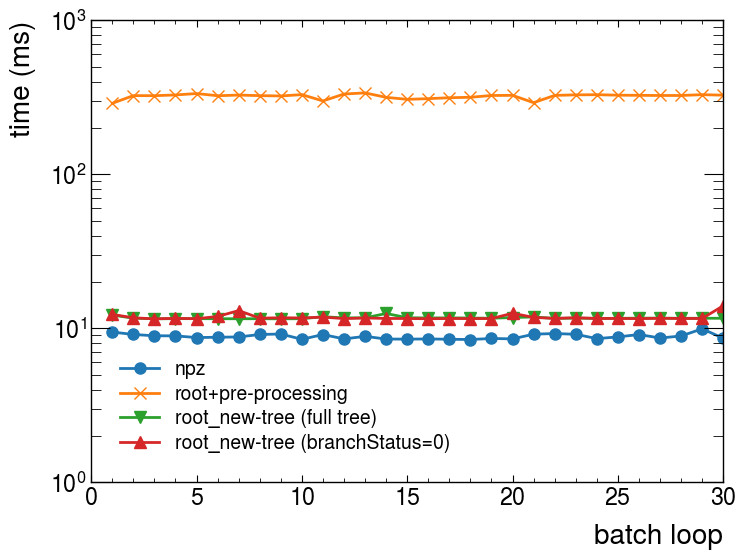

In [ ]:
plt.plot(np.arange(1,31),t_npz,'-o',label='npz')
plt.plot(np.arange(1,31),t_root,'-x',label='root+pre-processing')
# plt.plot(np.arange(1,7),t_root_full,'-x',label='root_full')
# plt.plot(np.arange(1,7),t_root_buff,'-o',label='root_buff')
# plt.plot(np.arange(1,7),t_root_batch,'-o',label='root_batch')
plt.plot(np.arange(1,31),t_root_load_full,'-v',label='root_new-tree (full tree)')
plt.plot(np.arange(1,31),t_root_load,'-^',label='root_new-tree (branchStatus=0)')
# plt.plot(np.arange(1,7),np.array(t_root)/np.array(t_npz), '-v',label='root/npz')
plt.ylabel('time (ms)')
plt.xlabel('batch loop')
plt.legend()
plt.yscale('log')
plt.show()

In [ ]:
%timeit -n3 t_npz  = fromNPZ(dataDict,num_events=100)
%timeit -n3 t_root = fromROOT(dataML, num_evts=100,num_batches=4,batch_size=16,load_full_data=False)
%timeit -n3 t_root_load = fromROOT_loadAll(dataML, num_evts=100,num_batches=4,batch_size=16,load_full_data=False)
# %timeit -n3 t_root_buff = fromROOT(dataML, num_evts=1000,num_batches=15,batch_size=16,load_full_data=False)
# %timeit -n3 t_root_batch = fromROOT(dataML, num_evts=1000,num_batches=4,batch_size=128,load_full_data=False)

68.6 ms ± 902 µs per loop (mean ± std. dev. of 7 runs, 3 loops each)
buffer lenght is grater than total number of events.
buffer_len=total_events (64->10)
buffer lenght is grater than total number of events.
buffer_len=total_events (64->60)
buffer lenght is grater than total number of events.
buffer_len=total_events (64->30)
buffer lenght is grater than total number of events.
buffer_len=total_events (64->60)
buffer lenght is grater than total number of events.
buffer_len=total_events (64->30)
buffer lenght is grater than total number of events.
buffer_len=total_events (64->60)
buffer lenght is grater than total number of events.
buffer_len=total_events (64->30)
buffer lenght is grater than total number of events.
buffer_len=total_events (64->10)
buffer lenght is grater than total number of events.
buffer_len=total_events (64->60)
buffer lenght is grater than total number of events.
buffer_len=total_events (64->30)
buffer lenght is grater than total number of events.
buffer_len=total_e

In [ ]:
# Enable Multi-threaded mode
ROOT.EnableImplicitMT()
 
# Create the RDataFrame from the spec json file. The df106_HiggsToFourLeptons_spec.json is provided in the same folder as this tutorial
dataset_spec = os.path.join(ROOT.gROOT.GetTutorialsDir(), "dataframe", "df106_HiggsToFourLeptons_spec.json")
df = ROOT.RDF.Experimental.FromSpec(dataset_spec)  # Creates a single dataframe for all the samples

AttributeError: module 'ROOT.RDF.Experimental' has no attribute 'FromSpec'

In [ ]:
dataset_spec

'/cvmfs/sft.cern.ch/lcg/app/releases/ROOT/6.24.08/x86_64-centos7-gcc48-opt/tutorials/dataframe/df106_HiggsToFourLeptons_spec.json'